# TABSYN

In [2]:
!git clone https://github.com/amazon-science/tabsyn.git
!pip install -q datasets peft icecream category_encoders tomli_w zero ml_collections xgboost

Cloning into 'tabsyn'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 179 (delta 6), reused 4 (delta 4), pack-reused 138
Receiving objects: 100% (179/179), 206.59 KiB | 34.00 KiB/s, done.
Resolving deltas: 100% (28/28), done.


## Get MOOC data

In [1]:
!wget -q https://huggingface.co/datasets/sswt/stanford-act-mooc/resolve/main/act-mooc.csv.gz

In [1]:
import sys
import json
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

In [2]:
df = pd.read_csv('act-mooc.csv.gz')
del df['ACTIONID']
df = df.drop_duplicates()
print(df.shape)

(396712, 8)


In [3]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_ix, test_ix = next(gss.split(df, groups=df['USERID']))
df_train = df.iloc[train_ix].copy()
df_test = df.iloc[test_ix].copy()
df_train.shape, df_test.shape

((271341, 8), (125371, 8))

In [4]:
df_train.to_csv('act-mooc-train.csv.gz', index=False)
df_test.to_csv('act-mooc-test.csv.gz', index=False)

### Prepare data config for TABSYN

In [7]:
!mkdir -p data/Info
!mkdir -p data/act-mooc
!mkdir -p data/synthetic
!mv tabsyn tabsyn_lib

In [5]:
info = {
    "name": "mooc",
    "task_type": "binclass",
    "header": "infer",
    "column_names": ['USERID', 'TARGETID', 'TIMESTAMP',
                     'FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3', 'LABEL'],
    "num_col_idx": [2, 3, 4, 5, 6],
    "cat_col_idx": [0, 1],
    "target_col_idx": [7],
    "file_type": "csv",
    "data_path": "act-mooc-train.csv.gz",
    "test_path": None
}
with open('data/Info/act-mooc.json', 'w') as fp:
    json.dump(info, fp)

In [9]:
!sed -i 's/from baselines.goggle/# from baselines.goggle/' tabsyn_lib/utils.py
!sed -i 's/parse_args(/parse_args(args="--dataname act-mooc".split()/' tabsyn_lib/utils.py

## Prepare data for model

In [5]:
sys.path.append('tabsyn_lib')

In [6]:
from tabsyn_lib.utils import get_args
from tabsyn_lib.process_dataset import process_data

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
process_data('act-mooc')

act-mooc (244206, 8) (27135, 8) (271341, 8)
Numerical (244206, 5)
Categorical (244206, 2)
Processing and Saving act-mooc Successfully!
act-mooc
Total 271341
Train 244206
Test 27135
Num 5
Cat 3


## Train TABSYN model

In [8]:
args = get_args()
args

Namespace(dataname='act-mooc', mode='train', method='tabsyn', gpu=0, epochs=1000, header=True, metadata=None, discrete=None, num_samples=None, generator_lr=0.0002, discriminator_lr=0.0002, generator_decay=1e-06, discriminator_decay=0, embedding_dim=1024, generator_dim='1024,2048,2048,1024', discriminator_dim='1024,2048,2048,1024', batch_size=500, save=None, load=None, sample_condition_column=None, sample_condition_column_value=None, bs=16, logdir='./codi_exp', train=False, eval=False, encoder_dim=None, encoder_dim_con='512,1024,1024,512', encoder_dim_dis='512,1024,1024,512', nf=None, nf_con=16, nf_dis=64, input_size=None, cond_size=None, output_size=None, activation='relu', training_batch_size=4096, eval_batch_size=2100, T=50, beta_1=1e-05, beta_T=0.02, lr_con=0.002, lr_dis=0.002, total_epochs_both=20000, grad_clip=1.0, parallel=False, sample_step=2000, mean_type='epsilon', var_type='fixedsmall', ns_method=0, lambda_con=0.2, lambda_dis=0.2, ddim=False, max_beta=0.01, min_beta=1e-05, la

In [9]:
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tabsyn.vae.main import compute_loss
from tabsyn.model import MLPDiffusion, Model
from tabsyn.vae.model import Model_VAE, Encoder_model, Decoder_model
from tabsyn.latent_utils import get_input_train
from tabsyn_lib.utils_train import preprocess, TabularDataset

LR = 1e-3
WD = 0
D_TOKEN = 4
TOKEN_BIAS = True

N_HEAD = 1
FACTOR = 32
NUM_LAYERS = 2

In [10]:
if torch.cuda.is_available():
    args.device = f'cuda:{args.gpu}'
else:
    args.device = 'cpu'
if not args.save_path:
    args.save_path = f'synthetic/{args.dataname}/{args.method}.csv'

In [11]:
args.method = 'vae'

### Prepare data for training

In [12]:
dataname = args.dataname
data_dir = f'data/{dataname}'

max_beta = args.max_beta
min_beta = args.min_beta
lambd = args.lambd

device =  args.device


info_path = f'data/{dataname}/info.json'

with open(info_path, 'r') as f:
    info = json.load(f)

curr_dir = os.path.dirname(os.path.abspath('tabsyn_lib/tabsyn/vae/main.py'))
ckpt_dir = f'{curr_dir}/ckpt/{dataname}'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

model_save_path = f'{ckpt_dir}/model.pt'
encoder_save_path = f'{ckpt_dir}/encoder.pt'
decoder_save_path = f'{ckpt_dir}/decoder.pt'

X_num, X_cat, categories, d_numerical = preprocess(data_dir, task_type = info['task_type'])

print(X_num[0].shape, X_num[1].shape, X_cat[0].shape)
print(categories, d_numerical)

No NaNs in numerical features, skipping
(244206, 5) (27135, 5) (244206, 3)
[2, 4932, 97] 5


In [13]:
X_train_num, X_test_num = X_num
X_train_cat, X_test_cat = X_cat

X_train_num, X_test_num = torch.tensor(X_train_num).float(), torch.tensor(X_test_num).float()
X_train_cat, X_test_cat =  torch.tensor(X_train_cat), torch.tensor(X_test_cat)

train_data = TabularDataset(X_train_num.float(), X_train_cat)

X_test_num = X_test_num.float().to(device)
X_test_cat = X_test_cat.to(device)

### Run VAE training

In [14]:
batch_size = 4096
train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4,
)

model = Model_VAE(NUM_LAYERS, d_numerical, categories, D_TOKEN, n_head = N_HEAD, factor = FACTOR, bias = True)
model = model.to(device)

pre_encoder = Encoder_model(NUM_LAYERS, d_numerical, categories, D_TOKEN, n_head = N_HEAD, factor = FACTOR).to(device)
pre_decoder = Decoder_model(NUM_LAYERS, d_numerical, categories, D_TOKEN, n_head = N_HEAD, factor = FACTOR).to(device)

pre_encoder.eval()
pre_decoder.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=10, verbose=True)

num_epochs = 4000
best_train_loss = float('inf')

current_lr = optimizer.param_groups[0]['lr']
patience = 0

self.category_embeddings.weight.shape=torch.Size([5031, 4])
self.category_embeddings.weight.shape=torch.Size([5031, 4])


In [15]:
# FIXME:
# num_epochs = 4
num_epochs = 1600

In [16]:
beta = max_beta
start_time = time.time()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, total=len(train_loader))
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

    curr_loss_multi = 0.0
    curr_loss_gauss = 0.0
    curr_loss_kl = 0.0

    curr_count = 0

    for batch_num, batch_cat in pbar:
        model.train()
        optimizer.zero_grad()

        batch_num = batch_num.to(device)
        batch_cat = batch_cat.to(device)

        Recon_X_num, Recon_X_cat, mu_z, std_z = model(batch_num, batch_cat)

        loss_mse, loss_ce, loss_kld, train_acc = compute_loss(batch_num, batch_cat, Recon_X_num, Recon_X_cat, mu_z, std_z)

        loss = loss_mse + loss_ce + beta * loss_kld
        loss.backward()
        optimizer.step()

        batch_length = batch_num.shape[0]
        curr_count += batch_length
        curr_loss_multi += loss_ce.item() * batch_length
        curr_loss_gauss += loss_mse.item() * batch_length
        curr_loss_kl    += loss_kld.item() * batch_length

    num_loss = curr_loss_gauss / curr_count
    cat_loss = curr_loss_multi / curr_count
    kl_loss = curr_loss_kl / curr_count

    # num_loss = np.around(curr_loss_gauss / curr_count, 5)
    # cat_loss = np.around(curr_loss_multi / curr_count, 5)
    # kl_loss = np.around(curr_loss_kl / curr_count, 5)

    train_loss = num_loss + cat_loss
    scheduler.step(train_loss)

    new_lr = optimizer.param_groups[0]['lr']

    if new_lr != current_lr:
        current_lr = new_lr
        print(f"Learning rate updated: {current_lr}")

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        patience = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        patience += 1
        if patience == 10:
            if beta > min_beta:
                beta = beta * lambd

    '''
        Evaluation
    '''
    model.eval()
    with torch.no_grad():
        Recon_X_num, Recon_X_cat, mu_z, std_z = model(X_test_num, X_test_cat)

        val_mse_loss, val_ce_loss, val_kl_loss, val_acc = compute_loss(X_test_num, X_test_cat, Recon_X_num, Recon_X_cat, mu_z, std_z)
        val_loss = val_mse_loss.item() * 0 + val_ce_loss.item()

        scheduler.step(val_loss)

    # print('epoch: {}, beta = {:.6f}, Train MSE: {:.6f}, Train CE:{:.6f}, Train KL:{:.6f}, Train ACC:{:6f}'.format(epoch, beta, num_loss, cat_loss, kl_loss, train_acc.item()))
    print('epoch: {}, beta = {:.6f}, Train MSE: {:.6f}, Train CE:{:.6f}, Train KL:{:.6f}, Val MSE:{:.6f}, Val CE:{:.6f}, Train ACC:{:6f}, Val ACC:{:6f}'.format(epoch, beta, num_loss, cat_loss, kl_loss, val_mse_loss.item(), val_ce_loss.item(), train_acc.item(), val_acc.item() ))

end_time = time.time()
print('Training time: {:.4f} mins'.format((end_time - start_time)/60))

Epoch 1/1600: 100%|██████████| 60/60 [00:02<00:00, 21.79it/s]


epoch: 0, beta = 0.010000, Train MSE: 8.144798, Train CE:4.424781, Train KL:1.814062, Val MSE:0.976219, Val CE:4.193907, Train ACC:0.342906, Val ACC:0.345482


Epoch 2/1600: 100%|██████████| 60/60 [00:02<00:00, 25.79it/s]


epoch: 1, beta = 0.010000, Train MSE: 0.448653, Train CE:4.009165, Train KL:3.833133, Val MSE:0.171636, Val CE:3.831537, Train ACC:0.381327, Val ACC:0.380923


Epoch 3/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 2, beta = 0.010000, Train MSE: 0.117165, Train CE:3.674857, Train KL:4.527451, Val MSE:0.088763, Val CE:3.532969, Train ACC:0.413323, Val ACC:0.416313


Epoch 4/1600: 100%|██████████| 60/60 [00:02<00:00, 26.63it/s]


epoch: 3, beta = 0.010000, Train MSE: 0.080187, Train CE:3.401182, Train KL:5.056774, Val MSE:0.072861, Val CE:3.277923, Train ACC:0.442040, Val ACC:0.439346


Epoch 5/1600: 100%|██████████| 60/60 [00:02<00:00, 27.47it/s]


epoch: 4, beta = 0.010000, Train MSE: 0.066495, Train CE:3.161989, Train KL:5.617819, Val MSE:0.059841, Val CE:3.063069, Train ACC:0.461185, Val ACC:0.463153


Epoch 6/1600: 100%|██████████| 60/60 [00:02<00:00, 26.64it/s]


epoch: 5, beta = 0.010000, Train MSE: 0.054518, Train CE:2.966742, Train KL:6.208159, Val MSE:0.049670, Val CE:2.882235, Train ACC:0.476003, Val ACC:0.480400


Epoch 7/1600: 100%|██████████| 60/60 [00:02<00:00, 26.33it/s]


epoch: 6, beta = 0.010000, Train MSE: 0.046738, Train CE:2.791967, Train KL:6.814767, Val MSE:0.043711, Val CE:2.714242, Train ACC:0.518621, Val ACC:0.521872


Epoch 8/1600: 100%|██████████| 60/60 [00:02<00:00, 26.42it/s]


epoch: 7, beta = 0.010000, Train MSE: 0.041279, Train CE:2.630304, Train KL:7.451213, Val MSE:0.038522, Val CE:2.558606, Train ACC:0.567663, Val ACC:0.564093


Epoch 9/1600: 100%|██████████| 60/60 [00:02<00:00, 27.71it/s]


epoch: 8, beta = 0.010000, Train MSE: 0.035892, Train CE:2.481771, Train KL:8.106205, Val MSE:0.032628, Val CE:2.417780, Train ACC:0.574744, Val ACC:0.578060


Epoch 10/1600: 100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


epoch: 9, beta = 0.010000, Train MSE: 0.029935, Train CE:2.349201, Train KL:8.745216, Val MSE:0.027157, Val CE:2.292880, Train ACC:0.603462, Val ACC:0.602383


Epoch 11/1600: 100%|██████████| 60/60 [00:02<00:00, 26.18it/s]


epoch: 10, beta = 0.010000, Train MSE: 0.025159, Train CE:2.228794, Train KL:9.389164, Val MSE:0.023589, Val CE:2.176349, Train ACC:0.626279, Val ACC:0.623266


Epoch 12/1600: 100%|██████████| 60/60 [00:02<00:00, 27.45it/s]


epoch: 11, beta = 0.010000, Train MSE: 0.021929, Train CE:2.116890, Train KL:10.071927, Val MSE:0.020739, Val CE:2.070599, Train ACC:0.636638, Val ACC:0.634580


Epoch 13/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 12, beta = 0.010000, Train MSE: 0.019645, Train CE:2.017357, Train KL:10.700880, Val MSE:0.018822, Val CE:1.976536, Train ACC:0.646604, Val ACC:0.647442


Epoch 14/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 13, beta = 0.010000, Train MSE: 0.017931, Train CE:1.927932, Train KL:11.163269, Val MSE:0.017368, Val CE:1.892159, Train ACC:0.655127, Val ACC:0.654960


Epoch 15/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 14, beta = 0.010000, Train MSE: 0.016461, Train CE:1.847181, Train KL:11.416697, Val MSE:0.015864, Val CE:1.814118, Train ACC:0.670601, Val ACC:0.668460


Epoch 16/1600: 100%|██████████| 60/60 [00:02<00:00, 26.98it/s]


epoch: 15, beta = 0.010000, Train MSE: 0.015382, Train CE:1.773651, Train KL:11.466699, Val MSE:0.015118, Val CE:1.744808, Train ACC:0.681222, Val ACC:0.676076


Epoch 17/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 16, beta = 0.010000, Train MSE: 0.014858, Train CE:1.707274, Train KL:11.344146, Val MSE:0.014824, Val CE:1.681820, Train ACC:0.682271, Val ACC:0.680880


Epoch 18/1600: 100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


epoch: 17, beta = 0.010000, Train MSE: 0.014549, Train CE:1.648023, Train KL:11.101167, Val MSE:0.014506, Val CE:1.624697, Train ACC:0.692106, Val ACC:0.688545


Epoch 19/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 18, beta = 0.010000, Train MSE: 0.014166, Train CE:1.594657, Train KL:10.763572, Val MSE:0.014144, Val CE:1.574115, Train ACC:0.693417, Val ACC:0.692832


Epoch 20/1600: 100%|██████████| 60/60 [00:02<00:00, 26.43it/s]


epoch: 19, beta = 0.010000, Train MSE: 0.013751, Train CE:1.545573, Train KL:10.368709, Val MSE:0.013770, Val CE:1.526357, Train ACC:0.696433, Val ACC:0.697758


Epoch 21/1600: 100%|██████████| 60/60 [00:02<00:00, 26.96it/s]


epoch: 20, beta = 0.010000, Train MSE: 0.013345, Train CE:1.500378, Train KL:9.937307, Val MSE:0.013423, Val CE:1.483436, Train ACC:0.705350, Val ACC:0.702832


Epoch 22/1600: 100%|██████████| 60/60 [00:02<00:00, 26.22it/s]


epoch: 21, beta = 0.010000, Train MSE: 0.012827, Train CE:1.456790, Train KL:9.460929, Val MSE:0.012717, Val CE:1.440476, Train ACC:0.703121, Val ACC:0.704428


Epoch 23/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 22, beta = 0.010000, Train MSE: 0.012070, Train CE:1.416238, Train KL:8.949893, Val MSE:0.012062, Val CE:1.401304, Train ACC:0.710464, Val ACC:0.709612


Epoch 24/1600: 100%|██████████| 60/60 [00:02<00:00, 26.69it/s]


epoch: 23, beta = 0.010000, Train MSE: 0.011362, Train CE:1.378744, Train KL:8.430074, Val MSE:0.011307, Val CE:1.363539, Train ACC:0.714136, Val ACC:0.714047


Epoch 25/1600: 100%|██████████| 60/60 [00:02<00:00, 27.08it/s]


epoch: 24, beta = 0.010000, Train MSE: 0.010856, Train CE:1.343937, Train KL:7.957365, Val MSE:0.010873, Val CE:1.330723, Train ACC:0.714136, Val ACC:0.715767


Epoch 26/1600: 100%|██████████| 60/60 [00:02<00:00, 26.22it/s]


epoch: 25, beta = 0.010000, Train MSE: 0.010510, Train CE:1.311620, Train KL:7.533169, Val MSE:0.010260, Val CE:1.301262, Train ACC:0.717676, Val ACC:0.718334


Epoch 27/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 26, beta = 0.010000, Train MSE: 0.009990, Train CE:1.281244, Train KL:7.135533, Val MSE:0.009907, Val CE:1.270966, Train ACC:0.721741, Val ACC:0.721258


Epoch 28/1600: 100%|██████████| 60/60 [00:02<00:00, 27.85it/s]


epoch: 27, beta = 0.010000, Train MSE: 0.009809, Train CE:1.253707, Train KL:6.786774, Val MSE:0.009769, Val CE:1.244426, Train ACC:0.728691, Val ACC:0.724857


Epoch 29/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 28, beta = 0.010000, Train MSE: 0.009605, Train CE:1.227521, Train KL:6.483364, Val MSE:0.009157, Val CE:1.216953, Train ACC:0.729740, Val ACC:0.731466


Epoch 30/1600: 100%|██████████| 60/60 [00:02<00:00, 26.20it/s]


epoch: 29, beta = 0.010000, Train MSE: 0.009274, Train CE:1.202960, Train KL:6.225313, Val MSE:0.009001, Val CE:1.195341, Train ACC:0.734461, Val ACC:0.731859


Epoch 31/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 30, beta = 0.010000, Train MSE: 0.009351, Train CE:1.180832, Train KL:6.011058, Val MSE:0.008976, Val CE:1.173155, Train ACC:0.736166, Val ACC:0.734918


Epoch 32/1600: 100%|██████████| 60/60 [00:02<00:00, 26.93it/s]


epoch: 31, beta = 0.010000, Train MSE: 0.009060, Train CE:1.159231, Train KL:5.838602, Val MSE:0.008968, Val CE:1.151890, Train ACC:0.740755, Val ACC:0.738628


Epoch 33/1600: 100%|██████████| 60/60 [00:02<00:00, 26.81it/s]


epoch: 32, beta = 0.010000, Train MSE: 0.009195, Train CE:1.139714, Train KL:5.692813, Val MSE:0.008841, Val CE:1.133267, Train ACC:0.741149, Val ACC:0.741318


Epoch 34/1600: 100%|██████████| 60/60 [00:02<00:00, 26.56it/s]


epoch: 33, beta = 0.010000, Train MSE: 0.008687, Train CE:1.121418, Train KL:5.564232, Val MSE:0.009525, Val CE:1.115917, Train ACC:0.742067, Val ACC:0.745409


Epoch 35/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 34, beta = 0.010000, Train MSE: 0.008279, Train CE:1.104152, Train KL:5.441957, Val MSE:0.008484, Val CE:1.099523, Train ACC:0.744689, Val ACC:0.747092


Epoch 36/1600: 100%|██████████| 60/60 [00:02<00:00, 26.95it/s]


epoch: 35, beta = 0.010000, Train MSE: 0.009231, Train CE:1.087518, Train KL:5.331947, Val MSE:0.008900, Val CE:1.082510, Train ACC:0.751770, Val ACC:0.748615


Epoch 37/1600: 100%|██████████| 60/60 [00:02<00:00, 28.08it/s]


epoch: 36, beta = 0.010000, Train MSE: 0.008083, Train CE:1.071896, Train KL:5.213249, Val MSE:0.007594, Val CE:1.068799, Train ACC:0.750197, Val ACC:0.748001


Epoch 38/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 37, beta = 0.010000, Train MSE: 0.008504, Train CE:1.056909, Train KL:5.098252, Val MSE:0.007404, Val CE:1.054444, Train ACC:0.755442, Val ACC:0.751919


Epoch 39/1600: 100%|██████████| 60/60 [00:02<00:00, 26.47it/s]


epoch: 38, beta = 0.010000, Train MSE: 0.008240, Train CE:1.042011, Train KL:5.004734, Val MSE:0.007597, Val CE:1.038555, Train ACC:0.755835, Val ACC:0.757410


Epoch 40/1600: 100%|██████████| 60/60 [00:02<00:00, 27.03it/s]


epoch: 39, beta = 0.010000, Train MSE: 0.008281, Train CE:1.028504, Train KL:4.919888, Val MSE:0.007700, Val CE:1.026428, Train ACC:0.757671, Val ACC:0.759941


Epoch 41/1600: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s]


epoch: 40, beta = 0.010000, Train MSE: 0.008761, Train CE:1.015545, Train KL:4.846859, Val MSE:0.007349, Val CE:1.011492, Train ACC:0.765014, Val ACC:0.759278


Epoch 42/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 41, beta = 0.010000, Train MSE: 0.007629, Train CE:1.002768, Train KL:4.769018, Val MSE:0.007043, Val CE:1.000071, Train ACC:0.763179, Val ACC:0.764695


Epoch 43/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 42, beta = 0.010000, Train MSE: 0.008002, Train CE:0.991214, Train KL:4.693885, Val MSE:0.009026, Val CE:0.988545, Train ACC:0.769604, Val ACC:0.765739


Epoch 44/1600: 100%|██████████| 60/60 [00:02<00:00, 26.67it/s]


epoch: 43, beta = 0.010000, Train MSE: 0.007549, Train CE:0.979578, Train KL:4.626622, Val MSE:0.008606, Val CE:0.976567, Train ACC:0.770260, Val ACC:0.768786


Epoch 45/1600: 100%|██████████| 60/60 [00:02<00:00, 26.05it/s]


epoch: 44, beta = 0.010000, Train MSE: 0.007713, Train CE:0.968507, Train KL:4.555324, Val MSE:0.008418, Val CE:0.967731, Train ACC:0.771702, Val ACC:0.766685


Epoch 46/1600: 100%|██████████| 60/60 [00:02<00:00, 26.18it/s]


epoch: 45, beta = 0.010000, Train MSE: 0.007002, Train CE:0.957378, Train KL:4.501202, Val MSE:0.006101, Val CE:0.954537, Train ACC:0.770260, Val ACC:0.771709


Epoch 47/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 46, beta = 0.010000, Train MSE: 0.007827, Train CE:0.948000, Train KL:4.442821, Val MSE:0.006447, Val CE:0.946154, Train ACC:0.774325, Val ACC:0.773355


Epoch 48/1600: 100%|██████████| 60/60 [00:02<00:00, 27.27it/s]


epoch: 47, beta = 0.010000, Train MSE: 0.006992, Train CE:0.938350, Train KL:4.398253, Val MSE:0.007476, Val CE:0.938526, Train ACC:0.776292, Val ACC:0.776009


Epoch 49/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 48, beta = 0.010000, Train MSE: 0.006825, Train CE:0.928213, Train KL:4.348433, Val MSE:0.005911, Val CE:0.924639, Train ACC:0.785995, Val ACC:0.779387


Epoch 50/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 49, beta = 0.010000, Train MSE: 0.007128, Train CE:0.918939, Train KL:4.308091, Val MSE:0.006345, Val CE:0.915327, Train ACC:0.781012, Val ACC:0.782470


Epoch 51/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 50, beta = 0.010000, Train MSE: 0.006430, Train CE:0.910210, Train KL:4.281506, Val MSE:0.005721, Val CE:0.910959, Train ACC:0.778652, Val ACC:0.782753


Epoch 52/1600: 100%|██████████| 60/60 [00:02<00:00, 27.29it/s]


epoch: 51, beta = 0.010000, Train MSE: 0.007553, Train CE:0.902015, Train KL:4.233239, Val MSE:0.005774, Val CE:0.902039, Train ACC:0.788093, Val ACC:0.782298


Epoch 53/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 52, beta = 0.010000, Train MSE: 0.005867, Train CE:0.892726, Train KL:4.194119, Val MSE:0.005549, Val CE:0.891572, Train ACC:0.785471, Val ACC:0.786721


Epoch 54/1600: 100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


epoch: 53, beta = 0.010000, Train MSE: 0.006431, Train CE:0.884649, Train KL:4.157229, Val MSE:0.005911, Val CE:0.884166, Train ACC:0.788093, Val ACC:0.787667


Epoch 55/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 54, beta = 0.010000, Train MSE: 0.006561, Train CE:0.876422, Train KL:4.120287, Val MSE:0.006384, Val CE:0.877254, Train ACC:0.797010, Val ACC:0.792654


Epoch 56/1600: 100%|██████████| 60/60 [00:02<00:00, 27.50it/s]


epoch: 55, beta = 0.010000, Train MSE: 0.006103, Train CE:0.868450, Train KL:4.088466, Val MSE:0.005939, Val CE:0.867850, Train ACC:0.787962, Val ACC:0.792912


Epoch 57/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 56, beta = 0.010000, Train MSE: 0.006544, Train CE:0.860688, Train KL:4.060733, Val MSE:0.005036, Val CE:0.860504, Train ACC:0.792290, Val ACC:0.791708


Epoch 58/1600: 100%|██████████| 60/60 [00:02<00:00, 26.20it/s]


epoch: 57, beta = 0.010000, Train MSE: 0.005954, Train CE:0.853995, Train KL:4.026313, Val MSE:0.005716, Val CE:0.855641, Train ACC:0.800288, Val ACC:0.794054


Epoch 59/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 58, beta = 0.010000, Train MSE: 0.006168, Train CE:0.846832, Train KL:4.005639, Val MSE:0.016506, Val CE:0.848382, Train ACC:0.799239, Val ACC:0.795013


Epoch 60/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 59, beta = 0.010000, Train MSE: 0.006507, Train CE:0.839269, Train KL:4.025156, Val MSE:0.004812, Val CE:0.840464, Train ACC:0.797797, Val ACC:0.798858


Epoch 61/1600: 100%|██████████| 60/60 [00:02<00:00, 27.91it/s]


epoch: 60, beta = 0.010000, Train MSE: 0.005360, Train CE:0.832157, Train KL:3.964577, Val MSE:0.009914, Val CE:0.835983, Train ACC:0.802911, Val ACC:0.797408


Epoch 62/1600: 100%|██████████| 60/60 [00:02<00:00, 25.76it/s]


epoch: 61, beta = 0.010000, Train MSE: 0.005661, Train CE:0.825609, Train KL:3.928663, Val MSE:0.005472, Val CE:0.826921, Train ACC:0.803436, Val ACC:0.800811


Epoch 63/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 62, beta = 0.010000, Train MSE: 0.007118, Train CE:0.819610, Train KL:4.006108, Val MSE:0.004445, Val CE:0.818707, Train ACC:0.803304, Val ACC:0.802469


Epoch 64/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 63, beta = 0.010000, Train MSE: 0.004712, Train CE:0.811936, Train KL:3.887813, Val MSE:0.004767, Val CE:0.813285, Train ACC:0.798715, Val ACC:0.803440


Epoch 65/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 64, beta = 0.010000, Train MSE: 0.005488, Train CE:0.805634, Train KL:3.892364, Val MSE:0.005071, Val CE:0.806792, Train ACC:0.810386, Val ACC:0.807850


Epoch 66/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 65, beta = 0.010000, Train MSE: 0.005621, Train CE:0.800069, Train KL:3.862590, Val MSE:0.004397, Val CE:0.801149, Train ACC:0.806452, Val ACC:0.810810


Epoch 67/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 66, beta = 0.010000, Train MSE: 0.005315, Train CE:0.793475, Train KL:3.830148, Val MSE:0.004580, Val CE:0.794045, Train ACC:0.813139, Val ACC:0.811928


Epoch 68/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 67, beta = 0.010000, Train MSE: 0.004896, Train CE:0.787588, Train KL:3.800537, Val MSE:0.008105, Val CE:0.792071, Train ACC:0.810386, Val ACC:0.803440


Epoch 69/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 68, beta = 0.010000, Train MSE: 0.005414, Train CE:0.781884, Train KL:3.798701, Val MSE:0.006292, Val CE:0.783080, Train ACC:0.820089, Val ACC:0.813893


Epoch 70/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 69, beta = 0.010000, Train MSE: 0.005232, Train CE:0.776427, Train KL:3.765391, Val MSE:0.005480, Val CE:0.777446, Train ACC:0.818909, Val ACC:0.813979


Epoch 71/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 70, beta = 0.010000, Train MSE: 0.005363, Train CE:0.770608, Train KL:3.744719, Val MSE:0.004776, Val CE:0.771590, Train ACC:0.821007, Val ACC:0.814508


Epoch 72/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 71, beta = 0.010000, Train MSE: 0.004905, Train CE:0.764365, Train KL:3.737680, Val MSE:0.006187, Val CE:0.764077, Train ACC:0.817860, Val ACC:0.819213


Epoch 73/1600: 100%|██████████| 60/60 [00:02<00:00, 27.32it/s]


epoch: 72, beta = 0.010000, Train MSE: 0.005629, Train CE:0.758670, Train KL:3.733863, Val MSE:0.004425, Val CE:0.760172, Train ACC:0.821007, Val ACC:0.818525


Epoch 74/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 73, beta = 0.010000, Train MSE: 0.004463, Train CE:0.754138, Train KL:3.673984, Val MSE:0.005435, Val CE:0.754893, Train ACC:0.820089, Val ACC:0.821940


Epoch 75/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 74, beta = 0.010000, Train MSE: 0.005137, Train CE:0.748086, Train KL:3.684843, Val MSE:0.004525, Val CE:0.749014, Train ACC:0.822318, Val ACC:0.821682


Epoch 76/1600: 100%|██████████| 60/60 [00:02<00:00, 26.28it/s]


epoch: 75, beta = 0.010000, Train MSE: 0.111083, Train CE:0.938026, Train KL:4.031394, Val MSE:0.096450, Val CE:0.957608, Train ACC:0.748754, Val ACC:0.756575


Epoch 77/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 76, beta = 0.010000, Train MSE: 0.019241, Train CE:0.776391, Train KL:4.258635, Val MSE:0.005095, Val CE:0.749902, Train ACC:0.818516, Val ACC:0.820564


Epoch 78/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 77, beta = 0.010000, Train MSE: 0.004709, Train CE:0.743564, Train KL:4.107355, Val MSE:0.004534, Val CE:0.747520, Train ACC:0.819827, Val ACC:0.821915


Epoch 79/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 78, beta = 0.010000, Train MSE: 0.004314, Train CE:0.739312, Train KL:4.044339, Val MSE:0.004389, Val CE:0.740276, Train ACC:0.827039, Val ACC:0.824372


Epoch 80/1600: 100%|██████████| 60/60 [00:02<00:00, 26.29it/s]


epoch: 79, beta = 0.010000, Train MSE: 0.004113, Train CE:0.735538, Train KL:3.991911, Val MSE:0.004321, Val CE:0.735209, Train ACC:0.827957, Val ACC:0.823524


Epoch 81/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 80, beta = 0.010000, Train MSE: 0.003986, Train CE:0.731946, Train KL:3.956171, Val MSE:0.003935, Val CE:0.734035, Train ACC:0.825859, Val ACC:0.826595


Epoch 82/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 81, beta = 0.010000, Train MSE: 0.003839, Train CE:0.728162, Train KL:3.927596, Val MSE:0.003804, Val CE:0.731579, Train ACC:0.826515, Val ACC:0.827111


Epoch 83/1600: 100%|██████████| 60/60 [00:02<00:00, 26.14it/s]


epoch: 82, beta = 0.010000, Train MSE: 0.003756, Train CE:0.726267, Train KL:3.912643, Val MSE:0.003801, Val CE:0.729955, Train ACC:0.829268, Val ACC:0.825392


Epoch 84/1600: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s]


epoch: 83, beta = 0.010000, Train MSE: 0.003670, Train CE:0.723484, Train KL:3.866795, Val MSE:0.003551, Val CE:0.724401, Train ACC:0.835694, Val ACC:0.826239


Epoch 85/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 84, beta = 0.010000, Train MSE: 0.003582, Train CE:0.719977, Train KL:3.852756, Val MSE:0.003673, Val CE:0.722671, Train ACC:0.827564, Val ACC:0.827566


Epoch 86/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 85, beta = 0.010000, Train MSE: 0.003503, Train CE:0.716275, Train KL:3.833442, Val MSE:0.003543, Val CE:0.716695, Train ACC:0.834120, Val ACC:0.830490


Epoch 87/1600: 100%|██████████| 60/60 [00:02<00:00, 26.41it/s]


epoch: 86, beta = 0.010000, Train MSE: 0.003493, Train CE:0.713976, Train KL:3.802694, Val MSE:0.003410, Val CE:0.717132, Train ACC:0.829268, Val ACC:0.830686


Epoch 88/1600: 100%|██████████| 60/60 [00:02<00:00, 25.98it/s]


epoch: 87, beta = 0.010000, Train MSE: 0.003431, Train CE:0.710114, Train KL:3.780265, Val MSE:0.003339, Val CE:0.714342, Train ACC:0.834382, Val ACC:0.828254


Epoch 89/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 88, beta = 0.010000, Train MSE: 0.003383, Train CE:0.707276, Train KL:3.773650, Val MSE:0.003458, Val CE:0.711189, Train ACC:0.837267, Val ACC:0.833573


Epoch 90/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 89, beta = 0.010000, Train MSE: 0.003378, Train CE:0.704525, Train KL:3.759260, Val MSE:0.003441, Val CE:0.708237, Train ACC:0.832415, Val ACC:0.830342


Epoch 91/1600: 100%|██████████| 60/60 [00:02<00:00, 26.63it/s]


epoch: 90, beta = 0.010000, Train MSE: 0.003361, Train CE:0.701525, Train KL:3.736309, Val MSE:0.003427, Val CE:0.702024, Train ACC:0.833202, Val ACC:0.836632


Epoch 92/1600: 100%|██████████| 60/60 [00:02<00:00, 24.67it/s]


epoch: 91, beta = 0.010000, Train MSE: 0.003413, Train CE:0.699178, Train KL:3.697389, Val MSE:0.003377, Val CE:0.701725, Train ACC:0.832153, Val ACC:0.835772


Epoch 93/1600: 100%|██████████| 60/60 [00:02<00:00, 25.80it/s]


epoch: 92, beta = 0.010000, Train MSE: 0.003243, Train CE:0.695016, Train KL:3.735224, Val MSE:0.003352, Val CE:0.699184, Train ACC:0.835825, Val ACC:0.835563


Epoch 94/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 93, beta = 0.010000, Train MSE: 0.003434, Train CE:0.691475, Train KL:3.716778, Val MSE:0.003207, Val CE:0.695398, Train ACC:0.840021, Val ACC:0.838880


Epoch 95/1600: 100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


epoch: 94, beta = 0.010000, Train MSE: 0.003299, Train CE:0.687571, Train KL:3.652859, Val MSE:0.002696, Val CE:0.690994, Train ACC:0.841463, Val ACC:0.838008


Epoch 96/1600: 100%|██████████| 60/60 [00:02<00:00, 26.27it/s]


epoch: 95, beta = 0.010000, Train MSE: 0.003247, Train CE:0.686034, Train KL:3.650285, Val MSE:0.003280, Val CE:0.689640, Train ACC:0.838447, Val ACC:0.836497


Epoch 97/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 96, beta = 0.010000, Train MSE: 0.003565, Train CE:0.682875, Train KL:3.638741, Val MSE:0.003185, Val CE:0.682149, Train ACC:0.845266, Val ACC:0.839494


Epoch 98/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 97, beta = 0.010000, Train MSE: 0.003085, Train CE:0.679505, Train KL:3.603466, Val MSE:0.003083, Val CE:0.676883, Train ACC:0.848807, Val ACC:0.843585


Epoch 99/1600: 100%|██████████| 60/60 [00:02<00:00, 26.94it/s]


epoch: 98, beta = 0.010000, Train MSE: 0.003447, Train CE:0.675514, Train KL:3.600012, Val MSE:0.003340, Val CE:0.679828, Train ACC:0.844348, Val ACC:0.839015


Epoch 100/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 99, beta = 0.010000, Train MSE: 0.003436, Train CE:0.672571, Train KL:3.551102, Val MSE:0.003635, Val CE:0.672054, Train ACC:0.844611, Val ACC:0.846275


Epoch 101/1600: 100%|██████████| 60/60 [00:02<00:00, 25.78it/s]


epoch: 100, beta = 0.010000, Train MSE: 0.003244, Train CE:0.667808, Train KL:3.547648, Val MSE:0.003012, Val CE:0.674188, Train ACC:0.846840, Val ACC:0.841828


Epoch 102/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 101, beta = 0.010000, Train MSE: 0.003488, Train CE:0.665347, Train KL:3.531446, Val MSE:0.005012, Val CE:0.667916, Train ACC:0.847627, Val ACC:0.843683


Epoch 103/1600: 100%|██████████| 60/60 [00:02<00:00, 26.11it/s]


epoch: 102, beta = 0.010000, Train MSE: 0.003914, Train CE:0.662273, Train KL:3.503877, Val MSE:0.005269, Val CE:0.665055, Train ACC:0.847233, Val ACC:0.846877


Epoch 104/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 103, beta = 0.010000, Train MSE: 0.003430, Train CE:0.658911, Train KL:3.489270, Val MSE:0.002749, Val CE:0.662401, Train ACC:0.840152, Val ACC:0.842479


Epoch 105/1600: 100%|██████████| 60/60 [00:02<00:00, 26.56it/s]


epoch: 104, beta = 0.010000, Train MSE: 0.004072, Train CE:0.655671, Train KL:3.517164, Val MSE:0.002940, Val CE:0.657021, Train ACC:0.849069, Val ACC:0.846054


Epoch 106/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 105, beta = 0.010000, Train MSE: 0.005224, Train CE:0.651295, Train KL:3.471628, Val MSE:0.003137, Val CE:0.654449, Train ACC:0.845135, Val ACC:0.847221


Epoch 107/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 106, beta = 0.010000, Train MSE: 0.003292, Train CE:0.648237, Train KL:3.474979, Val MSE:0.003013, Val CE:0.648338, Train ACC:0.851298, Val ACC:0.846471


Epoch 108/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 107, beta = 0.010000, Train MSE: 0.004286, Train CE:0.646152, Train KL:3.489953, Val MSE:0.004328, Val CE:0.648857, Train ACC:0.859822, Val ACC:0.851238


Epoch 109/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 108, beta = 0.010000, Train MSE: 0.005226, Train CE:0.642346, Train KL:3.446078, Val MSE:0.007111, Val CE:0.646984, Train ACC:0.847758, Val ACC:0.845243


Epoch 110/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 109, beta = 0.010000, Train MSE: 0.003464, Train CE:0.639557, Train KL:3.446178, Val MSE:0.003004, Val CE:0.646092, Train ACC:0.851560, Val ACC:0.848879


Epoch 111/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 110, beta = 0.010000, Train MSE: 0.003966, Train CE:0.635657, Train KL:3.418303, Val MSE:0.003101, Val CE:0.639611, Train ACC:0.852347, Val ACC:0.848781


Epoch 112/1600: 100%|██████████| 60/60 [00:02<00:00, 26.05it/s]


epoch: 111, beta = 0.010000, Train MSE: 0.004250, Train CE:0.633209, Train KL:3.401506, Val MSE:0.002894, Val CE:0.637775, Train ACC:0.856150, Val ACC:0.852626


Epoch 113/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 112, beta = 0.010000, Train MSE: 0.005886, Train CE:0.630097, Train KL:3.428044, Val MSE:0.002952, Val CE:0.632325, Train ACC:0.857199, Val ACC:0.853916


Epoch 114/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 113, beta = 0.010000, Train MSE: 0.003067, Train CE:0.625690, Train KL:3.399973, Val MSE:0.003357, Val CE:0.627133, Train ACC:0.849200, Val ACC:0.854014


Epoch 115/1600: 100%|██████████| 60/60 [00:02<00:00, 26.58it/s]


epoch: 114, beta = 0.010000, Train MSE: 0.004737, Train CE:0.622802, Train KL:3.396913, Val MSE:0.003121, Val CE:0.628940, Train ACC:0.852872, Val ACC:0.849432


Epoch 116/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 115, beta = 0.010000, Train MSE: 0.004878, Train CE:0.619498, Train KL:3.385036, Val MSE:0.003311, Val CE:0.621931, Train ACC:0.858117, Val ACC:0.856016


Epoch 117/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 116, beta = 0.010000, Train MSE: 0.003877, Train CE:0.616080, Train KL:3.411343, Val MSE:0.020016, Val CE:0.621680, Train ACC:0.856543, Val ACC:0.855869


Epoch 118/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 117, beta = 0.010000, Train MSE: 0.005825, Train CE:0.613258, Train KL:3.395431, Val MSE:0.003799, Val CE:0.617434, Train ACC:0.852741, Val ACC:0.854849


Epoch 119/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 118, beta = 0.010000, Train MSE: 0.003733, Train CE:0.609758, Train KL:3.395526, Val MSE:0.002464, Val CE:0.609766, Train ACC:0.856150, Val ACC:0.857994


Epoch 120/1600: 100%|██████████| 60/60 [00:02<00:00, 26.03it/s]


epoch: 119, beta = 0.010000, Train MSE: 0.004442, Train CE:0.606122, Train KL:3.381073, Val MSE:0.002994, Val CE:0.609770, Train ACC:0.861133, Val ACC:0.860144


Epoch 121/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 120, beta = 0.010000, Train MSE: 0.005744, Train CE:0.603222, Train KL:3.388023, Val MSE:0.003568, Val CE:0.610391, Train ACC:0.861395, Val ACC:0.856299


Epoch 122/1600: 100%|██████████| 60/60 [00:02<00:00, 26.11it/s]


epoch: 121, beta = 0.010000, Train MSE: 0.003182, Train CE:0.600229, Train KL:3.352479, Val MSE:0.002742, Val CE:0.601831, Train ACC:0.864542, Val ACC:0.862539


Epoch 123/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 122, beta = 0.010000, Train MSE: 0.005360, Train CE:0.596766, Train KL:3.352467, Val MSE:0.003093, Val CE:0.598502, Train ACC:0.864805, Val ACC:0.862048


Epoch 124/1600: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s]


epoch: 123, beta = 0.010000, Train MSE: 0.005035, Train CE:0.593906, Train KL:3.384346, Val MSE:0.002847, Val CE:0.597757, Train ACC:0.865067, Val ACC:0.861888


Epoch 125/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 124, beta = 0.010000, Train MSE: 0.004634, Train CE:0.591174, Train KL:3.360477, Val MSE:0.003424, Val CE:0.594507, Train ACC:0.865985, Val ACC:0.862318


Epoch 126/1600: 100%|██████████| 60/60 [00:02<00:00, 26.30it/s]


epoch: 125, beta = 0.010000, Train MSE: 0.005803, Train CE:0.587573, Train KL:3.350636, Val MSE:0.003866, Val CE:0.588929, Train ACC:0.867165, Val ACC:0.863510


Epoch 127/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 126, beta = 0.010000, Train MSE: 0.003979, Train CE:0.583646, Train KL:3.338976, Val MSE:0.014021, Val CE:0.594551, Train ACC:0.854839, Val ACC:0.861384


Epoch 128/1600: 100%|██████████| 60/60 [00:02<00:00, 26.30it/s]


epoch: 127, beta = 0.010000, Train MSE: 0.003899, Train CE:0.580949, Train KL:3.350425, Val MSE:0.007712, Val CE:0.585336, Train ACC:0.867821, Val ACC:0.865573


Epoch 129/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 128, beta = 0.010000, Train MSE: 0.005389, Train CE:0.578784, Train KL:3.384166, Val MSE:0.003015, Val CE:0.582983, Train ACC:0.862838, Val ACC:0.864468


Epoch 130/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 129, beta = 0.010000, Train MSE: 0.004986, Train CE:0.575707, Train KL:3.339141, Val MSE:0.007040, Val CE:0.584190, Train ACC:0.870181, Val ACC:0.863092


Epoch 131/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 130, beta = 0.010000, Train MSE: 0.003598, Train CE:0.572760, Train KL:3.347607, Val MSE:0.003491, Val CE:0.581668, Train ACC:0.863756, Val ACC:0.862576


Epoch 132/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 131, beta = 0.010000, Train MSE: 0.006213, Train CE:0.570172, Train KL:3.336289, Val MSE:0.002566, Val CE:0.572940, Train ACC:0.869919, Val ACC:0.868276


Epoch 133/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 132, beta = 0.010000, Train MSE: 0.004755, Train CE:0.568490, Train KL:3.355639, Val MSE:0.006281, Val CE:0.570791, Train ACC:0.870706, Val ACC:0.871875


Epoch 134/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 133, beta = 0.010000, Train MSE: 0.004246, Train CE:0.563369, Train KL:3.381875, Val MSE:0.003203, Val CE:0.566781, Train ACC:0.863756, Val ACC:0.867563


Epoch 135/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 134, beta = 0.010000, Train MSE: 0.005791, Train CE:0.561938, Train KL:3.330459, Val MSE:0.004737, Val CE:0.565290, Train ACC:0.874115, Val ACC:0.870733


Epoch 136/1600: 100%|██████████| 60/60 [00:02<00:00, 26.43it/s]


epoch: 135, beta = 0.010000, Train MSE: 0.006270, Train CE:0.559398, Train KL:3.337497, Val MSE:0.002732, Val CE:0.560072, Train ACC:0.872279, Val ACC:0.870991


Epoch 137/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 136, beta = 0.010000, Train MSE: 0.003214, Train CE:0.554588, Train KL:3.328942, Val MSE:0.002761, Val CE:0.560618, Train ACC:0.867952, Val ACC:0.871851


Epoch 138/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 137, beta = 0.010000, Train MSE: 0.004238, Train CE:0.553497, Train KL:3.356240, Val MSE:0.004838, Val CE:0.557634, Train ACC:0.874771, Val ACC:0.871863


Epoch 139/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 138, beta = 0.010000, Train MSE: 0.007686, Train CE:0.550274, Train KL:3.331473, Val MSE:0.004612, Val CE:0.554608, Train ACC:0.880409, Val ACC:0.873030


Epoch 140/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 139, beta = 0.010000, Train MSE: 0.003133, Train CE:0.545363, Train KL:3.330011, Val MSE:0.002828, Val CE:0.548057, Train ACC:0.875820, Val ACC:0.876003


Epoch 141/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 140, beta = 0.010000, Train MSE: 0.004256, Train CE:0.543813, Train KL:3.325618, Val MSE:0.004268, Val CE:0.550790, Train ACC:0.872541, Val ACC:0.873570


Epoch 142/1600: 100%|██████████| 60/60 [00:02<00:00, 26.32it/s]


epoch: 141, beta = 0.010000, Train MSE: 0.005317, Train CE:0.540230, Train KL:3.340023, Val MSE:0.003956, Val CE:0.544270, Train ACC:0.874377, Val ACC:0.876064


Epoch 143/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 142, beta = 0.010000, Train MSE: 0.004572, Train CE:0.537818, Train KL:3.324503, Val MSE:0.014562, Val CE:0.547089, Train ACC:0.877000, Val ACC:0.874455


Epoch 144/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 143, beta = 0.010000, Train MSE: 0.005708, Train CE:0.537178, Train KL:3.346176, Val MSE:0.003278, Val CE:0.539001, Train ACC:0.884081, Val ACC:0.882661


Epoch 145/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 144, beta = 0.010000, Train MSE: 0.004411, Train CE:0.532128, Train KL:3.382301, Val MSE:0.010698, Val CE:0.531842, Train ACC:0.882638, Val ACC:0.877686


Epoch 146/1600: 100%|██████████| 60/60 [00:02<00:00, 26.13it/s]


epoch: 145, beta = 0.010000, Train MSE: 0.005567, Train CE:0.529093, Train KL:3.347380, Val MSE:0.002955, Val CE:0.534431, Train ACC:0.875951, Val ACC:0.879098


Epoch 147/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 146, beta = 0.010000, Train MSE: 0.012367, Train CE:0.531104, Train KL:3.414677, Val MSE:0.003712, Val CE:0.529196, Train ACC:0.881327, Val ACC:0.881850


Epoch 148/1600: 100%|██████████| 60/60 [00:02<00:00, 26.07it/s]


epoch: 147, beta = 0.010000, Train MSE: 0.003015, Train CE:0.523176, Train KL:3.399380, Val MSE:0.002928, Val CE:0.527214, Train ACC:0.878704, Val ACC:0.878890


Epoch 149/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 148, beta = 0.010000, Train MSE: 0.002963, Train CE:0.519906, Train KL:3.359156, Val MSE:0.003640, Val CE:0.523460, Train ACC:0.878311, Val ACC:0.881961


Epoch 150/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 149, beta = 0.010000, Train MSE: 0.006402, Train CE:0.517649, Train KL:3.359776, Val MSE:0.007643, Val CE:0.522963, Train ACC:0.881589, Val ACC:0.882059


Epoch 151/1600: 100%|██████████| 60/60 [00:02<00:00, 25.90it/s]


epoch: 150, beta = 0.010000, Train MSE: 0.003413, Train CE:0.514880, Train KL:3.351918, Val MSE:0.003825, Val CE:0.521600, Train ACC:0.881327, Val ACC:0.881678


Epoch 152/1600: 100%|██████████| 60/60 [00:02<00:00, 25.53it/s]


epoch: 151, beta = 0.010000, Train MSE: 0.005926, Train CE:0.513059, Train KL:3.377013, Val MSE:0.003440, Val CE:0.517564, Train ACC:0.884605, Val ACC:0.885597


Epoch 153/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 152, beta = 0.010000, Train MSE: 0.005206, Train CE:0.511173, Train KL:3.353828, Val MSE:0.008534, Val CE:0.514270, Train ACC:0.888277, Val ACC:0.883238


Epoch 154/1600: 100%|██████████| 60/60 [00:02<00:00, 26.51it/s]


epoch: 153, beta = 0.010000, Train MSE: 0.004691, Train CE:0.506790, Train KL:3.387309, Val MSE:0.003258, Val CE:0.509972, Train ACC:0.889064, Val ACC:0.887501


Epoch 155/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 154, beta = 0.010000, Train MSE: 0.312357, Train CE:1.141875, Train KL:4.506926, Val MSE:0.094105, Val CE:0.654865, Train ACC:0.826383, Val ACC:0.828954


Epoch 156/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 155, beta = 0.010000, Train MSE: 0.014296, Train CE:0.550803, Train KL:4.866398, Val MSE:0.005037, Val CE:0.529937, Train ACC:0.885261, Val ACC:0.877661


Epoch 157/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 156, beta = 0.010000, Train MSE: 0.004733, Train CE:0.518810, Train KL:4.429995, Val MSE:0.003980, Val CE:0.523620, Train ACC:0.882901, Val ACC:0.881961


Epoch 158/1600: 100%|██████████| 60/60 [00:02<00:00, 26.29it/s]


epoch: 157, beta = 0.010000, Train MSE: 0.004049, Train CE:0.515168, Train KL:4.385875, Val MSE:0.003784, Val CE:0.522170, Train ACC:0.884212, Val ACC:0.882047


Epoch 159/1600: 100%|██████████| 60/60 [00:02<00:00, 25.87it/s]


epoch: 158, beta = 0.010000, Train MSE: 0.003908, Train CE:0.510980, Train KL:4.260924, Val MSE:0.003674, Val CE:0.513669, Train ACC:0.883425, Val ACC:0.887562


Epoch 160/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


Epoch 00319: reducing learning rate of group 0 to 9.5000e-04.
Learning rate updated: 0.00095
epoch: 159, beta = 0.010000, Train MSE: 0.003722, Train CE:0.509982, Train KL:4.193728, Val MSE:0.003454, Val CE:0.514693, Train ACC:0.891293, Val ACC:0.886125


Epoch 161/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 160, beta = 0.010000, Train MSE: 0.003544, Train CE:0.503095, Train KL:4.148195, Val MSE:0.003330, Val CE:0.506612, Train ACC:0.887228, Val ACC:0.888348


Epoch 162/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 161, beta = 0.010000, Train MSE: 0.003412, Train CE:0.499813, Train KL:4.119133, Val MSE:0.003348, Val CE:0.507894, Train ACC:0.890637, Val ACC:0.886555


Epoch 163/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 162, beta = 0.010000, Train MSE: 0.003337, Train CE:0.499558, Train KL:4.085141, Val MSE:0.003200, Val CE:0.504744, Train ACC:0.885392, Val ACC:0.892316


Epoch 164/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 163, beta = 0.010000, Train MSE: 0.003271, Train CE:0.497540, Train KL:4.052339, Val MSE:0.003085, Val CE:0.502274, Train ACC:0.891031, Val ACC:0.890498


Epoch 165/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 164, beta = 0.010000, Train MSE: 0.003214, Train CE:0.496531, Train KL:4.022666, Val MSE:0.003011, Val CE:0.501978, Train ACC:0.890244, Val ACC:0.889565


Epoch 166/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 165, beta = 0.010000, Train MSE: 0.003131, Train CE:0.495396, Train KL:4.018034, Val MSE:0.003051, Val CE:0.502077, Train ACC:0.883819, Val ACC:0.887206


Epoch 167/1600: 100%|██████████| 60/60 [00:02<00:00, 26.60it/s]


epoch: 166, beta = 0.010000, Train MSE: 0.003167, Train CE:0.492435, Train KL:3.977596, Val MSE:0.003022, Val CE:0.497862, Train ACC:0.891162, Val ACC:0.892439


Epoch 168/1600: 100%|██████████| 60/60 [00:02<00:00, 25.93it/s]


epoch: 167, beta = 0.010000, Train MSE: 0.003092, Train CE:0.492241, Train KL:3.955533, Val MSE:0.002980, Val CE:0.497946, Train ACC:0.885654, Val ACC:0.888999


Epoch 169/1600: 100%|██████████| 60/60 [00:02<00:00, 26.00it/s]


epoch: 168, beta = 0.010000, Train MSE: 0.003077, Train CE:0.491465, Train KL:3.929315, Val MSE:0.002942, Val CE:0.497743, Train ACC:0.893522, Val ACC:0.888140


Epoch 170/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 169, beta = 0.010000, Train MSE: 0.003029, Train CE:0.490089, Train KL:3.911203, Val MSE:0.002930, Val CE:0.494403, Train ACC:0.887621, Val ACC:0.891161


Epoch 171/1600: 100%|██████████| 60/60 [00:02<00:00, 26.09it/s]


epoch: 170, beta = 0.010000, Train MSE: 0.003020, Train CE:0.488683, Train KL:3.895454, Val MSE:0.002997, Val CE:0.493511, Train ACC:0.899948, Val ACC:0.892783


Epoch 172/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 171, beta = 0.010000, Train MSE: 0.002982, Train CE:0.488079, Train KL:3.877485, Val MSE:0.002854, Val CE:0.491667, Train ACC:0.895227, Val ACC:0.892869


Epoch 173/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 172, beta = 0.010000, Train MSE: 0.002987, Train CE:0.486532, Train KL:3.850305, Val MSE:0.002848, Val CE:0.490911, Train ACC:0.887097, Val ACC:0.892095


Epoch 174/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 173, beta = 0.010000, Train MSE: 0.002980, Train CE:0.483956, Train KL:3.833600, Val MSE:0.002945, Val CE:0.488861, Train ACC:0.894965, Val ACC:0.894355


Epoch 175/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 174, beta = 0.010000, Train MSE: 0.002957, Train CE:0.482876, Train KL:3.819774, Val MSE:0.002876, Val CE:0.486304, Train ACC:0.901390, Val ACC:0.894859


Epoch 176/1600: 100%|██████████| 60/60 [00:02<00:00, 26.40it/s]


epoch: 175, beta = 0.010000, Train MSE: 0.002960, Train CE:0.479393, Train KL:3.798102, Val MSE:0.002837, Val CE:0.486472, Train ACC:0.895751, Val ACC:0.896456


Epoch 177/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 176, beta = 0.010000, Train MSE: 0.002962, Train CE:0.479597, Train KL:3.794420, Val MSE:0.002905, Val CE:0.485780, Train ACC:0.889457, Val ACC:0.892070


Epoch 178/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 177, beta = 0.010000, Train MSE: 0.002994, Train CE:0.478615, Train KL:3.761429, Val MSE:0.002965, Val CE:0.482738, Train ACC:0.898899, Val ACC:0.895854


Epoch 179/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 178, beta = 0.010000, Train MSE: 0.002924, Train CE:0.478155, Train KL:3.754758, Val MSE:0.002850, Val CE:0.481813, Train ACC:0.895883, Val ACC:0.893987


Epoch 180/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 179, beta = 0.010000, Train MSE: 0.002975, Train CE:0.476617, Train KL:3.749356, Val MSE:0.002956, Val CE:0.483055, Train ACC:0.895489, Val ACC:0.893201


Epoch 181/1600: 100%|██████████| 60/60 [00:02<00:00, 27.13it/s]


epoch: 180, beta = 0.010000, Train MSE: 0.002954, Train CE:0.474825, Train KL:3.726395, Val MSE:0.002893, Val CE:0.475830, Train ACC:0.897718, Val ACC:0.899122


Epoch 182/1600: 100%|██████████| 60/60 [00:02<00:00, 26.28it/s]


epoch: 181, beta = 0.010000, Train MSE: 0.002931, Train CE:0.472586, Train KL:3.735127, Val MSE:0.002880, Val CE:0.477539, Train ACC:0.898112, Val ACC:0.896567


Epoch 183/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 182, beta = 0.010000, Train MSE: 0.003005, Train CE:0.471529, Train KL:3.705638, Val MSE:0.003037, Val CE:0.473769, Train ACC:0.895358, Val ACC:0.897918


Epoch 184/1600: 100%|██████████| 60/60 [00:02<00:00, 25.81it/s]


epoch: 183, beta = 0.010000, Train MSE: 0.003120, Train CE:0.469750, Train KL:3.692066, Val MSE:0.002883, Val CE:0.475799, Train ACC:0.897587, Val ACC:0.894822


Epoch 185/1600: 100%|██████████| 60/60 [00:02<00:00, 26.14it/s]


epoch: 184, beta = 0.010000, Train MSE: 0.003772, Train CE:0.467923, Train KL:3.678739, Val MSE:0.002792, Val CE:0.473715, Train ACC:0.903619, Val ACC:0.898815


Epoch 186/1600: 100%|██████████| 60/60 [00:02<00:00, 25.53it/s]


epoch: 185, beta = 0.010000, Train MSE: 0.003780, Train CE:0.465941, Train KL:3.664523, Val MSE:0.010289, Val CE:0.469027, Train ACC:0.902439, Val ACC:0.902635


Epoch 187/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 186, beta = 0.010000, Train MSE: 0.004182, Train CE:0.464017, Train KL:3.668012, Val MSE:0.002838, Val CE:0.468751, Train ACC:0.900603, Val ACC:0.899527


Epoch 188/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 187, beta = 0.010000, Train MSE: 0.004362, Train CE:0.463106, Train KL:3.649570, Val MSE:0.003205, Val CE:0.466997, Train ACC:0.892473, Val ACC:0.900436


Epoch 189/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 188, beta = 0.010000, Train MSE: 0.004057, Train CE:0.460010, Train KL:3.652347, Val MSE:0.003358, Val CE:0.466627, Train ACC:0.895358, Val ACC:0.899674


Epoch 190/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 189, beta = 0.010000, Train MSE: 0.004556, Train CE:0.459996, Train KL:3.635223, Val MSE:0.003299, Val CE:0.464836, Train ACC:0.904537, Val ACC:0.901578


Epoch 191/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 190, beta = 0.010000, Train MSE: 0.005276, Train CE:0.456699, Train KL:3.641025, Val MSE:0.004505, Val CE:0.460766, Train ACC:0.901390, Val ACC:0.901075


Epoch 192/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


epoch: 191, beta = 0.010000, Train MSE: 0.004230, Train CE:0.456550, Train KL:3.618568, Val MSE:0.003120, Val CE:0.459707, Train ACC:0.903488, Val ACC:0.900927


Epoch 193/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 192, beta = 0.010000, Train MSE: 0.006786, Train CE:0.454454, Train KL:3.641435, Val MSE:0.012522, Val CE:0.460323, Train ACC:0.904144, Val ACC:0.900362


Epoch 194/1600: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


epoch: 193, beta = 0.010000, Train MSE: 0.004570, Train CE:0.452232, Train KL:3.625870, Val MSE:0.004868, Val CE:0.459512, Train ACC:0.900210, Val ACC:0.900092


Epoch 195/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 194, beta = 0.010000, Train MSE: 0.005713, Train CE:0.451386, Train KL:3.641271, Val MSE:0.004598, Val CE:0.454563, Train ACC:0.901128, Val ACC:0.902131


Epoch 196/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 195, beta = 0.010000, Train MSE: 0.006460, Train CE:0.448880, Train KL:3.601979, Val MSE:0.002974, Val CE:0.452460, Train ACC:0.902701, Val ACC:0.903962


Epoch 197/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 196, beta = 0.010000, Train MSE: 0.003848, Train CE:0.447021, Train KL:3.622804, Val MSE:0.003722, Val CE:0.447136, Train ACC:0.907160, Val ACC:0.903913


Epoch 198/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 197, beta = 0.010000, Train MSE: 0.007602, Train CE:0.445794, Train KL:3.624780, Val MSE:0.003755, Val CE:0.451059, Train ACC:0.906635, Val ACC:0.904932


Epoch 199/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 198, beta = 0.010000, Train MSE: 0.005710, Train CE:0.443670, Train KL:3.618633, Val MSE:0.004956, Val CE:0.448814, Train ACC:0.905980, Val ACC:0.905399


Epoch 200/1600: 100%|██████████| 60/60 [00:02<00:00, 24.20it/s]


epoch: 199, beta = 0.010000, Train MSE: 0.005150, Train CE:0.442201, Train KL:3.609343, Val MSE:0.014006, Val CE:0.445768, Train ACC:0.903357, Val ACC:0.905202


Epoch 201/1600: 100%|██████████| 60/60 [00:02<00:00, 26.42it/s]


epoch: 200, beta = 0.010000, Train MSE: 0.005130, Train CE:0.440974, Train KL:3.604223, Val MSE:0.003007, Val CE:0.443163, Train ACC:0.906766, Val ACC:0.906419


Epoch 202/1600: 100%|██████████| 60/60 [00:02<00:00, 26.35it/s]


epoch: 201, beta = 0.010000, Train MSE: 0.006910, Train CE:0.436899, Train KL:3.615119, Val MSE:0.003707, Val CE:0.442793, Train ACC:0.905324, Val ACC:0.902488


Epoch 203/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 202, beta = 0.010000, Train MSE: 0.004962, Train CE:0.435976, Train KL:3.626993, Val MSE:0.003609, Val CE:0.444577, Train ACC:0.907684, Val ACC:0.903360


Epoch 204/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 203, beta = 0.010000, Train MSE: 0.009237, Train CE:0.435393, Train KL:3.652429, Val MSE:0.009428, Val CE:0.441717, Train ACC:0.913454, Val ACC:0.905276


Epoch 205/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 204, beta = 0.010000, Train MSE: 0.004433, Train CE:0.432887, Train KL:3.633739, Val MSE:0.003756, Val CE:0.437792, Train ACC:0.907160, Val ACC:0.905841


Epoch 206/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 205, beta = 0.010000, Train MSE: 0.005963, Train CE:0.431456, Train KL:3.630839, Val MSE:0.005368, Val CE:0.436302, Train ACC:0.907160, Val ACC:0.906959


Epoch 207/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 206, beta = 0.010000, Train MSE: 0.003956, Train CE:0.430011, Train KL:3.673745, Val MSE:0.003613, Val CE:0.436755, Train ACC:0.908471, Val ACC:0.909526


Epoch 208/1600: 100%|██████████| 60/60 [00:02<00:00, 25.58it/s]


epoch: 207, beta = 0.010000, Train MSE: 0.006348, Train CE:0.427335, Train KL:3.647181, Val MSE:0.003241, Val CE:0.435743, Train ACC:0.911618, Val ACC:0.907303


Epoch 209/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 208, beta = 0.010000, Train MSE: 0.007073, Train CE:0.426523, Train KL:3.628114, Val MSE:0.003685, Val CE:0.431310, Train ACC:0.907029, Val ACC:0.910141


Epoch 210/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 209, beta = 0.010000, Train MSE: 0.009159, Train CE:0.425604, Train KL:3.647103, Val MSE:0.011334, Val CE:0.429031, Train ACC:0.908471, Val ACC:0.909305


Epoch 211/1600: 100%|██████████| 60/60 [00:02<00:00, 25.78it/s]


epoch: 210, beta = 0.010000, Train MSE: 0.004824, Train CE:0.423773, Train KL:3.649674, Val MSE:0.003222, Val CE:0.429037, Train ACC:0.907684, Val ACC:0.907094


Epoch 212/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 211, beta = 0.010000, Train MSE: 0.004746, Train CE:0.420495, Train KL:3.628593, Val MSE:0.007047, Val CE:0.423954, Train ACC:0.911356, Val ACC:0.912008


Epoch 213/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 212, beta = 0.010000, Train MSE: 0.003698, Train CE:0.418802, Train KL:3.712149, Val MSE:0.003325, Val CE:0.430816, Train ACC:0.911749, Val ACC:0.906775


Epoch 214/1600: 100%|██████████| 60/60 [00:02<00:00, 25.78it/s]


epoch: 213, beta = 0.010000, Train MSE: 0.003495, Train CE:0.417316, Train KL:3.670857, Val MSE:0.005030, Val CE:0.427914, Train ACC:0.913061, Val ACC:0.907622


Epoch 215/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 214, beta = 0.010000, Train MSE: 0.004950, Train CE:0.415358, Train KL:3.655112, Val MSE:0.009590, Val CE:0.421012, Train ACC:0.913979, Val ACC:0.912769


Epoch 216/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 215, beta = 0.010000, Train MSE: 0.005749, Train CE:0.413952, Train KL:3.650844, Val MSE:0.005137, Val CE:0.418797, Train ACC:0.914372, Val ACC:0.911037


Epoch 217/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 216, beta = 0.010000, Train MSE: 0.008408, Train CE:0.412927, Train KL:3.666671, Val MSE:0.007890, Val CE:0.419396, Train ACC:0.913585, Val ACC:0.912082


Epoch 218/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 217, beta = 0.010000, Train MSE: 0.005705, Train CE:0.411955, Train KL:3.662868, Val MSE:0.003269, Val CE:0.414215, Train ACC:0.917650, Val ACC:0.915558


Epoch 219/1600: 100%|██████████| 60/60 [00:02<00:00, 26.41it/s]


epoch: 218, beta = 0.010000, Train MSE: 0.006408, Train CE:0.408611, Train KL:3.673907, Val MSE:0.003230, Val CE:0.412645, Train ACC:0.915945, Val ACC:0.912401


Epoch 220/1600: 100%|██████████| 60/60 [00:02<00:00, 26.04it/s]


epoch: 219, beta = 0.010000, Train MSE: 0.004019, Train CE:0.405895, Train KL:3.729091, Val MSE:0.004095, Val CE:0.410700, Train ACC:0.910438, Val ACC:0.915017


Epoch 221/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 220, beta = 0.010000, Train MSE: 0.006126, Train CE:0.405708, Train KL:3.737487, Val MSE:0.004419, Val CE:0.410340, Train ACC:0.912929, Val ACC:0.915189


Epoch 222/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 221, beta = 0.010000, Train MSE: 0.007839, Train CE:0.404005, Train KL:3.714611, Val MSE:0.003745, Val CE:0.410723, Train ACC:0.910700, Val ACC:0.913605


Epoch 223/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 222, beta = 0.010000, Train MSE: 0.006623, Train CE:0.401186, Train KL:3.700417, Val MSE:0.012854, Val CE:0.406448, Train ACC:0.916732, Val ACC:0.914944


Epoch 224/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 223, beta = 0.010000, Train MSE: 0.005323, Train CE:0.401012, Train KL:3.709410, Val MSE:0.004641, Val CE:0.409297, Train ACC:0.917650, Val ACC:0.911959


Epoch 225/1600: 100%|██████████| 60/60 [00:02<00:00, 25.93it/s]


epoch: 224, beta = 0.010000, Train MSE: 0.004795, Train CE:0.398408, Train KL:3.739901, Val MSE:0.003439, Val CE:0.403912, Train ACC:0.915421, Val ACC:0.915816


Epoch 226/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 225, beta = 0.010000, Train MSE: 0.191895, Train CE:0.752723, Train KL:4.364961, Val MSE:0.110954, Val CE:0.554094, Train ACC:0.859297, Val ACC:0.854395


Epoch 227/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 226, beta = 0.010000, Train MSE: 0.016538, Train CE:0.434224, Train KL:4.349486, Val MSE:0.004876, Val CE:0.408861, Train ACC:0.913061, Val ACC:0.913617


Epoch 228/1600: 100%|██████████| 60/60 [00:02<00:00, 24.81it/s]


epoch: 227, beta = 0.010000, Train MSE: 0.004445, Train CE:0.400824, Train KL:4.051090, Val MSE:0.004128, Val CE:0.401882, Train ACC:0.912929, Val ACC:0.916344


Epoch 229/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 228, beta = 0.010000, Train MSE: 0.003944, Train CE:0.396973, Train KL:4.046762, Val MSE:0.003709, Val CE:0.402636, Train ACC:0.917650, Val ACC:0.917659


Epoch 230/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 229, beta = 0.010000, Train MSE: 0.003839, Train CE:0.396093, Train KL:3.978194, Val MSE:0.003683, Val CE:0.403666, Train ACC:0.913454, Val ACC:0.917781


Epoch 231/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 230, beta = 0.010000, Train MSE: 0.003785, Train CE:0.393993, Train KL:3.885444, Val MSE:0.003900, Val CE:0.400875, Train ACC:0.921322, Val ACC:0.916664


Epoch 232/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 231, beta = 0.010000, Train MSE: 0.003656, Train CE:0.393498, Train KL:3.847959, Val MSE:0.003616, Val CE:0.397981, Train ACC:0.920142, Val ACC:0.914158


Epoch 233/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 232, beta = 0.010000, Train MSE: 0.003654, Train CE:0.391257, Train KL:3.832814, Val MSE:0.003749, Val CE:0.398078, Train ACC:0.918175, Val ACC:0.917646


Epoch 234/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 233, beta = 0.010000, Train MSE: 0.003537, Train CE:0.390005, Train KL:3.812250, Val MSE:0.003364, Val CE:0.394507, Train ACC:0.916470, Val ACC:0.917757


Epoch 235/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 234, beta = 0.010000, Train MSE: 0.003451, Train CE:0.388737, Train KL:3.819305, Val MSE:0.003471, Val CE:0.392878, Train ACC:0.919486, Val ACC:0.918740


Epoch 236/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 235, beta = 0.010000, Train MSE: 0.003480, Train CE:0.388582, Train KL:3.802588, Val MSE:0.003298, Val CE:0.390560, Train ACC:0.917519, Val ACC:0.920091


Epoch 237/1600: 100%|██████████| 60/60 [00:02<00:00, 26.17it/s]


epoch: 236, beta = 0.010000, Train MSE: 0.003422, Train CE:0.386205, Train KL:3.829915, Val MSE:0.003379, Val CE:0.391526, Train ACC:0.917650, Val ACC:0.919821


Epoch 238/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 237, beta = 0.010000, Train MSE: 0.003329, Train CE:0.386090, Train KL:3.832622, Val MSE:0.003361, Val CE:0.390244, Train ACC:0.920142, Val ACC:0.918899


Epoch 239/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 238, beta = 0.010000, Train MSE: 0.003398, Train CE:0.384225, Train KL:3.807165, Val MSE:0.003431, Val CE:0.387224, Train ACC:0.924207, Val ACC:0.920103


Epoch 240/1600: 100%|██████████| 60/60 [00:02<00:00, 26.30it/s]


epoch: 239, beta = 0.010000, Train MSE: 0.003395, Train CE:0.382740, Train KL:3.798012, Val MSE:0.003535, Val CE:0.388880, Train ACC:0.921846, Val ACC:0.921147


Epoch 241/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 240, beta = 0.010000, Train MSE: 0.003394, Train CE:0.382116, Train KL:3.883646, Val MSE:0.003271, Val CE:0.388844, Train ACC:0.922240, Val ACC:0.918531


Epoch 242/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 241, beta = 0.010000, Train MSE: 0.003357, Train CE:0.380852, Train KL:3.882837, Val MSE:0.003148, Val CE:0.386937, Train ACC:0.925911, Val ACC:0.922585


Epoch 243/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 242, beta = 0.010000, Train MSE: 0.003326, Train CE:0.379973, Train KL:3.855031, Val MSE:0.003308, Val CE:0.384767, Train ACC:0.922240, Val ACC:0.921418


Epoch 244/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 243, beta = 0.010000, Train MSE: 0.003511, Train CE:0.377326, Train KL:3.832894, Val MSE:0.002990, Val CE:0.379891, Train ACC:0.917781, Val ACC:0.924415


Epoch 245/1600: 100%|██████████| 60/60 [00:02<00:00, 26.00it/s]


epoch: 244, beta = 0.010000, Train MSE: 0.004684, Train CE:0.376498, Train KL:3.879587, Val MSE:0.003170, Val CE:0.380232, Train ACC:0.918830, Val ACC:0.921061


Epoch 246/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 245, beta = 0.010000, Train MSE: 0.004027, Train CE:0.375541, Train KL:3.811408, Val MSE:0.004297, Val CE:0.380715, Train ACC:0.921060, Val ACC:0.922093


Epoch 247/1600: 100%|██████████| 60/60 [00:02<00:00, 25.68it/s]


epoch: 246, beta = 0.010000, Train MSE: 0.005112, Train CE:0.373646, Train KL:3.839822, Val MSE:0.003421, Val CE:0.380008, Train ACC:0.925387, Val ACC:0.923371


Epoch 248/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 247, beta = 0.010000, Train MSE: 0.003950, Train CE:0.374328, Train KL:3.840297, Val MSE:0.005141, Val CE:0.379778, Train ACC:0.925125, Val ACC:0.923113


Epoch 249/1600: 100%|██████████| 60/60 [00:02<00:00, 24.96it/s]


epoch: 248, beta = 0.010000, Train MSE: 0.004962, Train CE:0.372980, Train KL:3.874895, Val MSE:0.003483, Val CE:0.382230, Train ACC:0.921846, Val ACC:0.920791


Epoch 250/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 249, beta = 0.010000, Train MSE: 0.005292, Train CE:0.371631, Train KL:3.849350, Val MSE:0.003761, Val CE:0.376919, Train ACC:0.919093, Val ACC:0.920275


Epoch 251/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 250, beta = 0.010000, Train MSE: 0.004020, Train CE:0.369425, Train KL:3.860016, Val MSE:0.004825, Val CE:0.373255, Train ACC:0.925256, Val ACC:0.922314


Epoch 252/1600: 100%|██████████| 60/60 [00:02<00:00, 24.56it/s]


epoch: 251, beta = 0.010000, Train MSE: 0.006065, Train CE:0.368429, Train KL:3.836758, Val MSE:0.005489, Val CE:0.373511, Train ACC:0.921977, Val ACC:0.925312


Epoch 253/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 252, beta = 0.010000, Train MSE: 0.005211, Train CE:0.366817, Train KL:3.839152, Val MSE:0.005892, Val CE:0.372237, Train ACC:0.924862, Val ACC:0.925607


Epoch 254/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 253, beta = 0.010000, Train MSE: 0.010256, Train CE:0.365412, Train KL:3.860638, Val MSE:0.006987, Val CE:0.370162, Train ACC:0.927616, Val ACC:0.924132


Epoch 255/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 254, beta = 0.010000, Train MSE: 0.004772, Train CE:0.363439, Train KL:3.847640, Val MSE:0.009310, Val CE:0.368815, Train ACC:0.923158, Val ACC:0.925717


Epoch 256/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 255, beta = 0.010000, Train MSE: 0.004181, Train CE:0.362496, Train KL:3.985761, Val MSE:0.003662, Val CE:0.371050, Train ACC:0.923551, Val ACC:0.923997


Epoch 257/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 256, beta = 0.010000, Train MSE: 0.006366, Train CE:0.362404, Train KL:3.892113, Val MSE:0.003099, Val CE:0.365728, Train ACC:0.929714, Val ACC:0.925545


Epoch 258/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 257, beta = 0.010000, Train MSE: 0.005265, Train CE:0.361378, Train KL:3.908561, Val MSE:0.007020, Val CE:0.362527, Train ACC:0.926698, Val ACC:0.927191


Epoch 259/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 258, beta = 0.010000, Train MSE: 0.004983, Train CE:0.358439, Train KL:3.885994, Val MSE:0.003171, Val CE:0.366024, Train ACC:0.928796, Val ACC:0.925914


Epoch 260/1600: 100%|██████████| 60/60 [00:02<00:00, 26.17it/s]


epoch: 259, beta = 0.010000, Train MSE: 0.007892, Train CE:0.358514, Train KL:3.886516, Val MSE:0.004013, Val CE:0.361185, Train ACC:0.926698, Val ACC:0.928788


Epoch 261/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 260, beta = 0.010000, Train MSE: 0.005261, Train CE:0.355936, Train KL:3.877240, Val MSE:0.005170, Val CE:0.365254, Train ACC:0.929714, Val ACC:0.924575


Epoch 262/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 261, beta = 0.010000, Train MSE: 0.007987, Train CE:0.354973, Train KL:3.902139, Val MSE:0.003146, Val CE:0.357380, Train ACC:0.928010, Val ACC:0.926859


Epoch 263/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 262, beta = 0.010000, Train MSE: 0.008527, Train CE:0.354492, Train KL:3.913716, Val MSE:0.018337, Val CE:0.365215, Train ACC:0.925911, Val ACC:0.923788


Epoch 264/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 263, beta = 0.010000, Train MSE: 0.006501, Train CE:0.353302, Train KL:3.926526, Val MSE:0.002843, Val CE:0.358837, Train ACC:0.927616, Val ACC:0.928751


Epoch 265/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 264, beta = 0.010000, Train MSE: 0.004590, Train CE:0.350489, Train KL:3.907675, Val MSE:0.007477, Val CE:0.353843, Train ACC:0.925125, Val ACC:0.928002


Epoch 266/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 265, beta = 0.010000, Train MSE: 0.005317, Train CE:0.349693, Train KL:3.938764, Val MSE:0.007566, Val CE:0.353166, Train ACC:0.931419, Val ACC:0.929095


Epoch 267/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 266, beta = 0.010000, Train MSE: 0.006482, Train CE:0.348351, Train KL:3.931161, Val MSE:0.004507, Val CE:0.354074, Train ACC:0.929452, Val ACC:0.927449


Epoch 268/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 267, beta = 0.010000, Train MSE: 0.004488, Train CE:0.347871, Train KL:3.922380, Val MSE:0.007773, Val CE:0.352633, Train ACC:0.928665, Val ACC:0.929537


Epoch 269/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 268, beta = 0.010000, Train MSE: 0.017884, Train CE:0.348777, Train KL:3.922837, Val MSE:0.003498, Val CE:0.352127, Train ACC:0.927616, Val ACC:0.929267


Epoch 270/1600: 100%|██████████| 60/60 [00:02<00:00, 25.68it/s]


epoch: 269, beta = 0.010000, Train MSE: 0.003362, Train CE:0.343906, Train KL:3.937304, Val MSE:0.003526, Val CE:0.343711, Train ACC:0.928010, Val ACC:0.929955


Epoch 271/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 270, beta = 0.010000, Train MSE: 0.003585, Train CE:0.342915, Train KL:3.940423, Val MSE:0.003259, Val CE:0.345344, Train ACC:0.928403, Val ACC:0.928358


Epoch 272/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 271, beta = 0.010000, Train MSE: 0.004935, Train CE:0.340506, Train KL:3.970813, Val MSE:0.004028, Val CE:0.346849, Train ACC:0.930894, Val ACC:0.931171


Epoch 273/1600: 100%|██████████| 60/60 [00:02<00:00, 25.80it/s]


epoch: 272, beta = 0.010000, Train MSE: 0.005651, Train CE:0.341301, Train KL:3.964776, Val MSE:0.004608, Val CE:0.342667, Train ACC:0.936664, Val ACC:0.931491


Epoch 274/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 273, beta = 0.010000, Train MSE: 0.006970, Train CE:0.340095, Train KL:3.972299, Val MSE:0.005497, Val CE:0.344258, Train ACC:0.931681, Val ACC:0.930471


Epoch 275/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 274, beta = 0.010000, Train MSE: 0.006626, Train CE:0.337758, Train KL:3.985243, Val MSE:0.003406, Val CE:0.343480, Train ACC:0.927223, Val ACC:0.930545


Epoch 276/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 275, beta = 0.010000, Train MSE: 0.011933, Train CE:0.337892, Train KL:4.000095, Val MSE:0.003526, Val CE:0.344346, Train ACC:0.932206, Val ACC:0.929488


Epoch 277/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 276, beta = 0.010000, Train MSE: 0.004002, Train CE:0.335853, Train KL:4.019160, Val MSE:0.006341, Val CE:0.339549, Train ACC:0.932992, Val ACC:0.931196


Epoch 278/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 277, beta = 0.010000, Train MSE: 0.005137, Train CE:0.333717, Train KL:4.022391, Val MSE:0.003202, Val CE:0.342178, Train ACC:0.927616, Val ACC:0.931122


Epoch 279/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 278, beta = 0.010000, Train MSE: 0.010743, Train CE:0.334163, Train KL:4.041420, Val MSE:0.008448, Val CE:0.338240, Train ACC:0.933255, Val ACC:0.932486


Epoch 280/1600: 100%|██████████| 60/60 [00:02<00:00, 25.94it/s]


epoch: 279, beta = 0.010000, Train MSE: 0.004135, Train CE:0.330395, Train KL:4.032057, Val MSE:0.003788, Val CE:0.338430, Train ACC:0.936402, Val ACC:0.931663


Epoch 281/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 280, beta = 0.010000, Train MSE: 0.322676, Train CE:0.794179, Train KL:4.630867, Val MSE:0.410269, Val CE:0.980738, Train ACC:0.723840, Val ACC:0.755285


Epoch 282/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 281, beta = 0.010000, Train MSE: 0.055730, Train CE:0.493174, Train KL:5.686794, Val MSE:0.006174, Val CE:0.369149, Train ACC:0.919355, Val ACC:0.921135


Epoch 283/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 282, beta = 0.010000, Train MSE: 0.004959, Train CE:0.353964, Train KL:5.109448, Val MSE:0.004451, Val CE:0.352435, Train ACC:0.927485, Val ACC:0.928923


Epoch 284/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 283, beta = 0.010000, Train MSE: 0.004201, Train CE:0.346452, Train KL:4.862014, Val MSE:0.004169, Val CE:0.347623, Train ACC:0.930763, Val ACC:0.929108


Epoch 285/1600: 100%|██████████| 60/60 [00:02<00:00, 26.08it/s]


Epoch 00570: reducing learning rate of group 0 to 9.0250e-04.
epoch: 284, beta = 0.010000, Train MSE: 0.003909, Train CE:0.340234, Train KL:4.676505, Val MSE:0.003625, Val CE:0.344752, Train ACC:0.931943, Val ACC:0.929918


Epoch 286/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


Learning rate updated: 0.0009025
epoch: 285, beta = 0.010000, Train MSE: 0.003653, Train CE:0.333597, Train KL:4.609004, Val MSE:0.003557, Val CE:0.335755, Train ACC:0.929714, Val ACC:0.930569


Epoch 287/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 286, beta = 0.010000, Train MSE: 0.003555, Train CE:0.330237, Train KL:4.493852, Val MSE:0.003542, Val CE:0.337074, Train ACC:0.935877, Val ACC:0.934304


Epoch 288/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 287, beta = 0.010000, Train MSE: 0.003515, Train CE:0.327562, Train KL:4.437460, Val MSE:0.003659, Val CE:0.331073, Train ACC:0.932861, Val ACC:0.935090


Epoch 289/1600: 100%|██████████| 60/60 [00:02<00:00, 26.03it/s]


epoch: 288, beta = 0.010000, Train MSE: 0.003546, Train CE:0.325941, Train KL:4.370808, Val MSE:0.003452, Val CE:0.333433, Train ACC:0.932599, Val ACC:0.933198


Epoch 290/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 289, beta = 0.010000, Train MSE: 0.003445, Train CE:0.326125, Train KL:4.347783, Val MSE:0.003483, Val CE:0.329516, Train ACC:0.938893, Val ACC:0.934230


Epoch 291/1600: 100%|██████████| 60/60 [00:02<00:00, 24.12it/s]


epoch: 290, beta = 0.010000, Train MSE: 0.003429, Train CE:0.324016, Train KL:4.300197, Val MSE:0.003595, Val CE:0.328668, Train ACC:0.934304, Val ACC:0.934095


Epoch 292/1600: 100%|██████████| 60/60 [00:02<00:00, 26.11it/s]


epoch: 291, beta = 0.010000, Train MSE: 0.003412, Train CE:0.322593, Train KL:4.277866, Val MSE:0.003438, Val CE:0.327473, Train ACC:0.934959, Val ACC:0.936097


Epoch 293/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 292, beta = 0.010000, Train MSE: 0.003356, Train CE:0.321149, Train KL:4.264157, Val MSE:0.003321, Val CE:0.325960, Train ACC:0.936533, Val ACC:0.934771


Epoch 294/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 293, beta = 0.010000, Train MSE: 0.003426, Train CE:0.321246, Train KL:4.227303, Val MSE:0.003441, Val CE:0.326272, Train ACC:0.938369, Val ACC:0.934070


Epoch 295/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 294, beta = 0.010000, Train MSE: 0.003398, Train CE:0.319821, Train KL:4.219515, Val MSE:0.003383, Val CE:0.327923, Train ACC:0.933648, Val ACC:0.934353


Epoch 296/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 295, beta = 0.010000, Train MSE: 0.003392, Train CE:0.319592, Train KL:4.209479, Val MSE:0.003059, Val CE:0.326032, Train ACC:0.932337, Val ACC:0.934009


Epoch 297/1600: 100%|██████████| 60/60 [00:02<00:00, 26.47it/s]


epoch: 296, beta = 0.010000, Train MSE: 0.003358, Train CE:0.318417, Train KL:4.251118, Val MSE:0.003371, Val CE:0.323158, Train ACC:0.941123, Val ACC:0.935360


Epoch 298/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 297, beta = 0.010000, Train MSE: 0.003336, Train CE:0.318020, Train KL:4.198976, Val MSE:0.003114, Val CE:0.324183, Train ACC:0.934566, Val ACC:0.934427


Epoch 299/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 298, beta = 0.010000, Train MSE: 0.003436, Train CE:0.317921, Train KL:4.172714, Val MSE:0.003619, Val CE:0.325033, Train ACC:0.935091, Val ACC:0.935741


Epoch 300/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 299, beta = 0.010000, Train MSE: 0.003381, Train CE:0.317237, Train KL:4.181964, Val MSE:0.003560, Val CE:0.317134, Train ACC:0.934828, Val ACC:0.937203


Epoch 301/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 300, beta = 0.010000, Train MSE: 0.003345, Train CE:0.314529, Train KL:4.222172, Val MSE:0.003616, Val CE:0.320408, Train ACC:0.940991, Val ACC:0.937633


Epoch 302/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 301, beta = 0.010000, Train MSE: 0.003468, Train CE:0.313865, Train KL:4.172030, Val MSE:0.003323, Val CE:0.323338, Train ACC:0.938631, Val ACC:0.935594


Epoch 303/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 302, beta = 0.010000, Train MSE: 0.003909, Train CE:0.312029, Train KL:4.187373, Val MSE:0.003545, Val CE:0.317713, Train ACC:0.938369, Val ACC:0.938628


Epoch 304/1600: 100%|██████████| 60/60 [00:02<00:00, 24.36it/s]


epoch: 303, beta = 0.010000, Train MSE: 0.005795, Train CE:0.312768, Train KL:4.163640, Val MSE:0.004027, Val CE:0.319631, Train ACC:0.937844, Val ACC:0.937780


Epoch 305/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 304, beta = 0.010000, Train MSE: 0.003609, Train CE:0.311126, Train KL:4.174752, Val MSE:0.003937, Val CE:0.315828, Train ACC:0.936664, Val ACC:0.939451


Epoch 306/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 305, beta = 0.010000, Train MSE: 0.010363, Train CE:0.309331, Train KL:4.165579, Val MSE:0.003381, Val CE:0.314460, Train ACC:0.936795, Val ACC:0.939254


Epoch 307/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 306, beta = 0.010000, Train MSE: 0.003631, Train CE:0.308988, Train KL:4.152993, Val MSE:0.003359, Val CE:0.313792, Train ACC:0.933910, Val ACC:0.936748


Epoch 308/1600: 100%|██████████| 60/60 [00:02<00:00, 24.41it/s]


epoch: 307, beta = 0.010000, Train MSE: 0.003415, Train CE:0.308721, Train KL:4.154012, Val MSE:0.004136, Val CE:0.313569, Train ACC:0.939811, Val ACC:0.938603


Epoch 309/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 308, beta = 0.010000, Train MSE: 0.003695, Train CE:0.306369, Train KL:4.154030, Val MSE:0.003832, Val CE:0.311719, Train ACC:0.939156, Val ACC:0.939058


Epoch 310/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 309, beta = 0.010000, Train MSE: 0.006920, Train CE:0.306636, Train KL:4.164661, Val MSE:0.003606, Val CE:0.310246, Train ACC:0.939680, Val ACC:0.938591


Epoch 311/1600: 100%|██████████| 60/60 [00:02<00:00, 26.23it/s]


epoch: 310, beta = 0.010000, Train MSE: 0.003780, Train CE:0.305411, Train KL:4.233588, Val MSE:0.008070, Val CE:0.309252, Train ACC:0.937451, Val ACC:0.939218


Epoch 312/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 311, beta = 0.010000, Train MSE: 0.006172, Train CE:0.303934, Train KL:4.184365, Val MSE:0.003555, Val CE:0.310062, Train ACC:0.939287, Val ACC:0.939721


Epoch 313/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 312, beta = 0.010000, Train MSE: 0.005353, Train CE:0.304052, Train KL:4.176842, Val MSE:0.003949, Val CE:0.310625, Train ACC:0.942172, Val ACC:0.938370


Epoch 314/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 313, beta = 0.010000, Train MSE: 0.008530, Train CE:0.302866, Train KL:4.161183, Val MSE:0.006615, Val CE:0.305873, Train ACC:0.941254, Val ACC:0.939475


Epoch 315/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 314, beta = 0.010000, Train MSE: 0.004081, Train CE:0.302737, Train KL:4.206109, Val MSE:0.003242, Val CE:0.307903, Train ACC:0.941123, Val ACC:0.940593


Epoch 316/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 315, beta = 0.010000, Train MSE: 0.004231, Train CE:0.300751, Train KL:4.174956, Val MSE:0.006743, Val CE:0.308557, Train ACC:0.937320, Val ACC:0.938628


Epoch 317/1600: 100%|██████████| 60/60 [00:02<00:00, 26.07it/s]


epoch: 316, beta = 0.010000, Train MSE: 0.005951, Train CE:0.300279, Train KL:4.189782, Val MSE:0.003987, Val CE:0.304430, Train ACC:0.942827, Val ACC:0.941379


Epoch 318/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 317, beta = 0.010000, Train MSE: 0.004285, Train CE:0.297777, Train KL:4.184956, Val MSE:0.005206, Val CE:0.306030, Train ACC:0.942565, Val ACC:0.939525


Epoch 319/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 318, beta = 0.010000, Train MSE: 0.011391, Train CE:0.298013, Train KL:4.165817, Val MSE:0.003596, Val CE:0.298835, Train ACC:0.944007, Val ACC:0.942743


Epoch 320/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 319, beta = 0.010000, Train MSE: 0.004580, Train CE:0.296725, Train KL:4.374673, Val MSE:0.003415, Val CE:0.303739, Train ACC:0.944663, Val ACC:0.939893


Epoch 321/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 320, beta = 0.010000, Train MSE: 0.004614, Train CE:0.296884, Train KL:4.436940, Val MSE:0.003254, Val CE:0.300363, Train ACC:0.939156, Val ACC:0.940286


Epoch 322/1600: 100%|██████████| 60/60 [00:02<00:00, 25.68it/s]


epoch: 321, beta = 0.010000, Train MSE: 0.008134, Train CE:0.295016, Train KL:4.281449, Val MSE:0.006699, Val CE:0.302495, Train ACC:0.943483, Val ACC:0.940532


Epoch 323/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 322, beta = 0.010000, Train MSE: 0.005182, Train CE:0.294354, Train KL:4.245957, Val MSE:0.006330, Val CE:0.299671, Train ACC:0.940073, Val ACC:0.941367


Epoch 324/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 323, beta = 0.010000, Train MSE: 0.006245, Train CE:0.292789, Train KL:4.217261, Val MSE:0.006008, Val CE:0.301140, Train ACC:0.935222, Val ACC:0.940360


Epoch 325/1600: 100%|██████████| 60/60 [00:02<00:00, 25.79it/s]


Epoch 00649: reducing learning rate of group 0 to 8.5737e-04.
Learning rate updated: 0.000857375
epoch: 324, beta = 0.010000, Train MSE: 0.008004, Train CE:0.293859, Train KL:4.221509, Val MSE:0.004445, Val CE:0.298440, Train ACC:0.941123, Val ACC:0.942571


Epoch 326/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 325, beta = 0.010000, Train MSE: 0.003758, Train CE:0.286723, Train KL:4.249033, Val MSE:0.004284, Val CE:0.290545, Train ACC:0.940467, Val ACC:0.944770


Epoch 327/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 326, beta = 0.010000, Train MSE: 0.003945, Train CE:0.285473, Train KL:4.209191, Val MSE:0.004014, Val CE:0.286426, Train ACC:0.940205, Val ACC:0.945593


Epoch 328/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 327, beta = 0.010000, Train MSE: 0.010947, Train CE:0.285234, Train KL:4.238452, Val MSE:0.004025, Val CE:0.291458, Train ACC:0.943876, Val ACC:0.943726


Epoch 329/1600: 100%|██████████| 60/60 [00:02<00:00, 26.54it/s]


epoch: 328, beta = 0.010000, Train MSE: 0.004837, Train CE:0.284231, Train KL:4.212313, Val MSE:0.005471, Val CE:0.287834, Train ACC:0.942827, Val ACC:0.944721


Epoch 330/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 329, beta = 0.010000, Train MSE: 0.005967, Train CE:0.283045, Train KL:4.226753, Val MSE:0.006806, Val CE:0.288410, Train ACC:0.943745, Val ACC:0.944512


Epoch 331/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 330, beta = 0.010000, Train MSE: 0.005071, Train CE:0.282306, Train KL:4.260902, Val MSE:0.003939, Val CE:0.283802, Train ACC:0.949384, Val ACC:0.944819


Epoch 332/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 331, beta = 0.010000, Train MSE: 0.009692, Train CE:0.281531, Train KL:4.234681, Val MSE:0.003897, Val CE:0.289046, Train ACC:0.949253, Val ACC:0.943972


Epoch 333/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 332, beta = 0.010000, Train MSE: 0.004504, Train CE:0.279950, Train KL:4.334552, Val MSE:0.005089, Val CE:0.285766, Train ACC:0.945188, Val ACC:0.944721


Epoch 334/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 333, beta = 0.010000, Train MSE: 0.005004, Train CE:0.277795, Train KL:4.281037, Val MSE:0.004098, Val CE:0.281201, Train ACC:0.942303, Val ACC:0.943996


Epoch 335/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 334, beta = 0.010000, Train MSE: 0.008970, Train CE:0.278201, Train KL:4.264435, Val MSE:0.003604, Val CE:0.282518, Train ACC:0.945450, Val ACC:0.946649


Epoch 336/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 335, beta = 0.010000, Train MSE: 0.007885, Train CE:0.277866, Train KL:4.397929, Val MSE:0.005739, Val CE:0.285168, Train ACC:0.949908, Val ACC:0.945421


Epoch 337/1600: 100%|██████████| 60/60 [00:02<00:00, 25.79it/s]


epoch: 336, beta = 0.010000, Train MSE: 0.004667, Train CE:0.276696, Train KL:4.369801, Val MSE:0.009203, Val CE:0.279714, Train ACC:0.944663, Val ACC:0.945618


Epoch 338/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 337, beta = 0.010000, Train MSE: 0.007332, Train CE:0.275990, Train KL:4.306743, Val MSE:0.008556, Val CE:0.283387, Train ACC:0.946630, Val ACC:0.945458


Epoch 339/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 338, beta = 0.010000, Train MSE: 0.006696, Train CE:0.276185, Train KL:4.319588, Val MSE:0.006361, Val CE:0.277688, Train ACC:0.949384, Val ACC:0.945962


Epoch 340/1600: 100%|██████████| 60/60 [00:02<00:00, 24.36it/s]


epoch: 339, beta = 0.010000, Train MSE: 0.011197, Train CE:0.274335, Train KL:4.310939, Val MSE:0.010592, Val CE:0.278814, Train ACC:0.946237, Val ACC:0.945507


Epoch 341/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 340, beta = 0.010000, Train MSE: 0.005710, Train CE:0.272170, Train KL:4.307432, Val MSE:0.003776, Val CE:0.275359, Train ACC:0.946105, Val ACC:0.948074


Epoch 342/1600: 100%|██████████| 60/60 [00:02<00:00, 26.92it/s]


epoch: 341, beta = 0.010000, Train MSE: 0.003815, Train CE:0.272346, Train KL:4.291003, Val MSE:0.005243, Val CE:0.280000, Train ACC:0.947548, Val ACC:0.946649


Epoch 343/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 342, beta = 0.010000, Train MSE: 0.006804, Train CE:0.271506, Train KL:4.310899, Val MSE:0.006531, Val CE:0.277898, Train ACC:0.947548, Val ACC:0.944524


Epoch 344/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 343, beta = 0.010000, Train MSE: 0.005537, Train CE:0.269695, Train KL:4.286912, Val MSE:0.003592, Val CE:0.275080, Train ACC:0.948335, Val ACC:0.947374


Epoch 345/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 344, beta = 0.010000, Train MSE: 0.098258, Train CE:0.460706, Train KL:4.820646, Val MSE:0.011041, Val CE:0.332518, Train ACC:0.929321, Val ACC:0.923027


Epoch 346/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 345, beta = 0.010000, Train MSE: 0.005148, Train CE:0.283909, Train KL:4.587376, Val MSE:0.003897, Val CE:0.275399, Train ACC:0.945581, Val ACC:0.948590


Epoch 347/1600: 100%|██████████| 60/60 [00:02<00:00, 25.79it/s]


epoch: 346, beta = 0.010000, Train MSE: 0.003838, Train CE:0.268261, Train KL:4.474951, Val MSE:0.003612, Val CE:0.270900, Train ACC:0.947548, Val ACC:0.949303


Epoch 348/1600: 100%|██████████| 60/60 [00:02<00:00, 24.97it/s]


epoch: 347, beta = 0.010000, Train MSE: 0.003615, Train CE:0.267084, Train KL:4.397602, Val MSE:0.003693, Val CE:0.272604, Train ACC:0.949121, Val ACC:0.947952


Epoch 349/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 348, beta = 0.010000, Train MSE: 0.003598, Train CE:0.265989, Train KL:4.376132, Val MSE:0.003252, Val CE:0.271574, Train ACC:0.949515, Val ACC:0.948468


Epoch 350/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 349, beta = 0.010000, Train MSE: 0.003564, Train CE:0.266161, Train KL:4.355626, Val MSE:0.003755, Val CE:0.270727, Train ACC:0.955678, Val ACC:0.948701


Epoch 351/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 350, beta = 0.010000, Train MSE: 0.003475, Train CE:0.264016, Train KL:4.345624, Val MSE:0.003255, Val CE:0.267280, Train ACC:0.948728, Val ACC:0.949549


Epoch 352/1600: 100%|██████████| 60/60 [00:02<00:00, 24.45it/s]


epoch: 351, beta = 0.010000, Train MSE: 0.003536, Train CE:0.263440, Train KL:4.362383, Val MSE:0.003378, Val CE:0.265509, Train ACC:0.949253, Val ACC:0.949377


Epoch 353/1600: 100%|██████████| 60/60 [00:02<00:00, 25.94it/s]


epoch: 352, beta = 0.010000, Train MSE: 0.003512, Train CE:0.262215, Train KL:4.352265, Val MSE:0.003564, Val CE:0.265954, Train ACC:0.950302, Val ACC:0.948750


Epoch 354/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 353, beta = 0.010000, Train MSE: 0.003528, Train CE:0.262247, Train KL:4.310967, Val MSE:0.003357, Val CE:0.264548, Train ACC:0.952400, Val ACC:0.950126


Epoch 355/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 354, beta = 0.010000, Train MSE: 0.003717, Train CE:0.261305, Train KL:4.322424, Val MSE:0.003433, Val CE:0.265327, Train ACC:0.951875, Val ACC:0.949401


Epoch 356/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


epoch: 355, beta = 0.010000, Train MSE: 0.006102, Train CE:0.260693, Train KL:4.347026, Val MSE:0.003840, Val CE:0.263633, Train ACC:0.955022, Val ACC:0.949561


Epoch 357/1600: 100%|██████████| 60/60 [00:02<00:00, 25.90it/s]


epoch: 356, beta = 0.010000, Train MSE: 0.003764, Train CE:0.259567, Train KL:4.358720, Val MSE:0.004578, Val CE:0.263819, Train ACC:0.950695, Val ACC:0.948775


Epoch 358/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 357, beta = 0.010000, Train MSE: 0.005030, Train CE:0.259474, Train KL:4.325536, Val MSE:0.003955, Val CE:0.264993, Train ACC:0.950171, Val ACC:0.950175


Epoch 359/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 358, beta = 0.010000, Train MSE: 0.004236, Train CE:0.258853, Train KL:4.314449, Val MSE:0.003819, Val CE:0.262918, Train ACC:0.949515, Val ACC:0.948160


Epoch 360/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 359, beta = 0.010000, Train MSE: 0.007553, Train CE:0.257028, Train KL:4.313568, Val MSE:0.003248, Val CE:0.258644, Train ACC:0.949253, Val ACC:0.950335


Epoch 361/1600: 100%|██████████| 60/60 [00:02<00:00, 26.17it/s]


epoch: 360, beta = 0.010000, Train MSE: 0.004039, Train CE:0.255610, Train KL:4.317821, Val MSE:0.004547, Val CE:0.256949, Train ACC:0.952793, Val ACC:0.952165


Epoch 362/1600: 100%|██████████| 60/60 [00:02<00:00, 24.03it/s]


epoch: 361, beta = 0.010000, Train MSE: 0.005165, Train CE:0.254686, Train KL:4.387818, Val MSE:0.003560, Val CE:0.259426, Train ACC:0.951482, Val ACC:0.950224


Epoch 363/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 362, beta = 0.010000, Train MSE: 0.006039, Train CE:0.254141, Train KL:4.345495, Val MSE:0.006817, Val CE:0.257781, Train ACC:0.956596, Val ACC:0.951674


Epoch 364/1600: 100%|██████████| 60/60 [00:02<00:00, 26.47it/s]


epoch: 363, beta = 0.010000, Train MSE: 0.007414, Train CE:0.253732, Train KL:4.332772, Val MSE:0.013339, Val CE:0.257167, Train ACC:0.951220, Val ACC:0.950568


Epoch 365/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 364, beta = 0.010000, Train MSE: 0.005469, Train CE:0.253501, Train KL:4.339835, Val MSE:0.004070, Val CE:0.258733, Train ACC:0.951613, Val ACC:0.952914


Epoch 366/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 365, beta = 0.010000, Train MSE: 0.008338, Train CE:0.252954, Train KL:4.344194, Val MSE:0.003886, Val CE:0.253878, Train ACC:0.955285, Val ACC:0.952742


Epoch 367/1600: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


epoch: 366, beta = 0.010000, Train MSE: 0.013080, Train CE:0.251127, Train KL:4.384150, Val MSE:0.005100, Val CE:0.255027, Train ACC:0.949121, Val ACC:0.952128


Epoch 368/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 367, beta = 0.010000, Train MSE: 0.004962, Train CE:0.250356, Train KL:4.368265, Val MSE:0.003284, Val CE:0.253429, Train ACC:0.954236, Val ACC:0.951760


Epoch 369/1600: 100%|██████████| 60/60 [00:02<00:00, 25.58it/s]


epoch: 368, beta = 0.010000, Train MSE: 0.005062, Train CE:0.250721, Train KL:4.350275, Val MSE:0.004738, Val CE:0.256272, Train ACC:0.955416, Val ACC:0.950052


Epoch 370/1600: 100%|██████████| 60/60 [00:02<00:00, 26.02it/s]


epoch: 369, beta = 0.010000, Train MSE: 0.008707, Train CE:0.249509, Train KL:4.394462, Val MSE:0.003969, Val CE:0.254725, Train ACC:0.956727, Val ACC:0.952202


Epoch 371/1600: 100%|██████████| 60/60 [00:02<00:00, 25.81it/s]


epoch: 370, beta = 0.010000, Train MSE: 0.004459, Train CE:0.248353, Train KL:4.389314, Val MSE:0.003969, Val CE:0.252503, Train ACC:0.957120, Val ACC:0.953467


Epoch 372/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 371, beta = 0.010000, Train MSE: 0.005758, Train CE:0.246518, Train KL:4.386283, Val MSE:0.007012, Val CE:0.254631, Train ACC:0.950695, Val ACC:0.950421


Epoch 373/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 372, beta = 0.010000, Train MSE: 0.007982, Train CE:0.246786, Train KL:4.387417, Val MSE:0.105588, Val CE:0.256581, Train ACC:0.949646, Val ACC:0.951268


Epoch 374/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 373, beta = 0.010000, Train MSE: 0.012565, Train CE:0.245931, Train KL:4.394923, Val MSE:0.003868, Val CE:0.248626, Train ACC:0.955809, Val ACC:0.953234


Epoch 375/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 374, beta = 0.010000, Train MSE: 0.004968, Train CE:0.245049, Train KL:4.415460, Val MSE:0.005705, Val CE:0.250488, Train ACC:0.953842, Val ACC:0.951870


Epoch 376/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 375, beta = 0.010000, Train MSE: 0.005143, Train CE:0.243856, Train KL:4.404267, Val MSE:0.003378, Val CE:0.248167, Train ACC:0.958301, Val ACC:0.953995


Epoch 377/1600: 100%|██████████| 60/60 [00:02<00:00, 26.13it/s]


epoch: 376, beta = 0.010000, Train MSE: 0.005814, Train CE:0.242322, Train KL:4.386297, Val MSE:0.006937, Val CE:0.247584, Train ACC:0.955416, Val ACC:0.954647


Epoch 378/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 377, beta = 0.010000, Train MSE: 0.007154, Train CE:0.242222, Train KL:4.509654, Val MSE:0.009273, Val CE:0.246815, Train ACC:0.953449, Val ACC:0.952644


Epoch 379/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 378, beta = 0.010000, Train MSE: 0.006565, Train CE:0.242901, Train KL:4.445899, Val MSE:0.005468, Val CE:0.251145, Train ACC:0.955940, Val ACC:0.953258


Epoch 380/1600: 100%|██████████| 60/60 [00:02<00:00, 24.38it/s]


epoch: 379, beta = 0.010000, Train MSE: 0.012264, Train CE:0.241994, Train KL:4.411218, Val MSE:0.005257, Val CE:0.246129, Train ACC:0.953055, Val ACC:0.953553


Epoch 381/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 380, beta = 0.010000, Train MSE: 0.004554, Train CE:0.240571, Train KL:4.452406, Val MSE:0.004379, Val CE:0.246086, Train ACC:0.953973, Val ACC:0.951760


Epoch 382/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 381, beta = 0.010000, Train MSE: 0.006424, Train CE:0.238915, Train KL:4.425592, Val MSE:0.004652, Val CE:0.240857, Train ACC:0.957514, Val ACC:0.955298


Epoch 383/1600: 100%|██████████| 60/60 [00:02<00:00, 24.67it/s]


epoch: 382, beta = 0.010000, Train MSE: 0.005698, Train CE:0.237270, Train KL:4.435773, Val MSE:0.069165, Val CE:0.245408, Train ACC:0.952006, Val ACC:0.952656


Epoch 384/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 383, beta = 0.010000, Train MSE: 0.013307, Train CE:0.239851, Train KL:4.441459, Val MSE:0.004031, Val CE:0.244814, Train ACC:0.953711, Val ACC:0.954585


Epoch 385/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 384, beta = 0.010000, Train MSE: 0.004035, Train CE:0.236524, Train KL:4.447886, Val MSE:0.004168, Val CE:0.243081, Train ACC:0.957383, Val ACC:0.953492


Epoch 386/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 385, beta = 0.010000, Train MSE: 0.005601, Train CE:0.235811, Train KL:4.451828, Val MSE:0.006085, Val CE:0.236707, Train ACC:0.957383, Val ACC:0.956698


Epoch 387/1600: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


epoch: 386, beta = 0.010000, Train MSE: 0.007546, Train CE:0.235491, Train KL:4.454462, Val MSE:0.004810, Val CE:0.238685, Train ACC:0.956334, Val ACC:0.956403


Epoch 388/1600: 100%|██████████| 60/60 [00:02<00:00, 26.38it/s]


epoch: 387, beta = 0.010000, Train MSE: 0.031396, Train CE:0.252025, Train KL:4.820537, Val MSE:0.028974, Val CE:0.302392, Train ACC:0.926960, Val ACC:0.928997


Epoch 389/1600: 100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


epoch: 388, beta = 0.010000, Train MSE: 0.009114, Train CE:0.253140, Train KL:4.766830, Val MSE:0.003889, Val CE:0.236517, Train ACC:0.961185, Val ACC:0.954806


Epoch 390/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 389, beta = 0.010000, Train MSE: 0.003787, Train CE:0.232262, Train KL:4.534936, Val MSE:0.003600, Val CE:0.239240, Train ACC:0.955285, Val ACC:0.954241


Epoch 391/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 390, beta = 0.010000, Train MSE: 0.003765, Train CE:0.231839, Train KL:4.501355, Val MSE:0.003634, Val CE:0.235193, Train ACC:0.952793, Val ACC:0.955568


Epoch 392/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 391, beta = 0.010000, Train MSE: 0.003819, Train CE:0.229559, Train KL:4.488868, Val MSE:0.004444, Val CE:0.232477, Train ACC:0.956727, Val ACC:0.956219


Epoch 393/1600: 100%|██████████| 60/60 [00:02<00:00, 25.02it/s]


epoch: 392, beta = 0.010000, Train MSE: 0.003825, Train CE:0.228196, Train KL:4.480866, Val MSE:0.003656, Val CE:0.230236, Train ACC:0.960399, Val ACC:0.958234


Epoch 394/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 393, beta = 0.010000, Train MSE: 0.003931, Train CE:0.227532, Train KL:4.495742, Val MSE:0.004097, Val CE:0.231625, Train ACC:0.955940, Val ACC:0.956821


Epoch 395/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 394, beta = 0.010000, Train MSE: 0.006537, Train CE:0.229222, Train KL:4.905153, Val MSE:0.003679, Val CE:0.236791, Train ACC:0.960268, Val ACC:0.956170


Epoch 396/1600: 100%|██████████| 60/60 [00:02<00:00, 24.50it/s]


epoch: 395, beta = 0.010000, Train MSE: 0.005690, Train CE:0.226695, Train KL:4.818627, Val MSE:0.004597, Val CE:0.230177, Train ACC:0.959219, Val ACC:0.956501


Epoch 397/1600: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s]


epoch: 396, beta = 0.010000, Train MSE: 0.010698, Train CE:0.225389, Train KL:4.651474, Val MSE:0.005814, Val CE:0.231448, Train ACC:0.954760, Val ACC:0.955863


Epoch 398/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 397, beta = 0.010000, Train MSE: 0.007246, Train CE:0.225075, Train KL:4.593220, Val MSE:0.006892, Val CE:0.230720, Train ACC:0.955547, Val ACC:0.957521


Epoch 399/1600: 100%|██████████| 60/60 [00:02<00:00, 24.00it/s]


epoch: 398, beta = 0.010000, Train MSE: 0.005728, Train CE:0.224232, Train KL:4.548091, Val MSE:0.005720, Val CE:0.228101, Train ACC:0.957776, Val ACC:0.957472


Epoch 400/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 399, beta = 0.010000, Train MSE: 0.006186, Train CE:0.222389, Train KL:4.530203, Val MSE:0.007208, Val CE:0.227782, Train ACC:0.960399, Val ACC:0.957079


Epoch 401/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 400, beta = 0.010000, Train MSE: 0.009742, Train CE:0.224033, Train KL:4.545958, Val MSE:0.010744, Val CE:0.225534, Train ACC:0.956858, Val ACC:0.956956


Epoch 402/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 401, beta = 0.010000, Train MSE: 0.007424, Train CE:0.222422, Train KL:4.581970, Val MSE:0.005265, Val CE:0.227683, Train ACC:0.956334, Val ACC:0.958307


Epoch 403/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 402, beta = 0.010000, Train MSE: 0.005769, Train CE:0.219535, Train KL:4.567319, Val MSE:0.005232, Val CE:0.225930, Train ACC:0.956727, Val ACC:0.957484


Epoch 404/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 403, beta = 0.010000, Train MSE: 0.006943, Train CE:0.219869, Train KL:4.545412, Val MSE:0.005585, Val CE:0.223490, Train ACC:0.959219, Val ACC:0.957926


Epoch 405/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 404, beta = 0.010000, Train MSE: 0.007400, Train CE:0.220991, Train KL:4.523884, Val MSE:0.004846, Val CE:0.223637, Train ACC:0.958038, Val ACC:0.958786


Epoch 406/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 405, beta = 0.010000, Train MSE: 0.012185, Train CE:0.219647, Train KL:4.528479, Val MSE:0.006947, Val CE:0.225880, Train ACC:0.961710, Val ACC:0.958074


Epoch 407/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 406, beta = 0.010000, Train MSE: 0.005128, Train CE:0.217461, Train KL:4.572499, Val MSE:0.005056, Val CE:0.221645, Train ACC:0.958563, Val ACC:0.958737


Epoch 408/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 407, beta = 0.010000, Train MSE: 0.005316, Train CE:0.216167, Train KL:4.526646, Val MSE:0.006681, Val CE:0.222132, Train ACC:0.957907, Val ACC:0.957804


Epoch 409/1600: 100%|██████████| 60/60 [00:02<00:00, 26.03it/s]


epoch: 408, beta = 0.010000, Train MSE: 0.007057, Train CE:0.215355, Train KL:4.522122, Val MSE:0.006047, Val CE:0.221038, Train ACC:0.965119, Val ACC:0.959327


Epoch 410/1600: 100%|██████████| 60/60 [00:02<00:00, 23.48it/s]


epoch: 409, beta = 0.010000, Train MSE: 0.008403, Train CE:0.216795, Train KL:4.549839, Val MSE:0.005187, Val CE:0.220866, Train ACC:0.955416, Val ACC:0.957963


Epoch 411/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 410, beta = 0.010000, Train MSE: 0.007040, Train CE:0.214569, Train KL:4.538473, Val MSE:0.004714, Val CE:0.222956, Train ACC:0.962366, Val ACC:0.957963


Epoch 412/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 411, beta = 0.010000, Train MSE: 0.007498, Train CE:0.215004, Train KL:4.545565, Val MSE:0.004824, Val CE:0.218524, Train ACC:0.958169, Val ACC:0.957853


Epoch 413/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 412, beta = 0.010000, Train MSE: 0.009412, Train CE:0.215047, Train KL:4.543621, Val MSE:0.004220, Val CE:0.220481, Train ACC:0.959874, Val ACC:0.958737


Epoch 414/1600: 100%|██████████| 60/60 [00:02<00:00, 24.97it/s]


epoch: 413, beta = 0.010000, Train MSE: 0.008265, Train CE:0.212101, Train KL:4.560065, Val MSE:0.007415, Val CE:0.218240, Train ACC:0.959219, Val ACC:0.958123


Epoch 415/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 414, beta = 0.010000, Train MSE: 0.004767, Train CE:0.212478, Train KL:4.576539, Val MSE:0.005340, Val CE:0.214148, Train ACC:0.963152, Val ACC:0.960985


Epoch 416/1600: 100%|██████████| 60/60 [00:02<00:00, 24.46it/s]


epoch: 415, beta = 0.010000, Train MSE: 0.007694, Train CE:0.211722, Train KL:4.583610, Val MSE:0.006637, Val CE:0.215141, Train ACC:0.960530, Val ACC:0.959278


Epoch 417/1600: 100%|██████████| 60/60 [00:02<00:00, 26.54it/s]


epoch: 416, beta = 0.010000, Train MSE: 0.007931, Train CE:0.210177, Train KL:4.547425, Val MSE:0.008105, Val CE:0.215967, Train ACC:0.964726, Val ACC:0.960322


Epoch 418/1600: 100%|██████████| 60/60 [00:02<00:00, 23.24it/s]


epoch: 417, beta = 0.010000, Train MSE: 0.007783, Train CE:0.210296, Train KL:4.573931, Val MSE:0.011774, Val CE:0.213421, Train ACC:0.956727, Val ACC:0.960346


Epoch 419/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 418, beta = 0.010000, Train MSE: 0.009088, Train CE:0.208559, Train KL:4.558358, Val MSE:0.006425, Val CE:0.217110, Train ACC:0.959874, Val ACC:0.958885


Epoch 420/1600: 100%|██████████| 60/60 [00:02<00:00, 26.26it/s]


epoch: 419, beta = 0.010000, Train MSE: 0.005550, Train CE:0.207168, Train KL:4.576210, Val MSE:0.004695, Val CE:0.214546, Train ACC:0.960792, Val ACC:0.960187


Epoch 421/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 420, beta = 0.010000, Train MSE: 0.006947, Train CE:0.209434, Train KL:4.550954, Val MSE:0.005560, Val CE:0.210166, Train ACC:0.961710, Val ACC:0.960739


Epoch 422/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 421, beta = 0.010000, Train MSE: 0.008151, Train CE:0.206005, Train KL:4.619931, Val MSE:0.005789, Val CE:0.208074, Train ACC:0.961710, Val ACC:0.960396


Epoch 423/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 422, beta = 0.010000, Train MSE: 0.161053, Train CE:0.482763, Train KL:4.638891, Val MSE:1.139800, Val CE:1.199220, Train ACC:0.797141, Val ACC:0.780063


Epoch 424/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 423, beta = 0.010000, Train MSE: 0.186133, Train CE:0.579636, Train KL:6.536611, Val MSE:0.005973, Val CE:0.256964, Train ACC:0.946630, Val ACC:0.946588


Epoch 425/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 424, beta = 0.010000, Train MSE: 0.004619, Train CE:0.228380, Train KL:5.668555, Val MSE:0.004238, Val CE:0.221125, Train ACC:0.956858, Val ACC:0.957939


Epoch 426/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 425, beta = 0.010000, Train MSE: 0.004154, Train CE:0.212908, Train KL:5.339972, Val MSE:0.004039, Val CE:0.216012, Train ACC:0.961972, Val ACC:0.960150


Epoch 427/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 426, beta = 0.010000, Train MSE: 0.003957, Train CE:0.209439, Train KL:5.278530, Val MSE:0.003824, Val CE:0.210845, Train ACC:0.960005, Val ACC:0.960064


Epoch 428/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


Epoch 00855: reducing learning rate of group 0 to 8.1451e-04.
Learning rate updated: 0.0008145062499999999
epoch: 427, beta = 0.010000, Train MSE: 0.004109, Train CE:0.208196, Train KL:5.087979, Val MSE:0.004064, Val CE:0.210927, Train ACC:0.967217, Val ACC:0.960273


Epoch 429/1600: 100%|██████████| 60/60 [00:02<00:00, 26.09it/s]


epoch: 428, beta = 0.010000, Train MSE: 0.004055, Train CE:0.203127, Train KL:4.978733, Val MSE:0.004023, Val CE:0.205928, Train ACC:0.964201, Val ACC:0.961120


Epoch 430/1600: 100%|██████████| 60/60 [00:02<00:00, 24.32it/s]


epoch: 429, beta = 0.010000, Train MSE: 0.004048, Train CE:0.200321, Train KL:4.912914, Val MSE:0.004023, Val CE:0.207957, Train ACC:0.964201, Val ACC:0.962472


Epoch 431/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 430, beta = 0.010000, Train MSE: 0.003991, Train CE:0.199711, Train KL:4.881106, Val MSE:0.003981, Val CE:0.206128, Train ACC:0.965906, Val ACC:0.962152


Epoch 432/1600: 100%|██████████| 60/60 [00:02<00:00, 24.23it/s]


epoch: 431, beta = 0.010000, Train MSE: 0.003849, Train CE:0.200069, Train KL:5.019677, Val MSE:0.004139, Val CE:0.202720, Train ACC:0.963284, Val ACC:0.963012


Epoch 433/1600: 100%|██████████| 60/60 [00:02<00:00, 26.04it/s]


epoch: 432, beta = 0.010000, Train MSE: 0.004025, Train CE:0.199720, Train KL:4.853170, Val MSE:0.004001, Val CE:0.203003, Train ACC:0.966693, Val ACC:0.963270


Epoch 434/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 433, beta = 0.010000, Train MSE: 0.003947, Train CE:0.199388, Train KL:4.808682, Val MSE:0.003995, Val CE:0.203012, Train ACC:0.962497, Val ACC:0.962619


Epoch 435/1600: 100%|██████████| 60/60 [00:02<00:00, 26.18it/s]


epoch: 434, beta = 0.010000, Train MSE: 0.003930, Train CE:0.197227, Train KL:4.791508, Val MSE:0.003675, Val CE:0.201158, Train ACC:0.962234, Val ACC:0.963995


Epoch 436/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 435, beta = 0.010000, Train MSE: 0.003920, Train CE:0.197494, Train KL:4.760572, Val MSE:0.003769, Val CE:0.203376, Train ACC:0.966037, Val ACC:0.962287


Epoch 437/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 436, beta = 0.010000, Train MSE: 0.003827, Train CE:0.197002, Train KL:4.703208, Val MSE:0.003611, Val CE:0.197202, Train ACC:0.964201, Val ACC:0.964314


Epoch 438/1600: 100%|██████████| 60/60 [00:02<00:00, 26.13it/s]


epoch: 437, beta = 0.010000, Train MSE: 0.003839, Train CE:0.196303, Train KL:4.709036, Val MSE:0.004032, Val CE:0.203368, Train ACC:0.966037, Val ACC:0.961034


Epoch 439/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 438, beta = 0.010000, Train MSE: 0.003891, Train CE:0.196322, Train KL:4.648562, Val MSE:0.003922, Val CE:0.203054, Train ACC:0.962628, Val ACC:0.961956


Epoch 440/1600: 100%|██████████| 60/60 [00:02<00:00, 24.26it/s]


epoch: 439, beta = 0.010000, Train MSE: 0.003894, Train CE:0.195565, Train KL:4.636794, Val MSE:0.004208, Val CE:0.200241, Train ACC:0.960530, Val ACC:0.963589


Epoch 441/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 440, beta = 0.010000, Train MSE: 0.003880, Train CE:0.194817, Train KL:4.626173, Val MSE:0.003971, Val CE:0.202880, Train ACC:0.962234, Val ACC:0.961857


Epoch 442/1600: 100%|██████████| 60/60 [00:02<00:00, 24.02it/s]


epoch: 441, beta = 0.010000, Train MSE: 0.003907, Train CE:0.194997, Train KL:4.715509, Val MSE:0.003947, Val CE:0.196610, Train ACC:0.963808, Val ACC:0.963221


Epoch 443/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 442, beta = 0.010000, Train MSE: 0.003949, Train CE:0.194212, Train KL:4.632150, Val MSE:0.004020, Val CE:0.199435, Train ACC:0.962497, Val ACC:0.963946


Epoch 444/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


epoch: 443, beta = 0.010000, Train MSE: 0.004004, Train CE:0.194564, Train KL:4.613256, Val MSE:0.004072, Val CE:0.202449, Train ACC:0.966693, Val ACC:0.960862


Epoch 445/1600: 100%|██████████| 60/60 [00:02<00:00, 23.74it/s]


epoch: 444, beta = 0.010000, Train MSE: 0.004080, Train CE:0.194046, Train KL:4.600852, Val MSE:0.004306, Val CE:0.199496, Train ACC:0.968660, Val ACC:0.963282


Epoch 446/1600: 100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


epoch: 445, beta = 0.010000, Train MSE: 0.005095, Train CE:0.192946, Train KL:4.581393, Val MSE:0.004004, Val CE:0.198675, Train ACC:0.963677, Val ACC:0.963761


Epoch 447/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 446, beta = 0.010000, Train MSE: 0.005686, Train CE:0.193302, Train KL:4.583337, Val MSE:0.006024, Val CE:0.199091, Train ACC:0.964070, Val ACC:0.962238


Epoch 448/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


Epoch 00895: reducing learning rate of group 0 to 7.7378e-04.
Learning rate updated: 0.0007737809374999998
epoch: 447, beta = 0.010000, Train MSE: 0.004748, Train CE:0.192504, Train KL:4.592811, Val MSE:0.004083, Val CE:0.198158, Train ACC:0.968004, Val ACC:0.964216


Epoch 449/1600: 100%|██████████| 60/60 [00:02<00:00, 24.78it/s]


epoch: 448, beta = 0.010000, Train MSE: 0.003926, Train CE:0.189327, Train KL:4.579929, Val MSE:0.004095, Val CE:0.195407, Train ACC:0.967480, Val ACC:0.964793


Epoch 450/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 449, beta = 0.010000, Train MSE: 0.003970, Train CE:0.187682, Train KL:4.581782, Val MSE:0.004302, Val CE:0.193385, Train ACC:0.964857, Val ACC:0.964707


Epoch 451/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 450, beta = 0.010000, Train MSE: 0.004526, Train CE:0.187231, Train KL:4.565374, Val MSE:0.004098, Val CE:0.193121, Train ACC:0.968660, Val ACC:0.965801


Epoch 452/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 451, beta = 0.010000, Train MSE: 0.006606, Train CE:0.186833, Train KL:4.577344, Val MSE:0.003917, Val CE:0.191054, Train ACC:0.968135, Val ACC:0.965825


Epoch 453/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 452, beta = 0.010000, Train MSE: 0.004097, Train CE:0.186717, Train KL:4.573179, Val MSE:0.003933, Val CE:0.192688, Train ACC:0.965906, Val ACC:0.964928


Epoch 454/1600: 100%|██████████| 60/60 [00:02<00:00, 23.73it/s]


epoch: 453, beta = 0.010000, Train MSE: 0.007533, Train CE:0.186155, Train KL:4.551678, Val MSE:0.005933, Val CE:0.191417, Train ACC:0.966168, Val ACC:0.965162


Epoch 455/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 454, beta = 0.010000, Train MSE: 0.005789, Train CE:0.185038, Train KL:4.570642, Val MSE:0.003715, Val CE:0.189148, Train ACC:0.967349, Val ACC:0.966390


Epoch 456/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 455, beta = 0.010000, Train MSE: 0.003886, Train CE:0.184851, Train KL:4.559381, Val MSE:0.004057, Val CE:0.191346, Train ACC:0.965382, Val ACC:0.964990


Epoch 457/1600: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


epoch: 456, beta = 0.010000, Train MSE: 0.004160, Train CE:0.184899, Train KL:4.530389, Val MSE:0.004145, Val CE:0.191135, Train ACC:0.966693, Val ACC:0.965518


Epoch 458/1600: 100%|██████████| 60/60 [00:02<00:00, 24.07it/s]


epoch: 457, beta = 0.010000, Train MSE: 0.008376, Train CE:0.184891, Train KL:4.528172, Val MSE:0.003839, Val CE:0.190367, Train ACC:0.967873, Val ACC:0.967115


Epoch 459/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 458, beta = 0.010000, Train MSE: 0.004292, Train CE:0.183892, Train KL:4.563416, Val MSE:0.011321, Val CE:0.188062, Train ACC:0.968398, Val ACC:0.965162


Epoch 460/1600: 100%|██████████| 60/60 [00:02<00:00, 25.92it/s]


epoch: 459, beta = 0.010000, Train MSE: 0.005766, Train CE:0.183368, Train KL:4.530157, Val MSE:0.005424, Val CE:0.187540, Train ACC:0.967349, Val ACC:0.966329


Epoch 461/1600: 100%|██████████| 60/60 [00:02<00:00, 25.78it/s]


epoch: 460, beta = 0.010000, Train MSE: 0.005589, Train CE:0.182175, Train KL:4.522546, Val MSE:0.003335, Val CE:0.185499, Train ACC:0.967611, Val ACC:0.967447


Epoch 462/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 461, beta = 0.010000, Train MSE: 0.007708, Train CE:0.182193, Train KL:4.629170, Val MSE:0.003933, Val CE:0.190734, Train ACC:0.965513, Val ACC:0.964081


Epoch 463/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 462, beta = 0.010000, Train MSE: 0.004277, Train CE:0.182301, Train KL:4.557504, Val MSE:0.006999, Val CE:0.188265, Train ACC:0.966037, Val ACC:0.965690


Epoch 464/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 463, beta = 0.010000, Train MSE: 0.006704, Train CE:0.181692, Train KL:4.536990, Val MSE:0.006944, Val CE:0.184135, Train ACC:0.967086, Val ACC:0.966845


Epoch 465/1600: 100%|██████████| 60/60 [00:02<00:00, 26.33it/s]


epoch: 464, beta = 0.010000, Train MSE: 0.004450, Train CE:0.180238, Train KL:4.667745, Val MSE:0.004376, Val CE:0.186068, Train ACC:0.967480, Val ACC:0.966095


Epoch 466/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 465, beta = 0.010000, Train MSE: 0.009071, Train CE:0.180472, Train KL:4.559787, Val MSE:0.004081, Val CE:0.184456, Train ACC:0.963284, Val ACC:0.966317


Epoch 467/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 466, beta = 0.010000, Train MSE: 0.006348, Train CE:0.179209, Train KL:4.544667, Val MSE:0.005984, Val CE:0.183538, Train ACC:0.965382, Val ACC:0.966808


Epoch 468/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 467, beta = 0.010000, Train MSE: 0.004682, Train CE:0.179230, Train KL:4.525746, Val MSE:0.004063, Val CE:0.186325, Train ACC:0.971020, Val ACC:0.965923


Epoch 469/1600: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


epoch: 468, beta = 0.010000, Train MSE: 0.007460, Train CE:0.178850, Train KL:4.518227, Val MSE:0.003635, Val CE:0.181471, Train ACC:0.968791, Val ACC:0.969044


Epoch 470/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 469, beta = 0.010000, Train MSE: 0.005110, Train CE:0.177518, Train KL:4.549620, Val MSE:0.004167, Val CE:0.180085, Train ACC:0.967349, Val ACC:0.967938


Epoch 471/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 470, beta = 0.010000, Train MSE: 0.007531, Train CE:0.177276, Train KL:4.560042, Val MSE:0.004017, Val CE:0.180348, Train ACC:0.966955, Val ACC:0.967422


Epoch 472/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 471, beta = 0.010000, Train MSE: 0.008245, Train CE:0.176222, Train KL:4.566275, Val MSE:0.015701, Val CE:0.182550, Train ACC:0.968660, Val ACC:0.967176


Epoch 473/1600: 100%|██████████| 60/60 [00:02<00:00, 26.57it/s]


epoch: 472, beta = 0.010000, Train MSE: 0.006505, Train CE:0.177224, Train KL:4.529623, Val MSE:0.006344, Val CE:0.182684, Train ACC:0.968398, Val ACC:0.966525


Epoch 474/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 473, beta = 0.010000, Train MSE: 0.006122, Train CE:0.176603, Train KL:4.562202, Val MSE:0.015053, Val CE:0.181132, Train ACC:0.968529, Val ACC:0.968307


Epoch 475/1600: 100%|██████████| 60/60 [00:02<00:00, 26.00it/s]


epoch: 474, beta = 0.010000, Train MSE: 0.005212, Train CE:0.176384, Train KL:4.560089, Val MSE:0.015635, Val CE:0.191563, Train ACC:0.969316, Val ACC:0.962975


Epoch 476/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


Epoch 00951: reducing learning rate of group 0 to 7.3509e-04.
Learning rate updated: 0.0007350918906249997
epoch: 475, beta = 0.010000, Train MSE: 0.020539, Train CE:0.196315, Train KL:4.608857, Val MSE:0.004827, Val CE:0.185965, Train ACC:0.971545, Val ACC:0.964142


Epoch 477/1600: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


epoch: 476, beta = 0.010000, Train MSE: 0.003639, Train CE:0.173791, Train KL:4.607862, Val MSE:0.003436, Val CE:0.175994, Train ACC:0.968004, Val ACC:0.968159


Epoch 478/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 477, beta = 0.010000, Train MSE: 0.003599, Train CE:0.170612, Train KL:4.572406, Val MSE:0.003449, Val CE:0.176144, Train ACC:0.966693, Val ACC:0.968749


Epoch 479/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 478, beta = 0.010000, Train MSE: 0.003564, Train CE:0.170421, Train KL:4.551930, Val MSE:0.003566, Val CE:0.174453, Train ACC:0.968266, Val ACC:0.968135


Epoch 480/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 479, beta = 0.010000, Train MSE: 0.003679, Train CE:0.169032, Train KL:4.527775, Val MSE:0.003486, Val CE:0.173460, Train ACC:0.968791, Val ACC:0.968626


Epoch 481/1600: 100%|██████████| 60/60 [00:02<00:00, 26.78it/s]


epoch: 480, beta = 0.010000, Train MSE: 0.004883, Train CE:0.168969, Train KL:4.538006, Val MSE:0.006920, Val CE:0.173439, Train ACC:0.967480, Val ACC:0.968700


Epoch 482/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 481, beta = 0.010000, Train MSE: 0.004786, Train CE:0.167841, Train KL:4.519919, Val MSE:0.007313, Val CE:0.171761, Train ACC:0.970889, Val ACC:0.968798


Epoch 483/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 482, beta = 0.010000, Train MSE: 0.004540, Train CE:0.167768, Train KL:4.513724, Val MSE:0.004132, Val CE:0.170198, Train ACC:0.971938, Val ACC:0.970125


Epoch 484/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 483, beta = 0.010000, Train MSE: 0.009124, Train CE:0.167902, Train KL:4.524057, Val MSE:0.004749, Val CE:0.169999, Train ACC:0.966693, Val ACC:0.969609


Epoch 485/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 484, beta = 0.010000, Train MSE: 0.005724, Train CE:0.166857, Train KL:4.526107, Val MSE:0.003895, Val CE:0.172292, Train ACC:0.969316, Val ACC:0.968933


Epoch 486/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 485, beta = 0.010000, Train MSE: 0.009130, Train CE:0.167451, Train KL:4.511095, Val MSE:0.004089, Val CE:0.173158, Train ACC:0.968922, Val ACC:0.969216


Epoch 487/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 486, beta = 0.010000, Train MSE: 0.004943, Train CE:0.167088, Train KL:4.505096, Val MSE:0.005534, Val CE:0.171664, Train ACC:0.971282, Val ACC:0.968945


Epoch 488/1600: 100%|██████████| 60/60 [00:02<00:00, 24.78it/s]


epoch: 487, beta = 0.010000, Train MSE: 0.005366, Train CE:0.166700, Train KL:4.551969, Val MSE:0.004313, Val CE:0.170477, Train ACC:0.970758, Val ACC:0.969056


Epoch 489/1600: 100%|██████████| 60/60 [00:02<00:00, 23.60it/s]


epoch: 488, beta = 0.010000, Train MSE: 0.005185, Train CE:0.165302, Train KL:4.525484, Val MSE:0.004196, Val CE:0.171794, Train ACC:0.967873, Val ACC:0.968294


Epoch 490/1600: 100%|██████████| 60/60 [00:02<00:00, 26.51it/s]


Epoch 00979: reducing learning rate of group 0 to 6.9834e-04.
Learning rate updated: 0.0006983372960937497
epoch: 489, beta = 0.010000, Train MSE: 0.010990, Train CE:0.165926, Train KL:4.516597, Val MSE:0.003688, Val CE:0.169611, Train ACC:0.971676, Val ACC:0.970518


Epoch 491/1600: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


epoch: 490, beta = 0.010000, Train MSE: 0.004261, Train CE:0.162876, Train KL:4.539993, Val MSE:0.003696, Val CE:0.164715, Train ACC:0.973774, Val ACC:0.971206


Epoch 492/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 491, beta = 0.010000, Train MSE: 0.003586, Train CE:0.160909, Train KL:4.516563, Val MSE:0.003774, Val CE:0.163971, Train ACC:0.975872, Val ACC:0.971144


Epoch 493/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 492, beta = 0.010000, Train MSE: 0.003986, Train CE:0.159865, Train KL:4.532720, Val MSE:0.004917, Val CE:0.168195, Train ACC:0.972725, Val ACC:0.969805


Epoch 494/1600: 100%|██████████| 60/60 [00:02<00:00, 23.73it/s]


epoch: 493, beta = 0.010000, Train MSE: 0.005149, Train CE:0.159684, Train KL:4.523474, Val MSE:0.005450, Val CE:0.163997, Train ACC:0.975348, Val ACC:0.970825


Epoch 495/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 494, beta = 0.010000, Train MSE: 0.006739, Train CE:0.160260, Train KL:4.549166, Val MSE:0.007846, Val CE:0.162249, Train ACC:0.970758, Val ACC:0.972299


Epoch 496/1600: 100%|██████████| 60/60 [00:02<00:00, 24.70it/s]


epoch: 495, beta = 0.010000, Train MSE: 0.004701, Train CE:0.159426, Train KL:4.583050, Val MSE:0.004957, Val CE:0.164335, Train ACC:0.972856, Val ACC:0.971808


Epoch 497/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 496, beta = 0.010000, Train MSE: 0.006060, Train CE:0.158080, Train KL:4.531620, Val MSE:0.005276, Val CE:0.165012, Train ACC:0.973118, Val ACC:0.969535


Epoch 498/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 497, beta = 0.010000, Train MSE: 0.005554, Train CE:0.158614, Train KL:4.544789, Val MSE:0.004062, Val CE:0.161797, Train ACC:0.976397, Val ACC:0.971636


Epoch 499/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 498, beta = 0.010000, Train MSE: 0.008230, Train CE:0.157202, Train KL:4.541678, Val MSE:0.004014, Val CE:0.162428, Train ACC:0.971414, Val ACC:0.970518


Epoch 500/1600: 100%|██████████| 60/60 [00:02<00:00, 24.21it/s]


epoch: 499, beta = 0.010000, Train MSE: 0.005755, Train CE:0.157846, Train KL:4.520601, Val MSE:0.020339, Val CE:0.164446, Train ACC:0.974954, Val ACC:0.970604


Epoch 501/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 500, beta = 0.010000, Train MSE: 0.006231, Train CE:0.157089, Train KL:4.522792, Val MSE:0.002919, Val CE:0.157603, Train ACC:0.970365, Val ACC:0.972668


Epoch 502/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 501, beta = 0.010000, Train MSE: 0.005185, Train CE:0.156062, Train KL:4.532645, Val MSE:0.004892, Val CE:0.162346, Train ACC:0.971151, Val ACC:0.971169


Epoch 503/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 502, beta = 0.010000, Train MSE: 0.007900, Train CE:0.157187, Train KL:4.525771, Val MSE:0.005750, Val CE:0.163742, Train ACC:0.974298, Val ACC:0.970837


Epoch 504/1600: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


epoch: 503, beta = 0.010000, Train MSE: 0.004447, Train CE:0.156908, Train KL:4.533999, Val MSE:0.004515, Val CE:0.161736, Train ACC:0.971545, Val ACC:0.971783


Epoch 505/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 504, beta = 0.010000, Train MSE: 0.006839, Train CE:0.155575, Train KL:4.543095, Val MSE:0.006845, Val CE:0.159341, Train ACC:0.975216, Val ACC:0.970935


Epoch 506/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 505, beta = 0.010000, Train MSE: 0.005527, Train CE:0.154822, Train KL:4.528724, Val MSE:0.004178, Val CE:0.160564, Train ACC:0.973381, Val ACC:0.971820


Epoch 507/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


Epoch 01013: reducing learning rate of group 0 to 6.6342e-04.
Learning rate updated: 0.0006634204312890621
epoch: 506, beta = 0.010000, Train MSE: 0.007070, Train CE:0.154147, Train KL:4.547847, Val MSE:0.009884, Val CE:0.156959, Train ACC:0.970627, Val ACC:0.972680


Epoch 508/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 507, beta = 0.010000, Train MSE: 0.004249, Train CE:0.150386, Train KL:4.516654, Val MSE:0.003834, Val CE:0.153310, Train ACC:0.976397, Val ACC:0.973638


Epoch 509/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 508, beta = 0.010000, Train MSE: 0.003648, Train CE:0.148853, Train KL:4.542002, Val MSE:0.003308, Val CE:0.153186, Train ACC:0.974430, Val ACC:0.973663


Epoch 510/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 509, beta = 0.010000, Train MSE: 0.006637, Train CE:0.150028, Train KL:4.516241, Val MSE:0.009975, Val CE:0.155683, Train ACC:0.971545, Val ACC:0.973122


Epoch 511/1600: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


epoch: 510, beta = 0.010000, Train MSE: 0.004608, Train CE:0.149511, Train KL:4.555328, Val MSE:0.006030, Val CE:0.153858, Train ACC:0.975479, Val ACC:0.973454


Epoch 512/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 511, beta = 0.010000, Train MSE: 0.006384, Train CE:0.148871, Train KL:4.525386, Val MSE:0.004081, Val CE:0.153242, Train ACC:0.973905, Val ACC:0.972631


Epoch 513/1600: 100%|██████████| 60/60 [00:02<00:00, 25.53it/s]


epoch: 512, beta = 0.010000, Train MSE: 0.004376, Train CE:0.147936, Train KL:4.576055, Val MSE:0.012003, Val CE:0.152337, Train ACC:0.975479, Val ACC:0.973675


Epoch 514/1600: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


epoch: 513, beta = 0.010000, Train MSE: 0.199487, Train CE:0.410714, Train KL:4.626100, Val MSE:1.207766, Val CE:1.517114, Train ACC:0.751901, Val ACC:0.779043


Epoch 515/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 514, beta = 0.010000, Train MSE: 0.126282, Train CE:0.435540, Train KL:5.618282, Val MSE:0.005680, Val CE:0.178698, Train ACC:0.964201, Val ACC:0.964953


Epoch 516/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 515, beta = 0.010000, Train MSE: 0.004474, Train CE:0.159307, Train KL:4.908174, Val MSE:0.004092, Val CE:0.156390, Train ACC:0.973249, Val ACC:0.972962


Epoch 517/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 516, beta = 0.010000, Train MSE: 0.003900, Train CE:0.151385, Train KL:4.797544, Val MSE:0.003628, Val CE:0.152900, Train ACC:0.975085, Val ACC:0.973761


Epoch 518/1600: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


Epoch 01036: reducing learning rate of group 0 to 6.3025e-04.
epoch: 517, beta = 0.010000, Train MSE: 0.003762, Train CE:0.149217, Train KL:4.750721, Val MSE:0.003820, Val CE:0.153595, Train ACC:0.972725, Val ACC:0.973171


Epoch 519/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


Learning rate updated: 0.000630249409724609
epoch: 518, beta = 0.010000, Train MSE: 0.003664, Train CE:0.146816, Train KL:4.706437, Val MSE:0.003443, Val CE:0.148875, Train ACC:0.976921, Val ACC:0.974608


Epoch 520/1600: 100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


epoch: 519, beta = 0.010000, Train MSE: 0.003589, Train CE:0.145773, Train KL:4.676290, Val MSE:0.003456, Val CE:0.150257, Train ACC:0.976528, Val ACC:0.973822


Epoch 521/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 520, beta = 0.010000, Train MSE: 0.003522, Train CE:0.145440, Train KL:4.641770, Val MSE:0.003579, Val CE:0.150433, Train ACC:0.975348, Val ACC:0.973564


Epoch 522/1600: 100%|██████████| 60/60 [00:02<00:00, 25.79it/s]


epoch: 521, beta = 0.010000, Train MSE: 0.003421, Train CE:0.144683, Train KL:4.662248, Val MSE:0.003443, Val CE:0.148624, Train ACC:0.972200, Val ACC:0.974387


Epoch 523/1600: 100%|██████████| 60/60 [00:02<00:00, 23.82it/s]


epoch: 522, beta = 0.010000, Train MSE: 0.003418, Train CE:0.144677, Train KL:4.603573, Val MSE:0.003310, Val CE:0.147268, Train ACC:0.974561, Val ACC:0.974412


Epoch 524/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 523, beta = 0.010000, Train MSE: 0.003330, Train CE:0.144424, Train KL:4.573657, Val MSE:0.003280, Val CE:0.149147, Train ACC:0.979413, Val ACC:0.974952


Epoch 525/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 524, beta = 0.010000, Train MSE: 0.003205, Train CE:0.144693, Train KL:4.757359, Val MSE:0.003050, Val CE:0.150467, Train ACC:0.977314, Val ACC:0.973663


Epoch 526/1600: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


epoch: 525, beta = 0.010000, Train MSE: 0.003256, Train CE:0.143695, Train KL:4.595162, Val MSE:0.003105, Val CE:0.149619, Train ACC:0.973905, Val ACC:0.974264


Epoch 527/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 526, beta = 0.010000, Train MSE: 0.003235, Train CE:0.144253, Train KL:4.556883, Val MSE:0.003474, Val CE:0.149048, Train ACC:0.975085, Val ACC:0.972557


Epoch 528/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 527, beta = 0.010000, Train MSE: 0.003283, Train CE:0.143809, Train KL:4.548069, Val MSE:0.003232, Val CE:0.147888, Train ACC:0.972987, Val ACC:0.972962


Epoch 529/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 528, beta = 0.010000, Train MSE: 0.003290, Train CE:0.143071, Train KL:4.522037, Val MSE:0.003478, Val CE:0.148176, Train ACC:0.976134, Val ACC:0.974338


Epoch 530/1600: 100%|██████████| 60/60 [00:02<00:00, 24.97it/s]


epoch: 529, beta = 0.010000, Train MSE: 0.003289, Train CE:0.143073, Train KL:4.512528, Val MSE:0.003204, Val CE:0.147506, Train ACC:0.974430, Val ACC:0.974449


Epoch 531/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 530, beta = 0.010000, Train MSE: 0.003279, Train CE:0.142775, Train KL:4.501224, Val MSE:0.003213, Val CE:0.147614, Train ACC:0.976003, Val ACC:0.974178


Epoch 532/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 531, beta = 0.010000, Train MSE: 0.003296, Train CE:0.142106, Train KL:4.543411, Val MSE:0.003230, Val CE:0.147840, Train ACC:0.973905, Val ACC:0.973908


Epoch 533/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 532, beta = 0.010000, Train MSE: 0.003322, Train CE:0.142094, Train KL:4.512344, Val MSE:0.003483, Val CE:0.144584, Train ACC:0.978364, Val ACC:0.975517


Epoch 534/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 533, beta = 0.010000, Train MSE: 0.003241, Train CE:0.141390, Train KL:4.509535, Val MSE:0.003471, Val CE:0.143592, Train ACC:0.975216, Val ACC:0.974584


Epoch 535/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 534, beta = 0.010000, Train MSE: 0.003304, Train CE:0.141683, Train KL:4.488557, Val MSE:0.003307, Val CE:0.145568, Train ACC:0.974298, Val ACC:0.974830


Epoch 536/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 535, beta = 0.010000, Train MSE: 0.003319, Train CE:0.141790, Train KL:4.487114, Val MSE:0.003336, Val CE:0.146103, Train ACC:0.977183, Val ACC:0.974400


Epoch 537/1600: 100%|██████████| 60/60 [00:02<00:00, 25.72it/s]


epoch: 536, beta = 0.010000, Train MSE: 0.003323, Train CE:0.141578, Train KL:4.479556, Val MSE:0.003424, Val CE:0.146214, Train ACC:0.977708, Val ACC:0.974977


Epoch 538/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 537, beta = 0.010000, Train MSE: 0.003295, Train CE:0.140575, Train KL:4.526147, Val MSE:0.003596, Val CE:0.144644, Train ACC:0.974167, Val ACC:0.974854


Epoch 539/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 538, beta = 0.010000, Train MSE: 0.003344, Train CE:0.140553, Train KL:4.498978, Val MSE:0.003395, Val CE:0.144568, Train ACC:0.974954, Val ACC:0.974510


Epoch 540/1600: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


Epoch 01079: reducing learning rate of group 0 to 5.9874e-04.
Learning rate updated: 0.0005987369392383785
epoch: 539, beta = 0.010000, Train MSE: 0.003493, Train CE:0.140108, Train KL:4.468150, Val MSE:0.003795, Val CE:0.146529, Train ACC:0.975085, Val ACC:0.975431


Epoch 541/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 540, beta = 0.010000, Train MSE: 0.003385, Train CE:0.137982, Train KL:4.471148, Val MSE:0.003296, Val CE:0.142015, Train ACC:0.973905, Val ACC:0.976009


Epoch 542/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 541, beta = 0.010000, Train MSE: 0.003284, Train CE:0.137710, Train KL:4.491300, Val MSE:0.003493, Val CE:0.141828, Train ACC:0.976790, Val ACC:0.975284


Epoch 543/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 542, beta = 0.010000, Train MSE: 0.003925, Train CE:0.137440, Train KL:4.464772, Val MSE:0.003469, Val CE:0.142613, Train ACC:0.976265, Val ACC:0.975358


Epoch 544/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 543, beta = 0.010000, Train MSE: 0.003501, Train CE:0.136638, Train KL:4.485084, Val MSE:0.003221, Val CE:0.139747, Train ACC:0.978495, Val ACC:0.976967


Epoch 545/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 544, beta = 0.010000, Train MSE: 0.005075, Train CE:0.137288, Train KL:4.487226, Val MSE:0.003143, Val CE:0.141728, Train ACC:0.978364, Val ACC:0.975677


Epoch 546/1600: 100%|██████████| 60/60 [00:02<00:00, 24.67it/s]


epoch: 545, beta = 0.010000, Train MSE: 0.003496, Train CE:0.137213, Train KL:4.469274, Val MSE:0.004635, Val CE:0.140394, Train ACC:0.975348, Val ACC:0.976353


Epoch 547/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 546, beta = 0.010000, Train MSE: 0.003847, Train CE:0.136320, Train KL:4.465905, Val MSE:0.003550, Val CE:0.141105, Train ACC:0.977314, Val ACC:0.975431


Epoch 548/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 547, beta = 0.010000, Train MSE: 0.005844, Train CE:0.135874, Train KL:4.481245, Val MSE:0.003487, Val CE:0.141260, Train ACC:0.973643, Val ACC:0.974916


Epoch 549/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 548, beta = 0.010000, Train MSE: 0.003414, Train CE:0.134698, Train KL:4.453919, Val MSE:0.003171, Val CE:0.139938, Train ACC:0.978232, Val ACC:0.976156


Epoch 550/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 549, beta = 0.010000, Train MSE: 0.003459, Train CE:0.135391, Train KL:4.476362, Val MSE:0.003406, Val CE:0.136937, Train ACC:0.975872, Val ACC:0.976979


Epoch 551/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 550, beta = 0.010000, Train MSE: 0.004810, Train CE:0.135276, Train KL:4.456121, Val MSE:0.004762, Val CE:0.140193, Train ACC:0.975348, Val ACC:0.975124


Epoch 552/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 551, beta = 0.010000, Train MSE: 0.004645, Train CE:0.134718, Train KL:4.478197, Val MSE:0.004161, Val CE:0.138927, Train ACC:0.976003, Val ACC:0.976230


Epoch 553/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


epoch: 552, beta = 0.010000, Train MSE: 0.003797, Train CE:0.135038, Train KL:4.463576, Val MSE:0.003590, Val CE:0.138614, Train ACC:0.980068, Val ACC:0.976451


Epoch 554/1600: 100%|██████████| 60/60 [00:02<00:00, 23.86it/s]


epoch: 553, beta = 0.010000, Train MSE: 0.004811, Train CE:0.134141, Train KL:4.463468, Val MSE:0.004598, Val CE:0.139970, Train ACC:0.977839, Val ACC:0.975935


Epoch 555/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 554, beta = 0.010000, Train MSE: 0.003743, Train CE:0.134096, Train KL:4.459180, Val MSE:0.005050, Val CE:0.136236, Train ACC:0.977446, Val ACC:0.976758


Epoch 556/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 555, beta = 0.010000, Train MSE: 0.004215, Train CE:0.133089, Train KL:4.488421, Val MSE:0.003987, Val CE:0.136951, Train ACC:0.979413, Val ACC:0.977913


Epoch 557/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 556, beta = 0.010000, Train MSE: 0.004381, Train CE:0.133631, Train KL:4.487259, Val MSE:0.004743, Val CE:0.136763, Train ACC:0.979019, Val ACC:0.977901


Epoch 558/1600: 100%|██████████| 60/60 [00:02<00:00, 24.11it/s]


epoch: 557, beta = 0.010000, Train MSE: 0.004378, Train CE:0.133223, Train KL:4.520065, Val MSE:0.003337, Val CE:0.138548, Train ACC:0.976265, Val ACC:0.975407


Epoch 559/1600: 100%|██████████| 60/60 [00:02<00:00, 23.64it/s]


epoch: 558, beta = 0.010000, Train MSE: 0.005119, Train CE:0.132961, Train KL:4.464907, Val MSE:0.003937, Val CE:0.138374, Train ACC:0.977970, Val ACC:0.975481


Epoch 560/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 559, beta = 0.010000, Train MSE: 0.004090, Train CE:0.132957, Train KL:4.470509, Val MSE:0.005345, Val CE:0.137536, Train ACC:0.976265, Val ACC:0.976377


Epoch 561/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


Epoch 01121: reducing learning rate of group 0 to 5.6880e-04.
Learning rate updated: 0.0005688000922764595
epoch: 560, beta = 0.010000, Train MSE: 0.005706, Train CE:0.133406, Train KL:4.509454, Val MSE:0.005467, Val CE:0.137001, Train ACC:0.978364, Val ACC:0.976709


Epoch 562/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 561, beta = 0.010000, Train MSE: 0.003485, Train CE:0.130263, Train KL:4.573250, Val MSE:0.003551, Val CE:0.134541, Train ACC:0.976659, Val ACC:0.977606


Epoch 563/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 562, beta = 0.010000, Train MSE: 0.003482, Train CE:0.129014, Train KL:4.483531, Val MSE:0.003388, Val CE:0.133598, Train ACC:0.978232, Val ACC:0.977876


Epoch 564/1600: 100%|██████████| 60/60 [00:02<00:00, 26.42it/s]


epoch: 563, beta = 0.010000, Train MSE: 0.004215, Train CE:0.128303, Train KL:4.480392, Val MSE:0.003777, Val CE:0.132877, Train ACC:0.976921, Val ACC:0.976918


Epoch 565/1600: 100%|██████████| 60/60 [00:02<00:00, 24.43it/s]


epoch: 564, beta = 0.010000, Train MSE: 0.006055, Train CE:0.128752, Train KL:4.473160, Val MSE:0.003518, Val CE:0.132519, Train ACC:0.978495, Val ACC:0.977385


Epoch 566/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 565, beta = 0.010000, Train MSE: 0.004084, Train CE:0.128145, Train KL:4.443567, Val MSE:0.003533, Val CE:0.130589, Train ACC:0.978888, Val ACC:0.978417


Epoch 567/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 566, beta = 0.010000, Train MSE: 0.004705, Train CE:0.127710, Train KL:4.451268, Val MSE:0.005876, Val CE:0.134803, Train ACC:0.977446, Val ACC:0.975984


Epoch 568/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 567, beta = 0.010000, Train MSE: 0.005516, Train CE:0.128271, Train KL:4.439680, Val MSE:0.003437, Val CE:0.133764, Train ACC:0.980199, Val ACC:0.977544


Epoch 569/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 568, beta = 0.010000, Train MSE: 0.004693, Train CE:0.126990, Train KL:4.452052, Val MSE:0.004480, Val CE:0.130546, Train ACC:0.979413, Val ACC:0.978797


Epoch 570/1600: 100%|██████████| 60/60 [00:02<00:00, 24.46it/s]


epoch: 569, beta = 0.010000, Train MSE: 0.006426, Train CE:0.126358, Train KL:4.471297, Val MSE:0.004611, Val CE:0.130240, Train ACC:0.977577, Val ACC:0.977778


Epoch 571/1600: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


epoch: 570, beta = 0.010000, Train MSE: 0.004493, Train CE:0.127185, Train KL:4.443053, Val MSE:0.006201, Val CE:0.131201, Train ACC:0.978757, Val ACC:0.978208


Epoch 572/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 571, beta = 0.010000, Train MSE: 0.006205, Train CE:0.127398, Train KL:4.526940, Val MSE:0.006316, Val CE:0.130805, Train ACC:0.977446, Val ACC:0.978036


Epoch 573/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 572, beta = 0.010000, Train MSE: 0.004571, Train CE:0.126052, Train KL:4.564117, Val MSE:0.004200, Val CE:0.129899, Train ACC:0.975085, Val ACC:0.977790


Epoch 574/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 573, beta = 0.010000, Train MSE: 0.004202, Train CE:0.125850, Train KL:4.504603, Val MSE:0.003796, Val CE:0.130818, Train ACC:0.977970, Val ACC:0.977925


Epoch 575/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 574, beta = 0.010000, Train MSE: 0.005746, Train CE:0.125470, Train KL:4.487284, Val MSE:0.004340, Val CE:0.128362, Train ACC:0.979806, Val ACC:0.978699


Epoch 576/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 575, beta = 0.010000, Train MSE: 0.005392, Train CE:0.124931, Train KL:4.547546, Val MSE:0.004598, Val CE:0.130417, Train ACC:0.977183, Val ACC:0.977385


Epoch 577/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 576, beta = 0.010000, Train MSE: 0.006679, Train CE:0.124681, Train KL:4.490767, Val MSE:0.006319, Val CE:0.128920, Train ACC:0.975872, Val ACC:0.978699


Epoch 578/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 577, beta = 0.010000, Train MSE: 0.004322, Train CE:0.125063, Train KL:4.472319, Val MSE:0.003404, Val CE:0.129509, Train ACC:0.980724, Val ACC:0.977962


Epoch 579/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 578, beta = 0.010000, Train MSE: 0.004518, Train CE:0.124201, Train KL:4.484478, Val MSE:0.003293, Val CE:0.127694, Train ACC:0.979281, Val ACC:0.978650


Epoch 580/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 579, beta = 0.010000, Train MSE: 0.004288, Train CE:0.123709, Train KL:4.474776, Val MSE:0.004033, Val CE:0.128720, Train ACC:0.976003, Val ACC:0.977778


Epoch 581/1600: 100%|██████████| 60/60 [00:02<00:00, 26.13it/s]


epoch: 580, beta = 0.010000, Train MSE: 0.005560, Train CE:0.124129, Train KL:4.481273, Val MSE:0.003016, Val CE:0.127666, Train ACC:0.980330, Val ACC:0.979055


Epoch 582/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


epoch: 581, beta = 0.010000, Train MSE: 0.004891, Train CE:0.123299, Train KL:4.470452, Val MSE:0.005636, Val CE:0.130190, Train ACC:0.978101, Val ACC:0.978023


Epoch 583/1600: 100%|██████████| 60/60 [00:02<00:00, 26.02it/s]


epoch: 582, beta = 0.010000, Train MSE: 0.004768, Train CE:0.123088, Train KL:4.457207, Val MSE:0.004259, Val CE:0.124549, Train ACC:0.977708, Val ACC:0.979264


Epoch 584/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 583, beta = 0.010000, Train MSE: 0.005888, Train CE:0.122165, Train KL:4.462266, Val MSE:0.003819, Val CE:0.128633, Train ACC:0.981904, Val ACC:0.978085


Epoch 585/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 584, beta = 0.010000, Train MSE: 0.004754, Train CE:0.123046, Train KL:4.592306, Val MSE:0.004186, Val CE:0.125756, Train ACC:0.977708, Val ACC:0.978687


Epoch 586/1600: 100%|██████████| 60/60 [00:02<00:00, 24.36it/s]


epoch: 585, beta = 0.010000, Train MSE: 0.004368, Train CE:0.122133, Train KL:4.479408, Val MSE:0.004622, Val CE:0.125739, Train ACC:0.978626, Val ACC:0.979670


Epoch 587/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 586, beta = 0.010000, Train MSE: 0.006081, Train CE:0.121669, Train KL:4.474794, Val MSE:0.007264, Val CE:0.127198, Train ACC:0.982953, Val ACC:0.978134


Epoch 588/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 587, beta = 0.010000, Train MSE: 0.004235, Train CE:0.121187, Train KL:4.450498, Val MSE:0.003704, Val CE:0.126323, Train ACC:0.980855, Val ACC:0.979424


Epoch 589/1600: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s]


Epoch 01177: reducing learning rate of group 0 to 5.4036e-04.
Learning rate updated: 0.0005403600876626365
epoch: 588, beta = 0.010000, Train MSE: 0.006893, Train CE:0.121175, Train KL:4.456027, Val MSE:0.003347, Val CE:0.124875, Train ACC:0.978757, Val ACC:0.979559


Epoch 590/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 589, beta = 0.010000, Train MSE: 0.003323, Train CE:0.119040, Train KL:4.431156, Val MSE:0.003233, Val CE:0.123915, Train ACC:0.979675, Val ACC:0.979547


Epoch 591/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 590, beta = 0.010000, Train MSE: 0.003500, Train CE:0.117881, Train KL:4.459344, Val MSE:0.003120, Val CE:0.121155, Train ACC:0.977839, Val ACC:0.980247


Epoch 592/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 591, beta = 0.010000, Train MSE: 0.004093, Train CE:0.117444, Train KL:4.485719, Val MSE:0.003332, Val CE:0.121346, Train ACC:0.977052, Val ACC:0.979412


Epoch 593/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 592, beta = 0.010000, Train MSE: 0.005248, Train CE:0.117302, Train KL:4.435290, Val MSE:0.004313, Val CE:0.121925, Train ACC:0.980068, Val ACC:0.979448


Epoch 594/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


epoch: 593, beta = 0.010000, Train MSE: 0.004161, Train CE:0.117412, Train KL:4.433634, Val MSE:0.006412, Val CE:0.120853, Train ACC:0.979806, Val ACC:0.980701


Epoch 595/1600: 100%|██████████| 60/60 [00:02<00:00, 23.74it/s]


epoch: 594, beta = 0.010000, Train MSE: 0.006349, Train CE:0.116975, Train KL:4.437519, Val MSE:0.003079, Val CE:0.120977, Train ACC:0.981117, Val ACC:0.979301


Epoch 596/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 595, beta = 0.010000, Train MSE: 0.004732, Train CE:0.116771, Train KL:4.544644, Val MSE:0.003485, Val CE:0.121213, Train ACC:0.980986, Val ACC:0.979362


Epoch 597/1600: 100%|██████████| 60/60 [00:02<00:00, 24.64it/s]


epoch: 596, beta = 0.010000, Train MSE: 0.003880, Train CE:0.116451, Train KL:4.501760, Val MSE:0.005415, Val CE:0.120024, Train ACC:0.983215, Val ACC:0.979952


Epoch 598/1600: 100%|██████████| 60/60 [00:02<00:00, 22.68it/s]


epoch: 597, beta = 0.010000, Train MSE: 0.005094, Train CE:0.115595, Train KL:4.459810, Val MSE:0.005377, Val CE:0.121219, Train ACC:0.980068, Val ACC:0.979117


Epoch 599/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 598, beta = 0.010000, Train MSE: 0.005931, Train CE:0.115839, Train KL:4.454089, Val MSE:0.004126, Val CE:0.118703, Train ACC:0.984264, Val ACC:0.980013


Epoch 600/1600: 100%|██████████| 60/60 [00:02<00:00, 24.51it/s]


epoch: 599, beta = 0.010000, Train MSE: 0.004422, Train CE:0.115725, Train KL:4.435903, Val MSE:0.005997, Val CE:0.118906, Train ACC:0.981380, Val ACC:0.979473


Epoch 601/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 600, beta = 0.010000, Train MSE: 0.004791, Train CE:0.115065, Train KL:4.439173, Val MSE:0.005140, Val CE:0.119740, Train ACC:0.979937, Val ACC:0.979964


Epoch 602/1600: 100%|██████████| 60/60 [00:02<00:00, 26.25it/s]


epoch: 601, beta = 0.010000, Train MSE: 0.005000, Train CE:0.115009, Train KL:4.422167, Val MSE:0.003355, Val CE:0.120440, Train ACC:0.980068, Val ACC:0.978724


Epoch 603/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 602, beta = 0.010000, Train MSE: 0.005378, Train CE:0.114371, Train KL:4.442994, Val MSE:0.003385, Val CE:0.117794, Train ACC:0.981117, Val ACC:0.980443


Epoch 604/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 603, beta = 0.010000, Train MSE: 0.004493, Train CE:0.114502, Train KL:4.425640, Val MSE:0.003971, Val CE:0.116992, Train ACC:0.980462, Val ACC:0.980456


Epoch 605/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 604, beta = 0.010000, Train MSE: 0.005401, Train CE:0.114369, Train KL:4.412258, Val MSE:0.012361, Val CE:0.118655, Train ACC:0.983740, Val ACC:0.980861


Epoch 606/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 605, beta = 0.010000, Train MSE: 0.005518, Train CE:0.114560, Train KL:4.519648, Val MSE:0.003406, Val CE:0.118815, Train ACC:0.979150, Val ACC:0.980210


Epoch 607/1600: 100%|██████████| 60/60 [00:02<00:00, 24.35it/s]


epoch: 606, beta = 0.010000, Train MSE: 0.004648, Train CE:0.114616, Train KL:4.461514, Val MSE:0.004637, Val CE:0.119233, Train ACC:0.981380, Val ACC:0.980861


Epoch 608/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 607, beta = 0.010000, Train MSE: 0.004382, Train CE:0.113472, Train KL:4.426079, Val MSE:0.007767, Val CE:0.116673, Train ACC:0.981773, Val ACC:0.981279


Epoch 609/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 608, beta = 0.010000, Train MSE: 0.004558, Train CE:0.113631, Train KL:4.415153, Val MSE:0.003902, Val CE:0.118218, Train ACC:0.977446, Val ACC:0.980345


Epoch 610/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 609, beta = 0.010000, Train MSE: 0.005438, Train CE:0.112910, Train KL:4.446508, Val MSE:0.005681, Val CE:0.118566, Train ACC:0.979937, Val ACC:0.979817


Epoch 611/1600: 100%|██████████| 60/60 [00:02<00:00, 26.52it/s]


epoch: 610, beta = 0.010000, Train MSE: 0.004736, Train CE:0.112467, Train KL:4.420389, Val MSE:0.003573, Val CE:0.117623, Train ACC:0.983346, Val ACC:0.980861


Epoch 612/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 611, beta = 0.010000, Train MSE: 0.006319, Train CE:0.111717, Train KL:4.417977, Val MSE:0.003670, Val CE:0.114918, Train ACC:0.978888, Val ACC:0.979620


Epoch 613/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 612, beta = 0.010000, Train MSE: 0.004046, Train CE:0.110791, Train KL:4.420332, Val MSE:0.003311, Val CE:0.116963, Train ACC:0.982560, Val ACC:0.981475


Epoch 614/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 613, beta = 0.010000, Train MSE: 0.005124, Train CE:0.111258, Train KL:4.515234, Val MSE:0.003633, Val CE:0.116870, Train ACC:0.982297, Val ACC:0.980210


Epoch 615/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 614, beta = 0.010000, Train MSE: 0.004574, Train CE:0.111644, Train KL:4.456054, Val MSE:0.003450, Val CE:0.114006, Train ACC:0.980068, Val ACC:0.980456


Epoch 616/1600: 100%|██████████| 60/60 [00:02<00:00, 25.90it/s]


epoch: 615, beta = 0.010000, Train MSE: 0.005121, Train CE:0.111479, Train KL:4.409340, Val MSE:0.004987, Val CE:0.115002, Train ACC:0.981248, Val ACC:0.980591


Epoch 617/1600: 100%|██████████| 60/60 [00:02<00:00, 25.95it/s]


epoch: 616, beta = 0.010000, Train MSE: 0.004305, Train CE:0.110981, Train KL:4.417137, Val MSE:0.003886, Val CE:0.115124, Train ACC:0.982297, Val ACC:0.980701


Epoch 618/1600: 100%|██████████| 60/60 [00:02<00:00, 26.06it/s]


epoch: 617, beta = 0.010000, Train MSE: 0.007619, Train CE:0.110474, Train KL:4.406992, Val MSE:0.007330, Val CE:0.114462, Train ACC:0.980855, Val ACC:0.980873


Epoch 619/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 618, beta = 0.010000, Train MSE: 0.004320, Train CE:0.111014, Train KL:4.428018, Val MSE:0.003048, Val CE:0.113835, Train ACC:0.983609, Val ACC:0.981242


Epoch 620/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 619, beta = 0.010000, Train MSE: 0.003684, Train CE:0.109563, Train KL:4.426406, Val MSE:0.003798, Val CE:0.113307, Train ACC:0.980330, Val ACC:0.980787


Epoch 621/1600: 100%|██████████| 60/60 [00:02<00:00, 25.97it/s]


epoch: 620, beta = 0.010000, Train MSE: 0.004621, Train CE:0.109175, Train KL:4.407779, Val MSE:0.003576, Val CE:0.112603, Train ACC:0.983084, Val ACC:0.980775


Epoch 622/1600: 100%|██████████| 60/60 [00:02<00:00, 25.81it/s]


epoch: 621, beta = 0.010000, Train MSE: 0.005668, Train CE:0.108564, Train KL:4.390490, Val MSE:0.018753, Val CE:0.114757, Train ACC:0.985182, Val ACC:0.980185


Epoch 623/1600: 100%|██████████| 60/60 [00:02<00:00, 26.53it/s]


epoch: 622, beta = 0.010000, Train MSE: 0.005649, Train CE:0.108835, Train KL:4.455366, Val MSE:0.003191, Val CE:0.112383, Train ACC:0.981904, Val ACC:0.980984


Epoch 624/1600: 100%|██████████| 60/60 [00:02<00:00, 25.72it/s]


epoch: 623, beta = 0.010000, Train MSE: 0.004233, Train CE:0.108513, Train KL:4.411502, Val MSE:0.003857, Val CE:0.114670, Train ACC:0.980462, Val ACC:0.980763


Epoch 625/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 624, beta = 0.010000, Train MSE: 0.004952, Train CE:0.109290, Train KL:4.417594, Val MSE:0.004558, Val CE:0.114189, Train ACC:0.979019, Val ACC:0.980247


Epoch 626/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 625, beta = 0.010000, Train MSE: 0.004453, Train CE:0.108666, Train KL:4.426493, Val MSE:0.012567, Val CE:0.114879, Train ACC:0.981380, Val ACC:0.980738


Epoch 627/1600: 100%|██████████| 60/60 [00:02<00:00, 26.05it/s]


epoch: 626, beta = 0.010000, Train MSE: 0.005133, Train CE:0.107369, Train KL:4.441290, Val MSE:0.005243, Val CE:0.111788, Train ACC:0.976921, Val ACC:0.980972


Epoch 628/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 627, beta = 0.010000, Train MSE: 0.005140, Train CE:0.107498, Train KL:4.398833, Val MSE:0.003390, Val CE:0.110410, Train ACC:0.980724, Val ACC:0.980996


Epoch 629/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 628, beta = 0.010000, Train MSE: 0.005425, Train CE:0.106177, Train KL:4.400492, Val MSE:0.009995, Val CE:0.112558, Train ACC:0.981904, Val ACC:0.981414


Epoch 630/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 629, beta = 0.010000, Train MSE: 0.004231, Train CE:0.106192, Train KL:4.390664, Val MSE:0.003016, Val CE:0.108733, Train ACC:0.984396, Val ACC:0.982028


Epoch 631/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 630, beta = 0.010000, Train MSE: 0.007411, Train CE:0.107745, Train KL:4.388082, Val MSE:0.006792, Val CE:0.112100, Train ACC:0.980986, Val ACC:0.981180


Epoch 632/1600: 100%|██████████| 60/60 [00:02<00:00, 22.73it/s]


epoch: 631, beta = 0.010000, Train MSE: 0.004259, Train CE:0.108289, Train KL:4.457083, Val MSE:0.004234, Val CE:0.111639, Train ACC:0.982429, Val ACC:0.980812


Epoch 633/1600: 100%|██████████| 60/60 [00:02<00:00, 24.15it/s]


epoch: 632, beta = 0.010000, Train MSE: 0.004181, Train CE:0.106091, Train KL:4.457535, Val MSE:0.006072, Val CE:0.110859, Train ACC:0.982691, Val ACC:0.981696


Epoch 634/1600: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


epoch: 633, beta = 0.010000, Train MSE: 0.004113, Train CE:0.105131, Train KL:4.414529, Val MSE:0.003497, Val CE:0.109099, Train ACC:0.983609, Val ACC:0.981365


Epoch 635/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 634, beta = 0.010000, Train MSE: 0.006944, Train CE:0.105459, Train KL:4.388623, Val MSE:0.004414, Val CE:0.108414, Train ACC:0.976528, Val ACC:0.981598


Epoch 636/1600: 100%|██████████| 60/60 [00:02<00:00, 26.38it/s]


epoch: 635, beta = 0.010000, Train MSE: 0.004347, Train CE:0.104886, Train KL:4.426512, Val MSE:0.003631, Val CE:0.107759, Train ACC:0.983215, Val ACC:0.981610


Epoch 637/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 636, beta = 0.010000, Train MSE: 0.099355, Train CE:0.694331, Train KL:4.794007, Val MSE:0.169598, Val CE:0.759917, Train ACC:0.838316, Val ACC:0.845808


Epoch 638/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 637, beta = 0.010000, Train MSE: 0.020931, Train CE:0.284024, Train KL:5.682068, Val MSE:0.003714, Val CE:0.137860, Train ACC:0.973643, Val ACC:0.973884


Epoch 639/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 638, beta = 0.010000, Train MSE: 0.003604, Train CE:0.120479, Train KL:5.104784, Val MSE:0.003283, Val CE:0.118025, Train ACC:0.979150, Val ACC:0.979743


Epoch 640/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 639, beta = 0.010000, Train MSE: 0.003407, Train CE:0.113105, Train KL:4.971325, Val MSE:0.003409, Val CE:0.115789, Train ACC:0.983084, Val ACC:0.979301


Epoch 641/1600: 100%|██████████| 60/60 [00:02<00:00, 23.84it/s]


epoch: 640, beta = 0.010000, Train MSE: 0.003361, Train CE:0.110596, Train KL:4.866074, Val MSE:0.003363, Val CE:0.117219, Train ACC:0.981248, Val ACC:0.979915


Epoch 642/1600: 100%|██████████| 60/60 [00:02<00:00, 24.29it/s]


Epoch 01283: reducing learning rate of group 0 to 5.1334e-04.
Learning rate updated: 0.0005133420832795047
epoch: 641, beta = 0.010000, Train MSE: 0.003317, Train CE:0.109476, Train KL:4.809117, Val MSE:0.003268, Val CE:0.113039, Train ACC:0.980330, Val ACC:0.979768


Epoch 643/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 642, beta = 0.010000, Train MSE: 0.003269, Train CE:0.106480, Train KL:4.751414, Val MSE:0.003304, Val CE:0.110704, Train ACC:0.981904, Val ACC:0.981488


Epoch 644/1600: 100%|██████████| 60/60 [00:02<00:00, 24.75it/s]


epoch: 643, beta = 0.010000, Train MSE: 0.003234, Train CE:0.104935, Train KL:4.710006, Val MSE:0.003196, Val CE:0.107488, Train ACC:0.981904, Val ACC:0.982335


Epoch 645/1600: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


epoch: 644, beta = 0.010000, Train MSE: 0.003180, Train CE:0.103721, Train KL:4.692931, Val MSE:0.003007, Val CE:0.106805, Train ACC:0.982429, Val ACC:0.981610


Epoch 646/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 645, beta = 0.010000, Train MSE: 0.003176, Train CE:0.102798, Train KL:4.653744, Val MSE:0.003051, Val CE:0.107585, Train ACC:0.982560, Val ACC:0.981377


Epoch 647/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 646, beta = 0.010000, Train MSE: 0.003131, Train CE:0.103240, Train KL:4.632892, Val MSE:0.002773, Val CE:0.106847, Train ACC:0.982953, Val ACC:0.981721


Epoch 648/1600: 100%|██████████| 60/60 [00:02<00:00, 23.74it/s]


epoch: 647, beta = 0.010000, Train MSE: 0.003116, Train CE:0.101746, Train KL:4.621024, Val MSE:0.003257, Val CE:0.105208, Train ACC:0.981773, Val ACC:0.981782


Epoch 649/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 648, beta = 0.010000, Train MSE: 0.003151, Train CE:0.101457, Train KL:4.578052, Val MSE:0.003074, Val CE:0.105668, Train ACC:0.981773, Val ACC:0.981328


Epoch 650/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 649, beta = 0.010000, Train MSE: 0.003074, Train CE:0.101690, Train KL:4.565179, Val MSE:0.003066, Val CE:0.107040, Train ACC:0.982953, Val ACC:0.982151


Epoch 651/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 650, beta = 0.010000, Train MSE: 0.003123, Train CE:0.101335, Train KL:4.553441, Val MSE:0.003038, Val CE:0.104609, Train ACC:0.985051, Val ACC:0.982458


Epoch 652/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 651, beta = 0.010000, Train MSE: 0.003084, Train CE:0.101121, Train KL:4.527984, Val MSE:0.003163, Val CE:0.105365, Train ACC:0.982429, Val ACC:0.981967


Epoch 653/1600: 100%|██████████| 60/60 [00:02<00:00, 25.87it/s]


epoch: 652, beta = 0.010000, Train MSE: 0.003146, Train CE:0.100257, Train KL:4.509531, Val MSE:0.003001, Val CE:0.106688, Train ACC:0.983871, Val ACC:0.982028


Epoch 654/1600: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s]


epoch: 653, beta = 0.010000, Train MSE: 0.003078, Train CE:0.100850, Train KL:4.495809, Val MSE:0.003011, Val CE:0.105300, Train ACC:0.983215, Val ACC:0.981647


Epoch 655/1600: 100%|██████████| 60/60 [00:02<00:00, 24.67it/s]


epoch: 654, beta = 0.010000, Train MSE: 0.003082, Train CE:0.099980, Train KL:4.489114, Val MSE:0.002948, Val CE:0.103415, Train ACC:0.984527, Val ACC:0.982347


Epoch 656/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 655, beta = 0.010000, Train MSE: 0.003098, Train CE:0.099745, Train KL:4.504921, Val MSE:0.003320, Val CE:0.103804, Train ACC:0.981248, Val ACC:0.982827


Epoch 657/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 656, beta = 0.010000, Train MSE: 0.003051, Train CE:0.099518, Train KL:4.475729, Val MSE:0.003080, Val CE:0.105225, Train ACC:0.984527, Val ACC:0.981832


Epoch 658/1600: 100%|██████████| 60/60 [00:02<00:00, 26.39it/s]


epoch: 657, beta = 0.010000, Train MSE: 0.003246, Train CE:0.099934, Train KL:4.445811, Val MSE:0.003283, Val CE:0.104826, Train ACC:0.983346, Val ACC:0.981918


Epoch 659/1600: 100%|██████████| 60/60 [00:02<00:00, 26.30it/s]


epoch: 658, beta = 0.010000, Train MSE: 0.003637, Train CE:0.099865, Train KL:4.462394, Val MSE:0.002971, Val CE:0.102841, Train ACC:0.984133, Val ACC:0.982741


Epoch 660/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 659, beta = 0.010000, Train MSE: 0.003807, Train CE:0.099229, Train KL:4.446580, Val MSE:0.003389, Val CE:0.104407, Train ACC:0.983215, Val ACC:0.981586


Epoch 661/1600: 100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


epoch: 660, beta = 0.010000, Train MSE: 0.003406, Train CE:0.099298, Train KL:4.443571, Val MSE:0.002979, Val CE:0.103176, Train ACC:0.985182, Val ACC:0.982040


Epoch 662/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


Epoch 01324: reducing learning rate of group 0 to 4.8767e-04.
epoch: 661, beta = 0.010000, Train MSE: 0.003676, Train CE:0.099187, Train KL:4.432179, Val MSE:0.005635, Val CE:0.102950, Train ACC:0.984920, Val ACC:0.982851


Epoch 663/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


Learning rate updated: 0.00048767497911552944
epoch: 662, beta = 0.010000, Train MSE: 0.003398, Train CE:0.097866, Train KL:4.411401, Val MSE:0.003270, Val CE:0.101655, Train ACC:0.985182, Val ACC:0.982863


Epoch 664/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 663, beta = 0.010000, Train MSE: 0.003264, Train CE:0.097790, Train KL:4.405966, Val MSE:0.003485, Val CE:0.101898, Train ACC:0.982297, Val ACC:0.983244


Epoch 665/1600: 100%|██████████| 60/60 [00:02<00:00, 23.62it/s]


epoch: 664, beta = 0.010000, Train MSE: 0.003247, Train CE:0.097213, Train KL:4.401330, Val MSE:0.003163, Val CE:0.100295, Train ACC:0.984527, Val ACC:0.983244


Epoch 666/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 665, beta = 0.010000, Train MSE: 0.003632, Train CE:0.096779, Train KL:4.399149, Val MSE:0.003188, Val CE:0.101303, Train ACC:0.986756, Val ACC:0.983146


Epoch 667/1600: 100%|██████████| 60/60 [00:02<00:00, 25.96it/s]


epoch: 666, beta = 0.010000, Train MSE: 0.003387, Train CE:0.096433, Train KL:4.382525, Val MSE:0.003998, Val CE:0.102626, Train ACC:0.986363, Val ACC:0.983121


Epoch 668/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 667, beta = 0.010000, Train MSE: 0.004252, Train CE:0.096788, Train KL:4.372417, Val MSE:0.003121, Val CE:0.101586, Train ACC:0.982429, Val ACC:0.983232


Epoch 669/1600: 100%|██████████| 60/60 [00:02<00:00, 25.80it/s]


epoch: 668, beta = 0.010000, Train MSE: 0.004241, Train CE:0.097045, Train KL:4.368699, Val MSE:0.003157, Val CE:0.098779, Train ACC:0.984920, Val ACC:0.983723


Epoch 670/1600: 100%|██████████| 60/60 [00:02<00:00, 25.94it/s]


epoch: 669, beta = 0.010000, Train MSE: 0.003655, Train CE:0.096401, Train KL:4.363053, Val MSE:0.003729, Val CE:0.100110, Train ACC:0.983084, Val ACC:0.983465


Epoch 671/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 670, beta = 0.010000, Train MSE: 0.003975, Train CE:0.097160, Train KL:4.349164, Val MSE:0.002722, Val CE:0.100974, Train ACC:0.984920, Val ACC:0.983232


Epoch 672/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 671, beta = 0.010000, Train MSE: 0.004306, Train CE:0.096747, Train KL:4.353718, Val MSE:0.002493, Val CE:0.101212, Train ACC:0.983215, Val ACC:0.982433


Epoch 673/1600: 100%|██████████| 60/60 [00:02<00:00, 23.77it/s]


epoch: 672, beta = 0.010000, Train MSE: 0.004646, Train CE:0.096672, Train KL:4.350853, Val MSE:0.002984, Val CE:0.100090, Train ACC:0.985576, Val ACC:0.983146


Epoch 674/1600: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s]


epoch: 673, beta = 0.010000, Train MSE: 0.003897, Train CE:0.095862, Train KL:4.349609, Val MSE:0.006490, Val CE:0.100182, Train ACC:0.984920, Val ACC:0.983195


Epoch 675/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


Epoch 01349: reducing learning rate of group 0 to 4.6329e-04.
Learning rate updated: 0.00046329123015975297
epoch: 674, beta = 0.010000, Train MSE: 0.004501, Train CE:0.095508, Train KL:4.342522, Val MSE:0.003241, Val CE:0.101319, Train ACC:0.985838, Val ACC:0.982863


Epoch 676/1600: 100%|██████████| 60/60 [00:02<00:00, 24.02it/s]


epoch: 675, beta = 0.010000, Train MSE: 0.003190, Train CE:0.094514, Train KL:4.345290, Val MSE:0.003078, Val CE:0.099112, Train ACC:0.985969, Val ACC:0.983195


Epoch 677/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 676, beta = 0.010000, Train MSE: 0.003254, Train CE:0.094326, Train KL:4.341654, Val MSE:0.003371, Val CE:0.096997, Train ACC:0.984658, Val ACC:0.983576


Epoch 678/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 677, beta = 0.010000, Train MSE: 0.003468, Train CE:0.093917, Train KL:4.345300, Val MSE:0.004284, Val CE:0.099206, Train ACC:0.984527, Val ACC:0.984510


Epoch 679/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 678, beta = 0.010000, Train MSE: 0.005737, Train CE:0.093804, Train KL:4.394736, Val MSE:0.003524, Val CE:0.098304, Train ACC:0.986363, Val ACC:0.983760


Epoch 680/1600: 100%|██████████| 60/60 [00:02<00:00, 23.60it/s]


epoch: 679, beta = 0.010000, Train MSE: 0.003443, Train CE:0.093640, Train KL:4.333282, Val MSE:0.003264, Val CE:0.096442, Train ACC:0.986231, Val ACC:0.984264


Epoch 681/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 680, beta = 0.010000, Train MSE: 0.003722, Train CE:0.093255, Train KL:4.323565, Val MSE:0.002656, Val CE:0.095591, Train ACC:0.986231, Val ACC:0.984485


Epoch 682/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 681, beta = 0.010000, Train MSE: 0.004314, Train CE:0.093102, Train KL:4.318472, Val MSE:0.004098, Val CE:0.096596, Train ACC:0.986625, Val ACC:0.984116


Epoch 683/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 682, beta = 0.010000, Train MSE: 0.003979, Train CE:0.093571, Train KL:4.338304, Val MSE:0.004235, Val CE:0.096602, Train ACC:0.984658, Val ACC:0.984018


Epoch 684/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 683, beta = 0.010000, Train MSE: 0.003676, Train CE:0.093101, Train KL:4.324850, Val MSE:0.003917, Val CE:0.096517, Train ACC:0.983346, Val ACC:0.984178


Epoch 685/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 684, beta = 0.010000, Train MSE: 0.004486, Train CE:0.093411, Train KL:4.304880, Val MSE:0.002855, Val CE:0.096699, Train ACC:0.986494, Val ACC:0.983883


Epoch 686/1600: 100%|██████████| 60/60 [00:02<00:00, 26.81it/s]


epoch: 685, beta = 0.010000, Train MSE: 0.004464, Train CE:0.093054, Train KL:4.299713, Val MSE:0.003007, Val CE:0.096189, Train ACC:0.987018, Val ACC:0.984731


Epoch 687/1600: 100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


Epoch 01373: reducing learning rate of group 0 to 4.4013e-04.
Learning rate updated: 0.0004401266686517653
epoch: 686, beta = 0.010000, Train MSE: 0.003945, Train CE:0.092725, Train KL:4.333394, Val MSE:0.008065, Val CE:0.096723, Train ACC:0.985969, Val ACC:0.983785


Epoch 688/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 687, beta = 0.010000, Train MSE: 0.003369, Train CE:0.091399, Train KL:4.300752, Val MSE:0.002971, Val CE:0.094270, Train ACC:0.985445, Val ACC:0.984534


Epoch 689/1600: 100%|██████████| 60/60 [00:02<00:00, 23.89it/s]


epoch: 688, beta = 0.010000, Train MSE: 0.003023, Train CE:0.090750, Train KL:4.317000, Val MSE:0.003080, Val CE:0.095015, Train ACC:0.986494, Val ACC:0.984215


Epoch 690/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 689, beta = 0.010000, Train MSE: 0.003877, Train CE:0.090490, Train KL:4.292188, Val MSE:0.003000, Val CE:0.094583, Train ACC:0.984527, Val ACC:0.984227


Epoch 691/1600: 100%|██████████| 60/60 [00:02<00:00, 23.19it/s]


epoch: 690, beta = 0.010000, Train MSE: 0.004609, Train CE:0.090403, Train KL:4.348682, Val MSE:0.004966, Val CE:0.092600, Train ACC:0.986363, Val ACC:0.985431


Epoch 692/1600: 100%|██████████| 60/60 [00:02<00:00, 23.63it/s]


epoch: 691, beta = 0.010000, Train MSE: 0.003855, Train CE:0.089758, Train KL:4.302503, Val MSE:0.003161, Val CE:0.095494, Train ACC:0.985313, Val ACC:0.984534


Epoch 693/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 692, beta = 0.010000, Train MSE: 0.004351, Train CE:0.090050, Train KL:4.315907, Val MSE:0.005258, Val CE:0.092010, Train ACC:0.987543, Val ACC:0.984755


Epoch 694/1600: 100%|██████████| 60/60 [00:02<00:00, 24.46it/s]


epoch: 693, beta = 0.010000, Train MSE: 0.003724, Train CE:0.090007, Train KL:4.292699, Val MSE:0.002993, Val CE:0.094091, Train ACC:0.987280, Val ACC:0.984583


Epoch 695/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 694, beta = 0.010000, Train MSE: 0.003867, Train CE:0.090018, Train KL:4.297538, Val MSE:0.005183, Val CE:0.092990, Train ACC:0.984133, Val ACC:0.985087


Epoch 696/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 695, beta = 0.010000, Train MSE: 0.004301, Train CE:0.090021, Train KL:4.302143, Val MSE:0.002998, Val CE:0.093335, Train ACC:0.985313, Val ACC:0.985210


Epoch 697/1600: 100%|██████████| 60/60 [00:02<00:00, 26.05it/s]


epoch: 696, beta = 0.010000, Train MSE: 0.004412, Train CE:0.089582, Train KL:4.301463, Val MSE:0.003202, Val CE:0.093644, Train ACC:0.985182, Val ACC:0.984854


Epoch 698/1600: 100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


epoch: 697, beta = 0.010000, Train MSE: 0.003370, Train CE:0.089051, Train KL:4.307026, Val MSE:0.004512, Val CE:0.092187, Train ACC:0.985838, Val ACC:0.985308


Epoch 699/1600: 100%|██████████| 60/60 [00:02<00:00, 24.89it/s]


Epoch 01397: reducing learning rate of group 0 to 4.1812e-04.
Learning rate updated: 0.00041812033521917703
epoch: 698, beta = 0.010000, Train MSE: 0.004225, Train CE:0.089042, Train KL:4.299499, Val MSE:0.005192, Val CE:0.093364, Train ACC:0.987149, Val ACC:0.984190


Epoch 700/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 699, beta = 0.010000, Train MSE: 0.003110, Train CE:0.088090, Train KL:4.286839, Val MSE:0.002766, Val CE:0.091264, Train ACC:0.988329, Val ACC:0.985492


Epoch 701/1600: 100%|██████████| 60/60 [00:02<00:00, 24.22it/s]


epoch: 700, beta = 0.010000, Train MSE: 0.003146, Train CE:0.087402, Train KL:4.289312, Val MSE:0.003442, Val CE:0.091444, Train ACC:0.987936, Val ACC:0.985627


Epoch 702/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 701, beta = 0.010000, Train MSE: 0.004202, Train CE:0.087473, Train KL:4.303761, Val MSE:0.004520, Val CE:0.089960, Train ACC:0.988329, Val ACC:0.985959


Epoch 703/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 702, beta = 0.010000, Train MSE: 0.004306, Train CE:0.087414, Train KL:4.296372, Val MSE:0.003730, Val CE:0.090214, Train ACC:0.986100, Val ACC:0.985689


Epoch 704/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 703, beta = 0.010000, Train MSE: 0.003119, Train CE:0.087356, Train KL:4.283197, Val MSE:0.002921, Val CE:0.090405, Train ACC:0.986363, Val ACC:0.986107


Epoch 705/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


epoch: 704, beta = 0.010000, Train MSE: 0.004072, Train CE:0.086589, Train KL:4.293137, Val MSE:0.003313, Val CE:0.089815, Train ACC:0.985969, Val ACC:0.984890


Epoch 706/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 705, beta = 0.010000, Train MSE: 0.003826, Train CE:0.086318, Train KL:4.286062, Val MSE:0.002988, Val CE:0.090025, Train ACC:0.985707, Val ACC:0.985492


Epoch 707/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 706, beta = 0.010000, Train MSE: 0.004433, Train CE:0.086680, Train KL:4.274754, Val MSE:0.004165, Val CE:0.090394, Train ACC:0.988329, Val ACC:0.985480


Epoch 708/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 707, beta = 0.010000, Train MSE: 0.003441, Train CE:0.086773, Train KL:4.281142, Val MSE:0.003258, Val CE:0.089499, Train ACC:0.985182, Val ACC:0.986364


Epoch 709/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 708, beta = 0.010000, Train MSE: 0.003661, Train CE:0.086624, Train KL:4.282256, Val MSE:0.003958, Val CE:0.090602, Train ACC:0.986100, Val ACC:0.985136


Epoch 710/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 709, beta = 0.010000, Train MSE: 0.004845, Train CE:0.086733, Train KL:4.280046, Val MSE:0.002920, Val CE:0.089183, Train ACC:0.986494, Val ACC:0.985013


Epoch 711/1600: 100%|██████████| 60/60 [00:02<00:00, 24.21it/s]


epoch: 710, beta = 0.010000, Train MSE: 0.003274, Train CE:0.086386, Train KL:4.279062, Val MSE:0.004826, Val CE:0.091006, Train ACC:0.984920, Val ACC:0.985812


Epoch 712/1600: 100%|██████████| 60/60 [00:02<00:00, 23.36it/s]


epoch: 711, beta = 0.010000, Train MSE: 0.004197, Train CE:0.086456, Train KL:4.269508, Val MSE:0.003222, Val CE:0.090290, Train ACC:0.986100, Val ACC:0.985812


Epoch 713/1600: 100%|██████████| 60/60 [00:02<00:00, 23.61it/s]


epoch: 712, beta = 0.010000, Train MSE: 0.004018, Train CE:0.086133, Train KL:4.311944, Val MSE:0.004104, Val CE:0.089599, Train ACC:0.985969, Val ACC:0.985738


Epoch 714/1600: 100%|██████████| 60/60 [00:02<00:00, 24.47it/s]


epoch: 713, beta = 0.010000, Train MSE: 0.004207, Train CE:0.086008, Train KL:4.262478, Val MSE:0.003250, Val CE:0.089667, Train ACC:0.986494, Val ACC:0.984915


Epoch 715/1600: 100%|██████████| 60/60 [00:02<00:00, 23.30it/s]


epoch: 714, beta = 0.010000, Train MSE: 0.003610, Train CE:0.085501, Train KL:4.286584, Val MSE:0.003395, Val CE:0.089678, Train ACC:0.985707, Val ACC:0.985763


Epoch 716/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 715, beta = 0.010000, Train MSE: 0.004233, Train CE:0.085269, Train KL:4.285985, Val MSE:0.003290, Val CE:0.089126, Train ACC:0.988985, Val ACC:0.985222


Epoch 717/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 716, beta = 0.010000, Train MSE: 0.003730, Train CE:0.085221, Train KL:4.259772, Val MSE:0.003080, Val CE:0.088556, Train ACC:0.986494, Val ACC:0.985234


Epoch 718/1600: 100%|██████████| 60/60 [00:02<00:00, 24.56it/s]


epoch: 717, beta = 0.010000, Train MSE: 0.004877, Train CE:0.084563, Train KL:4.261188, Val MSE:0.005543, Val CE:0.087634, Train ACC:0.985707, Val ACC:0.985578


Epoch 719/1600: 100%|██████████| 60/60 [00:02<00:00, 23.49it/s]


epoch: 718, beta = 0.010000, Train MSE: 0.004339, Train CE:0.085032, Train KL:4.267896, Val MSE:0.002926, Val CE:0.085933, Train ACC:0.985182, Val ACC:0.985885


Epoch 720/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 719, beta = 0.010000, Train MSE: 0.003486, Train CE:0.084421, Train KL:4.263106, Val MSE:0.005684, Val CE:0.087646, Train ACC:0.986625, Val ACC:0.985689


Epoch 721/1600: 100%|██████████| 60/60 [00:02<00:00, 26.07it/s]


epoch: 720, beta = 0.010000, Train MSE: 0.003594, Train CE:0.084279, Train KL:4.260496, Val MSE:0.004767, Val CE:0.088306, Train ACC:0.986100, Val ACC:0.985578


Epoch 722/1600: 100%|██████████| 60/60 [00:02<00:00, 26.16it/s]


epoch: 721, beta = 0.010000, Train MSE: 0.003565, Train CE:0.084175, Train KL:4.243289, Val MSE:0.003809, Val CE:0.087775, Train ACC:0.987280, Val ACC:0.985136


Epoch 723/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 722, beta = 0.010000, Train MSE: 0.004662, Train CE:0.083877, Train KL:4.272560, Val MSE:0.004125, Val CE:0.087643, Train ACC:0.985576, Val ACC:0.985578


Epoch 724/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 723, beta = 0.010000, Train MSE: 0.003344, Train CE:0.083392, Train KL:4.259314, Val MSE:0.003061, Val CE:0.086282, Train ACC:0.987412, Val ACC:0.986033


Epoch 725/1600: 100%|██████████| 60/60 [00:02<00:00, 24.14it/s]


Epoch 01449: reducing learning rate of group 0 to 3.9721e-04.
Learning rate updated: 0.00039721431845821814
epoch: 724, beta = 0.010000, Train MSE: 0.005336, Train CE:0.083867, Train KL:4.416812, Val MSE:0.003039, Val CE:0.086979, Train ACC:0.988592, Val ACC:0.985836


Epoch 726/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 725, beta = 0.010000, Train MSE: 0.002997, Train CE:0.083005, Train KL:4.290728, Val MSE:0.002907, Val CE:0.084883, Train ACC:0.986756, Val ACC:0.987003


Epoch 727/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


epoch: 726, beta = 0.010000, Train MSE: 0.002930, Train CE:0.082211, Train KL:4.256389, Val MSE:0.002978, Val CE:0.084619, Train ACC:0.986363, Val ACC:0.986475


Epoch 728/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 727, beta = 0.010000, Train MSE: 0.003440, Train CE:0.081852, Train KL:4.244813, Val MSE:0.002972, Val CE:0.084513, Train ACC:0.988854, Val ACC:0.986377


Epoch 729/1600: 100%|██████████| 60/60 [00:02<00:00, 26.23it/s]


epoch: 728, beta = 0.010000, Train MSE: 0.003050, Train CE:0.081275, Train KL:4.242757, Val MSE:0.004011, Val CE:0.085501, Train ACC:0.986494, Val ACC:0.986291


Epoch 730/1600: 100%|██████████| 60/60 [00:02<00:00, 24.51it/s]


epoch: 729, beta = 0.010000, Train MSE: 0.003967, Train CE:0.080932, Train KL:4.239331, Val MSE:0.003416, Val CE:0.083507, Train ACC:0.986625, Val ACC:0.987138


Epoch 731/1600: 100%|██████████| 60/60 [00:02<00:00, 23.85it/s]


epoch: 730, beta = 0.010000, Train MSE: 0.004727, Train CE:0.081374, Train KL:4.240024, Val MSE:0.002982, Val CE:0.086647, Train ACC:0.988985, Val ACC:0.986414


Epoch 732/1600: 100%|██████████| 60/60 [00:02<00:00, 24.49it/s]


epoch: 731, beta = 0.010000, Train MSE: 0.003210, Train CE:0.081290, Train KL:4.220170, Val MSE:0.002954, Val CE:0.084964, Train ACC:0.987936, Val ACC:0.986684


Epoch 733/1600: 100%|██████████| 60/60 [00:02<00:00, 23.83it/s]


epoch: 732, beta = 0.010000, Train MSE: 0.004238, Train CE:0.081147, Train KL:4.222721, Val MSE:0.005400, Val CE:0.085077, Train ACC:0.987805, Val ACC:0.986942


Epoch 734/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 733, beta = 0.010000, Train MSE: 0.003670, Train CE:0.080338, Train KL:4.208901, Val MSE:0.002785, Val CE:0.083873, Train ACC:0.987018, Val ACC:0.986586


Epoch 735/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 734, beta = 0.010000, Train MSE: 0.004132, Train CE:0.080336, Train KL:4.259394, Val MSE:0.003843, Val CE:0.085966, Train ACC:0.987280, Val ACC:0.986021


Epoch 736/1600: 100%|██████████| 60/60 [00:02<00:00, 24.32it/s]


Epoch 01471: reducing learning rate of group 0 to 3.7735e-04.
Learning rate updated: 0.0003773536025353072
epoch: 735, beta = 0.010000, Train MSE: 0.003439, Train CE:0.080627, Train KL:4.231158, Val MSE:0.003702, Val CE:0.084193, Train ACC:0.988067, Val ACC:0.986217


Epoch 737/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 736, beta = 0.010000, Train MSE: 0.002885, Train CE:0.079234, Train KL:4.230649, Val MSE:0.003234, Val CE:0.081880, Train ACC:0.988985, Val ACC:0.987335


Epoch 738/1600: 100%|██████████| 60/60 [00:02<00:00, 26.36it/s]


epoch: 737, beta = 0.010000, Train MSE: 0.003079, Train CE:0.078637, Train KL:4.215419, Val MSE:0.003413, Val CE:0.082201, Train ACC:0.989510, Val ACC:0.987372


Epoch 739/1600: 100%|██████████| 60/60 [00:02<00:00, 21.69it/s]


epoch: 738, beta = 0.010000, Train MSE: 0.003289, Train CE:0.078515, Train KL:4.218749, Val MSE:0.004159, Val CE:0.082129, Train ACC:0.988461, Val ACC:0.986782


Epoch 740/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 739, beta = 0.010000, Train MSE: 0.004139, Train CE:0.078074, Train KL:4.210226, Val MSE:0.003079, Val CE:0.082726, Train ACC:0.987805, Val ACC:0.986880


Epoch 741/1600: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


epoch: 740, beta = 0.010000, Train MSE: 0.004454, Train CE:0.078366, Train KL:4.235671, Val MSE:0.003308, Val CE:0.081186, Train ACC:0.988067, Val ACC:0.986831


Epoch 742/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 741, beta = 0.010000, Train MSE: 0.003112, Train CE:0.078221, Train KL:4.238485, Val MSE:0.002856, Val CE:0.080920, Train ACC:0.988723, Val ACC:0.987421


Epoch 743/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 742, beta = 0.010000, Train MSE: 0.003963, Train CE:0.077985, Train KL:4.215869, Val MSE:0.003907, Val CE:0.081628, Train ACC:0.989903, Val ACC:0.986745


Epoch 744/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 743, beta = 0.010000, Train MSE: 0.003209, Train CE:0.077726, Train KL:4.203076, Val MSE:0.003353, Val CE:0.082195, Train ACC:0.986887, Val ACC:0.986745


Epoch 745/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 744, beta = 0.010000, Train MSE: 0.004671, Train CE:0.077828, Train KL:4.197877, Val MSE:0.004665, Val CE:0.082180, Train ACC:0.987936, Val ACC:0.986635


Epoch 746/1600: 100%|██████████| 60/60 [00:02<00:00, 23.33it/s]


epoch: 745, beta = 0.010000, Train MSE: 0.003370, Train CE:0.077597, Train KL:4.207939, Val MSE:0.002904, Val CE:0.081161, Train ACC:0.985051, Val ACC:0.987495


Epoch 747/1600: 100%|██████████| 60/60 [00:02<00:00, 24.14it/s]


epoch: 746, beta = 0.010000, Train MSE: 0.003556, Train CE:0.077310, Train KL:4.208003, Val MSE:0.003534, Val CE:0.079081, Train ACC:0.988329, Val ACC:0.987802


Epoch 748/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 747, beta = 0.010000, Train MSE: 0.003881, Train CE:0.077187, Train KL:4.199923, Val MSE:0.005707, Val CE:0.084134, Train ACC:0.987805, Val ACC:0.986315


Epoch 749/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 748, beta = 0.010000, Train MSE: 0.003876, Train CE:0.077431, Train KL:4.197482, Val MSE:0.006863, Val CE:0.080790, Train ACC:0.987412, Val ACC:0.987421


Epoch 750/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 749, beta = 0.010000, Train MSE: 0.003541, Train CE:0.077097, Train KL:4.194674, Val MSE:0.002996, Val CE:0.080560, Train ACC:0.987018, Val ACC:0.987593


Epoch 751/1600: 100%|██████████| 60/60 [00:02<00:00, 25.92it/s]


epoch: 750, beta = 0.010000, Train MSE: 0.003525, Train CE:0.076983, Train KL:4.204472, Val MSE:0.007371, Val CE:0.080926, Train ACC:0.988985, Val ACC:0.987077


Epoch 752/1600: 100%|██████████| 60/60 [00:02<00:00, 22.69it/s]


epoch: 751, beta = 0.010000, Train MSE: 0.003920, Train CE:0.076684, Train KL:4.198160, Val MSE:0.003040, Val CE:0.079771, Train ACC:0.990296, Val ACC:0.987507


Epoch 753/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


Epoch 01505: reducing learning rate of group 0 to 3.5849e-04.
Learning rate updated: 0.0003584859224085418
epoch: 752, beta = 0.010000, Train MSE: 0.003461, Train CE:0.076601, Train KL:4.186052, Val MSE:0.002855, Val CE:0.079168, Train ACC:0.990034, Val ACC:0.987839


Epoch 754/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 753, beta = 0.010000, Train MSE: 0.002784, Train CE:0.075570, Train KL:4.193093, Val MSE:0.002729, Val CE:0.078425, Train ACC:0.989510, Val ACC:0.987617


Epoch 755/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 754, beta = 0.010000, Train MSE: 0.003058, Train CE:0.075038, Train KL:4.182263, Val MSE:0.002887, Val CE:0.077219, Train ACC:0.989116, Val ACC:0.988195


Epoch 756/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 755, beta = 0.010000, Train MSE: 0.003631, Train CE:0.074168, Train KL:4.185523, Val MSE:0.005739, Val CE:0.077043, Train ACC:0.987149, Val ACC:0.988084


Epoch 757/1600: 100%|██████████| 60/60 [00:02<00:00, 24.70it/s]


epoch: 756, beta = 0.010000, Train MSE: 0.003530, Train CE:0.074585, Train KL:4.172446, Val MSE:0.003280, Val CE:0.078916, Train ACC:0.987805, Val ACC:0.987445


Epoch 758/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 757, beta = 0.010000, Train MSE: 0.003899, Train CE:0.074461, Train KL:4.203443, Val MSE:0.003800, Val CE:0.078328, Train ACC:0.987280, Val ACC:0.987384


Epoch 759/1600: 100%|██████████| 60/60 [00:02<00:00, 24.49it/s]


epoch: 758, beta = 0.010000, Train MSE: 0.003249, Train CE:0.074230, Train KL:4.186204, Val MSE:0.008028, Val CE:0.077482, Train ACC:0.989510, Val ACC:0.988084


Epoch 760/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 759, beta = 0.010000, Train MSE: 0.004170, Train CE:0.074042, Train KL:4.173259, Val MSE:0.004188, Val CE:0.078733, Train ACC:0.989247, Val ACC:0.987470


Epoch 761/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 760, beta = 0.010000, Train MSE: 0.003020, Train CE:0.073785, Train KL:4.176855, Val MSE:0.002890, Val CE:0.076656, Train ACC:0.988985, Val ACC:0.988097


Epoch 762/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 761, beta = 0.010000, Train MSE: 0.020601, Train CE:0.208210, Train KL:4.266640, Val MSE:0.030617, Val CE:0.402921, Train ACC:0.893391, Val ACC:0.896247


Epoch 763/1600: 100%|██████████| 60/60 [00:02<00:00, 23.19it/s]


epoch: 762, beta = 0.010000, Train MSE: 0.010422, Train CE:0.139507, Train KL:4.609247, Val MSE:0.003225, Val CE:0.081342, Train ACC:0.986231, Val ACC:0.986930


Epoch 764/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 763, beta = 0.010000, Train MSE: 0.003052, Train CE:0.074446, Train KL:4.365870, Val MSE:0.002865, Val CE:0.076242, Train ACC:0.988723, Val ACC:0.987863


Epoch 765/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 764, beta = 0.010000, Train MSE: 0.002857, Train CE:0.073292, Train KL:4.328141, Val MSE:0.002805, Val CE:0.076815, Train ACC:0.987936, Val ACC:0.987323


Epoch 766/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 765, beta = 0.010000, Train MSE: 0.002844, Train CE:0.072896, Train KL:4.276087, Val MSE:0.002798, Val CE:0.077490, Train ACC:0.990034, Val ACC:0.987359


Epoch 767/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 766, beta = 0.010000, Train MSE: 0.002770, Train CE:0.072824, Train KL:4.228468, Val MSE:0.002663, Val CE:0.076741, Train ACC:0.988067, Val ACC:0.988674


Epoch 768/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 767, beta = 0.010000, Train MSE: 0.002733, Train CE:0.072574, Train KL:4.214785, Val MSE:0.002554, Val CE:0.076150, Train ACC:0.988985, Val ACC:0.988109


Epoch 769/1600: 100%|██████████| 60/60 [00:02<00:00, 24.47it/s]


epoch: 768, beta = 0.010000, Train MSE: 0.002739, Train CE:0.072616, Train KL:4.195848, Val MSE:0.002660, Val CE:0.074579, Train ACC:0.990428, Val ACC:0.988355


Epoch 770/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 769, beta = 0.010000, Train MSE: 0.002715, Train CE:0.072361, Train KL:4.184440, Val MSE:0.002777, Val CE:0.075474, Train ACC:0.986231, Val ACC:0.988072


Epoch 771/1600: 100%|██████████| 60/60 [00:02<00:00, 25.02it/s]


epoch: 770, beta = 0.010000, Train MSE: 0.002770, Train CE:0.072175, Train KL:4.197612, Val MSE:0.002521, Val CE:0.075781, Train ACC:0.989903, Val ACC:0.987986


Epoch 772/1600: 100%|██████████| 60/60 [00:02<00:00, 22.83it/s]


epoch: 771, beta = 0.010000, Train MSE: 0.002728, Train CE:0.072405, Train KL:4.192205, Val MSE:0.002825, Val CE:0.075907, Train ACC:0.987412, Val ACC:0.987507


Epoch 773/1600: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s]


epoch: 772, beta = 0.010000, Train MSE: 0.002734, Train CE:0.072788, Train KL:4.172018, Val MSE:0.002758, Val CE:0.075202, Train ACC:0.987805, Val ACC:0.988244


Epoch 774/1600: 100%|██████████| 60/60 [00:02<00:00, 24.50it/s]


epoch: 773, beta = 0.010000, Train MSE: 0.002747, Train CE:0.071870, Train KL:4.177920, Val MSE:0.002971, Val CE:0.074189, Train ACC:0.987805, Val ACC:0.988047


Epoch 775/1600: 100%|██████████| 60/60 [00:02<00:00, 24.70it/s]


epoch: 774, beta = 0.010000, Train MSE: 0.002930, Train CE:0.072160, Train KL:4.190432, Val MSE:0.003272, Val CE:0.076324, Train ACC:0.987280, Val ACC:0.987679


Epoch 776/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 775, beta = 0.010000, Train MSE: 0.003138, Train CE:0.072006, Train KL:4.166581, Val MSE:0.002581, Val CE:0.075174, Train ACC:0.989510, Val ACC:0.987507


Epoch 777/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 776, beta = 0.010000, Train MSE: 0.003114, Train CE:0.071335, Train KL:4.158698, Val MSE:0.004014, Val CE:0.075524, Train ACC:0.989641, Val ACC:0.988735


Epoch 778/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


epoch: 777, beta = 0.010000, Train MSE: 0.003075, Train CE:0.071489, Train KL:4.176180, Val MSE:0.002731, Val CE:0.075021, Train ACC:0.991214, Val ACC:0.988305


Epoch 779/1600: 100%|██████████| 60/60 [00:02<00:00, 23.77it/s]


epoch: 778, beta = 0.010000, Train MSE: 0.003015, Train CE:0.071042, Train KL:4.162764, Val MSE:0.002647, Val CE:0.074999, Train ACC:0.988723, Val ACC:0.987937


Epoch 780/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 779, beta = 0.010000, Train MSE: 0.003436, Train CE:0.071792, Train KL:4.161589, Val MSE:0.004105, Val CE:0.074577, Train ACC:0.990296, Val ACC:0.988170


Epoch 781/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 780, beta = 0.010000, Train MSE: 0.003011, Train CE:0.071340, Train KL:4.196886, Val MSE:0.002867, Val CE:0.074348, Train ACC:0.989510, Val ACC:0.987482


Epoch 782/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 781, beta = 0.010000, Train MSE: 0.002847, Train CE:0.070997, Train KL:4.186636, Val MSE:0.003517, Val CE:0.074734, Train ACC:0.988592, Val ACC:0.988060


Epoch 783/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 782, beta = 0.010000, Train MSE: 0.003448, Train CE:0.071692, Train KL:4.164990, Val MSE:0.003102, Val CE:0.075715, Train ACC:0.989116, Val ACC:0.988060


Epoch 784/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 783, beta = 0.010000, Train MSE: 0.003420, Train CE:0.071630, Train KL:4.144593, Val MSE:0.003404, Val CE:0.073638, Train ACC:0.989903, Val ACC:0.988576


Epoch 785/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 784, beta = 0.010000, Train MSE: 0.004292, Train CE:0.071288, Train KL:4.162246, Val MSE:0.003364, Val CE:0.074780, Train ACC:0.988723, Val ACC:0.988367


Epoch 786/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 785, beta = 0.010000, Train MSE: 0.003225, Train CE:0.071387, Train KL:4.135168, Val MSE:0.002780, Val CE:0.073843, Train ACC:0.989116, Val ACC:0.988072


Epoch 787/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 786, beta = 0.010000, Train MSE: 0.002922, Train CE:0.070565, Train KL:4.151178, Val MSE:0.004829, Val CE:0.074085, Train ACC:0.989510, Val ACC:0.988293


Epoch 788/1600: 100%|██████████| 60/60 [00:02<00:00, 24.38it/s]


epoch: 787, beta = 0.010000, Train MSE: 0.004022, Train CE:0.071576, Train KL:4.203528, Val MSE:0.002982, Val CE:0.074060, Train ACC:0.990296, Val ACC:0.988047


Epoch 789/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 788, beta = 0.010000, Train MSE: 0.003034, Train CE:0.071186, Train KL:4.154639, Val MSE:0.009330, Val CE:0.074229, Train ACC:0.988198, Val ACC:0.988183


Epoch 790/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 789, beta = 0.010000, Train MSE: 0.004169, Train CE:0.070969, Train KL:4.165860, Val MSE:0.002772, Val CE:0.073243, Train ACC:0.989903, Val ACC:0.988477


Epoch 791/1600: 100%|██████████| 60/60 [00:02<00:00, 24.51it/s]


epoch: 790, beta = 0.010000, Train MSE: 0.003046, Train CE:0.070770, Train KL:4.152247, Val MSE:0.003255, Val CE:0.074631, Train ACC:0.988854, Val ACC:0.988121


Epoch 792/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 791, beta = 0.010000, Train MSE: 0.003438, Train CE:0.070436, Train KL:4.140729, Val MSE:0.003280, Val CE:0.074137, Train ACC:0.990296, Val ACC:0.988760


Epoch 793/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 792, beta = 0.010000, Train MSE: 0.003466, Train CE:0.070967, Train KL:4.140680, Val MSE:0.003728, Val CE:0.074681, Train ACC:0.988329, Val ACC:0.987802


Epoch 794/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 793, beta = 0.010000, Train MSE: 0.003504, Train CE:0.070695, Train KL:4.146273, Val MSE:0.005235, Val CE:0.073373, Train ACC:0.990821, Val ACC:0.988526


Epoch 795/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 794, beta = 0.010000, Train MSE: 0.003662, Train CE:0.070857, Train KL:4.147232, Val MSE:0.002903, Val CE:0.072940, Train ACC:0.990428, Val ACC:0.988711


Epoch 796/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 795, beta = 0.010000, Train MSE: 0.003212, Train CE:0.070408, Train KL:4.136207, Val MSE:0.005100, Val CE:0.072891, Train ACC:0.989247, Val ACC:0.988367


Epoch 797/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 796, beta = 0.007000, Train MSE: 0.003706, Train CE:0.070257, Train KL:4.139494, Val MSE:0.002758, Val CE:0.072514, Train ACC:0.988198, Val ACC:0.989030


Epoch 798/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 797, beta = 0.007000, Train MSE: 0.002818, Train CE:0.070362, Train KL:4.222940, Val MSE:0.004653, Val CE:0.073444, Train ACC:0.988067, Val ACC:0.988146


Epoch 799/1600: 100%|██████████| 60/60 [00:02<00:00, 24.44it/s]


epoch: 798, beta = 0.007000, Train MSE: 0.003126, Train CE:0.069930, Train KL:4.299457, Val MSE:0.002411, Val CE:0.072310, Train ACC:0.989903, Val ACC:0.988477


Epoch 800/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 799, beta = 0.007000, Train MSE: 0.002757, Train CE:0.069331, Train KL:4.248429, Val MSE:0.002371, Val CE:0.071398, Train ACC:0.988854, Val ACC:0.988772


Epoch 801/1600: 100%|██████████| 60/60 [00:02<00:00, 24.56it/s]


epoch: 800, beta = 0.007000, Train MSE: 0.004014, Train CE:0.069122, Train KL:4.257669, Val MSE:0.002546, Val CE:0.072279, Train ACC:0.990165, Val ACC:0.988232


Epoch 802/1600: 100%|██████████| 60/60 [00:02<00:00, 26.27it/s]


epoch: 801, beta = 0.007000, Train MSE: 0.002435, Train CE:0.069013, Train KL:4.259050, Val MSE:0.003052, Val CE:0.072384, Train ACC:0.990034, Val ACC:0.988133


Epoch 803/1600: 100%|██████████| 60/60 [00:02<00:00, 24.28it/s]


epoch: 802, beta = 0.007000, Train MSE: 0.003010, Train CE:0.068876, Train KL:4.273157, Val MSE:0.006069, Val CE:0.071404, Train ACC:0.987805, Val ACC:0.989128


Epoch 804/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 803, beta = 0.007000, Train MSE: 0.002944, Train CE:0.068589, Train KL:4.264312, Val MSE:0.002799, Val CE:0.072196, Train ACC:0.990296, Val ACC:0.988502


Epoch 805/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 804, beta = 0.007000, Train MSE: 0.003041, Train CE:0.068426, Train KL:4.278754, Val MSE:0.002325, Val CE:0.071177, Train ACC:0.990952, Val ACC:0.988895


Epoch 806/1600: 100%|██████████| 60/60 [00:02<00:00, 24.15it/s]


epoch: 805, beta = 0.007000, Train MSE: 0.002744, Train CE:0.067904, Train KL:4.271553, Val MSE:0.002180, Val CE:0.071573, Train ACC:0.989247, Val ACC:0.988600


Epoch 807/1600: 100%|██████████| 60/60 [00:02<00:00, 23.37it/s]


epoch: 806, beta = 0.007000, Train MSE: 0.003442, Train CE:0.067965, Train KL:4.289261, Val MSE:0.003215, Val CE:0.071217, Train ACC:0.989247, Val ACC:0.989165


Epoch 808/1600: 100%|██████████| 60/60 [00:02<00:00, 24.12it/s]


epoch: 807, beta = 0.007000, Train MSE: 0.003013, Train CE:0.067787, Train KL:4.277557, Val MSE:0.002485, Val CE:0.071043, Train ACC:0.991083, Val ACC:0.988477


Epoch 809/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


epoch: 808, beta = 0.007000, Train MSE: 0.002876, Train CE:0.067978, Train KL:4.294789, Val MSE:0.002403, Val CE:0.071294, Train ACC:0.989772, Val ACC:0.988920


Epoch 810/1600: 100%|██████████| 60/60 [00:02<00:00, 22.83it/s]


epoch: 809, beta = 0.007000, Train MSE: 0.003037, Train CE:0.067558, Train KL:4.285854, Val MSE:0.002532, Val CE:0.070230, Train ACC:0.988198, Val ACC:0.988981


Epoch 811/1600: 100%|██████████| 60/60 [00:02<00:00, 24.13it/s]


epoch: 810, beta = 0.007000, Train MSE: 0.003663, Train CE:0.067452, Train KL:4.349671, Val MSE:0.002358, Val CE:0.070194, Train ACC:0.989510, Val ACC:0.988858


Epoch 812/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 811, beta = 0.007000, Train MSE: 0.002550, Train CE:0.067317, Train KL:4.319788, Val MSE:0.006053, Val CE:0.070423, Train ACC:0.989903, Val ACC:0.988416


Epoch 813/1600: 100%|██████████| 60/60 [00:02<00:00, 24.36it/s]


epoch: 812, beta = 0.007000, Train MSE: 0.003025, Train CE:0.066868, Train KL:4.346511, Val MSE:0.002206, Val CE:0.072055, Train ACC:0.987412, Val ACC:0.988232


Epoch 814/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 813, beta = 0.007000, Train MSE: 0.003818, Train CE:0.067242, Train KL:4.320968, Val MSE:0.003804, Val CE:0.070071, Train ACC:0.990165, Val ACC:0.988920


Epoch 815/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 814, beta = 0.007000, Train MSE: 0.002840, Train CE:0.067043, Train KL:4.381209, Val MSE:0.002288, Val CE:0.071196, Train ACC:0.989641, Val ACC:0.988465


Epoch 816/1600: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


epoch: 815, beta = 0.007000, Train MSE: 0.002507, Train CE:0.066329, Train KL:4.340223, Val MSE:0.004062, Val CE:0.068736, Train ACC:0.988592, Val ACC:0.988944


Epoch 817/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 816, beta = 0.007000, Train MSE: 0.002945, Train CE:0.066287, Train KL:4.340718, Val MSE:0.002885, Val CE:0.069065, Train ACC:0.991870, Val ACC:0.989153


Epoch 818/1600: 100%|██████████| 60/60 [00:02<00:00, 24.32it/s]


epoch: 817, beta = 0.007000, Train MSE: 0.003019, Train CE:0.066367, Train KL:4.345753, Val MSE:0.002603, Val CE:0.070617, Train ACC:0.988854, Val ACC:0.988330


Epoch 819/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 818, beta = 0.007000, Train MSE: 0.002975, Train CE:0.066622, Train KL:4.337660, Val MSE:0.002259, Val CE:0.068473, Train ACC:0.991608, Val ACC:0.989300


Epoch 820/1600: 100%|██████████| 60/60 [00:02<00:00, 22.93it/s]


epoch: 819, beta = 0.007000, Train MSE: 0.002969, Train CE:0.065951, Train KL:4.344111, Val MSE:0.005759, Val CE:0.069581, Train ACC:0.989772, Val ACC:0.988920


Epoch 821/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 820, beta = 0.007000, Train MSE: 0.003838, Train CE:0.065546, Train KL:4.377975, Val MSE:0.004354, Val CE:0.069109, Train ACC:0.990690, Val ACC:0.988674


Epoch 822/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 821, beta = 0.007000, Train MSE: 0.002605, Train CE:0.065844, Train KL:4.360845, Val MSE:0.002769, Val CE:0.068877, Train ACC:0.988198, Val ACC:0.989079


Epoch 823/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 822, beta = 0.007000, Train MSE: 0.003995, Train CE:0.066598, Train KL:4.450760, Val MSE:0.002820, Val CE:0.069640, Train ACC:0.988461, Val ACC:0.989178


Epoch 824/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 823, beta = 0.007000, Train MSE: 0.002637, Train CE:0.065679, Train KL:4.486192, Val MSE:0.002622, Val CE:0.069400, Train ACC:0.989903, Val ACC:0.988895


Epoch 825/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 824, beta = 0.007000, Train MSE: 0.003016, Train CE:0.065450, Train KL:4.403315, Val MSE:0.002954, Val CE:0.067777, Train ACC:0.990296, Val ACC:0.989423


Epoch 826/1600: 100%|██████████| 60/60 [00:02<00:00, 26.30it/s]


epoch: 825, beta = 0.007000, Train MSE: 0.003273, Train CE:0.065032, Train KL:4.379316, Val MSE:0.002193, Val CE:0.067940, Train ACC:0.990952, Val ACC:0.989018


Epoch 827/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 826, beta = 0.007000, Train MSE: 0.002846, Train CE:0.064485, Train KL:4.366860, Val MSE:0.002052, Val CE:0.067706, Train ACC:0.988985, Val ACC:0.988907


Epoch 828/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 827, beta = 0.007000, Train MSE: 0.003003, Train CE:0.064601, Train KL:4.442361, Val MSE:0.002642, Val CE:0.068325, Train ACC:0.989379, Val ACC:0.988883


Epoch 829/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 828, beta = 0.007000, Train MSE: 0.002875, Train CE:0.064828, Train KL:4.428932, Val MSE:0.004561, Val CE:0.067376, Train ACC:0.988985, Val ACC:0.989104


Epoch 830/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 829, beta = 0.007000, Train MSE: 0.003465, Train CE:0.064644, Train KL:4.406327, Val MSE:0.002345, Val CE:0.067887, Train ACC:0.990034, Val ACC:0.989362


Epoch 831/1600: 100%|██████████| 60/60 [00:02<00:00, 24.22it/s]


epoch: 830, beta = 0.007000, Train MSE: 0.002962, Train CE:0.064447, Train KL:4.397051, Val MSE:0.002165, Val CE:0.069334, Train ACC:0.989772, Val ACC:0.988526


Epoch 832/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 831, beta = 0.007000, Train MSE: 0.002766, Train CE:0.064289, Train KL:4.399578, Val MSE:0.002219, Val CE:0.067350, Train ACC:0.986887, Val ACC:0.988993


Epoch 833/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 832, beta = 0.007000, Train MSE: 0.003328, Train CE:0.064352, Train KL:4.399297, Val MSE:0.003483, Val CE:0.066870, Train ACC:0.990165, Val ACC:0.988969


Epoch 834/1600: 100%|██████████| 60/60 [00:02<00:00, 23.37it/s]


epoch: 833, beta = 0.007000, Train MSE: 0.002882, Train CE:0.064157, Train KL:4.415052, Val MSE:0.004703, Val CE:0.066235, Train ACC:0.992001, Val ACC:0.989362


Epoch 835/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 834, beta = 0.007000, Train MSE: 0.002925, Train CE:0.063574, Train KL:4.419899, Val MSE:0.003220, Val CE:0.067116, Train ACC:0.991345, Val ACC:0.989264


Epoch 836/1600: 100%|██████████| 60/60 [00:02<00:00, 23.56it/s]


epoch: 835, beta = 0.007000, Train MSE: 0.002769, Train CE:0.062864, Train KL:4.417813, Val MSE:0.003662, Val CE:0.065738, Train ACC:0.990296, Val ACC:0.989608


Epoch 837/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 836, beta = 0.007000, Train MSE: 0.004420, Train CE:0.063394, Train KL:4.397326, Val MSE:0.004128, Val CE:0.066275, Train ACC:0.989247, Val ACC:0.989583


Epoch 838/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 837, beta = 0.007000, Train MSE: 0.002397, Train CE:0.063272, Train KL:4.401359, Val MSE:0.002587, Val CE:0.066143, Train ACC:0.989772, Val ACC:0.989411


Epoch 839/1600: 100%|██████████| 60/60 [00:02<00:00, 23.65it/s]


epoch: 838, beta = 0.007000, Train MSE: 0.002789, Train CE:0.063014, Train KL:4.405467, Val MSE:0.002922, Val CE:0.066149, Train ACC:0.990428, Val ACC:0.990037


Epoch 840/1600: 100%|██████████| 60/60 [00:02<00:00, 24.52it/s]


epoch: 839, beta = 0.007000, Train MSE: 0.002880, Train CE:0.062478, Train KL:4.415521, Val MSE:0.002729, Val CE:0.065047, Train ACC:0.989379, Val ACC:0.989669


Epoch 841/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 840, beta = 0.007000, Train MSE: 0.003221, Train CE:0.062692, Train KL:4.389588, Val MSE:0.003676, Val CE:0.067487, Train ACC:0.990952, Val ACC:0.988465


Epoch 842/1600: 100%|██████████| 60/60 [00:02<00:00, 24.12it/s]


epoch: 841, beta = 0.007000, Train MSE: 0.003198, Train CE:0.062752, Train KL:4.426186, Val MSE:0.003008, Val CE:0.066708, Train ACC:0.990821, Val ACC:0.989116


Epoch 843/1600: 100%|██████████| 60/60 [00:02<00:00, 23.71it/s]


epoch: 842, beta = 0.007000, Train MSE: 0.006034, Train CE:0.064456, Train KL:4.537887, Val MSE:0.003724, Val CE:0.067402, Train ACC:0.990165, Val ACC:0.989116


Epoch 844/1600: 100%|██████████| 60/60 [00:02<00:00, 23.20it/s]


epoch: 843, beta = 0.007000, Train MSE: 0.002580, Train CE:0.063088, Train KL:4.513963, Val MSE:0.002086, Val CE:0.064930, Train ACC:0.990428, Val ACC:0.989644


Epoch 845/1600: 100%|██████████| 60/60 [00:02<00:00, 23.73it/s]


epoch: 844, beta = 0.007000, Train MSE: 0.002363, Train CE:0.061865, Train KL:4.472321, Val MSE:0.002261, Val CE:0.065842, Train ACC:0.988592, Val ACC:0.989718


Epoch 846/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 845, beta = 0.007000, Train MSE: 0.002487, Train CE:0.061900, Train KL:4.441722, Val MSE:0.002427, Val CE:0.064537, Train ACC:0.988592, Val ACC:0.989779


Epoch 847/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 846, beta = 0.007000, Train MSE: 0.003105, Train CE:0.061612, Train KL:4.453526, Val MSE:0.002733, Val CE:0.064906, Train ACC:0.992132, Val ACC:0.990259


Epoch 848/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 847, beta = 0.007000, Train MSE: 0.003016, Train CE:0.061926, Train KL:4.498412, Val MSE:0.003460, Val CE:0.064991, Train ACC:0.989903, Val ACC:0.989227


Epoch 849/1600: 100%|██████████| 60/60 [00:02<00:00, 24.62it/s]


epoch: 848, beta = 0.007000, Train MSE: 0.002678, Train CE:0.061716, Train KL:4.443997, Val MSE:0.003028, Val CE:0.064381, Train ACC:0.990559, Val ACC:0.989829


Epoch 850/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 849, beta = 0.007000, Train MSE: 0.003293, Train CE:0.061244, Train KL:4.473798, Val MSE:0.002242, Val CE:0.064078, Train ACC:0.991739, Val ACC:0.990037


Epoch 851/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 850, beta = 0.007000, Train MSE: 0.004151, Train CE:0.061234, Train KL:4.477036, Val MSE:0.003644, Val CE:0.063538, Train ACC:0.991608, Val ACC:0.989251


Epoch 852/1600: 100%|██████████| 60/60 [00:02<00:00, 25.87it/s]


epoch: 851, beta = 0.007000, Train MSE: 0.002421, Train CE:0.060910, Train KL:4.492115, Val MSE:0.002293, Val CE:0.064505, Train ACC:0.991739, Val ACC:0.989497


Epoch 853/1600: 100%|██████████| 60/60 [00:02<00:00, 24.52it/s]


epoch: 852, beta = 0.007000, Train MSE: 0.002644, Train CE:0.061003, Train KL:4.455056, Val MSE:0.003302, Val CE:0.063419, Train ACC:0.990165, Val ACC:0.990074


Epoch 854/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 853, beta = 0.007000, Train MSE: 0.002995, Train CE:0.061033, Train KL:4.459205, Val MSE:0.002434, Val CE:0.064203, Train ACC:0.989772, Val ACC:0.989730


Epoch 855/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 854, beta = 0.007000, Train MSE: 0.003008, Train CE:0.060675, Train KL:4.462490, Val MSE:0.002075, Val CE:0.062614, Train ACC:0.990034, Val ACC:0.990062


Epoch 856/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 855, beta = 0.007000, Train MSE: 0.002959, Train CE:0.060017, Train KL:4.432773, Val MSE:0.003089, Val CE:0.063418, Train ACC:0.990296, Val ACC:0.989362


Epoch 857/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 856, beta = 0.007000, Train MSE: 0.003509, Train CE:0.060363, Train KL:4.474800, Val MSE:0.002757, Val CE:0.063423, Train ACC:0.990428, Val ACC:0.989865


Epoch 858/1600: 100%|██████████| 60/60 [00:02<00:00, 24.30it/s]


epoch: 857, beta = 0.007000, Train MSE: 0.002419, Train CE:0.059868, Train KL:4.463202, Val MSE:0.002429, Val CE:0.063789, Train ACC:0.990690, Val ACC:0.989583


Epoch 859/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


epoch: 858, beta = 0.007000, Train MSE: 0.004116, Train CE:0.060457, Train KL:4.472362, Val MSE:0.002260, Val CE:0.064000, Train ACC:0.990165, Val ACC:0.989264


Epoch 860/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 859, beta = 0.007000, Train MSE: 0.002505, Train CE:0.060045, Train KL:4.435349, Val MSE:0.004471, Val CE:0.062602, Train ACC:0.991608, Val ACC:0.990013


Epoch 861/1600: 100%|██████████| 60/60 [00:02<00:00, 24.33it/s]


epoch: 860, beta = 0.007000, Train MSE: 0.003280, Train CE:0.060370, Train KL:4.427284, Val MSE:0.002023, Val CE:0.063006, Train ACC:0.990821, Val ACC:0.989767


Epoch 862/1600: 100%|██████████| 60/60 [00:02<00:00, 22.18it/s]


epoch: 861, beta = 0.007000, Train MSE: 0.062389, Train CE:0.390501, Train KL:4.517968, Val MSE:0.236545, Val CE:1.421047, Train ACC:0.776685, Val ACC:0.788183


Epoch 863/1600: 100%|██████████| 60/60 [00:02<00:00, 24.01it/s]


Epoch 01726: reducing learning rate of group 0 to 3.4056e-04.
epoch: 862, beta = 0.007000, Train MSE: 0.035136, Train CE:0.264600, Train KL:5.220823, Val MSE:0.002510, Val CE:0.075759, Train ACC:0.987280, Val ACC:0.987593


Epoch 864/1600: 100%|██████████| 60/60 [00:02<00:00, 25.87it/s]


Learning rate updated: 0.0003405616262881147
epoch: 863, beta = 0.007000, Train MSE: 0.002350, Train CE:0.062945, Train KL:4.839713, Val MSE:0.002173, Val CE:0.063146, Train ACC:0.989247, Val ACC:0.989497


Epoch 865/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 864, beta = 0.007000, Train MSE: 0.002235, Train CE:0.059818, Train KL:4.731420, Val MSE:0.002171, Val CE:0.062601, Train ACC:0.988723, Val ACC:0.990173


Epoch 866/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 865, beta = 0.007000, Train MSE: 0.002207, Train CE:0.058756, Train KL:4.685913, Val MSE:0.002148, Val CE:0.062011, Train ACC:0.993968, Val ACC:0.990001


Epoch 867/1600: 100%|██████████| 60/60 [00:02<00:00, 24.03it/s]


epoch: 866, beta = 0.007000, Train MSE: 0.002166, Train CE:0.058704, Train KL:4.675330, Val MSE:0.002081, Val CE:0.062081, Train ACC:0.991739, Val ACC:0.990062


Epoch 868/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 867, beta = 0.007000, Train MSE: 0.002183, Train CE:0.058270, Train KL:4.642803, Val MSE:0.002160, Val CE:0.062390, Train ACC:0.991214, Val ACC:0.989534


Epoch 869/1600: 100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


epoch: 868, beta = 0.007000, Train MSE: 0.002146, Train CE:0.058205, Train KL:4.629727, Val MSE:0.002146, Val CE:0.060902, Train ACC:0.988985, Val ACC:0.990001


Epoch 870/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


epoch: 869, beta = 0.007000, Train MSE: 0.002182, Train CE:0.057874, Train KL:4.604530, Val MSE:0.002150, Val CE:0.061252, Train ACC:0.989379, Val ACC:0.989534


Epoch 871/1600: 100%|██████████| 60/60 [00:02<00:00, 24.09it/s]


epoch: 870, beta = 0.007000, Train MSE: 0.002103, Train CE:0.058017, Train KL:4.602427, Val MSE:0.002144, Val CE:0.061433, Train ACC:0.990296, Val ACC:0.990173


Epoch 872/1600: 100%|██████████| 60/60 [00:02<00:00, 26.18it/s]


epoch: 871, beta = 0.007000, Train MSE: 0.002125, Train CE:0.057724, Train KL:4.590172, Val MSE:0.002013, Val CE:0.060155, Train ACC:0.991083, Val ACC:0.990394


Epoch 873/1600: 100%|██████████| 60/60 [00:02<00:00, 24.73it/s]


epoch: 872, beta = 0.007000, Train MSE: 0.002088, Train CE:0.057503, Train KL:4.582964, Val MSE:0.002019, Val CE:0.061966, Train ACC:0.992132, Val ACC:0.989988


Epoch 874/1600: 100%|██████████| 60/60 [00:02<00:00, 24.43it/s]


epoch: 873, beta = 0.007000, Train MSE: 0.002096, Train CE:0.057605, Train KL:4.594526, Val MSE:0.001996, Val CE:0.060616, Train ACC:0.990165, Val ACC:0.990406


Epoch 875/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 874, beta = 0.007000, Train MSE: 0.002083, Train CE:0.057705, Train KL:4.580374, Val MSE:0.002056, Val CE:0.060968, Train ACC:0.990428, Val ACC:0.990050


Epoch 876/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 875, beta = 0.007000, Train MSE: 0.002109, Train CE:0.057616, Train KL:4.557998, Val MSE:0.001927, Val CE:0.060928, Train ACC:0.990559, Val ACC:0.990123


Epoch 877/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 876, beta = 0.007000, Train MSE: 0.002036, Train CE:0.057369, Train KL:4.563724, Val MSE:0.002147, Val CE:0.060789, Train ACC:0.990690, Val ACC:0.990504


Epoch 878/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 877, beta = 0.007000, Train MSE: 0.002118, Train CE:0.057331, Train KL:4.537655, Val MSE:0.001955, Val CE:0.060163, Train ACC:0.992263, Val ACC:0.990271


Epoch 879/1600: 100%|██████████| 60/60 [00:02<00:00, 24.12it/s]


epoch: 878, beta = 0.007000, Train MSE: 0.002039, Train CE:0.057215, Train KL:4.598201, Val MSE:0.001876, Val CE:0.059972, Train ACC:0.991345, Val ACC:0.991364


Epoch 880/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 879, beta = 0.007000, Train MSE: 0.002097, Train CE:0.057263, Train KL:4.548346, Val MSE:0.001948, Val CE:0.061725, Train ACC:0.992526, Val ACC:0.990320


Epoch 881/1600: 100%|██████████| 60/60 [00:02<00:00, 24.12it/s]


epoch: 880, beta = 0.007000, Train MSE: 0.001952, Train CE:0.057177, Train KL:4.572650, Val MSE:0.001941, Val CE:0.059500, Train ACC:0.990821, Val ACC:0.990799


Epoch 882/1600: 100%|██████████| 60/60 [00:02<00:00, 23.93it/s]


epoch: 881, beta = 0.007000, Train MSE: 0.002100, Train CE:0.057095, Train KL:4.546212, Val MSE:0.002125, Val CE:0.060179, Train ACC:0.990952, Val ACC:0.990013


Epoch 883/1600: 100%|██████████| 60/60 [00:02<00:00, 23.77it/s]


epoch: 882, beta = 0.007000, Train MSE: 0.002084, Train CE:0.056766, Train KL:4.532516, Val MSE:0.002051, Val CE:0.059204, Train ACC:0.992263, Val ACC:0.991045


Epoch 884/1600: 100%|██████████| 60/60 [00:02<00:00, 23.39it/s]


epoch: 883, beta = 0.007000, Train MSE: 0.002163, Train CE:0.057231, Train KL:4.512450, Val MSE:0.002024, Val CE:0.059884, Train ACC:0.991083, Val ACC:0.990541


Epoch 885/1600: 100%|██████████| 60/60 [00:02<00:00, 24.16it/s]


epoch: 884, beta = 0.007000, Train MSE: 0.002279, Train CE:0.056790, Train KL:4.526459, Val MSE:0.001892, Val CE:0.058787, Train ACC:0.990296, Val ACC:0.991315


Epoch 886/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 885, beta = 0.007000, Train MSE: 0.002229, Train CE:0.056631, Train KL:4.520502, Val MSE:0.002102, Val CE:0.060103, Train ACC:0.992526, Val ACC:0.990689


Epoch 887/1600: 100%|██████████| 60/60 [00:02<00:00, 24.44it/s]


epoch: 886, beta = 0.007000, Train MSE: 0.002437, Train CE:0.056834, Train KL:4.508754, Val MSE:0.002339, Val CE:0.060027, Train ACC:0.993050, Val ACC:0.990639


Epoch 888/1600: 100%|██████████| 60/60 [00:02<00:00, 24.52it/s]


epoch: 887, beta = 0.007000, Train MSE: 0.002261, Train CE:0.056834, Train KL:4.481601, Val MSE:0.002048, Val CE:0.060201, Train ACC:0.990952, Val ACC:0.990529


Epoch 889/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 888, beta = 0.007000, Train MSE: 0.002348, Train CE:0.056935, Train KL:4.494410, Val MSE:0.001986, Val CE:0.059693, Train ACC:0.991214, Val ACC:0.990738


Epoch 890/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 889, beta = 0.007000, Train MSE: 0.003258, Train CE:0.056593, Train KL:4.468911, Val MSE:0.001887, Val CE:0.059658, Train ACC:0.991214, Val ACC:0.990811


Epoch 891/1600: 100%|██████████| 60/60 [00:02<00:00, 24.09it/s]


Epoch 01781: reducing learning rate of group 0 to 3.2353e-04.
Learning rate updated: 0.00032353354497370894
epoch: 890, beta = 0.007000, Train MSE: 0.002160, Train CE:0.056759, Train KL:4.445384, Val MSE:0.002198, Val CE:0.060046, Train ACC:0.992919, Val ACC:0.990627


Epoch 892/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 891, beta = 0.007000, Train MSE: 0.002012, Train CE:0.055779, Train KL:4.471360, Val MSE:0.002045, Val CE:0.059225, Train ACC:0.989379, Val ACC:0.990283


Epoch 893/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 892, beta = 0.007000, Train MSE: 0.002072, Train CE:0.055875, Train KL:4.473133, Val MSE:0.001913, Val CE:0.059238, Train ACC:0.992132, Val ACC:0.990467


Epoch 894/1600: 100%|██████████| 60/60 [00:02<00:00, 24.62it/s]


epoch: 893, beta = 0.007000, Train MSE: 0.002215, Train CE:0.055649, Train KL:4.457803, Val MSE:0.002102, Val CE:0.058318, Train ACC:0.992395, Val ACC:0.991032


Epoch 895/1600: 100%|██████████| 60/60 [00:02<00:00, 24.67it/s]


epoch: 894, beta = 0.007000, Train MSE: 0.002156, Train CE:0.055552, Train KL:4.455828, Val MSE:0.002103, Val CE:0.059372, Train ACC:0.990034, Val ACC:0.990627


Epoch 896/1600: 100%|██████████| 60/60 [00:02<00:00, 24.18it/s]


epoch: 895, beta = 0.007000, Train MSE: 0.003117, Train CE:0.055503, Train KL:4.441718, Val MSE:0.002739, Val CE:0.058504, Train ACC:0.993050, Val ACC:0.990983


Epoch 897/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 896, beta = 0.007000, Train MSE: 0.002297, Train CE:0.055377, Train KL:4.454886, Val MSE:0.002192, Val CE:0.057872, Train ACC:0.992526, Val ACC:0.990787


Epoch 898/1600: 100%|██████████| 60/60 [00:02<00:00, 22.73it/s]


epoch: 897, beta = 0.007000, Train MSE: 0.002163, Train CE:0.055241, Train KL:4.432907, Val MSE:0.002126, Val CE:0.057004, Train ACC:0.990821, Val ACC:0.991487


Epoch 899/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 898, beta = 0.007000, Train MSE: 0.002237, Train CE:0.055529, Train KL:4.435005, Val MSE:0.001936, Val CE:0.059338, Train ACC:0.990034, Val ACC:0.990799


Epoch 900/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 899, beta = 0.007000, Train MSE: 0.002635, Train CE:0.055588, Train KL:4.431872, Val MSE:0.002210, Val CE:0.058586, Train ACC:0.991739, Val ACC:0.990455


Epoch 901/1600: 100%|██████████| 60/60 [00:02<00:00, 24.33it/s]


epoch: 900, beta = 0.007000, Train MSE: 0.002217, Train CE:0.055694, Train KL:4.439535, Val MSE:0.002219, Val CE:0.058323, Train ACC:0.991345, Val ACC:0.990750


Epoch 902/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 901, beta = 0.007000, Train MSE: 0.002894, Train CE:0.055468, Train KL:4.441330, Val MSE:0.002055, Val CE:0.058097, Train ACC:0.992788, Val ACC:0.990922


Epoch 903/1600: 100%|██████████| 60/60 [00:02<00:00, 23.97it/s]


epoch: 902, beta = 0.007000, Train MSE: 0.002400, Train CE:0.055066, Train KL:4.428601, Val MSE:0.002224, Val CE:0.058454, Train ACC:0.991739, Val ACC:0.990934


Epoch 904/1600: 100%|██████████| 60/60 [00:02<00:00, 25.94it/s]


Epoch 01807: reducing learning rate of group 0 to 3.0736e-04.
Learning rate updated: 0.00030735686772502346
epoch: 903, beta = 0.007000, Train MSE: 0.002943, Train CE:0.055634, Train KL:4.419251, Val MSE:0.003253, Val CE:0.059390, Train ACC:0.992263, Val ACC:0.990025


Epoch 905/1600: 100%|██████████| 60/60 [00:02<00:00, 23.97it/s]


epoch: 904, beta = 0.007000, Train MSE: 0.002149, Train CE:0.054222, Train KL:4.438651, Val MSE:0.002029, Val CE:0.057475, Train ACC:0.992788, Val ACC:0.991708


Epoch 906/1600: 100%|██████████| 60/60 [00:02<00:00, 23.20it/s]


epoch: 905, beta = 0.007000, Train MSE: 0.002134, Train CE:0.054061, Train KL:4.431862, Val MSE:0.002045, Val CE:0.057107, Train ACC:0.992788, Val ACC:0.991487


Epoch 907/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 906, beta = 0.007000, Train MSE: 0.002853, Train CE:0.053881, Train KL:4.421611, Val MSE:0.003930, Val CE:0.057061, Train ACC:0.992526, Val ACC:0.991389


Epoch 908/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 907, beta = 0.007000, Train MSE: 0.002382, Train CE:0.054140, Train KL:4.404816, Val MSE:0.002126, Val CE:0.056913, Train ACC:0.993181, Val ACC:0.991020


Epoch 909/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 908, beta = 0.007000, Train MSE: 0.002764, Train CE:0.054055, Train KL:4.428495, Val MSE:0.007160, Val CE:0.056452, Train ACC:0.991345, Val ACC:0.991352


Epoch 910/1600: 100%|██████████| 60/60 [00:02<00:00, 24.27it/s]


epoch: 909, beta = 0.007000, Train MSE: 0.002807, Train CE:0.053815, Train KL:4.428378, Val MSE:0.002468, Val CE:0.057879, Train ACC:0.991345, Val ACC:0.991155


Epoch 911/1600: 100%|██████████| 60/60 [00:02<00:00, 25.42it/s]


epoch: 910, beta = 0.007000, Train MSE: 0.002270, Train CE:0.054131, Train KL:4.422457, Val MSE:0.003012, Val CE:0.055894, Train ACC:0.992919, Val ACC:0.991770


Epoch 912/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 911, beta = 0.007000, Train MSE: 0.002725, Train CE:0.054078, Train KL:4.446236, Val MSE:0.003329, Val CE:0.056968, Train ACC:0.992395, Val ACC:0.991659


Epoch 913/1600: 100%|██████████| 60/60 [00:02<00:00, 26.00it/s]


epoch: 912, beta = 0.007000, Train MSE: 0.003008, Train CE:0.053570, Train KL:4.425343, Val MSE:0.002095, Val CE:0.057272, Train ACC:0.992132, Val ACC:0.991487


Epoch 914/1600: 100%|██████████| 60/60 [00:02<00:00, 23.87it/s]


epoch: 913, beta = 0.007000, Train MSE: 0.002677, Train CE:0.053689, Train KL:4.445404, Val MSE:0.002115, Val CE:0.056245, Train ACC:0.991214, Val ACC:0.991610


Epoch 915/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 914, beta = 0.007000, Train MSE: 0.002504, Train CE:0.053994, Train KL:4.421378, Val MSE:0.002192, Val CE:0.056840, Train ACC:0.992526, Val ACC:0.991118


Epoch 916/1600: 100%|██████████| 60/60 [00:02<00:00, 24.78it/s]


epoch: 915, beta = 0.004900, Train MSE: 0.002514, Train CE:0.054051, Train KL:4.408852, Val MSE:0.002269, Val CE:0.056590, Train ACC:0.991477, Val ACC:0.991389


Epoch 917/1600: 100%|██████████| 60/60 [00:02<00:00, 24.49it/s]


Epoch 01833: reducing learning rate of group 0 to 2.9199e-04.
Learning rate updated: 0.00029198902433877225
epoch: 916, beta = 0.004900, Train MSE: 0.002271, Train CE:0.053628, Train KL:4.470038, Val MSE:0.002246, Val CE:0.056219, Train ACC:0.992001, Val ACC:0.991450


Epoch 918/1600: 100%|██████████| 60/60 [00:02<00:00, 23.80it/s]


epoch: 917, beta = 0.004900, Train MSE: 0.001721, Train CE:0.052417, Train KL:4.524693, Val MSE:0.001628, Val CE:0.055684, Train ACC:0.992263, Val ACC:0.991794


Epoch 919/1600: 100%|██████████| 60/60 [00:02<00:00, 24.17it/s]


epoch: 918, beta = 0.004900, Train MSE: 0.002017, Train CE:0.052100, Train KL:4.507860, Val MSE:0.002063, Val CE:0.055708, Train ACC:0.994099, Val ACC:0.991438


Epoch 920/1600: 100%|██████████| 60/60 [00:02<00:00, 24.03it/s]


epoch: 919, beta = 0.004900, Train MSE: 0.002020, Train CE:0.052292, Train KL:4.501972, Val MSE:0.003087, Val CE:0.055074, Train ACC:0.992263, Val ACC:0.991696


Epoch 921/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 920, beta = 0.004900, Train MSE: 0.002450, Train CE:0.052296, Train KL:4.513797, Val MSE:0.001903, Val CE:0.055093, Train ACC:0.991870, Val ACC:0.991487


Epoch 922/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 921, beta = 0.004900, Train MSE: 0.001977, Train CE:0.052724, Train KL:4.563125, Val MSE:0.004329, Val CE:0.054446, Train ACC:0.992526, Val ACC:0.992347


Epoch 923/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 922, beta = 0.004900, Train MSE: 0.002717, Train CE:0.052033, Train KL:4.544010, Val MSE:0.001499, Val CE:0.053589, Train ACC:0.990690, Val ACC:0.992384


Epoch 924/1600: 100%|██████████| 60/60 [00:02<00:00, 22.13it/s]


epoch: 923, beta = 0.004900, Train MSE: 0.002114, Train CE:0.051917, Train KL:4.553227, Val MSE:0.001767, Val CE:0.054410, Train ACC:0.993181, Val ACC:0.991806


Epoch 925/1600: 100%|██████████| 60/60 [00:02<00:00, 24.07it/s]


epoch: 924, beta = 0.004900, Train MSE: 0.001959, Train CE:0.051630, Train KL:4.542952, Val MSE:0.002075, Val CE:0.054161, Train ACC:0.993575, Val ACC:0.991708


Epoch 926/1600: 100%|██████████| 60/60 [00:02<00:00, 24.62it/s]


epoch: 925, beta = 0.004900, Train MSE: 0.002460, Train CE:0.051480, Train KL:4.528776, Val MSE:0.001595, Val CE:0.054132, Train ACC:0.993312, Val ACC:0.992384


Epoch 927/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 926, beta = 0.004900, Train MSE: 0.002007, Train CE:0.051398, Train KL:4.535070, Val MSE:0.002187, Val CE:0.061285, Train ACC:0.992657, Val ACC:0.991499


Epoch 928/1600: 100%|██████████| 60/60 [00:02<00:00, 24.64it/s]


epoch: 927, beta = 0.004900, Train MSE: 0.002291, Train CE:0.051319, Train KL:4.553248, Val MSE:0.001740, Val CE:0.054686, Train ACC:0.992657, Val ACC:0.991696


Epoch 929/1600: 100%|██████████| 60/60 [00:02<00:00, 23.33it/s]


epoch: 928, beta = 0.004900, Train MSE: 0.002551, Train CE:0.051307, Train KL:4.549251, Val MSE:0.001755, Val CE:0.054243, Train ACC:0.992526, Val ACC:0.991413


Epoch 930/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 929, beta = 0.004900, Train MSE: 0.002158, Train CE:0.051522, Train KL:4.614119, Val MSE:0.002373, Val CE:0.054256, Train ACC:0.993181, Val ACC:0.991892


Epoch 931/1600: 100%|██████████| 60/60 [00:02<00:00, 23.84it/s]


epoch: 930, beta = 0.004900, Train MSE: 0.001879, Train CE:0.050960, Train KL:4.593284, Val MSE:0.001800, Val CE:0.054674, Train ACC:0.992919, Val ACC:0.991892


Epoch 932/1600: 100%|██████████| 60/60 [00:02<00:00, 25.97it/s]


epoch: 931, beta = 0.004900, Train MSE: 0.002655, Train CE:0.051044, Train KL:4.613637, Val MSE:0.001718, Val CE:0.053819, Train ACC:0.992788, Val ACC:0.992113


Epoch 933/1600: 100%|██████████| 60/60 [00:02<00:00, 24.38it/s]


epoch: 932, beta = 0.004900, Train MSE: 0.002235, Train CE:0.050750, Train KL:4.590081, Val MSE:0.001560, Val CE:0.053653, Train ACC:0.992657, Val ACC:0.992175


Epoch 934/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 933, beta = 0.004900, Train MSE: 0.002279, Train CE:0.050910, Train KL:4.580035, Val MSE:0.001844, Val CE:0.053142, Train ACC:0.992657, Val ACC:0.992359


Epoch 935/1600: 100%|██████████| 60/60 [00:02<00:00, 24.44it/s]


epoch: 934, beta = 0.004900, Train MSE: 0.002000, Train CE:0.050717, Train KL:4.575974, Val MSE:0.002425, Val CE:0.054242, Train ACC:0.993575, Val ACC:0.991659


Epoch 936/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 935, beta = 0.004900, Train MSE: 0.002398, Train CE:0.051410, Train KL:4.613625, Val MSE:0.001855, Val CE:0.054266, Train ACC:0.992788, Val ACC:0.991585


Epoch 937/1600: 100%|██████████| 60/60 [00:02<00:00, 23.86it/s]


epoch: 936, beta = 0.004900, Train MSE: 0.002487, Train CE:0.050663, Train KL:4.611105, Val MSE:0.001885, Val CE:0.052899, Train ACC:0.992919, Val ACC:0.991806


Epoch 938/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 937, beta = 0.004900, Train MSE: 0.002051, Train CE:0.050748, Train KL:4.601223, Val MSE:0.002673, Val CE:0.053890, Train ACC:0.991870, Val ACC:0.991585


Epoch 939/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 938, beta = 0.004900, Train MSE: 0.002219, Train CE:0.050334, Train KL:4.599113, Val MSE:0.002034, Val CE:0.053185, Train ACC:0.992526, Val ACC:0.992187


Epoch 940/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 939, beta = 0.004900, Train MSE: 0.002826, Train CE:0.050058, Train KL:4.594529, Val MSE:0.003524, Val CE:0.051684, Train ACC:0.993050, Val ACC:0.992384


Epoch 941/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 940, beta = 0.004900, Train MSE: 0.001942, Train CE:0.049743, Train KL:4.631765, Val MSE:0.001715, Val CE:0.052057, Train ACC:0.993312, Val ACC:0.992175


Epoch 942/1600: 100%|██████████| 60/60 [00:02<00:00, 24.23it/s]


epoch: 941, beta = 0.004900, Train MSE: 0.001858, Train CE:0.049948, Train KL:4.635029, Val MSE:0.001770, Val CE:0.052006, Train ACC:0.994493, Val ACC:0.992187


Epoch 943/1600: 100%|██████████| 60/60 [00:02<00:00, 25.02it/s]


epoch: 942, beta = 0.004900, Train MSE: 0.002754, Train CE:0.049944, Train KL:4.607386, Val MSE:0.001431, Val CE:0.052927, Train ACC:0.992395, Val ACC:0.992285


Epoch 944/1600: 100%|██████████| 60/60 [00:02<00:00, 23.06it/s]


epoch: 943, beta = 0.004900, Train MSE: 0.002405, Train CE:0.049973, Train KL:4.659307, Val MSE:0.003136, Val CE:0.052680, Train ACC:0.993444, Val ACC:0.991954


Epoch 945/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 944, beta = 0.004900, Train MSE: 0.002066, Train CE:0.049911, Train KL:4.611772, Val MSE:0.001598, Val CE:0.052996, Train ACC:0.992788, Val ACC:0.992150


Epoch 946/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


Epoch 01891: reducing learning rate of group 0 to 2.7739e-04.
Learning rate updated: 0.00027738957312183364
epoch: 945, beta = 0.004900, Train MSE: 0.002227, Train CE:0.049755, Train KL:4.661304, Val MSE:0.001602, Val CE:0.052836, Train ACC:0.992657, Val ACC:0.992224


Epoch 947/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 946, beta = 0.004900, Train MSE: 0.002010, Train CE:0.048926, Train KL:4.639465, Val MSE:0.001740, Val CE:0.051111, Train ACC:0.992657, Val ACC:0.992199


Epoch 948/1600: 100%|██████████| 60/60 [00:02<00:00, 22.85it/s]


epoch: 947, beta = 0.004900, Train MSE: 0.001718, Train CE:0.048660, Train KL:4.627772, Val MSE:0.001721, Val CE:0.051169, Train ACC:0.990821, Val ACC:0.992285


Epoch 949/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 948, beta = 0.004900, Train MSE: 0.002012, Train CE:0.048634, Train KL:4.663672, Val MSE:0.001829, Val CE:0.050691, Train ACC:0.992526, Val ACC:0.992457


Epoch 950/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 949, beta = 0.004900, Train MSE: 0.002115, Train CE:0.048322, Train KL:4.644886, Val MSE:0.002213, Val CE:0.050938, Train ACC:0.992657, Val ACC:0.992249


Epoch 951/1600: 100%|██████████| 60/60 [00:02<00:00, 24.81it/s]


epoch: 950, beta = 0.004900, Train MSE: 0.002447, Train CE:0.048078, Train KL:4.669243, Val MSE:0.001767, Val CE:0.051613, Train ACC:0.993444, Val ACC:0.992224


Epoch 952/1600: 100%|██████████| 60/60 [00:02<00:00, 23.62it/s]


epoch: 951, beta = 0.004900, Train MSE: 0.001873, Train CE:0.048269, Train KL:4.632602, Val MSE:0.003171, Val CE:0.050687, Train ACC:0.992526, Val ACC:0.992765


Epoch 953/1600: 100%|██████████| 60/60 [00:02<00:00, 23.83it/s]


epoch: 952, beta = 0.004900, Train MSE: 0.002303, Train CE:0.048073, Train KL:4.629463, Val MSE:0.001647, Val CE:0.050004, Train ACC:0.993444, Val ACC:0.993121


Epoch 954/1600: 100%|██████████| 60/60 [00:02<00:00, 24.75it/s]


epoch: 953, beta = 0.004900, Train MSE: 0.002052, Train CE:0.048116, Train KL:4.632756, Val MSE:0.003411, Val CE:0.050352, Train ACC:0.993050, Val ACC:0.992531


Epoch 955/1600: 100%|██████████| 60/60 [00:02<00:00, 24.68it/s]


epoch: 954, beta = 0.004900, Train MSE: 0.002142, Train CE:0.048029, Train KL:4.642518, Val MSE:0.002301, Val CE:0.050114, Train ACC:0.993050, Val ACC:0.992887


Epoch 956/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 955, beta = 0.004900, Train MSE: 0.002454, Train CE:0.047967, Train KL:4.639024, Val MSE:0.001464, Val CE:0.051318, Train ACC:0.992395, Val ACC:0.992421


Epoch 957/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 956, beta = 0.004900, Train MSE: 0.002715, Train CE:0.047630, Train KL:4.647586, Val MSE:0.001590, Val CE:0.050563, Train ACC:0.993444, Val ACC:0.992605


Epoch 958/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 957, beta = 0.004900, Train MSE: 0.002131, Train CE:0.047865, Train KL:4.732264, Val MSE:0.002031, Val CE:0.050920, Train ACC:0.993181, Val ACC:0.992126


Epoch 959/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 958, beta = 0.004900, Train MSE: 0.001841, Train CE:0.047583, Train KL:4.693147, Val MSE:0.002223, Val CE:0.050162, Train ACC:0.993837, Val ACC:0.992482


Epoch 960/1600: 100%|██████████| 60/60 [00:02<00:00, 24.19it/s]


epoch: 959, beta = 0.004900, Train MSE: 0.001963, Train CE:0.047526, Train KL:4.696185, Val MSE:0.002392, Val CE:0.049941, Train ACC:0.993181, Val ACC:0.992593


Epoch 961/1600: 100%|██████████| 60/60 [00:02<00:00, 24.68it/s]


epoch: 960, beta = 0.004900, Train MSE: 0.002246, Train CE:0.047339, Train KL:4.686973, Val MSE:0.001978, Val CE:0.049867, Train ACC:0.992526, Val ACC:0.992531


Epoch 962/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 961, beta = 0.004900, Train MSE: 0.002396, Train CE:0.047273, Train KL:4.655937, Val MSE:0.001615, Val CE:0.049784, Train ACC:0.993968, Val ACC:0.992396


Epoch 963/1600: 100%|██████████| 60/60 [00:02<00:00, 24.43it/s]


epoch: 962, beta = 0.004900, Train MSE: 0.002255, Train CE:0.047387, Train KL:4.684722, Val MSE:0.001899, Val CE:0.049683, Train ACC:0.993968, Val ACC:0.992863


Epoch 964/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 963, beta = 0.004900, Train MSE: 0.002101, Train CE:0.046947, Train KL:4.669218, Val MSE:0.001703, Val CE:0.049781, Train ACC:0.992263, Val ACC:0.992310


Epoch 965/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 964, beta = 0.004900, Train MSE: 0.002257, Train CE:0.047076, Train KL:4.716145, Val MSE:0.002633, Val CE:0.050100, Train ACC:0.992263, Val ACC:0.992408


Epoch 966/1600: 100%|██████████| 60/60 [00:02<00:00, 24.57it/s]


epoch: 965, beta = 0.004900, Train MSE: 0.002121, Train CE:0.046813, Train KL:4.732751, Val MSE:0.002689, Val CE:0.049248, Train ACC:0.993706, Val ACC:0.992507


Epoch 967/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 966, beta = 0.004900, Train MSE: 0.002322, Train CE:0.046682, Train KL:4.718706, Val MSE:0.002450, Val CE:0.049634, Train ACC:0.994886, Val ACC:0.992556


Epoch 968/1600: 100%|██████████| 60/60 [00:02<00:00, 23.32it/s]


epoch: 967, beta = 0.004900, Train MSE: 0.002124, Train CE:0.046559, Train KL:4.700349, Val MSE:0.002133, Val CE:0.049252, Train ACC:0.992919, Val ACC:0.992261


Epoch 969/1600: 100%|██████████| 60/60 [00:02<00:00, 23.44it/s]


epoch: 968, beta = 0.004900, Train MSE: 0.002402, Train CE:0.046437, Train KL:4.694871, Val MSE:0.001818, Val CE:0.048494, Train ACC:0.993968, Val ACC:0.993465


Epoch 970/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 969, beta = 0.004900, Train MSE: 0.002144, Train CE:0.046600, Train KL:4.684992, Val MSE:0.002522, Val CE:0.049225, Train ACC:0.994230, Val ACC:0.992642


Epoch 971/1600: 100%|██████████| 60/60 [00:02<00:00, 23.47it/s]


epoch: 970, beta = 0.004900, Train MSE: 0.002251, Train CE:0.046401, Train KL:4.710475, Val MSE:0.001860, Val CE:0.050134, Train ACC:0.993312, Val ACC:0.992249


Epoch 972/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 971, beta = 0.004900, Train MSE: 0.001998, Train CE:0.046588, Train KL:4.696788, Val MSE:0.003418, Val CE:0.048908, Train ACC:0.993968, Val ACC:0.992765


Epoch 973/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 972, beta = 0.004900, Train MSE: 0.002488, Train CE:0.046473, Train KL:4.721690, Val MSE:0.001900, Val CE:0.049295, Train ACC:0.994886, Val ACC:0.992912


Epoch 974/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 973, beta = 0.004900, Train MSE: 0.001891, Train CE:0.046355, Train KL:4.715014, Val MSE:0.002162, Val CE:0.048197, Train ACC:0.994755, Val ACC:0.992838


Epoch 975/1600: 100%|██████████| 60/60 [00:02<00:00, 23.99it/s]


epoch: 974, beta = 0.004900, Train MSE: 0.002423, Train CE:0.045874, Train KL:4.695473, Val MSE:0.001936, Val CE:0.049124, Train ACC:0.993837, Val ACC:0.992863


Epoch 976/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 975, beta = 0.004900, Train MSE: 0.002098, Train CE:0.046156, Train KL:4.726908, Val MSE:0.002412, Val CE:0.048607, Train ACC:0.993444, Val ACC:0.992728


Epoch 977/1600: 100%|██████████| 60/60 [00:02<00:00, 23.82it/s]


epoch: 976, beta = 0.004900, Train MSE: 0.002898, Train CE:0.048485, Train KL:4.736292, Val MSE:0.001833, Val CE:0.051167, Train ACC:0.992001, Val ACC:0.991819


Epoch 978/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 977, beta = 0.004900, Train MSE: 0.001766, Train CE:0.046739, Train KL:4.722304, Val MSE:0.001528, Val CE:0.048071, Train ACC:0.994099, Val ACC:0.993145


Epoch 979/1600: 100%|██████████| 60/60 [00:02<00:00, 22.93it/s]


epoch: 978, beta = 0.004900, Train MSE: 0.002189, Train CE:0.045337, Train KL:4.725404, Val MSE:0.002794, Val CE:0.047868, Train ACC:0.993312, Val ACC:0.992777


Epoch 980/1600: 100%|██████████| 60/60 [00:02<00:00, 23.92it/s]


epoch: 979, beta = 0.004900, Train MSE: 0.001984, Train CE:0.045323, Train KL:4.709699, Val MSE:0.002119, Val CE:0.048244, Train ACC:0.993050, Val ACC:0.993145


Epoch 981/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 980, beta = 0.004900, Train MSE: 0.002625, Train CE:0.045256, Train KL:4.734930, Val MSE:0.001859, Val CE:0.048015, Train ACC:0.993050, Val ACC:0.992347


Epoch 982/1600: 100%|██████████| 60/60 [00:02<00:00, 23.95it/s]


epoch: 981, beta = 0.004900, Train MSE: 0.001973, Train CE:0.044966, Train KL:4.727344, Val MSE:0.001582, Val CE:0.049011, Train ACC:0.993706, Val ACC:0.992728


Epoch 983/1600: 100%|██████████| 60/60 [00:02<00:00, 24.00it/s]


epoch: 982, beta = 0.004900, Train MSE: 0.002288, Train CE:0.044973, Train KL:4.716551, Val MSE:0.002386, Val CE:0.047918, Train ACC:0.991477, Val ACC:0.993366


Epoch 984/1600: 100%|██████████| 60/60 [00:02<00:00, 23.86it/s]


epoch: 983, beta = 0.004900, Train MSE: 0.002287, Train CE:0.044982, Train KL:4.708047, Val MSE:0.002291, Val CE:0.047701, Train ACC:0.994361, Val ACC:0.993158


Epoch 985/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 984, beta = 0.004900, Train MSE: 0.002365, Train CE:0.045301, Train KL:4.759758, Val MSE:0.001547, Val CE:0.047660, Train ACC:0.991739, Val ACC:0.993133


Epoch 986/1600: 100%|██████████| 60/60 [00:02<00:00, 24.52it/s]


epoch: 985, beta = 0.004900, Train MSE: 0.001875, Train CE:0.044928, Train KL:4.728621, Val MSE:0.002214, Val CE:0.047098, Train ACC:0.994624, Val ACC:0.993072


Epoch 987/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 986, beta = 0.004900, Train MSE: 0.002274, Train CE:0.044513, Train KL:4.732122, Val MSE:0.004493, Val CE:0.047919, Train ACC:0.994099, Val ACC:0.992482


Epoch 988/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 987, beta = 0.004900, Train MSE: 0.002024, Train CE:0.044462, Train KL:4.755137, Val MSE:0.001475, Val CE:0.047008, Train ACC:0.993575, Val ACC:0.993366


Epoch 989/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 988, beta = 0.004900, Train MSE: 0.002419, Train CE:0.044607, Train KL:4.725299, Val MSE:0.001636, Val CE:0.047397, Train ACC:0.993968, Val ACC:0.992875


Epoch 990/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 989, beta = 0.004900, Train MSE: 0.002800, Train CE:0.044627, Train KL:4.722624, Val MSE:0.004868, Val CE:0.047901, Train ACC:0.993706, Val ACC:0.993084


Epoch 991/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 990, beta = 0.004900, Train MSE: 0.002106, Train CE:0.044854, Train KL:4.712060, Val MSE:0.001629, Val CE:0.047978, Train ACC:0.992526, Val ACC:0.992654


Epoch 992/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 991, beta = 0.004900, Train MSE: 0.001729, Train CE:0.044201, Train KL:4.757413, Val MSE:0.001576, Val CE:0.047004, Train ACC:0.993837, Val ACC:0.992973


Epoch 993/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 992, beta = 0.004900, Train MSE: 0.004135, Train CE:0.044747, Train KL:4.880637, Val MSE:0.001937, Val CE:0.047221, Train ACC:0.995279, Val ACC:0.992715


Epoch 994/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 993, beta = 0.004900, Train MSE: 0.001684, Train CE:0.043920, Train KL:4.827708, Val MSE:0.001501, Val CE:0.047336, Train ACC:0.993312, Val ACC:0.992912


Epoch 995/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 994, beta = 0.004900, Train MSE: 0.002160, Train CE:0.044147, Train KL:4.762556, Val MSE:0.001559, Val CE:0.047772, Train ACC:0.993181, Val ACC:0.992715


Epoch 996/1600: 100%|██████████| 60/60 [00:02<00:00, 23.49it/s]


epoch: 995, beta = 0.004900, Train MSE: 0.001811, Train CE:0.044289, Train KL:4.754858, Val MSE:0.001737, Val CE:0.046777, Train ACC:0.994361, Val ACC:0.993109


Epoch 997/1600: 100%|██████████| 60/60 [00:02<00:00, 23.04it/s]


epoch: 996, beta = 0.004900, Train MSE: 0.001816, Train CE:0.043925, Train KL:4.749815, Val MSE:0.001507, Val CE:0.045711, Train ACC:0.992132, Val ACC:0.993231


Epoch 998/1600: 100%|██████████| 60/60 [00:02<00:00, 23.28it/s]


epoch: 997, beta = 0.004900, Train MSE: 0.001990, Train CE:0.043984, Train KL:4.770148, Val MSE:0.001705, Val CE:0.046745, Train ACC:0.993181, Val ACC:0.992789


Epoch 999/1600: 100%|██████████| 60/60 [00:02<00:00, 23.96it/s]


Epoch 01998: reducing learning rate of group 0 to 2.6352e-04.
epoch: 998, beta = 0.004900, Train MSE: 0.002422, Train CE:0.044110, Train KL:4.749440, Val MSE:0.001718, Val CE:0.046324, Train ACC:0.994361, Val ACC:0.993416


Epoch 1000/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


Learning rate updated: 0.0002635200944657419
epoch: 999, beta = 0.004900, Train MSE: 0.001631, Train CE:0.042880, Train KL:4.763639, Val MSE:0.001556, Val CE:0.044603, Train ACC:0.993181, Val ACC:0.993465


Epoch 1001/1600: 100%|██████████| 60/60 [00:02<00:00, 23.36it/s]


epoch: 1000, beta = 0.004900, Train MSE: 0.001772, Train CE:0.042631, Train KL:4.744382, Val MSE:0.001684, Val CE:0.045429, Train ACC:0.992657, Val ACC:0.993207


Epoch 1002/1600: 100%|██████████| 60/60 [00:02<00:00, 23.78it/s]


epoch: 1001, beta = 0.004900, Train MSE: 0.002049, Train CE:0.042601, Train KL:4.727090, Val MSE:0.002013, Val CE:0.045070, Train ACC:0.993181, Val ACC:0.993833


Epoch 1003/1600: 100%|██████████| 60/60 [00:02<00:00, 24.56it/s]


epoch: 1002, beta = 0.004900, Train MSE: 0.001895, Train CE:0.042404, Train KL:4.747152, Val MSE:0.002251, Val CE:0.045245, Train ACC:0.995148, Val ACC:0.993465


Epoch 1004/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1003, beta = 0.004900, Train MSE: 0.002345, Train CE:0.042661, Train KL:4.741348, Val MSE:0.001513, Val CE:0.045914, Train ACC:0.994886, Val ACC:0.993686


Epoch 1005/1600: 100%|██████████| 60/60 [00:02<00:00, 25.53it/s]


epoch: 1004, beta = 0.004900, Train MSE: 0.002032, Train CE:0.042496, Train KL:4.730926, Val MSE:0.001731, Val CE:0.045721, Train ACC:0.992788, Val ACC:0.992851


Epoch 1006/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 1005, beta = 0.004900, Train MSE: 0.003038, Train CE:0.042783, Train KL:4.745017, Val MSE:0.001831, Val CE:0.045171, Train ACC:0.993181, Val ACC:0.993109


Epoch 1007/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 1006, beta = 0.004900, Train MSE: 0.001677, Train CE:0.042301, Train KL:4.737906, Val MSE:0.001473, Val CE:0.045386, Train ACC:0.994886, Val ACC:0.993280


Epoch 1008/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1007, beta = 0.004900, Train MSE: 0.002411, Train CE:0.041800, Train KL:4.738187, Val MSE:0.002350, Val CE:0.045456, Train ACC:0.995017, Val ACC:0.993624


Epoch 1009/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 1008, beta = 0.004900, Train MSE: 0.002030, Train CE:0.042178, Train KL:4.733035, Val MSE:0.001699, Val CE:0.045101, Train ACC:0.993181, Val ACC:0.993330


Epoch 1010/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 1009, beta = 0.004900, Train MSE: 0.001890, Train CE:0.042255, Train KL:4.749277, Val MSE:0.001789, Val CE:0.044483, Train ACC:0.994230, Val ACC:0.993649


Epoch 1011/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 1010, beta = 0.004900, Train MSE: 0.003048, Train CE:0.042275, Train KL:4.748112, Val MSE:0.002051, Val CE:0.048080, Train ACC:0.995017, Val ACC:0.992421


Epoch 1012/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


Epoch 02024: reducing learning rate of group 0 to 2.5034e-04.
epoch: 1011, beta = 0.004900, Train MSE: 0.019456, Train CE:0.124621, Train KL:4.907361, Val MSE:0.002853, Val CE:0.071524, Train ACC:0.989510, Val ACC:0.986303


Epoch 1013/1600: 100%|██████████| 60/60 [00:02<00:00, 24.97it/s]


Learning rate updated: 0.0002503440897424548
epoch: 1012, beta = 0.004900, Train MSE: 0.001936, Train CE:0.048772, Train KL:4.928222, Val MSE:0.001519, Val CE:0.043983, Train ACC:0.995148, Val ACC:0.993391


Epoch 1014/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 1013, beta = 0.004900, Train MSE: 0.001589, Train CE:0.041111, Train KL:4.812569, Val MSE:0.001540, Val CE:0.043641, Train ACC:0.994755, Val ACC:0.993575


Epoch 1015/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 1014, beta = 0.004900, Train MSE: 0.001546, Train CE:0.040399, Train KL:4.797403, Val MSE:0.001335, Val CE:0.043431, Train ACC:0.995148, Val ACC:0.993035


Epoch 1016/1600: 100%|██████████| 60/60 [00:02<00:00, 23.38it/s]


epoch: 1015, beta = 0.004900, Train MSE: 0.001591, Train CE:0.040476, Train KL:4.764131, Val MSE:0.001479, Val CE:0.042821, Train ACC:0.994361, Val ACC:0.993821


Epoch 1017/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1016, beta = 0.004900, Train MSE: 0.005767, Train CE:0.051724, Train KL:4.955583, Val MSE:0.003340, Val CE:0.051449, Train ACC:0.992263, Val ACC:0.992298


Epoch 1018/1600: 100%|██████████| 60/60 [00:02<00:00, 24.33it/s]


epoch: 1017, beta = 0.004900, Train MSE: 0.002299, Train CE:0.042687, Train KL:5.156677, Val MSE:0.002023, Val CE:0.043146, Train ACC:0.994361, Val ACC:0.993674


Epoch 1019/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1018, beta = 0.004900, Train MSE: 0.001909, Train CE:0.040509, Train KL:4.966224, Val MSE:0.001674, Val CE:0.042846, Train ACC:0.994493, Val ACC:0.993760


Epoch 1020/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


Epoch 02040: reducing learning rate of group 0 to 2.3783e-04.
epoch: 1019, beta = 0.004900, Train MSE: 0.001745, Train CE:0.040453, Train KL:4.905851, Val MSE:0.001653, Val CE:0.043298, Train ACC:0.994099, Val ACC:0.993968


Epoch 1021/1600: 100%|██████████| 60/60 [00:02<00:00, 23.79it/s]


Learning rate updated: 0.00023782688525533205
epoch: 1020, beta = 0.004900, Train MSE: 0.001675, Train CE:0.040066, Train KL:4.865303, Val MSE:0.001581, Val CE:0.043071, Train ACC:0.996328, Val ACC:0.993772


Epoch 1022/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 1021, beta = 0.004900, Train MSE: 0.001660, Train CE:0.039937, Train KL:4.860148, Val MSE:0.001574, Val CE:0.042802, Train ACC:0.995017, Val ACC:0.993698


Epoch 1023/1600: 100%|██████████| 60/60 [00:02<00:00, 24.31it/s]


epoch: 1022, beta = 0.004900, Train MSE: 0.001667, Train CE:0.039637, Train KL:4.838973, Val MSE:0.001437, Val CE:0.041976, Train ACC:0.995411, Val ACC:0.994104


Epoch 1024/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1023, beta = 0.004900, Train MSE: 0.001644, Train CE:0.039634, Train KL:4.844348, Val MSE:0.001519, Val CE:0.042951, Train ACC:0.996722, Val ACC:0.993956


Epoch 1025/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 1024, beta = 0.004900, Train MSE: 0.001648, Train CE:0.039843, Train KL:4.806614, Val MSE:0.001576, Val CE:0.042365, Train ACC:0.995542, Val ACC:0.994104


Epoch 1026/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1025, beta = 0.004900, Train MSE: 0.001598, Train CE:0.039742, Train KL:4.799493, Val MSE:0.001493, Val CE:0.042241, Train ACC:0.996066, Val ACC:0.994067


Epoch 1027/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 1026, beta = 0.004900, Train MSE: 0.001635, Train CE:0.039808, Train KL:4.783229, Val MSE:0.001485, Val CE:0.042364, Train ACC:0.993312, Val ACC:0.994067


Epoch 1028/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1027, beta = 0.004900, Train MSE: 0.001616, Train CE:0.039683, Train KL:4.783383, Val MSE:0.001550, Val CE:0.041418, Train ACC:0.995411, Val ACC:0.994042


Epoch 1029/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1028, beta = 0.004900, Train MSE: 0.001605, Train CE:0.039632, Train KL:4.779382, Val MSE:0.001535, Val CE:0.042497, Train ACC:0.995542, Val ACC:0.994042


Epoch 1030/1600: 100%|██████████| 60/60 [00:02<00:00, 24.89it/s]


epoch: 1029, beta = 0.004900, Train MSE: 0.001589, Train CE:0.039804, Train KL:4.779493, Val MSE:0.001734, Val CE:0.042282, Train ACC:0.996328, Val ACC:0.994251


Epoch 1031/1600: 100%|██████████| 60/60 [00:02<00:00, 22.55it/s]


epoch: 1030, beta = 0.004900, Train MSE: 0.001829, Train CE:0.039528, Train KL:4.779587, Val MSE:0.001605, Val CE:0.041499, Train ACC:0.994230, Val ACC:0.994435


Epoch 1032/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1031, beta = 0.004900, Train MSE: 0.001876, Train CE:0.039719, Train KL:4.765157, Val MSE:0.001952, Val CE:0.042598, Train ACC:0.994886, Val ACC:0.994091


Epoch 1033/1600: 100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


epoch: 1032, beta = 0.004900, Train MSE: 0.001809, Train CE:0.039563, Train KL:4.762238, Val MSE:0.001620, Val CE:0.041325, Train ACC:0.995279, Val ACC:0.994398


Epoch 1034/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 1033, beta = 0.004900, Train MSE: 0.001749, Train CE:0.039827, Train KL:4.743548, Val MSE:0.002077, Val CE:0.041091, Train ACC:0.995017, Val ACC:0.994374


Epoch 1035/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 1034, beta = 0.004900, Train MSE: 0.001942, Train CE:0.039574, Train KL:4.766335, Val MSE:0.002986, Val CE:0.041788, Train ACC:0.995542, Val ACC:0.994128


Epoch 1036/1600: 100%|██████████| 60/60 [00:02<00:00, 25.93it/s]


epoch: 1035, beta = 0.004900, Train MSE: 0.002055, Train CE:0.039287, Train KL:4.756282, Val MSE:0.001730, Val CE:0.041420, Train ACC:0.995542, Val ACC:0.993956


Epoch 1037/1600: 100%|██████████| 60/60 [00:02<00:00, 24.64it/s]


epoch: 1036, beta = 0.004900, Train MSE: 0.001999, Train CE:0.039446, Train KL:4.739188, Val MSE:0.001885, Val CE:0.041714, Train ACC:0.993968, Val ACC:0.994067


Epoch 1038/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 1037, beta = 0.004900, Train MSE: 0.001872, Train CE:0.039532, Train KL:4.746006, Val MSE:0.001554, Val CE:0.041687, Train ACC:0.994493, Val ACC:0.994042


Epoch 1039/1600: 100%|██████████| 60/60 [00:02<00:00, 23.88it/s]


epoch: 1038, beta = 0.004900, Train MSE: 0.001695, Train CE:0.039417, Train KL:4.751073, Val MSE:0.002023, Val CE:0.042047, Train ACC:0.993837, Val ACC:0.994472


Epoch 1040/1600: 100%|██████████| 60/60 [00:02<00:00, 23.69it/s]


Epoch 02079: reducing learning rate of group 0 to 2.2594e-04.
Learning rate updated: 0.00022593554099256544
epoch: 1039, beta = 0.004900, Train MSE: 0.002057, Train CE:0.039302, Train KL:4.735489, Val MSE:0.001647, Val CE:0.041952, Train ACC:0.994755, Val ACC:0.993809


Epoch 1041/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1040, beta = 0.004900, Train MSE: 0.001637, Train CE:0.038671, Train KL:4.744998, Val MSE:0.001584, Val CE:0.041557, Train ACC:0.994886, Val ACC:0.994054


Epoch 1042/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1041, beta = 0.004900, Train MSE: 0.001698, Train CE:0.038737, Train KL:4.731000, Val MSE:0.001473, Val CE:0.041420, Train ACC:0.994361, Val ACC:0.994533


Epoch 1043/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 1042, beta = 0.004900, Train MSE: 0.001791, Train CE:0.038980, Train KL:4.731411, Val MSE:0.001765, Val CE:0.041649, Train ACC:0.994755, Val ACC:0.994362


Epoch 1044/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 1043, beta = 0.004900, Train MSE: 0.001873, Train CE:0.038702, Train KL:4.732879, Val MSE:0.001679, Val CE:0.041189, Train ACC:0.996722, Val ACC:0.994472


Epoch 1045/1600: 100%|██████████| 60/60 [00:02<00:00, 24.40it/s]


epoch: 1044, beta = 0.004900, Train MSE: 0.002072, Train CE:0.038664, Train KL:4.734473, Val MSE:0.001709, Val CE:0.041566, Train ACC:0.995148, Val ACC:0.994104


Epoch 1046/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


Epoch 02092: reducing learning rate of group 0 to 2.1464e-04.
epoch: 1045, beta = 0.004900, Train MSE: 0.001818, Train CE:0.038806, Train KL:4.764813, Val MSE:0.001788, Val CE:0.041153, Train ACC:0.994361, Val ACC:0.994054


Epoch 1047/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


Learning rate updated: 0.00021463876394293716
epoch: 1046, beta = 0.004900, Train MSE: 0.001662, Train CE:0.038209, Train KL:4.731495, Val MSE:0.001617, Val CE:0.040487, Train ACC:0.997115, Val ACC:0.994386


Epoch 1048/1600: 100%|██████████| 60/60 [00:02<00:00, 23.58it/s]


epoch: 1047, beta = 0.004900, Train MSE: 0.001702, Train CE:0.038126, Train KL:4.726246, Val MSE:0.001608, Val CE:0.039724, Train ACC:0.995804, Val ACC:0.995111


Epoch 1049/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 1048, beta = 0.004900, Train MSE: 0.001888, Train CE:0.037928, Train KL:4.713376, Val MSE:0.001909, Val CE:0.039869, Train ACC:0.996722, Val ACC:0.994988


Epoch 1050/1600: 100%|██████████| 60/60 [00:02<00:00, 23.86it/s]


epoch: 1049, beta = 0.004900, Train MSE: 0.002114, Train CE:0.037889, Train KL:4.718504, Val MSE:0.003924, Val CE:0.039839, Train ACC:0.995411, Val ACC:0.994656


Epoch 1051/1600: 100%|██████████| 60/60 [00:02<00:00, 26.03it/s]


epoch: 1050, beta = 0.004900, Train MSE: 0.002148, Train CE:0.038113, Train KL:4.777390, Val MSE:0.001716, Val CE:0.040559, Train ACC:0.996066, Val ACC:0.994595


Epoch 1052/1600: 100%|██████████| 60/60 [00:02<00:00, 24.64it/s]


epoch: 1051, beta = 0.004900, Train MSE: 0.001680, Train CE:0.037846, Train KL:4.790095, Val MSE:0.001806, Val CE:0.040532, Train ACC:0.995148, Val ACC:0.994472


Epoch 1053/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 1052, beta = 0.004900, Train MSE: 0.001682, Train CE:0.037829, Train KL:4.758046, Val MSE:0.001478, Val CE:0.039608, Train ACC:0.995279, Val ACC:0.994877


Epoch 1054/1600: 100%|██████████| 60/60 [00:02<00:00, 22.40it/s]


epoch: 1053, beta = 0.004900, Train MSE: 0.001902, Train CE:0.037785, Train KL:4.737248, Val MSE:0.001712, Val CE:0.040163, Train ACC:0.994230, Val ACC:0.994362


Epoch 1055/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 1054, beta = 0.004900, Train MSE: 0.001986, Train CE:0.037728, Train KL:4.728694, Val MSE:0.001627, Val CE:0.040334, Train ACC:0.995279, Val ACC:0.994362


Epoch 1056/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1055, beta = 0.004900, Train MSE: 0.001716, Train CE:0.037836, Train KL:4.731436, Val MSE:0.001511, Val CE:0.039862, Train ACC:0.996591, Val ACC:0.994681


Epoch 1057/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 1056, beta = 0.004900, Train MSE: 0.002560, Train CE:0.037787, Train KL:4.732287, Val MSE:0.001708, Val CE:0.040081, Train ACC:0.994361, Val ACC:0.994619


Epoch 1058/1600: 100%|██████████| 60/60 [00:02<00:00, 23.75it/s]


epoch: 1057, beta = 0.004900, Train MSE: 0.001649, Train CE:0.037750, Train KL:4.729617, Val MSE:0.001640, Val CE:0.040399, Train ACC:0.996197, Val ACC:0.994890


Epoch 1059/1600: 100%|██████████| 60/60 [00:02<00:00, 23.99it/s]


epoch: 1058, beta = 0.004900, Train MSE: 0.001638, Train CE:0.037794, Train KL:4.706518, Val MSE:0.001591, Val CE:0.040580, Train ACC:0.995279, Val ACC:0.994816


Epoch 1060/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 1059, beta = 0.004900, Train MSE: 0.002396, Train CE:0.037592, Train KL:4.715931, Val MSE:0.001473, Val CE:0.040191, Train ACC:0.996066, Val ACC:0.994509


Epoch 1061/1600: 100%|██████████| 60/60 [00:02<00:00, 24.21it/s]


epoch: 1060, beta = 0.004900, Train MSE: 0.001625, Train CE:0.037591, Train KL:4.700394, Val MSE:0.001389, Val CE:0.039357, Train ACC:0.994755, Val ACC:0.994890


Epoch 1062/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 1061, beta = 0.004900, Train MSE: 0.001936, Train CE:0.037482, Train KL:4.731256, Val MSE:0.002071, Val CE:0.040555, Train ACC:0.996853, Val ACC:0.994374


Epoch 1063/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


epoch: 1062, beta = 0.004900, Train MSE: 0.001759, Train CE:0.037308, Train KL:4.711041, Val MSE:0.002373, Val CE:0.040408, Train ACC:0.996066, Val ACC:0.994583


Epoch 1064/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 1063, beta = 0.004900, Train MSE: 0.001769, Train CE:0.037752, Train KL:4.701799, Val MSE:0.001675, Val CE:0.039698, Train ACC:0.994099, Val ACC:0.994669


Epoch 1065/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1064, beta = 0.004900, Train MSE: 0.002048, Train CE:0.037350, Train KL:4.733142, Val MSE:0.001711, Val CE:0.039303, Train ACC:0.995935, Val ACC:0.994828


Epoch 1066/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1065, beta = 0.004900, Train MSE: 0.001932, Train CE:0.037480, Train KL:4.716016, Val MSE:0.001479, Val CE:0.039848, Train ACC:0.995148, Val ACC:0.994865


Epoch 1067/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 1066, beta = 0.004900, Train MSE: 0.001861, Train CE:0.037086, Train KL:4.696240, Val MSE:0.001521, Val CE:0.040634, Train ACC:0.995148, Val ACC:0.994398


Epoch 1068/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 1067, beta = 0.004900, Train MSE: 0.001893, Train CE:0.037564, Train KL:4.704428, Val MSE:0.001878, Val CE:0.039701, Train ACC:0.994493, Val ACC:0.994902


Epoch 1069/1600: 100%|██████████| 60/60 [00:02<00:00, 23.98it/s]


epoch: 1068, beta = 0.004900, Train MSE: 0.001818, Train CE:0.037186, Train KL:4.694401, Val MSE:0.001767, Val CE:0.040226, Train ACC:0.995804, Val ACC:0.994595


Epoch 1070/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 1069, beta = 0.004900, Train MSE: 0.001968, Train CE:0.037102, Train KL:4.694844, Val MSE:0.002016, Val CE:0.039217, Train ACC:0.995804, Val ACC:0.994976


Epoch 1071/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


epoch: 1070, beta = 0.004900, Train MSE: 0.001912, Train CE:0.037243, Train KL:4.689054, Val MSE:0.001541, Val CE:0.039837, Train ACC:0.994099, Val ACC:0.994558


Epoch 1072/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


Epoch 02144: reducing learning rate of group 0 to 2.0391e-04.
epoch: 1071, beta = 0.004900, Train MSE: 0.001973, Train CE:0.036993, Train KL:4.701785, Val MSE:0.001752, Val CE:0.039606, Train ACC:0.995542, Val ACC:0.994632


Epoch 1073/1600: 100%|██████████| 60/60 [00:02<00:00, 25.58it/s]


Learning rate updated: 0.0002039068257457903
epoch: 1072, beta = 0.004900, Train MSE: 0.001851, Train CE:0.036878, Train KL:4.717069, Val MSE:0.001396, Val CE:0.038695, Train ACC:0.995804, Val ACC:0.994877


Epoch 1074/1600: 100%|██████████| 60/60 [00:02<00:00, 23.60it/s]


epoch: 1073, beta = 0.004900, Train MSE: 0.001587, Train CE:0.036493, Train KL:4.704639, Val MSE:0.001495, Val CE:0.038354, Train ACC:0.996460, Val ACC:0.994853


Epoch 1075/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 1074, beta = 0.004900, Train MSE: 0.001655, Train CE:0.036285, Train KL:4.700942, Val MSE:0.001623, Val CE:0.039114, Train ACC:0.996460, Val ACC:0.994632


Epoch 1076/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 1075, beta = 0.004900, Train MSE: 0.001756, Train CE:0.036369, Train KL:4.688573, Val MSE:0.001868, Val CE:0.038344, Train ACC:0.997640, Val ACC:0.995000


Epoch 1077/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 1076, beta = 0.004900, Train MSE: 0.002076, Train CE:0.036357, Train KL:4.685741, Val MSE:0.001857, Val CE:0.039057, Train ACC:0.993837, Val ACC:0.994681


Epoch 1078/1600: 100%|██████████| 60/60 [00:02<00:00, 23.61it/s]


epoch: 1077, beta = 0.004900, Train MSE: 0.001705, Train CE:0.036258, Train KL:4.692408, Val MSE:0.001451, Val CE:0.038563, Train ACC:0.997771, Val ACC:0.994890


Epoch 1079/1600: 100%|██████████| 60/60 [00:02<00:00, 23.53it/s]


epoch: 1078, beta = 0.004900, Train MSE: 0.002125, Train CE:0.036255, Train KL:4.704259, Val MSE:0.001442, Val CE:0.038744, Train ACC:0.997115, Val ACC:0.994681


Epoch 1080/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


Epoch 02160: reducing learning rate of group 0 to 1.9371e-04.
epoch: 1079, beta = 0.004900, Train MSE: 0.001697, Train CE:0.036310, Train KL:4.719298, Val MSE:0.001513, Val CE:0.038380, Train ACC:0.996591, Val ACC:0.994841


Epoch 1081/1600: 100%|██████████| 60/60 [00:02<00:00, 23.68it/s]


Learning rate updated: 0.00019371148445850077
epoch: 1080, beta = 0.004900, Train MSE: 0.001572, Train CE:0.035835, Train KL:4.686341, Val MSE:0.001544, Val CE:0.037942, Train ACC:0.996066, Val ACC:0.995258


Epoch 1082/1600: 100%|██████████| 60/60 [00:02<00:00, 23.74it/s]


epoch: 1081, beta = 0.004900, Train MSE: 0.001602, Train CE:0.035629, Train KL:4.685330, Val MSE:0.001830, Val CE:0.037510, Train ACC:0.995673, Val ACC:0.995148


Epoch 1083/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 1082, beta = 0.004900, Train MSE: 0.001774, Train CE:0.035497, Train KL:4.675114, Val MSE:0.001618, Val CE:0.038208, Train ACC:0.996853, Val ACC:0.995172


Epoch 1084/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 1083, beta = 0.004900, Train MSE: 0.001774, Train CE:0.035635, Train KL:4.684020, Val MSE:0.001539, Val CE:0.037397, Train ACC:0.995017, Val ACC:0.995332


Epoch 1085/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 1084, beta = 0.004900, Train MSE: 0.001864, Train CE:0.035280, Train KL:4.683159, Val MSE:0.001620, Val CE:0.038096, Train ACC:0.996853, Val ACC:0.995443


Epoch 1086/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1085, beta = 0.004900, Train MSE: 0.001948, Train CE:0.035274, Train KL:4.679913, Val MSE:0.001792, Val CE:0.037507, Train ACC:0.995673, Val ACC:0.995369


Epoch 1087/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 1086, beta = 0.004900, Train MSE: 0.001756, Train CE:0.035394, Train KL:4.699135, Val MSE:0.002016, Val CE:0.038037, Train ACC:0.996197, Val ACC:0.995172


Epoch 1088/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 1087, beta = 0.004900, Train MSE: 0.001907, Train CE:0.035361, Train KL:4.697114, Val MSE:0.001542, Val CE:0.037525, Train ACC:0.995673, Val ACC:0.995049


Epoch 1089/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1088, beta = 0.004900, Train MSE: 0.001783, Train CE:0.035455, Train KL:4.681582, Val MSE:0.001540, Val CE:0.037685, Train ACC:0.994099, Val ACC:0.995000


Epoch 1090/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


Epoch 02180: reducing learning rate of group 0 to 1.8403e-04.
epoch: 1089, beta = 0.004900, Train MSE: 0.002034, Train CE:0.035470, Train KL:4.711350, Val MSE:0.001521, Val CE:0.037621, Train ACC:0.995935, Val ACC:0.995271


Epoch 1091/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


Learning rate updated: 0.00018402591023557573
epoch: 1090, beta = 0.004900, Train MSE: 0.001632, Train CE:0.034779, Train KL:4.748559, Val MSE:0.001454, Val CE:0.037348, Train ACC:0.996984, Val ACC:0.995234


Epoch 1092/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1091, beta = 0.004900, Train MSE: 0.001605, Train CE:0.034571, Train KL:4.686030, Val MSE:0.001503, Val CE:0.037305, Train ACC:0.996328, Val ACC:0.995172


Epoch 1093/1600: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s]


epoch: 1092, beta = 0.004900, Train MSE: 0.001690, Train CE:0.034687, Train KL:4.689866, Val MSE:0.001464, Val CE:0.036912, Train ACC:0.996722, Val ACC:0.995651


Epoch 1094/1600: 100%|██████████| 60/60 [00:02<00:00, 24.15it/s]


epoch: 1093, beta = 0.004900, Train MSE: 0.001619, Train CE:0.034667, Train KL:4.685701, Val MSE:0.002012, Val CE:0.036790, Train ACC:0.995542, Val ACC:0.995283


Epoch 1095/1600: 100%|██████████| 60/60 [00:02<00:00, 23.54it/s]


epoch: 1094, beta = 0.004900, Train MSE: 0.002043, Train CE:0.034661, Train KL:4.689499, Val MSE:0.001922, Val CE:0.037242, Train ACC:0.996460, Val ACC:0.995357


Epoch 1096/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 1095, beta = 0.004900, Train MSE: 0.001638, Train CE:0.034613, Train KL:4.666726, Val MSE:0.001480, Val CE:0.036663, Train ACC:0.995542, Val ACC:0.995344


Epoch 1097/1600: 100%|██████████| 60/60 [00:02<00:00, 23.99it/s]


Epoch 02194: reducing learning rate of group 0 to 1.7482e-04.
epoch: 1096, beta = 0.004900, Train MSE: 0.001720, Train CE:0.034943, Train KL:4.708382, Val MSE:0.001508, Val CE:0.036656, Train ACC:0.996066, Val ACC:0.995479


Epoch 1098/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


Learning rate updated: 0.00017482461472379692
epoch: 1097, beta = 0.004900, Train MSE: 0.001565, Train CE:0.034010, Train KL:4.689155, Val MSE:0.001868, Val CE:0.036040, Train ACC:0.996460, Val ACC:0.995700


Epoch 1099/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


epoch: 1098, beta = 0.004900, Train MSE: 0.001641, Train CE:0.033880, Train KL:4.658205, Val MSE:0.001571, Val CE:0.035852, Train ACC:0.996591, Val ACC:0.995786


Epoch 1100/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 1099, beta = 0.004900, Train MSE: 0.001661, Train CE:0.034007, Train KL:4.679860, Val MSE:0.001585, Val CE:0.035675, Train ACC:0.995935, Val ACC:0.995811


Epoch 1101/1600: 100%|██████████| 60/60 [00:02<00:00, 24.73it/s]


epoch: 1100, beta = 0.004900, Train MSE: 0.001782, Train CE:0.033929, Train KL:4.684507, Val MSE:0.001329, Val CE:0.035914, Train ACC:0.997115, Val ACC:0.995627


Epoch 1102/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1101, beta = 0.004900, Train MSE: 0.001830, Train CE:0.034025, Train KL:4.671932, Val MSE:0.001827, Val CE:0.036467, Train ACC:0.996066, Val ACC:0.995737


Epoch 1103/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 1102, beta = 0.004900, Train MSE: 0.001677, Train CE:0.033891, Train KL:4.675424, Val MSE:0.002025, Val CE:0.036360, Train ACC:0.996197, Val ACC:0.995725


Epoch 1104/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


Epoch 02208: reducing learning rate of group 0 to 1.6608e-04.
epoch: 1103, beta = 0.004900, Train MSE: 0.001809, Train CE:0.033953, Train KL:4.659907, Val MSE:0.001862, Val CE:0.036027, Train ACC:0.997246, Val ACC:0.995602


Epoch 1105/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


Learning rate updated: 0.00016608338398760707
epoch: 1104, beta = 0.004900, Train MSE: 0.001595, Train CE:0.033498, Train KL:4.659323, Val MSE:0.001432, Val CE:0.035722, Train ACC:0.997115, Val ACC:0.995762


Epoch 1106/1600: 100%|██████████| 60/60 [00:02<00:00, 26.31it/s]


epoch: 1105, beta = 0.004900, Train MSE: 0.001591, Train CE:0.033390, Train KL:4.654702, Val MSE:0.001492, Val CE:0.035472, Train ACC:0.996591, Val ACC:0.995958


Epoch 1107/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1106, beta = 0.004900, Train MSE: 0.001598, Train CE:0.033276, Train KL:4.657945, Val MSE:0.001518, Val CE:0.035532, Train ACC:0.996460, Val ACC:0.995762


Epoch 1108/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1107, beta = 0.004900, Train MSE: 0.001883, Train CE:0.033331, Train KL:4.635193, Val MSE:0.001568, Val CE:0.035471, Train ACC:0.997377, Val ACC:0.995885


Epoch 1109/1600: 100%|██████████| 60/60 [00:02<00:00, 23.61it/s]


epoch: 1108, beta = 0.004900, Train MSE: 0.001759, Train CE:0.033313, Train KL:4.666090, Val MSE:0.001395, Val CE:0.034913, Train ACC:0.995804, Val ACC:0.995995


Epoch 1110/1600: 100%|██████████| 60/60 [00:02<00:00, 22.15it/s]


epoch: 1109, beta = 0.004900, Train MSE: 0.001658, Train CE:0.033296, Train KL:4.660930, Val MSE:0.001515, Val CE:0.035474, Train ACC:0.995542, Val ACC:0.995811


Epoch 1111/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 1110, beta = 0.004900, Train MSE: 0.001726, Train CE:0.033353, Train KL:4.641716, Val MSE:0.001530, Val CE:0.034817, Train ACC:0.997246, Val ACC:0.995897


Epoch 1112/1600: 100%|██████████| 60/60 [00:02<00:00, 23.81it/s]


epoch: 1111, beta = 0.004900, Train MSE: 0.001652, Train CE:0.033085, Train KL:4.653319, Val MSE:0.001464, Val CE:0.035234, Train ACC:0.996328, Val ACC:0.995958


Epoch 1113/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 1112, beta = 0.004900, Train MSE: 0.001976, Train CE:0.033130, Train KL:4.642877, Val MSE:0.002125, Val CE:0.035333, Train ACC:0.996722, Val ACC:0.995860


Epoch 1114/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1113, beta = 0.004900, Train MSE: 0.001778, Train CE:0.033104, Train KL:4.632237, Val MSE:0.001551, Val CE:0.035159, Train ACC:0.996197, Val ACC:0.995922


Epoch 1115/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 1114, beta = 0.004900, Train MSE: 0.003340, Train CE:0.034195, Train KL:4.686505, Val MSE:0.002241, Val CE:0.035865, Train ACC:0.996722, Val ACC:0.995700


Epoch 1116/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 1115, beta = 0.004900, Train MSE: 0.001604, Train CE:0.033037, Train KL:4.718790, Val MSE:0.001404, Val CE:0.034798, Train ACC:0.996591, Val ACC:0.995922


Epoch 1117/1600: 100%|██████████| 60/60 [00:02<00:00, 24.60it/s]


epoch: 1116, beta = 0.004900, Train MSE: 0.001477, Train CE:0.032855, Train KL:4.679499, Val MSE:0.001486, Val CE:0.035200, Train ACC:0.996722, Val ACC:0.995799


Epoch 1118/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1117, beta = 0.004900, Train MSE: 0.001546, Train CE:0.032841, Train KL:4.652506, Val MSE:0.001627, Val CE:0.035208, Train ACC:0.996197, Val ACC:0.995615


Epoch 1119/1600: 100%|██████████| 60/60 [00:02<00:00, 23.75it/s]


epoch: 1118, beta = 0.004900, Train MSE: 0.001546, Train CE:0.032925, Train KL:4.679428, Val MSE:0.001376, Val CE:0.035207, Train ACC:0.996722, Val ACC:0.995836


Epoch 1120/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 1119, beta = 0.004900, Train MSE: 0.001548, Train CE:0.032834, Train KL:4.668530, Val MSE:0.001316, Val CE:0.034761, Train ACC:0.996066, Val ACC:0.995479


Epoch 1121/1600: 100%|██████████| 60/60 [00:02<00:00, 24.97it/s]


epoch: 1120, beta = 0.004900, Train MSE: 0.001580, Train CE:0.032608, Train KL:4.648881, Val MSE:0.001420, Val CE:0.034902, Train ACC:0.996984, Val ACC:0.995676


Epoch 1122/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 1121, beta = 0.004900, Train MSE: 0.001631, Train CE:0.032669, Train KL:4.672677, Val MSE:0.001556, Val CE:0.034976, Train ACC:0.996591, Val ACC:0.995836


Epoch 1123/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


epoch: 1122, beta = 0.004900, Train MSE: 0.001745, Train CE:0.032714, Train KL:4.657105, Val MSE:0.001513, Val CE:0.034497, Train ACC:0.996197, Val ACC:0.995676


Epoch 1124/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 1123, beta = 0.004900, Train MSE: 0.001730, Train CE:0.032737, Train KL:4.655163, Val MSE:0.001755, Val CE:0.034662, Train ACC:0.995542, Val ACC:0.995897


Epoch 1125/1600: 100%|██████████| 60/60 [00:02<00:00, 24.41it/s]


epoch: 1124, beta = 0.004900, Train MSE: 0.001720, Train CE:0.032629, Train KL:4.659533, Val MSE:0.001927, Val CE:0.034923, Train ACC:0.996722, Val ACC:0.995516


Epoch 1126/1600: 100%|██████████| 60/60 [00:02<00:00, 24.79it/s]


Epoch 02252: reducing learning rate of group 0 to 1.5778e-04.
epoch: 1125, beta = 0.004900, Train MSE: 0.001739, Train CE:0.032498, Train KL:4.660882, Val MSE:0.001412, Val CE:0.034382, Train ACC:0.997640, Val ACC:0.996094


Epoch 1127/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


Learning rate updated: 0.0001577792147882267
epoch: 1126, beta = 0.004900, Train MSE: 0.001513, Train CE:0.032051, Train KL:4.638069, Val MSE:0.001636, Val CE:0.034243, Train ACC:0.995673, Val ACC:0.995811


Epoch 1128/1600: 100%|██████████| 60/60 [00:02<00:00, 25.54it/s]


epoch: 1127, beta = 0.004900, Train MSE: 0.001550, Train CE:0.032058, Train KL:4.660995, Val MSE:0.001499, Val CE:0.034186, Train ACC:0.996984, Val ACC:0.996094


Epoch 1129/1600: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s]


epoch: 1128, beta = 0.004900, Train MSE: 0.001636, Train CE:0.032079, Train KL:4.634001, Val MSE:0.001587, Val CE:0.034236, Train ACC:0.996853, Val ACC:0.995995


Epoch 1130/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1129, beta = 0.004900, Train MSE: 0.001775, Train CE:0.032040, Train KL:4.631131, Val MSE:0.001720, Val CE:0.034585, Train ACC:0.997115, Val ACC:0.995897


Epoch 1131/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 1130, beta = 0.004900, Train MSE: 0.001685, Train CE:0.032004, Train KL:4.632180, Val MSE:0.002145, Val CE:0.034173, Train ACC:0.997509, Val ACC:0.995995


Epoch 1132/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 1131, beta = 0.004900, Train MSE: 0.001735, Train CE:0.031900, Train KL:4.617294, Val MSE:0.001583, Val CE:0.033289, Train ACC:0.996984, Val ACC:0.996364


Epoch 1133/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 1132, beta = 0.004900, Train MSE: 0.001673, Train CE:0.032161, Train KL:4.638764, Val MSE:0.001813, Val CE:0.034988, Train ACC:0.997246, Val ACC:0.995836


Epoch 1134/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 1133, beta = 0.004900, Train MSE: 0.001689, Train CE:0.032199, Train KL:4.639639, Val MSE:0.001490, Val CE:0.033407, Train ACC:0.996722, Val ACC:0.996487


Epoch 1135/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 1134, beta = 0.004900, Train MSE: 0.001755, Train CE:0.031754, Train KL:4.646272, Val MSE:0.002040, Val CE:0.034260, Train ACC:0.996591, Val ACC:0.996032


Epoch 1136/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1135, beta = 0.004900, Train MSE: 0.001726, Train CE:0.031830, Train KL:4.626438, Val MSE:0.001353, Val CE:0.033664, Train ACC:0.997771, Val ACC:0.996130


Epoch 1137/1600: 100%|██████████| 60/60 [00:02<00:00, 26.00it/s]


epoch: 1136, beta = 0.004900, Train MSE: 0.001707, Train CE:0.031750, Train KL:4.612018, Val MSE:0.001617, Val CE:0.034030, Train ACC:0.995411, Val ACC:0.996057


Epoch 1138/1600: 100%|██████████| 60/60 [00:02<00:00, 26.11it/s]


Epoch 02275: reducing learning rate of group 0 to 1.4989e-04.
Learning rate updated: 0.00014989025404881537
epoch: 1137, beta = 0.004900, Train MSE: 0.001736, Train CE:0.031611, Train KL:4.610534, Val MSE:0.001677, Val CE:0.034250, Train ACC:0.997246, Val ACC:0.996474


Epoch 1139/1600: 100%|██████████| 60/60 [00:02<00:00, 25.87it/s]


epoch: 1138, beta = 0.004900, Train MSE: 0.001541, Train CE:0.031331, Train KL:4.626172, Val MSE:0.001511, Val CE:0.033638, Train ACC:0.996853, Val ACC:0.996155


Epoch 1140/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1139, beta = 0.004900, Train MSE: 0.001570, Train CE:0.031193, Train KL:4.608735, Val MSE:0.001485, Val CE:0.033394, Train ACC:0.996853, Val ACC:0.996315


Epoch 1141/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 1140, beta = 0.004900, Train MSE: 0.001620, Train CE:0.031203, Train KL:4.600967, Val MSE:0.001546, Val CE:0.033312, Train ACC:0.996984, Val ACC:0.996143


Epoch 1142/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 1141, beta = 0.004900, Train MSE: 0.001741, Train CE:0.031199, Train KL:4.604706, Val MSE:0.001464, Val CE:0.033481, Train ACC:0.997509, Val ACC:0.995971


Epoch 1143/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 1142, beta = 0.004900, Train MSE: 0.001658, Train CE:0.031181, Train KL:4.617627, Val MSE:0.001960, Val CE:0.032770, Train ACC:0.997246, Val ACC:0.996118


Epoch 1144/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1143, beta = 0.004900, Train MSE: 0.001939, Train CE:0.031401, Train KL:4.620498, Val MSE:0.001625, Val CE:0.033314, Train ACC:0.997115, Val ACC:0.996290


Epoch 1145/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1144, beta = 0.004900, Train MSE: 0.001621, Train CE:0.031037, Train KL:4.594234, Val MSE:0.001473, Val CE:0.033280, Train ACC:0.995279, Val ACC:0.996192


Epoch 1146/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1145, beta = 0.004900, Train MSE: 0.001594, Train CE:0.031046, Train KL:4.606657, Val MSE:0.001574, Val CE:0.033151, Train ACC:0.996591, Val ACC:0.996302


Epoch 1147/1600: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s]


epoch: 1146, beta = 0.004900, Train MSE: 0.001684, Train CE:0.031000, Train KL:4.588928, Val MSE:0.001489, Val CE:0.032860, Train ACC:0.997115, Val ACC:0.996352


Epoch 1148/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 1147, beta = 0.004900, Train MSE: 0.001578, Train CE:0.031010, Train KL:4.614266, Val MSE:0.001363, Val CE:0.033498, Train ACC:0.995935, Val ACC:0.996057


Epoch 1149/1600: 100%|██████████| 60/60 [00:02<00:00, 24.31it/s]


epoch: 1148, beta = 0.004900, Train MSE: 0.001696, Train CE:0.031079, Train KL:4.621204, Val MSE:0.001715, Val CE:0.033377, Train ACC:0.996853, Val ACC:0.996106


Epoch 1150/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 1149, beta = 0.004900, Train MSE: 0.001611, Train CE:0.031004, Train KL:4.597422, Val MSE:0.001397, Val CE:0.032732, Train ACC:0.997509, Val ACC:0.996327


Epoch 1151/1600: 100%|██████████| 60/60 [00:02<00:00, 23.56it/s]


epoch: 1150, beta = 0.004900, Train MSE: 0.001747, Train CE:0.030810, Train KL:4.607112, Val MSE:0.001425, Val CE:0.032825, Train ACC:0.995673, Val ACC:0.996130


Epoch 1152/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 1151, beta = 0.004900, Train MSE: 0.001998, Train CE:0.030857, Train KL:4.625272, Val MSE:0.001519, Val CE:0.033158, Train ACC:0.997377, Val ACC:0.996180


Epoch 1153/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1152, beta = 0.004900, Train MSE: 0.001648, Train CE:0.030926, Train KL:4.606211, Val MSE:0.001650, Val CE:0.033412, Train ACC:0.998164, Val ACC:0.996081


Epoch 1154/1600: 100%|██████████| 60/60 [00:02<00:00, 24.32it/s]


epoch: 1153, beta = 0.004900, Train MSE: 0.001542, Train CE:0.030859, Train KL:4.619044, Val MSE:0.001433, Val CE:0.032718, Train ACC:0.996722, Val ACC:0.996327


Epoch 1155/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 1154, beta = 0.004900, Train MSE: 0.001636, Train CE:0.030690, Train KL:4.582089, Val MSE:0.001712, Val CE:0.032837, Train ACC:0.996853, Val ACC:0.996167


Epoch 1156/1600: 100%|██████████| 60/60 [00:02<00:00, 24.56it/s]


epoch: 1155, beta = 0.004900, Train MSE: 0.002479, Train CE:0.031561, Train KL:4.643774, Val MSE:0.001707, Val CE:0.032669, Train ACC:0.997771, Val ACC:0.996450


Epoch 1157/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 1156, beta = 0.004900, Train MSE: 0.001515, Train CE:0.030625, Train KL:4.647438, Val MSE:0.001380, Val CE:0.033056, Train ACC:0.997377, Val ACC:0.996241


Epoch 1158/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 1157, beta = 0.004900, Train MSE: 0.001639, Train CE:0.030766, Train KL:4.667472, Val MSE:0.001275, Val CE:0.032473, Train ACC:0.998033, Val ACC:0.996241


Epoch 1159/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 1158, beta = 0.004900, Train MSE: 0.001514, Train CE:0.030486, Train KL:4.645255, Val MSE:0.001491, Val CE:0.032684, Train ACC:0.997771, Val ACC:0.996438


Epoch 1160/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1159, beta = 0.004900, Train MSE: 0.001560, Train CE:0.030505, Train KL:4.616990, Val MSE:0.001363, Val CE:0.032794, Train ACC:0.995935, Val ACC:0.996241


Epoch 1161/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1160, beta = 0.004900, Train MSE: 0.001601, Train CE:0.030636, Train KL:4.612637, Val MSE:0.001524, Val CE:0.032090, Train ACC:0.996460, Val ACC:0.996376


Epoch 1162/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1161, beta = 0.004900, Train MSE: 0.001613, Train CE:0.030356, Train KL:4.595637, Val MSE:0.001614, Val CE:0.032666, Train ACC:0.998164, Val ACC:0.995786


Epoch 1163/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 1162, beta = 0.004900, Train MSE: 0.001583, Train CE:0.030219, Train KL:4.601803, Val MSE:0.001808, Val CE:0.032539, Train ACC:0.997902, Val ACC:0.996216


Epoch 1164/1600: 100%|██████████| 60/60 [00:02<00:00, 23.97it/s]


epoch: 1163, beta = 0.004900, Train MSE: 0.001857, Train CE:0.030439, Train KL:4.645249, Val MSE:0.001466, Val CE:0.032069, Train ACC:0.997115, Val ACC:0.996302


Epoch 1165/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 1164, beta = 0.004900, Train MSE: 0.001577, Train CE:0.030172, Train KL:4.625242, Val MSE:0.001364, Val CE:0.031824, Train ACC:0.996984, Val ACC:0.996855


Epoch 1166/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 1165, beta = 0.004900, Train MSE: 0.001648, Train CE:0.030143, Train KL:4.599950, Val MSE:0.001406, Val CE:0.032677, Train ACC:0.998033, Val ACC:0.996278


Epoch 1167/1600: 100%|██████████| 60/60 [00:02<00:00, 24.37it/s]


epoch: 1166, beta = 0.004900, Train MSE: 0.001617, Train CE:0.030225, Train KL:4.589838, Val MSE:0.001938, Val CE:0.032518, Train ACC:0.995935, Val ACC:0.996560


Epoch 1168/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 1167, beta = 0.004900, Train MSE: 0.001827, Train CE:0.030316, Train KL:4.581005, Val MSE:0.001743, Val CE:0.032497, Train ACC:0.998558, Val ACC:0.996401


Epoch 1169/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 1168, beta = 0.004900, Train MSE: 0.001627, Train CE:0.030136, Train KL:4.576133, Val MSE:0.001367, Val CE:0.032213, Train ACC:0.998426, Val ACC:0.996155


Epoch 1170/1600: 100%|██████████| 60/60 [00:02<00:00, 25.78it/s]


epoch: 1169, beta = 0.004900, Train MSE: 0.001672, Train CE:0.030069, Train KL:4.572756, Val MSE:0.001738, Val CE:0.031929, Train ACC:0.997902, Val ACC:0.996167


Epoch 1171/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1170, beta = 0.004900, Train MSE: 0.001626, Train CE:0.030140, Train KL:4.580394, Val MSE:0.001466, Val CE:0.031805, Train ACC:0.996984, Val ACC:0.996364


Epoch 1172/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1171, beta = 0.004900, Train MSE: 0.001761, Train CE:0.030087, Train KL:4.584511, Val MSE:0.001562, Val CE:0.031371, Train ACC:0.996984, Val ACC:0.996597


Epoch 1173/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 1172, beta = 0.004900, Train MSE: 0.001586, Train CE:0.029869, Train KL:4.581376, Val MSE:0.001438, Val CE:0.031589, Train ACC:0.997246, Val ACC:0.996511


Epoch 1174/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


epoch: 1173, beta = 0.004900, Train MSE: 0.001812, Train CE:0.029964, Train KL:4.568954, Val MSE:0.001526, Val CE:0.031644, Train ACC:0.997771, Val ACC:0.996573


Epoch 1175/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 1174, beta = 0.004900, Train MSE: 0.001674, Train CE:0.029825, Train KL:4.568008, Val MSE:0.002010, Val CE:0.034505, Train ACC:0.995804, Val ACC:0.996266


Epoch 1176/1600: 100%|██████████| 60/60 [00:02<00:00, 24.38it/s]


epoch: 1175, beta = 0.004900, Train MSE: 0.001686, Train CE:0.029802, Train KL:4.571714, Val MSE:0.001447, Val CE:0.031672, Train ACC:0.997377, Val ACC:0.996352


Epoch 1177/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 1176, beta = 0.004900, Train MSE: 0.001526, Train CE:0.029954, Train KL:4.582404, Val MSE:0.001577, Val CE:0.031755, Train ACC:0.998033, Val ACC:0.996413


Epoch 1178/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


Epoch 02355: reducing learning rate of group 0 to 1.4240e-04.
Learning rate updated: 0.00014239574134637458
epoch: 1177, beta = 0.004900, Train MSE: 0.001723, Train CE:0.029895, Train KL:4.573018, Val MSE:0.001852, Val CE:0.032615, Train ACC:0.997115, Val ACC:0.996266


Epoch 1179/1600: 100%|██████████| 60/60 [00:02<00:00, 25.34it/s]


epoch: 1178, beta = 0.004900, Train MSE: 0.001634, Train CE:0.029570, Train KL:4.594873, Val MSE:0.001501, Val CE:0.031380, Train ACC:0.997115, Val ACC:0.996487


Epoch 1180/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 1179, beta = 0.004900, Train MSE: 0.001514, Train CE:0.029408, Train KL:4.597020, Val MSE:0.001544, Val CE:0.031026, Train ACC:0.997246, Val ACC:0.996646


Epoch 1181/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 1180, beta = 0.004900, Train MSE: 0.001555, Train CE:0.029329, Train KL:4.584766, Val MSE:0.001407, Val CE:0.031530, Train ACC:0.996197, Val ACC:0.996081


Epoch 1182/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1181, beta = 0.004900, Train MSE: 0.001818, Train CE:0.029500, Train KL:4.574693, Val MSE:0.001485, Val CE:0.031755, Train ACC:0.996853, Val ACC:0.996610


Epoch 1183/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 1182, beta = 0.004900, Train MSE: 0.001591, Train CE:0.029232, Train KL:4.562345, Val MSE:0.001396, Val CE:0.031541, Train ACC:0.996066, Val ACC:0.996266


Epoch 1184/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1183, beta = 0.004900, Train MSE: 0.001589, Train CE:0.029268, Train KL:4.590667, Val MSE:0.001532, Val CE:0.031575, Train ACC:0.996722, Val ACC:0.996364


Epoch 1185/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 1184, beta = 0.004900, Train MSE: 0.001663, Train CE:0.029175, Train KL:4.563975, Val MSE:0.001356, Val CE:0.030975, Train ACC:0.997509, Val ACC:0.996708


Epoch 1186/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 1185, beta = 0.004900, Train MSE: 0.001617, Train CE:0.029173, Train KL:4.572611, Val MSE:0.001469, Val CE:0.030902, Train ACC:0.997771, Val ACC:0.996450


Epoch 1187/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 1186, beta = 0.004900, Train MSE: 0.001643, Train CE:0.029056, Train KL:4.558309, Val MSE:0.001941, Val CE:0.030777, Train ACC:0.995804, Val ACC:0.996573


Epoch 1188/1600: 100%|██████████| 60/60 [00:02<00:00, 25.92it/s]


epoch: 1187, beta = 0.004900, Train MSE: 0.001685, Train CE:0.029073, Train KL:4.554198, Val MSE:0.001631, Val CE:0.030889, Train ACC:0.997246, Val ACC:0.996511


Epoch 1189/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1188, beta = 0.004900, Train MSE: 0.001701, Train CE:0.029052, Train KL:4.554979, Val MSE:0.001460, Val CE:0.031170, Train ACC:0.998033, Val ACC:0.996622


Epoch 1190/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1189, beta = 0.004900, Train MSE: 0.001547, Train CE:0.029139, Train KL:4.553255, Val MSE:0.001543, Val CE:0.031122, Train ACC:0.996328, Val ACC:0.996560


Epoch 1191/1600: 100%|██████████| 60/60 [00:02<00:00, 24.32it/s]


epoch: 1190, beta = 0.004900, Train MSE: 0.001662, Train CE:0.028936, Train KL:4.558667, Val MSE:0.001429, Val CE:0.030867, Train ACC:0.998295, Val ACC:0.996671


Epoch 1192/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 1191, beta = 0.004900, Train MSE: 0.001998, Train CE:0.029468, Train KL:4.567699, Val MSE:0.001380, Val CE:0.030848, Train ACC:0.996984, Val ACC:0.996536


Epoch 1193/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1192, beta = 0.004900, Train MSE: 0.001672, Train CE:0.029732, Train KL:4.616828, Val MSE:0.001457, Val CE:0.031135, Train ACC:0.997246, Val ACC:0.996560


Epoch 1194/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1193, beta = 0.004900, Train MSE: 0.001533, Train CE:0.028888, Train KL:4.575968, Val MSE:0.001627, Val CE:0.031387, Train ACC:0.996197, Val ACC:0.996413


Epoch 1195/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 1194, beta = 0.004900, Train MSE: 0.001797, Train CE:0.029632, Train KL:4.573772, Val MSE:0.001682, Val CE:0.031425, Train ACC:0.996984, Val ACC:0.996327


Epoch 1196/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 1195, beta = 0.004900, Train MSE: 0.001588, Train CE:0.028949, Train KL:4.580283, Val MSE:0.001480, Val CE:0.030622, Train ACC:0.996460, Val ACC:0.996524


Epoch 1197/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1196, beta = 0.004900, Train MSE: 0.001576, Train CE:0.028778, Train KL:4.576946, Val MSE:0.001393, Val CE:0.030918, Train ACC:0.997377, Val ACC:0.996352


Epoch 1198/1600: 100%|██████████| 60/60 [00:02<00:00, 25.63it/s]


epoch: 1197, beta = 0.004900, Train MSE: 0.001640, Train CE:0.028662, Train KL:4.564478, Val MSE:0.001871, Val CE:0.030551, Train ACC:0.997902, Val ACC:0.996683


Epoch 1199/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1198, beta = 0.004900, Train MSE: 0.001668, Train CE:0.028680, Train KL:4.543924, Val MSE:0.001411, Val CE:0.030496, Train ACC:0.998033, Val ACC:0.996867


Epoch 1200/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 1199, beta = 0.004900, Train MSE: 0.001552, Train CE:0.028679, Train KL:4.543147, Val MSE:0.001529, Val CE:0.030763, Train ACC:0.997640, Val ACC:0.996499


Epoch 1201/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 1200, beta = 0.004900, Train MSE: 0.002128, Train CE:0.028934, Train KL:4.554965, Val MSE:0.001627, Val CE:0.031316, Train ACC:0.997377, Val ACC:0.996020


Epoch 1202/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 1201, beta = 0.004900, Train MSE: 0.001525, Train CE:0.028623, Train KL:4.571386, Val MSE:0.001531, Val CE:0.030895, Train ACC:0.996722, Val ACC:0.996266


Epoch 1203/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 1202, beta = 0.004900, Train MSE: 0.001546, Train CE:0.028576, Train KL:4.546588, Val MSE:0.001363, Val CE:0.030946, Train ACC:0.998164, Val ACC:0.996352


Epoch 1204/1600: 100%|██████████| 60/60 [00:02<00:00, 24.45it/s]


epoch: 1203, beta = 0.004900, Train MSE: 0.001564, Train CE:0.028402, Train KL:4.531069, Val MSE:0.001536, Val CE:0.030902, Train ACC:0.997246, Val ACC:0.996597


Epoch 1205/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1204, beta = 0.004900, Train MSE: 0.001573, Train CE:0.028462, Train KL:4.546370, Val MSE:0.001281, Val CE:0.029802, Train ACC:0.997509, Val ACC:0.996634


Epoch 1206/1600: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s]


epoch: 1205, beta = 0.004900, Train MSE: 0.001573, Train CE:0.028454, Train KL:4.538959, Val MSE:0.001682, Val CE:0.030512, Train ACC:0.997377, Val ACC:0.997003


Epoch 1207/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1206, beta = 0.004900, Train MSE: 0.001706, Train CE:0.028513, Train KL:4.532338, Val MSE:0.001406, Val CE:0.030627, Train ACC:0.998164, Val ACC:0.996548


Epoch 1208/1600: 100%|██████████| 60/60 [00:02<00:00, 24.75it/s]


epoch: 1207, beta = 0.004900, Train MSE: 0.001761, Train CE:0.028752, Train KL:4.558519, Val MSE:0.001536, Val CE:0.030466, Train ACC:0.996984, Val ACC:0.996376


Epoch 1209/1600: 100%|██████████| 60/60 [00:02<00:00, 25.71it/s]


epoch: 1208, beta = 0.004900, Train MSE: 0.001650, Train CE:0.028410, Train KL:4.551499, Val MSE:0.001512, Val CE:0.030052, Train ACC:0.997377, Val ACC:0.996610


Epoch 1210/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1209, beta = 0.004900, Train MSE: 0.001519, Train CE:0.028392, Train KL:4.539905, Val MSE:0.001482, Val CE:0.030058, Train ACC:0.996066, Val ACC:0.996413


Epoch 1211/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


Epoch 02421: reducing learning rate of group 0 to 1.3528e-04.
Learning rate updated: 0.00013527595427905584
epoch: 1210, beta = 0.004900, Train MSE: 0.001655, Train CE:0.028198, Train KL:4.544762, Val MSE:0.001417, Val CE:0.029868, Train ACC:0.996722, Val ACC:0.997015


Epoch 1212/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1211, beta = 0.004900, Train MSE: 0.001471, Train CE:0.027979, Train KL:4.539778, Val MSE:0.001569, Val CE:0.030276, Train ACC:0.997115, Val ACC:0.996401


Epoch 1213/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 1212, beta = 0.004900, Train MSE: 0.001558, Train CE:0.028006, Train KL:4.548057, Val MSE:0.001744, Val CE:0.029748, Train ACC:0.997509, Val ACC:0.996794


Epoch 1214/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 1213, beta = 0.004900, Train MSE: 0.001556, Train CE:0.027818, Train KL:4.552895, Val MSE:0.001550, Val CE:0.029791, Train ACC:0.996722, Val ACC:0.996929


Epoch 1215/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1214, beta = 0.004900, Train MSE: 0.001728, Train CE:0.027869, Train KL:4.546146, Val MSE:0.001439, Val CE:0.029834, Train ACC:0.997902, Val ACC:0.996548


Epoch 1216/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 1215, beta = 0.004900, Train MSE: 0.001576, Train CE:0.027809, Train KL:4.533091, Val MSE:0.001396, Val CE:0.030205, Train ACC:0.997246, Val ACC:0.996229


Epoch 1217/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


epoch: 1216, beta = 0.004900, Train MSE: 0.001582, Train CE:0.027953, Train KL:4.527987, Val MSE:0.003232, Val CE:0.030527, Train ACC:0.995804, Val ACC:0.996929


Epoch 1218/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 1217, beta = 0.004900, Train MSE: 0.001918, Train CE:0.028121, Train KL:4.575696, Val MSE:0.001783, Val CE:0.029539, Train ACC:0.997509, Val ACC:0.996904


Epoch 1219/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 1218, beta = 0.004900, Train MSE: 0.001573, Train CE:0.027757, Train KL:4.546646, Val MSE:0.001370, Val CE:0.029566, Train ACC:0.998426, Val ACC:0.996548


Epoch 1220/1600: 100%|██████████| 60/60 [00:02<00:00, 24.89it/s]


epoch: 1219, beta = 0.004900, Train MSE: 0.001559, Train CE:0.027640, Train KL:4.531769, Val MSE:0.001470, Val CE:0.029769, Train ACC:0.997640, Val ACC:0.996990


Epoch 1221/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1220, beta = 0.004900, Train MSE: 0.001549, Train CE:0.027820, Train KL:4.528337, Val MSE:0.001379, Val CE:0.029969, Train ACC:0.996722, Val ACC:0.996720


Epoch 1222/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 1221, beta = 0.004900, Train MSE: 0.001585, Train CE:0.027714, Train KL:4.531650, Val MSE:0.001520, Val CE:0.029486, Train ACC:0.997771, Val ACC:0.996831


Epoch 1223/1600: 100%|██████████| 60/60 [00:02<00:00, 24.21it/s]


epoch: 1222, beta = 0.004900, Train MSE: 0.001576, Train CE:0.027466, Train KL:4.530092, Val MSE:0.001559, Val CE:0.030156, Train ACC:0.998164, Val ACC:0.996327


Epoch 1224/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 1223, beta = 0.004900, Train MSE: 0.001684, Train CE:0.027544, Train KL:4.519104, Val MSE:0.001435, Val CE:0.029665, Train ACC:0.997640, Val ACC:0.996904


Epoch 1225/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1224, beta = 0.004900, Train MSE: 0.001621, Train CE:0.027545, Train KL:4.528148, Val MSE:0.001429, Val CE:0.029112, Train ACC:0.997115, Val ACC:0.996990


Epoch 1226/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


epoch: 1225, beta = 0.004900, Train MSE: 0.009492, Train CE:0.109042, Train KL:4.551033, Val MSE:0.032893, Val CE:0.276663, Train ACC:0.941385, Val ACC:0.933886


Epoch 1227/1600: 100%|██████████| 60/60 [00:02<00:00, 24.22it/s]


epoch: 1226, beta = 0.004900, Train MSE: 0.006097, Train CE:0.067616, Train KL:4.805447, Val MSE:0.001414, Val CE:0.032008, Train ACC:0.996984, Val ACC:0.996278


Epoch 1228/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


Epoch 02456: reducing learning rate of group 0 to 1.2851e-04.
epoch: 1227, beta = 0.004900, Train MSE: 0.001472, Train CE:0.028511, Train KL:4.713795, Val MSE:0.001354, Val CE:0.029487, Train ACC:0.997377, Val ACC:0.996794


Epoch 1229/1600: 100%|██████████| 60/60 [00:02<00:00, 24.49it/s]


Learning rate updated: 0.00012851215656510304
epoch: 1228, beta = 0.004900, Train MSE: 0.001451, Train CE:0.027366, Train KL:4.641384, Val MSE:0.001313, Val CE:0.029383, Train ACC:0.997640, Val ACC:0.996610


Epoch 1230/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 1229, beta = 0.004900, Train MSE: 0.001444, Train CE:0.027285, Train KL:4.592012, Val MSE:0.001392, Val CE:0.029261, Train ACC:0.996853, Val ACC:0.996794


Epoch 1231/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 1230, beta = 0.004900, Train MSE: 0.001467, Train CE:0.027216, Train KL:4.563969, Val MSE:0.001439, Val CE:0.028651, Train ACC:0.996984, Val ACC:0.997089


Epoch 1232/1600: 100%|██████████| 60/60 [00:02<00:00, 24.98it/s]


epoch: 1231, beta = 0.004900, Train MSE: 0.001441, Train CE:0.027079, Train KL:4.563817, Val MSE:0.001450, Val CE:0.028709, Train ACC:0.998689, Val ACC:0.997113


Epoch 1233/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1232, beta = 0.004900, Train MSE: 0.001495, Train CE:0.027049, Train KL:4.546447, Val MSE:0.001338, Val CE:0.029290, Train ACC:0.997771, Val ACC:0.996782


Epoch 1234/1600: 100%|██████████| 60/60 [00:02<00:00, 24.04it/s]


epoch: 1233, beta = 0.004900, Train MSE: 0.001487, Train CE:0.027625, Train KL:4.578459, Val MSE:0.001250, Val CE:0.029251, Train ACC:0.997115, Val ACC:0.996831


Epoch 1235/1600: 100%|██████████| 60/60 [00:02<00:00, 24.37it/s]


epoch: 1234, beta = 0.004900, Train MSE: 0.001403, Train CE:0.027019, Train KL:4.585365, Val MSE:0.001348, Val CE:0.028919, Train ACC:0.997246, Val ACC:0.996929


Epoch 1236/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


epoch: 1235, beta = 0.004900, Train MSE: 0.001429, Train CE:0.026944, Train KL:4.559680, Val MSE:0.001399, Val CE:0.028691, Train ACC:0.997771, Val ACC:0.997433


Epoch 1237/1600: 100%|██████████| 60/60 [00:02<00:00, 25.72it/s]


epoch: 1236, beta = 0.004900, Train MSE: 0.001475, Train CE:0.026855, Train KL:4.533166, Val MSE:0.001352, Val CE:0.028965, Train ACC:0.997246, Val ACC:0.996953


Epoch 1238/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


epoch: 1237, beta = 0.004900, Train MSE: 0.001423, Train CE:0.026983, Train KL:4.551191, Val MSE:0.001410, Val CE:0.028536, Train ACC:0.997640, Val ACC:0.997199


Epoch 1239/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 1238, beta = 0.004900, Train MSE: 0.001440, Train CE:0.026941, Train KL:4.545190, Val MSE:0.001353, Val CE:0.029173, Train ACC:0.997377, Val ACC:0.997015


Epoch 1240/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 1239, beta = 0.004900, Train MSE: 0.001434, Train CE:0.026861, Train KL:4.537201, Val MSE:0.001342, Val CE:0.028715, Train ACC:0.997902, Val ACC:0.997076


Epoch 1241/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1240, beta = 0.004900, Train MSE: 0.001461, Train CE:0.026825, Train KL:4.570605, Val MSE:0.001329, Val CE:0.028889, Train ACC:0.997509, Val ACC:0.996953


Epoch 1242/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 1241, beta = 0.004900, Train MSE: 0.001460, Train CE:0.026827, Train KL:4.541768, Val MSE:0.001384, Val CE:0.029001, Train ACC:0.997246, Val ACC:0.996794


Epoch 1243/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 1242, beta = 0.004900, Train MSE: 0.001422, Train CE:0.026887, Train KL:4.643483, Val MSE:0.001301, Val CE:0.028504, Train ACC:0.996328, Val ACC:0.997003


Epoch 1244/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 1243, beta = 0.004900, Train MSE: 0.001462, Train CE:0.026778, Train KL:4.564447, Val MSE:0.001372, Val CE:0.029034, Train ACC:0.997640, Val ACC:0.997138


Epoch 1245/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 1244, beta = 0.004900, Train MSE: 0.001504, Train CE:0.026882, Train KL:4.521375, Val MSE:0.001340, Val CE:0.028968, Train ACC:0.998033, Val ACC:0.997064


Epoch 1246/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 1245, beta = 0.004900, Train MSE: 0.001486, Train CE:0.027099, Train KL:4.597909, Val MSE:0.001363, Val CE:0.028910, Train ACC:0.996722, Val ACC:0.996867


Epoch 1247/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 1246, beta = 0.004900, Train MSE: 0.001523, Train CE:0.026745, Train KL:4.531760, Val MSE:0.001472, Val CE:0.028591, Train ACC:0.996984, Val ACC:0.996966


Epoch 1248/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 1247, beta = 0.004900, Train MSE: 0.001549, Train CE:0.026848, Train KL:4.515475, Val MSE:0.001325, Val CE:0.028783, Train ACC:0.997377, Val ACC:0.997138


Epoch 1249/1600: 100%|██████████| 60/60 [00:02<00:00, 24.43it/s]


Epoch 02498: reducing learning rate of group 0 to 1.2209e-04.
epoch: 1248, beta = 0.004900, Train MSE: 0.001460, Train CE:0.026790, Train KL:4.523042, Val MSE:0.001457, Val CE:0.028749, Train ACC:0.997377, Val ACC:0.996990


Epoch 1250/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


Learning rate updated: 0.00012208654873684788
epoch: 1249, beta = 0.004900, Train MSE: 0.001501, Train CE:0.026559, Train KL:4.507502, Val MSE:0.001442, Val CE:0.028858, Train ACC:0.997640, Val ACC:0.996757


Epoch 1251/1600: 100%|██████████| 60/60 [00:02<00:00, 24.30it/s]


epoch: 1250, beta = 0.004900, Train MSE: 0.001455, Train CE:0.026377, Train KL:4.517685, Val MSE:0.001394, Val CE:0.028683, Train ACC:0.997640, Val ACC:0.997003


Epoch 1252/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1251, beta = 0.004900, Train MSE: 0.001508, Train CE:0.026456, Train KL:4.506543, Val MSE:0.001630, Val CE:0.028184, Train ACC:0.997902, Val ACC:0.997211


Epoch 1253/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1252, beta = 0.004900, Train MSE: 0.001560, Train CE:0.026508, Train KL:4.506099, Val MSE:0.001493, Val CE:0.028528, Train ACC:0.998820, Val ACC:0.996978


Epoch 1254/1600: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s]


epoch: 1253, beta = 0.004900, Train MSE: 0.001508, Train CE:0.026482, Train KL:4.520929, Val MSE:0.001321, Val CE:0.027869, Train ACC:0.997509, Val ACC:0.997175


Epoch 1255/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 1254, beta = 0.004900, Train MSE: 0.001499, Train CE:0.026464, Train KL:4.528339, Val MSE:0.001357, Val CE:0.028406, Train ACC:0.998558, Val ACC:0.997076


Epoch 1256/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


Epoch 02512: reducing learning rate of group 0 to 1.1598e-04.
epoch: 1255, beta = 0.004900, Train MSE: 0.001498, Train CE:0.026441, Train KL:4.517553, Val MSE:0.001397, Val CE:0.028864, Train ACC:0.998689, Val ACC:0.996831


Epoch 1257/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


Learning rate updated: 0.00011598222130000548
epoch: 1256, beta = 0.004900, Train MSE: 0.001441, Train CE:0.026299, Train KL:4.516003, Val MSE:0.001344, Val CE:0.027997, Train ACC:0.998295, Val ACC:0.997273


Epoch 1258/1600: 100%|██████████| 60/60 [00:02<00:00, 24.57it/s]


epoch: 1257, beta = 0.004900, Train MSE: 0.001496, Train CE:0.026170, Train KL:4.529370, Val MSE:0.001466, Val CE:0.027936, Train ACC:0.998164, Val ACC:0.997408


Epoch 1259/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 1258, beta = 0.004900, Train MSE: 0.001444, Train CE:0.026161, Train KL:4.530824, Val MSE:0.001393, Val CE:0.027980, Train ACC:0.997902, Val ACC:0.997543


Epoch 1260/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1259, beta = 0.004900, Train MSE: 0.001498, Train CE:0.026072, Train KL:4.511050, Val MSE:0.001556, Val CE:0.028400, Train ACC:0.997902, Val ACC:0.997273


Epoch 1261/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 1260, beta = 0.004900, Train MSE: 0.001522, Train CE:0.026198, Train KL:4.495886, Val MSE:0.001664, Val CE:0.028015, Train ACC:0.997640, Val ACC:0.997150


Epoch 1262/1600: 100%|██████████| 60/60 [00:02<00:00, 25.06it/s]


epoch: 1261, beta = 0.004900, Train MSE: 0.001516, Train CE:0.026140, Train KL:4.502834, Val MSE:0.001306, Val CE:0.028376, Train ACC:0.997509, Val ACC:0.997113


Epoch 1263/1600: 100%|██████████| 60/60 [00:02<00:00, 25.93it/s]


epoch: 1262, beta = 0.004900, Train MSE: 0.001594, Train CE:0.026184, Train KL:4.497356, Val MSE:0.001395, Val CE:0.027881, Train ACC:0.997246, Val ACC:0.997187


Epoch 1264/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1263, beta = 0.004900, Train MSE: 0.001475, Train CE:0.026173, Train KL:4.511539, Val MSE:0.001357, Val CE:0.028244, Train ACC:0.997771, Val ACC:0.997138


Epoch 1265/1600: 100%|██████████| 60/60 [00:02<00:00, 24.49it/s]


Epoch 02530: reducing learning rate of group 0 to 1.1018e-04.
epoch: 1264, beta = 0.004900, Train MSE: 0.001590, Train CE:0.026137, Train KL:4.497691, Val MSE:0.001401, Val CE:0.027708, Train ACC:0.998426, Val ACC:0.997396


Epoch 1266/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


Learning rate updated: 0.00011018311023500519
epoch: 1265, beta = 0.004900, Train MSE: 0.001493, Train CE:0.025932, Train KL:4.492030, Val MSE:0.001345, Val CE:0.027667, Train ACC:0.997509, Val ACC:0.997359


Epoch 1267/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1266, beta = 0.004900, Train MSE: 0.001471, Train CE:0.025866, Train KL:4.486847, Val MSE:0.001360, Val CE:0.028175, Train ACC:0.998033, Val ACC:0.997199


Epoch 1268/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 1267, beta = 0.004900, Train MSE: 0.001479, Train CE:0.025880, Train KL:4.516805, Val MSE:0.001359, Val CE:0.027917, Train ACC:0.997902, Val ACC:0.997175


Epoch 1269/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 1268, beta = 0.004900, Train MSE: 0.001504, Train CE:0.025905, Train KL:4.490340, Val MSE:0.001363, Val CE:0.027754, Train ACC:0.998295, Val ACC:0.997383


Epoch 1270/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1269, beta = 0.004900, Train MSE: 0.001483, Train CE:0.025752, Train KL:4.497911, Val MSE:0.001501, Val CE:0.027832, Train ACC:0.996722, Val ACC:0.997334


Epoch 1271/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1270, beta = 0.004900, Train MSE: 0.001497, Train CE:0.025805, Train KL:4.491811, Val MSE:0.001416, Val CE:0.027993, Train ACC:0.997246, Val ACC:0.997052


Epoch 1272/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1271, beta = 0.004900, Train MSE: 0.001541, Train CE:0.025786, Train KL:4.491424, Val MSE:0.001493, Val CE:0.027946, Train ACC:0.997902, Val ACC:0.997125


Epoch 1273/1600: 100%|██████████| 60/60 [00:02<00:00, 25.75it/s]


epoch: 1272, beta = 0.004900, Train MSE: 0.001602, Train CE:0.025792, Train KL:4.480552, Val MSE:0.001433, Val CE:0.028116, Train ACC:0.996984, Val ACC:0.997285


Epoch 1274/1600: 100%|██████████| 60/60 [00:02<00:00, 24.75it/s]


epoch: 1273, beta = 0.004900, Train MSE: 0.001540, Train CE:0.025795, Train KL:4.485370, Val MSE:0.001348, Val CE:0.027430, Train ACC:0.997771, Val ACC:0.997310


Epoch 1275/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


Epoch 02550: reducing learning rate of group 0 to 1.0467e-04.
epoch: 1274, beta = 0.004900, Train MSE: 0.001519, Train CE:0.025717, Train KL:4.480396, Val MSE:0.001289, Val CE:0.027748, Train ACC:0.996984, Val ACC:0.997150


Epoch 1276/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


Learning rate updated: 0.00010467395472325493
epoch: 1275, beta = 0.004900, Train MSE: 0.001420, Train CE:0.025582, Train KL:4.493245, Val MSE:0.001432, Val CE:0.027763, Train ACC:0.996460, Val ACC:0.997383


Epoch 1277/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 1276, beta = 0.004900, Train MSE: 0.001456, Train CE:0.025572, Train KL:4.490242, Val MSE:0.001288, Val CE:0.027603, Train ACC:0.997640, Val ACC:0.997396


Epoch 1278/1600: 100%|██████████| 60/60 [00:02<00:00, 26.08it/s]


epoch: 1277, beta = 0.004900, Train MSE: 0.001442, Train CE:0.025863, Train KL:4.500891, Val MSE:0.001426, Val CE:0.027111, Train ACC:0.997902, Val ACC:0.997568


Epoch 1279/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 1278, beta = 0.004900, Train MSE: 0.001487, Train CE:0.025460, Train KL:4.505739, Val MSE:0.001537, Val CE:0.027055, Train ACC:0.998689, Val ACC:0.997236


Epoch 1280/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 1279, beta = 0.004900, Train MSE: 0.001556, Train CE:0.025510, Train KL:4.474709, Val MSE:0.001612, Val CE:0.027395, Train ACC:0.998295, Val ACC:0.997433


Epoch 1281/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 1280, beta = 0.004900, Train MSE: 0.001521, Train CE:0.025492, Train KL:4.490840, Val MSE:0.001554, Val CE:0.027633, Train ACC:0.997902, Val ACC:0.997236


Epoch 1282/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 1281, beta = 0.004900, Train MSE: 0.001500, Train CE:0.025477, Train KL:4.476502, Val MSE:0.001346, Val CE:0.027593, Train ACC:0.998033, Val ACC:0.997224


Epoch 1283/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1282, beta = 0.004900, Train MSE: 0.001492, Train CE:0.025522, Train KL:4.477345, Val MSE:0.001394, Val CE:0.027304, Train ACC:0.998033, Val ACC:0.997531


Epoch 1284/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1283, beta = 0.004900, Train MSE: 0.001474, Train CE:0.025420, Train KL:4.478220, Val MSE:0.001353, Val CE:0.027462, Train ACC:0.998295, Val ACC:0.997396


Epoch 1285/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1284, beta = 0.004900, Train MSE: 0.001531, Train CE:0.025440, Train KL:4.477636, Val MSE:0.001398, Val CE:0.027210, Train ACC:0.998426, Val ACC:0.997519


Epoch 1286/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 1285, beta = 0.004900, Train MSE: 0.001532, Train CE:0.025408, Train KL:4.475485, Val MSE:0.001507, Val CE:0.027481, Train ACC:0.997902, Val ACC:0.997506


Epoch 1287/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1286, beta = 0.004900, Train MSE: 0.001531, Train CE:0.025428, Train KL:4.479553, Val MSE:0.001345, Val CE:0.027080, Train ACC:0.997115, Val ACC:0.997629


Epoch 1288/1600: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s]


epoch: 1287, beta = 0.004900, Train MSE: 0.001482, Train CE:0.025431, Train KL:4.498970, Val MSE:0.001354, Val CE:0.027217, Train ACC:0.997902, Val ACC:0.997371


Epoch 1289/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 1288, beta = 0.004900, Train MSE: 0.001477, Train CE:0.025219, Train KL:4.475176, Val MSE:0.001395, Val CE:0.027265, Train ACC:0.997902, Val ACC:0.997261


Epoch 1290/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 1289, beta = 0.004900, Train MSE: 0.001554, Train CE:0.025444, Train KL:4.476428, Val MSE:0.001343, Val CE:0.027163, Train ACC:0.997640, Val ACC:0.997641


Epoch 1291/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


epoch: 1290, beta = 0.004900, Train MSE: 0.001532, Train CE:0.025302, Train KL:4.473237, Val MSE:0.001333, Val CE:0.026662, Train ACC:0.998033, Val ACC:0.997740


Epoch 1292/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 1291, beta = 0.004900, Train MSE: 0.001549, Train CE:0.025304, Train KL:4.458935, Val MSE:0.001551, Val CE:0.027063, Train ACC:0.997509, Val ACC:0.997580


Epoch 1293/1600: 100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


epoch: 1292, beta = 0.004900, Train MSE: 0.001515, Train CE:0.025293, Train KL:4.477744, Val MSE:0.001785, Val CE:0.026953, Train ACC:0.998820, Val ACC:0.997383


Epoch 1294/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 1293, beta = 0.004900, Train MSE: 0.001490, Train CE:0.025268, Train KL:4.475131, Val MSE:0.001455, Val CE:0.027125, Train ACC:0.998033, Val ACC:0.997420


Epoch 1295/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 1294, beta = 0.004900, Train MSE: 0.001559, Train CE:0.025748, Train KL:4.454921, Val MSE:0.001674, Val CE:0.027778, Train ACC:0.998295, Val ACC:0.996880


Epoch 1296/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1295, beta = 0.004900, Train MSE: 0.001499, Train CE:0.025274, Train KL:4.483343, Val MSE:0.001324, Val CE:0.026729, Train ACC:0.998426, Val ACC:0.997494


Epoch 1297/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


Epoch 02593: reducing learning rate of group 0 to 9.9440e-05.
Learning rate updated: 9.944025698709218e-05
epoch: 1296, beta = 0.004900, Train MSE: 0.001479, Train CE:0.025221, Train KL:4.464962, Val MSE:0.001344, Val CE:0.027027, Train ACC:0.998426, Val ACC:0.997801


Epoch 1298/1600: 100%|██████████| 60/60 [00:02<00:00, 24.54it/s]


epoch: 1297, beta = 0.004900, Train MSE: 0.001434, Train CE:0.025000, Train KL:4.488824, Val MSE:0.001458, Val CE:0.027092, Train ACC:0.997246, Val ACC:0.997408


Epoch 1299/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 1298, beta = 0.004900, Train MSE: 0.001432, Train CE:0.024938, Train KL:4.472646, Val MSE:0.001301, Val CE:0.026798, Train ACC:0.998558, Val ACC:0.997617


Epoch 1300/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 1299, beta = 0.004900, Train MSE: 0.001515, Train CE:0.024904, Train KL:4.468411, Val MSE:0.001314, Val CE:0.026888, Train ACC:0.997640, Val ACC:0.997494


Epoch 1301/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


epoch: 1300, beta = 0.004900, Train MSE: 0.001501, Train CE:0.025058, Train KL:4.461938, Val MSE:0.001365, Val CE:0.027409, Train ACC:0.997246, Val ACC:0.997334


Epoch 1302/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 1301, beta = 0.004900, Train MSE: 0.001475, Train CE:0.024928, Train KL:4.470023, Val MSE:0.001429, Val CE:0.026657, Train ACC:0.997771, Val ACC:0.997519


Epoch 1303/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 1302, beta = 0.004900, Train MSE: 0.001499, Train CE:0.025109, Train KL:4.461124, Val MSE:0.001329, Val CE:0.026884, Train ACC:0.998951, Val ACC:0.997371


Epoch 1304/1600: 100%|██████████| 60/60 [00:02<00:00, 24.54it/s]


epoch: 1303, beta = 0.004900, Train MSE: 0.001468, Train CE:0.024851, Train KL:4.489303, Val MSE:0.001435, Val CE:0.026804, Train ACC:0.998951, Val ACC:0.997666


Epoch 1305/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 1304, beta = 0.004900, Train MSE: 0.001505, Train CE:0.024867, Train KL:4.455758, Val MSE:0.001352, Val CE:0.026527, Train ACC:0.998689, Val ACC:0.997727


Epoch 1306/1600: 100%|██████████| 60/60 [00:02<00:00, 24.77it/s]


epoch: 1305, beta = 0.004900, Train MSE: 0.001484, Train CE:0.024819, Train KL:4.477705, Val MSE:0.001312, Val CE:0.026663, Train ACC:0.998426, Val ACC:0.997641


Epoch 1307/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 1306, beta = 0.004900, Train MSE: 0.001506, Train CE:0.024827, Train KL:4.461792, Val MSE:0.001308, Val CE:0.026919, Train ACC:0.998689, Val ACC:0.997555


Epoch 1308/1600: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s]


epoch: 1307, beta = 0.004900, Train MSE: 0.001461, Train CE:0.024871, Train KL:4.458711, Val MSE:0.001339, Val CE:0.026434, Train ACC:0.998689, Val ACC:0.997543


Epoch 1309/1600: 100%|██████████| 60/60 [00:02<00:00, 24.88it/s]


epoch: 1308, beta = 0.004900, Train MSE: 0.001502, Train CE:0.024757, Train KL:4.470904, Val MSE:0.001376, Val CE:0.026741, Train ACC:0.998164, Val ACC:0.997605


Epoch 1310/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 1309, beta = 0.004900, Train MSE: 0.001472, Train CE:0.024751, Train KL:4.449432, Val MSE:0.001352, Val CE:0.026602, Train ACC:0.998033, Val ACC:0.997801


Epoch 1311/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1310, beta = 0.004900, Train MSE: 0.001434, Train CE:0.024779, Train KL:4.457882, Val MSE:0.001311, Val CE:0.026448, Train ACC:0.997771, Val ACC:0.997654


Epoch 1312/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1311, beta = 0.004900, Train MSE: 0.001515, Train CE:0.024611, Train KL:4.460276, Val MSE:0.001461, Val CE:0.026175, Train ACC:0.998426, Val ACC:0.998059


Epoch 1313/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1312, beta = 0.004900, Train MSE: 0.001498, Train CE:0.024761, Train KL:4.452933, Val MSE:0.001411, Val CE:0.026083, Train ACC:0.999082, Val ACC:0.997863


Epoch 1314/1600: 100%|██████████| 60/60 [00:02<00:00, 25.55it/s]


epoch: 1313, beta = 0.004900, Train MSE: 0.001455, Train CE:0.024742, Train KL:4.447245, Val MSE:0.001489, Val CE:0.026451, Train ACC:0.998558, Val ACC:0.997506


Epoch 1315/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 1314, beta = 0.004900, Train MSE: 0.001592, Train CE:0.024639, Train KL:4.449628, Val MSE:0.001360, Val CE:0.026503, Train ACC:0.998558, Val ACC:0.997654


Epoch 1316/1600: 100%|██████████| 60/60 [00:02<00:00, 25.83it/s]


epoch: 1315, beta = 0.004900, Train MSE: 0.001495, Train CE:0.024638, Train KL:4.445248, Val MSE:0.001532, Val CE:0.026599, Train ACC:0.998558, Val ACC:0.997469


Epoch 1317/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 1316, beta = 0.004900, Train MSE: 0.001565, Train CE:0.024589, Train KL:4.450948, Val MSE:0.001413, Val CE:0.026687, Train ACC:0.997902, Val ACC:0.997433


Epoch 1318/1600: 100%|██████████| 60/60 [00:02<00:00, 24.09it/s]


epoch: 1317, beta = 0.004900, Train MSE: 0.001544, Train CE:0.024681, Train KL:4.441243, Val MSE:0.001480, Val CE:0.026855, Train ACC:0.997509, Val ACC:0.997654


Epoch 1319/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1318, beta = 0.004900, Train MSE: 0.001431, Train CE:0.024625, Train KL:4.450340, Val MSE:0.001618, Val CE:0.026431, Train ACC:0.996984, Val ACC:0.997691


Epoch 1320/1600: 100%|██████████| 60/60 [00:02<00:00, 24.60it/s]


epoch: 1319, beta = 0.004900, Train MSE: 0.001504, Train CE:0.024460, Train KL:4.446478, Val MSE:0.001373, Val CE:0.026570, Train ACC:0.999082, Val ACC:0.997236


Epoch 1321/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1320, beta = 0.004900, Train MSE: 0.001518, Train CE:0.024560, Train KL:4.458739, Val MSE:0.001404, Val CE:0.026117, Train ACC:0.998033, Val ACC:0.997408


Epoch 1322/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1321, beta = 0.004900, Train MSE: 0.001467, Train CE:0.024542, Train KL:4.470547, Val MSE:0.001359, Val CE:0.026143, Train ACC:0.998951, Val ACC:0.997936


Epoch 1323/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1322, beta = 0.004900, Train MSE: 0.001458, Train CE:0.024420, Train KL:4.455370, Val MSE:0.001333, Val CE:0.026641, Train ACC:0.998033, Val ACC:0.997629


Epoch 1324/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 1323, beta = 0.004900, Train MSE: 0.001479, Train CE:0.024480, Train KL:4.444525, Val MSE:0.001318, Val CE:0.026018, Train ACC:0.998820, Val ACC:0.997838


Epoch 1325/1600: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s]


epoch: 1324, beta = 0.004900, Train MSE: 0.001490, Train CE:0.024571, Train KL:4.445833, Val MSE:0.001355, Val CE:0.026255, Train ACC:0.997246, Val ACC:0.997629


Epoch 1326/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 1325, beta = 0.004900, Train MSE: 0.001510, Train CE:0.024380, Train KL:4.447024, Val MSE:0.001377, Val CE:0.026596, Train ACC:0.996984, Val ACC:0.997359


Epoch 1327/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 1326, beta = 0.004900, Train MSE: 0.001518, Train CE:0.024471, Train KL:4.440806, Val MSE:0.001368, Val CE:0.026067, Train ACC:0.998820, Val ACC:0.997691


Epoch 1328/1600: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s]


Epoch 02656: reducing learning rate of group 0 to 9.4468e-05.
epoch: 1327, beta = 0.004900, Train MSE: 0.001497, Train CE:0.024447, Train KL:4.430298, Val MSE:0.001374, Val CE:0.026224, Train ACC:0.998033, Val ACC:0.997641


Epoch 1329/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


Learning rate updated: 9.446824413773756e-05
epoch: 1328, beta = 0.004900, Train MSE: 0.001424, Train CE:0.024326, Train KL:4.462935, Val MSE:0.001233, Val CE:0.026081, Train ACC:0.997640, Val ACC:0.997568


Epoch 1330/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 1329, beta = 0.004900, Train MSE: 0.001423, Train CE:0.024154, Train KL:4.442207, Val MSE:0.001537, Val CE:0.025748, Train ACC:0.998295, Val ACC:0.997777


Epoch 1331/1600: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s]


epoch: 1330, beta = 0.004900, Train MSE: 0.001474, Train CE:0.024138, Train KL:4.430324, Val MSE:0.001368, Val CE:0.026337, Train ACC:0.997902, Val ACC:0.997727


Epoch 1332/1600: 100%|██████████| 60/60 [00:02<00:00, 24.62it/s]


epoch: 1331, beta = 0.004900, Train MSE: 0.001490, Train CE:0.024213, Train KL:4.434874, Val MSE:0.001460, Val CE:0.025440, Train ACC:0.998295, Val ACC:0.997912


Epoch 1333/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1332, beta = 0.004900, Train MSE: 0.001481, Train CE:0.024116, Train KL:4.428813, Val MSE:0.001422, Val CE:0.026031, Train ACC:0.998820, Val ACC:0.997617


Epoch 1334/1600: 100%|██████████| 60/60 [00:02<00:00, 25.02it/s]


epoch: 1333, beta = 0.004900, Train MSE: 0.001479, Train CE:0.024156, Train KL:4.414875, Val MSE:0.001460, Val CE:0.026151, Train ACC:0.998295, Val ACC:0.997850


Epoch 1335/1600: 100%|██████████| 60/60 [00:02<00:00, 25.59it/s]


epoch: 1334, beta = 0.004900, Train MSE: 0.001427, Train CE:0.023987, Train KL:4.453289, Val MSE:0.001551, Val CE:0.025820, Train ACC:0.998820, Val ACC:0.997617


Epoch 1336/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 1335, beta = 0.004900, Train MSE: 0.001510, Train CE:0.023997, Train KL:4.437298, Val MSE:0.001434, Val CE:0.025667, Train ACC:0.998033, Val ACC:0.997949


Epoch 1337/1600: 100%|██████████| 60/60 [00:02<00:00, 24.50it/s]


epoch: 1336, beta = 0.004900, Train MSE: 0.001484, Train CE:0.024028, Train KL:4.423177, Val MSE:0.001319, Val CE:0.025791, Train ACC:0.998295, Val ACC:0.997543


Epoch 1338/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 1337, beta = 0.004900, Train MSE: 0.001550, Train CE:0.024284, Train KL:4.453027, Val MSE:0.001421, Val CE:0.025958, Train ACC:0.998426, Val ACC:0.997371


Epoch 1339/1600: 100%|██████████| 60/60 [00:02<00:00, 25.90it/s]


epoch: 1338, beta = 0.004900, Train MSE: 0.001529, Train CE:0.023876, Train KL:4.457592, Val MSE:0.001459, Val CE:0.025629, Train ACC:0.998295, Val ACC:0.997826


Epoch 1340/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


epoch: 1339, beta = 0.004900, Train MSE: 0.001452, Train CE:0.023985, Train KL:4.427100, Val MSE:0.001649, Val CE:0.026772, Train ACC:0.997509, Val ACC:0.997555


Epoch 1341/1600: 100%|██████████| 60/60 [00:02<00:00, 24.81it/s]


epoch: 1340, beta = 0.004900, Train MSE: 0.001475, Train CE:0.023937, Train KL:4.425079, Val MSE:0.001380, Val CE:0.025212, Train ACC:0.998820, Val ACC:0.997863


Epoch 1342/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1341, beta = 0.004900, Train MSE: 0.001447, Train CE:0.024023, Train KL:4.453461, Val MSE:0.001349, Val CE:0.025574, Train ACC:0.998426, Val ACC:0.997863


Epoch 1343/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 1342, beta = 0.004900, Train MSE: 0.001491, Train CE:0.023818, Train KL:4.433212, Val MSE:0.001452, Val CE:0.025711, Train ACC:0.998558, Val ACC:0.997555


Epoch 1344/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 1343, beta = 0.004900, Train MSE: 0.001492, Train CE:0.023907, Train KL:4.417474, Val MSE:0.001342, Val CE:0.025723, Train ACC:0.997640, Val ACC:0.997568


Epoch 1345/1600: 100%|██████████| 60/60 [00:02<00:00, 24.76it/s]


epoch: 1344, beta = 0.004900, Train MSE: 0.001423, Train CE:0.023816, Train KL:4.430225, Val MSE:0.001400, Val CE:0.025725, Train ACC:0.998689, Val ACC:0.997433


Epoch 1346/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 1345, beta = 0.004900, Train MSE: 0.001510, Train CE:0.023706, Train KL:4.410062, Val MSE:0.001384, Val CE:0.025667, Train ACC:0.998951, Val ACC:0.997691


Epoch 1347/1600: 100%|██████████| 60/60 [00:02<00:00, 25.65it/s]


Epoch 02693: reducing learning rate of group 0 to 8.9745e-05.
Learning rate updated: 8.974483193085068e-05
epoch: 1346, beta = 0.004900, Train MSE: 0.001440, Train CE:0.023864, Train KL:4.424804, Val MSE:0.001234, Val CE:0.025261, Train ACC:0.997640, Val ACC:0.997752


Epoch 1348/1600: 100%|██████████| 60/60 [00:02<00:00, 25.15it/s]


epoch: 1347, beta = 0.004900, Train MSE: 0.001399, Train CE:0.023589, Train KL:4.425066, Val MSE:0.001325, Val CE:0.025659, Train ACC:0.997902, Val ACC:0.997764


Epoch 1349/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 1348, beta = 0.004900, Train MSE: 0.001480, Train CE:0.023660, Train KL:4.414795, Val MSE:0.001355, Val CE:0.025169, Train ACC:0.998689, Val ACC:0.998034


Epoch 1350/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 1349, beta = 0.004900, Train MSE: 0.001441, Train CE:0.023511, Train KL:4.416958, Val MSE:0.001340, Val CE:0.025381, Train ACC:0.998558, Val ACC:0.997777


Epoch 1351/1600: 100%|██████████| 60/60 [00:02<00:00, 26.38it/s]


epoch: 1350, beta = 0.004900, Train MSE: 0.001445, Train CE:0.023654, Train KL:4.442096, Val MSE:0.001556, Val CE:0.025167, Train ACC:0.998558, Val ACC:0.997961


Epoch 1352/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 1351, beta = 0.004900, Train MSE: 0.001487, Train CE:0.023415, Train KL:4.435738, Val MSE:0.001462, Val CE:0.025221, Train ACC:0.998558, Val ACC:0.997838


Epoch 1353/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 1352, beta = 0.004900, Train MSE: 0.001462, Train CE:0.023517, Train KL:4.421932, Val MSE:0.001364, Val CE:0.025018, Train ACC:0.999082, Val ACC:0.998047


Epoch 1354/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 1353, beta = 0.004900, Train MSE: 0.001466, Train CE:0.023472, Train KL:4.410209, Val MSE:0.001430, Val CE:0.025093, Train ACC:0.998295, Val ACC:0.997973


Epoch 1355/1600: 100%|██████████| 60/60 [00:02<00:00, 24.87it/s]


epoch: 1354, beta = 0.004900, Train MSE: 0.001480, Train CE:0.023445, Train KL:4.409030, Val MSE:0.001455, Val CE:0.025181, Train ACC:0.998295, Val ACC:0.998034


Epoch 1356/1600: 100%|██████████| 60/60 [00:02<00:00, 25.72it/s]


epoch: 1355, beta = 0.004900, Train MSE: 0.001472, Train CE:0.023592, Train KL:4.417770, Val MSE:0.001463, Val CE:0.025236, Train ACC:0.998558, Val ACC:0.997740


Epoch 1357/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


Epoch 02714: reducing learning rate of group 0 to 8.5258e-05.
epoch: 1356, beta = 0.004900, Train MSE: 0.001486, Train CE:0.023476, Train KL:4.427495, Val MSE:0.001424, Val CE:0.025020, Train ACC:0.998164, Val ACC:0.997875


Epoch 1358/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


Learning rate updated: 8.525759033430814e-05
epoch: 1357, beta = 0.004900, Train MSE: 0.001471, Train CE:0.023195, Train KL:4.416713, Val MSE:0.001330, Val CE:0.025055, Train ACC:0.998558, Val ACC:0.997875


Epoch 1359/1600: 100%|██████████| 60/60 [00:02<00:00, 26.03it/s]


epoch: 1358, beta = 0.004900, Train MSE: 0.001410, Train CE:0.023179, Train KL:4.408803, Val MSE:0.001311, Val CE:0.024729, Train ACC:0.999213, Val ACC:0.998206


Epoch 1360/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 1359, beta = 0.004900, Train MSE: 0.001409, Train CE:0.023229, Train KL:4.412782, Val MSE:0.001357, Val CE:0.024793, Train ACC:0.998164, Val ACC:0.997936


Epoch 1361/1600: 100%|██████████| 60/60 [00:02<00:00, 25.69it/s]


epoch: 1360, beta = 0.004900, Train MSE: 0.002407, Train CE:0.024991, Train KL:4.464160, Val MSE:0.001357, Val CE:0.025701, Train ACC:0.998426, Val ACC:0.997949


Epoch 1362/1600: 100%|██████████| 60/60 [00:02<00:00, 25.53it/s]


epoch: 1361, beta = 0.004900, Train MSE: 0.001422, Train CE:0.023226, Train KL:4.494864, Val MSE:0.001363, Val CE:0.024867, Train ACC:0.998820, Val ACC:0.997998


Epoch 1363/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1362, beta = 0.004900, Train MSE: 0.001417, Train CE:0.023076, Train KL:4.453986, Val MSE:0.001358, Val CE:0.024898, Train ACC:0.998820, Val ACC:0.998010


Epoch 1364/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1363, beta = 0.004900, Train MSE: 0.001434, Train CE:0.023095, Train KL:4.437196, Val MSE:0.001399, Val CE:0.024661, Train ACC:0.998164, Val ACC:0.997973


Epoch 1365/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 1364, beta = 0.004900, Train MSE: 0.001449, Train CE:0.023009, Train KL:4.435367, Val MSE:0.001308, Val CE:0.025100, Train ACC:0.997771, Val ACC:0.997703


Epoch 1366/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 1365, beta = 0.004900, Train MSE: 0.001385, Train CE:0.023046, Train KL:4.431666, Val MSE:0.001347, Val CE:0.024868, Train ACC:0.998689, Val ACC:0.997838


Epoch 1367/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1366, beta = 0.004900, Train MSE: 0.001437, Train CE:0.023122, Train KL:4.419927, Val MSE:0.001340, Val CE:0.024878, Train ACC:0.998558, Val ACC:0.997875


Epoch 1368/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 1367, beta = 0.004900, Train MSE: 0.001432, Train CE:0.023040, Train KL:4.420186, Val MSE:0.001320, Val CE:0.024797, Train ACC:0.998426, Val ACC:0.997912


Epoch 1369/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 1368, beta = 0.004900, Train MSE: 0.001413, Train CE:0.022974, Train KL:4.421822, Val MSE:0.001351, Val CE:0.024577, Train ACC:0.998164, Val ACC:0.998120


Epoch 1370/1600: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s]


epoch: 1369, beta = 0.004900, Train MSE: 0.001419, Train CE:0.022936, Train KL:4.423385, Val MSE:0.001286, Val CE:0.024393, Train ACC:0.998426, Val ACC:0.998157


Epoch 1371/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 1370, beta = 0.004900, Train MSE: 0.001424, Train CE:0.023006, Train KL:4.424256, Val MSE:0.001430, Val CE:0.024724, Train ACC:0.998033, Val ACC:0.997863


Epoch 1372/1600: 100%|██████████| 60/60 [00:02<00:00, 24.45it/s]


epoch: 1371, beta = 0.004900, Train MSE: 0.001442, Train CE:0.023026, Train KL:4.420704, Val MSE:0.001388, Val CE:0.024491, Train ACC:0.998164, Val ACC:0.998059


Epoch 1373/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 1372, beta = 0.004900, Train MSE: 0.001457, Train CE:0.022961, Train KL:4.409077, Val MSE:0.001408, Val CE:0.024700, Train ACC:0.998033, Val ACC:0.998071


Epoch 1374/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


epoch: 1373, beta = 0.004900, Train MSE: 0.001441, Train CE:0.022948, Train KL:4.414815, Val MSE:0.001382, Val CE:0.024701, Train ACC:0.997640, Val ACC:0.997777


Epoch 1375/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


Epoch 02750: reducing learning rate of group 0 to 8.0995e-05.
epoch: 1374, beta = 0.004900, Train MSE: 0.001481, Train CE:0.022919, Train KL:4.404103, Val MSE:0.001429, Val CE:0.025002, Train ACC:0.997509, Val ACC:0.997801


Epoch 1376/1600: 100%|██████████| 60/60 [00:02<00:00, 26.04it/s]


Learning rate updated: 8.099471081759274e-05
epoch: 1375, beta = 0.004900, Train MSE: 0.001498, Train CE:0.023003, Train KL:4.418487, Val MSE:0.001281, Val CE:0.024675, Train ACC:0.998295, Val ACC:0.997912


Epoch 1377/1600: 100%|██████████| 60/60 [00:02<00:00, 25.39it/s]


epoch: 1376, beta = 0.004900, Train MSE: 0.001467, Train CE:0.022717, Train KL:4.406677, Val MSE:0.001545, Val CE:0.024262, Train ACC:0.998558, Val ACC:0.998280


Epoch 1378/1600: 100%|██████████| 60/60 [00:02<00:00, 25.85it/s]


epoch: 1377, beta = 0.004900, Train MSE: 0.001473, Train CE:0.022696, Train KL:4.413258, Val MSE:0.001314, Val CE:0.024383, Train ACC:0.998558, Val ACC:0.998084


Epoch 1379/1600: 100%|██████████| 60/60 [00:02<00:00, 24.33it/s]


epoch: 1378, beta = 0.004900, Train MSE: 0.001399, Train CE:0.022611, Train KL:4.414039, Val MSE:0.001312, Val CE:0.024270, Train ACC:0.997509, Val ACC:0.997998


Epoch 1380/1600: 100%|██████████| 60/60 [00:02<00:00, 25.40it/s]


epoch: 1379, beta = 0.004900, Train MSE: 0.001445, Train CE:0.022659, Train KL:4.401247, Val MSE:0.001586, Val CE:0.024068, Train ACC:0.999082, Val ACC:0.998329


Epoch 1381/1600: 100%|██████████| 60/60 [00:02<00:00, 26.19it/s]


epoch: 1380, beta = 0.004900, Train MSE: 0.001451, Train CE:0.022621, Train KL:4.404484, Val MSE:0.001317, Val CE:0.024220, Train ACC:0.998951, Val ACC:0.998170


Epoch 1382/1600: 100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


epoch: 1381, beta = 0.004900, Train MSE: 0.001413, Train CE:0.022643, Train KL:4.398982, Val MSE:0.001285, Val CE:0.024399, Train ACC:0.998689, Val ACC:0.997973


Epoch 1383/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 1382, beta = 0.004900, Train MSE: 0.001433, Train CE:0.022587, Train KL:4.400234, Val MSE:0.001303, Val CE:0.024554, Train ACC:0.998164, Val ACC:0.998010


Epoch 1384/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


Epoch 02768: reducing learning rate of group 0 to 7.6945e-05.
epoch: 1383, beta = 0.004900, Train MSE: 0.001429, Train CE:0.022626, Train KL:4.419498, Val MSE:0.001327, Val CE:0.024138, Train ACC:0.998033, Val ACC:0.998231


Epoch 1385/1600: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s]


Learning rate updated: 7.69449752767131e-05
epoch: 1384, beta = 0.004900, Train MSE: 0.001360, Train CE:0.022378, Train KL:4.416804, Val MSE:0.001278, Val CE:0.024029, Train ACC:0.998558, Val ACC:0.998268


Epoch 1386/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 1385, beta = 0.004900, Train MSE: 0.001409, Train CE:0.022358, Train KL:4.387401, Val MSE:0.001343, Val CE:0.024191, Train ACC:0.998689, Val ACC:0.998182


Epoch 1387/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1386, beta = 0.004900, Train MSE: 0.001442, Train CE:0.022385, Train KL:4.413100, Val MSE:0.001298, Val CE:0.024030, Train ACC:0.998558, Val ACC:0.998305


Epoch 1388/1600: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


epoch: 1387, beta = 0.004900, Train MSE: 0.001396, Train CE:0.022323, Train KL:4.398014, Val MSE:0.001294, Val CE:0.023844, Train ACC:0.998689, Val ACC:0.998428


Epoch 1389/1600: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s]


epoch: 1388, beta = 0.004900, Train MSE: 0.001420, Train CE:0.022376, Train KL:4.390988, Val MSE:0.001324, Val CE:0.023914, Train ACC:0.998951, Val ACC:0.998243


Epoch 1390/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 1389, beta = 0.004900, Train MSE: 0.001434, Train CE:0.022275, Train KL:4.383690, Val MSE:0.001474, Val CE:0.024124, Train ACC:0.999213, Val ACC:0.998010


Epoch 1391/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 1390, beta = 0.004900, Train MSE: 0.001478, Train CE:0.022225, Train KL:4.380846, Val MSE:0.001298, Val CE:0.023894, Train ACC:0.998558, Val ACC:0.998059


Epoch 1392/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 1391, beta = 0.004900, Train MSE: 0.001479, Train CE:0.022240, Train KL:4.388787, Val MSE:0.001521, Val CE:0.023698, Train ACC:0.998820, Val ACC:0.998526


Epoch 1393/1600: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


epoch: 1392, beta = 0.004900, Train MSE: 0.001473, Train CE:0.022286, Train KL:4.384230, Val MSE:0.001273, Val CE:0.023968, Train ACC:0.998164, Val ACC:0.998440


Epoch 1394/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 1393, beta = 0.004900, Train MSE: 0.001356, Train CE:0.022201, Train KL:4.400165, Val MSE:0.001518, Val CE:0.024119, Train ACC:0.998033, Val ACC:0.997936


Epoch 1395/1600: 100%|██████████| 60/60 [00:02<00:00, 24.51it/s]


epoch: 1394, beta = 0.004900, Train MSE: 0.001464, Train CE:0.022211, Train KL:4.384890, Val MSE:0.001334, Val CE:0.024020, Train ACC:0.998164, Val ACC:0.998108


Epoch 1396/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1395, beta = 0.004900, Train MSE: 0.001479, Train CE:0.022526, Train KL:4.405530, Val MSE:0.001414, Val CE:0.023923, Train ACC:0.998426, Val ACC:0.998133


Epoch 1397/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1396, beta = 0.004900, Train MSE: 0.001473, Train CE:0.022164, Train KL:4.385778, Val MSE:0.001425, Val CE:0.023894, Train ACC:0.998820, Val ACC:0.998059


Epoch 1398/1600: 100%|██████████| 60/60 [00:02<00:00, 24.24it/s]


epoch: 1397, beta = 0.004900, Train MSE: 0.001444, Train CE:0.022204, Train KL:4.373991, Val MSE:0.001322, Val CE:0.023963, Train ACC:0.998558, Val ACC:0.998182


Epoch 1399/1600: 100%|██████████| 60/60 [00:02<00:00, 24.66it/s]


epoch: 1398, beta = 0.004900, Train MSE: 0.001417, Train CE:0.022130, Train KL:4.384411, Val MSE:0.001439, Val CE:0.023782, Train ACC:0.998164, Val ACC:0.998157


Epoch 1400/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1399, beta = 0.004900, Train MSE: 0.001468, Train CE:0.022164, Train KL:4.375099, Val MSE:0.001339, Val CE:0.024021, Train ACC:0.998558, Val ACC:0.997961


Epoch 1401/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 1400, beta = 0.004900, Train MSE: 0.001408, Train CE:0.022059, Train KL:4.382018, Val MSE:0.001373, Val CE:0.023866, Train ACC:0.997902, Val ACC:0.998157


Epoch 1402/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 1401, beta = 0.004900, Train MSE: 0.001476, Train CE:0.022177, Train KL:4.371839, Val MSE:0.001441, Val CE:0.023974, Train ACC:0.998295, Val ACC:0.998120


Epoch 1403/1600: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s]


epoch: 1402, beta = 0.004900, Train MSE: 0.001426, Train CE:0.022060, Train KL:4.375874, Val MSE:0.001331, Val CE:0.023997, Train ACC:0.998820, Val ACC:0.998059


Epoch 1404/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 1403, beta = 0.004900, Train MSE: 0.001447, Train CE:0.022123, Train KL:4.367875, Val MSE:0.001407, Val CE:0.023798, Train ACC:0.999082, Val ACC:0.998366


Epoch 1405/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1404, beta = 0.004900, Train MSE: 0.001464, Train CE:0.022048, Train KL:4.378330, Val MSE:0.001337, Val CE:0.023938, Train ACC:0.998689, Val ACC:0.998157


Epoch 1406/1600: 100%|██████████| 60/60 [00:02<00:00, 25.08it/s]


epoch: 1405, beta = 0.004900, Train MSE: 0.001416, Train CE:0.021981, Train KL:4.371836, Val MSE:0.001345, Val CE:0.023574, Train ACC:0.998951, Val ACC:0.998342


Epoch 1407/1600: 100%|██████████| 60/60 [00:02<00:00, 25.07it/s]


epoch: 1406, beta = 0.004900, Train MSE: 0.001385, Train CE:0.022095, Train KL:4.380279, Val MSE:0.001333, Val CE:0.023875, Train ACC:0.998689, Val ACC:0.998206


Epoch 1408/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


epoch: 1407, beta = 0.004900, Train MSE: 0.001393, Train CE:0.021983, Train KL:4.377252, Val MSE:0.001339, Val CE:0.023525, Train ACC:0.998689, Val ACC:0.998329


Epoch 1409/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1408, beta = 0.004900, Train MSE: 0.001491, Train CE:0.021997, Train KL:4.353497, Val MSE:0.001362, Val CE:0.023674, Train ACC:0.998689, Val ACC:0.998280


Epoch 1410/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 1409, beta = 0.004900, Train MSE: 0.001484, Train CE:0.022092, Train KL:4.365625, Val MSE:0.001330, Val CE:0.023732, Train ACC:0.998558, Val ACC:0.998305


Epoch 1411/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 1410, beta = 0.004900, Train MSE: 0.001419, Train CE:0.021878, Train KL:4.374878, Val MSE:0.001311, Val CE:0.023530, Train ACC:0.998295, Val ACC:0.998243


Epoch 1412/1600: 100%|██████████| 60/60 [00:02<00:00, 25.73it/s]


epoch: 1411, beta = 0.004900, Train MSE: 0.001435, Train CE:0.021844, Train KL:4.371655, Val MSE:0.001330, Val CE:0.023366, Train ACC:0.998426, Val ACC:0.998219


Epoch 1413/1600: 100%|██████████| 60/60 [00:02<00:00, 25.60it/s]


epoch: 1412, beta = 0.004900, Train MSE: 0.001463, Train CE:0.021914, Train KL:4.362443, Val MSE:0.001465, Val CE:0.024260, Train ACC:0.998820, Val ACC:0.997936


Epoch 1414/1600: 100%|██████████| 60/60 [00:02<00:00, 26.08it/s]


epoch: 1413, beta = 0.004900, Train MSE: 0.001501, Train CE:0.021827, Train KL:4.364067, Val MSE:0.001344, Val CE:0.023829, Train ACC:0.998426, Val ACC:0.998378


Epoch 1415/1600: 100%|██████████| 60/60 [00:02<00:00, 24.61it/s]


epoch: 1414, beta = 0.004900, Train MSE: 0.001415, Train CE:0.021812, Train KL:4.359912, Val MSE:0.001311, Val CE:0.023486, Train ACC:0.998820, Val ACC:0.998206


Epoch 1416/1600: 100%|██████████| 60/60 [00:02<00:00, 25.36it/s]


epoch: 1415, beta = 0.004900, Train MSE: 0.001563, Train CE:0.022237, Train KL:4.350891, Val MSE:0.001711, Val CE:0.024873, Train ACC:0.998295, Val ACC:0.998084


Epoch 1417/1600: 100%|██████████| 60/60 [00:02<00:00, 24.95it/s]


epoch: 1416, beta = 0.004900, Train MSE: 0.001473, Train CE:0.022121, Train KL:4.397539, Val MSE:0.001216, Val CE:0.023345, Train ACC:0.998689, Val ACC:0.998157


Epoch 1418/1600: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s]


epoch: 1417, beta = 0.004900, Train MSE: 0.001374, Train CE:0.021667, Train KL:4.389233, Val MSE:0.001312, Val CE:0.023417, Train ACC:0.999082, Val ACC:0.998170


Epoch 1419/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1418, beta = 0.004900, Train MSE: 0.001364, Train CE:0.021771, Train KL:4.383403, Val MSE:0.001279, Val CE:0.023491, Train ACC:0.999213, Val ACC:0.998243


Epoch 1420/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 1419, beta = 0.004900, Train MSE: 0.001411, Train CE:0.021721, Train KL:4.390581, Val MSE:0.001214, Val CE:0.023309, Train ACC:0.998951, Val ACC:0.998256


Epoch 1421/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 1420, beta = 0.004900, Train MSE: 0.001409, Train CE:0.021707, Train KL:4.372348, Val MSE:0.001377, Val CE:0.023267, Train ACC:0.998164, Val ACC:0.998170


Epoch 1422/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 1421, beta = 0.004900, Train MSE: 0.001428, Train CE:0.021723, Train KL:4.355924, Val MSE:0.001532, Val CE:0.023306, Train ACC:0.998820, Val ACC:0.998378


Epoch 1423/1600: 100%|██████████| 60/60 [00:02<00:00, 24.78it/s]


Epoch 02846: reducing learning rate of group 0 to 7.3098e-05.
epoch: 1422, beta = 0.004900, Train MSE: 0.001439, Train CE:0.021739, Train KL:4.356016, Val MSE:0.001305, Val CE:0.023514, Train ACC:0.998164, Val ACC:0.998133


Epoch 1424/1600: 100%|██████████| 60/60 [00:02<00:00, 24.41it/s]


Learning rate updated: 7.309772651287744e-05
epoch: 1423, beta = 0.004900, Train MSE: 0.001446, Train CE:0.021843, Train KL:4.358598, Val MSE:0.001337, Val CE:0.023139, Train ACC:0.998820, Val ACC:0.998403


Epoch 1425/1600: 100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


epoch: 1424, beta = 0.004900, Train MSE: 0.001424, Train CE:0.021591, Train KL:4.350965, Val MSE:0.001247, Val CE:0.023148, Train ACC:0.998295, Val ACC:0.998550


Epoch 1426/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1425, beta = 0.004900, Train MSE: 0.001418, Train CE:0.021529, Train KL:4.383253, Val MSE:0.001439, Val CE:0.022938, Train ACC:0.998689, Val ACC:0.998366


Epoch 1427/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 1426, beta = 0.004900, Train MSE: 0.001415, Train CE:0.021454, Train KL:4.363741, Val MSE:0.001303, Val CE:0.023307, Train ACC:0.998426, Val ACC:0.998280


Epoch 1428/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1427, beta = 0.004900, Train MSE: 0.001403, Train CE:0.021464, Train KL:4.369214, Val MSE:0.001344, Val CE:0.023186, Train ACC:0.998820, Val ACC:0.998268


Epoch 1429/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 1428, beta = 0.004900, Train MSE: 0.001442, Train CE:0.021456, Train KL:4.358177, Val MSE:0.001371, Val CE:0.023013, Train ACC:0.999082, Val ACC:0.998477


Epoch 1430/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 1429, beta = 0.004900, Train MSE: 0.001392, Train CE:0.021455, Train KL:4.367431, Val MSE:0.001274, Val CE:0.023158, Train ACC:0.998558, Val ACC:0.998428


Epoch 1431/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1430, beta = 0.004900, Train MSE: 0.001423, Train CE:0.021446, Train KL:4.349035, Val MSE:0.001408, Val CE:0.023207, Train ACC:0.997771, Val ACC:0.998452


Epoch 1432/1600: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s]


epoch: 1431, beta = 0.004900, Train MSE: 0.001444, Train CE:0.021442, Train KL:4.341182, Val MSE:0.001319, Val CE:0.023298, Train ACC:0.998295, Val ACC:0.998317


Epoch 1433/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1432, beta = 0.004900, Train MSE: 0.001451, Train CE:0.021402, Train KL:4.339008, Val MSE:0.001319, Val CE:0.023515, Train ACC:0.998820, Val ACC:0.998047


Epoch 1434/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1433, beta = 0.004900, Train MSE: 0.001658, Train CE:0.021547, Train KL:4.371101, Val MSE:0.001325, Val CE:0.023067, Train ACC:0.998951, Val ACC:0.998219


Epoch 1435/1600: 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


epoch: 1434, beta = 0.004900, Train MSE: 0.001409, Train CE:0.021385, Train KL:4.351354, Val MSE:0.001322, Val CE:0.023010, Train ACC:0.998951, Val ACC:0.998354


Epoch 1436/1600: 100%|██████████| 60/60 [00:02<00:00, 24.68it/s]


epoch: 1435, beta = 0.004900, Train MSE: 0.001399, Train CE:0.021344, Train KL:4.334032, Val MSE:0.001353, Val CE:0.022852, Train ACC:0.999213, Val ACC:0.998477


Epoch 1437/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 1436, beta = 0.004900, Train MSE: 0.001387, Train CE:0.021321, Train KL:4.342915, Val MSE:0.001295, Val CE:0.023167, Train ACC:0.999082, Val ACC:0.998145


Epoch 1438/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1437, beta = 0.004900, Train MSE: 0.001388, Train CE:0.021397, Train KL:4.344173, Val MSE:0.001226, Val CE:0.022897, Train ACC:0.998820, Val ACC:0.998280


Epoch 1439/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 1438, beta = 0.004900, Train MSE: 0.001372, Train CE:0.021268, Train KL:4.346694, Val MSE:0.001303, Val CE:0.022899, Train ACC:0.998426, Val ACC:0.998538


Epoch 1440/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1439, beta = 0.004900, Train MSE: 0.001402, Train CE:0.021273, Train KL:4.341200, Val MSE:0.001304, Val CE:0.022932, Train ACC:0.998689, Val ACC:0.998391


Epoch 1441/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


epoch: 1440, beta = 0.004900, Train MSE: 0.001432, Train CE:0.021279, Train KL:4.332661, Val MSE:0.001222, Val CE:0.022886, Train ACC:0.998426, Val ACC:0.998256


Epoch 1442/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 1441, beta = 0.004900, Train MSE: 0.001395, Train CE:0.021208, Train KL:4.336015, Val MSE:0.001367, Val CE:0.022750, Train ACC:0.998951, Val ACC:0.998563


Epoch 1443/1600: 100%|██████████| 60/60 [00:02<00:00, 25.80it/s]


epoch: 1442, beta = 0.004900, Train MSE: 0.001407, Train CE:0.021261, Train KL:4.331154, Val MSE:0.001340, Val CE:0.022988, Train ACC:0.999082, Val ACC:0.998489


Epoch 1444/1600: 100%|██████████| 60/60 [00:02<00:00, 25.88it/s]


epoch: 1443, beta = 0.004900, Train MSE: 0.001441, Train CE:0.021210, Train KL:4.331199, Val MSE:0.001310, Val CE:0.022802, Train ACC:0.999082, Val ACC:0.998354


Epoch 1445/1600: 100%|██████████| 60/60 [00:02<00:00, 25.56it/s]


epoch: 1444, beta = 0.004900, Train MSE: 0.001401, Train CE:0.021194, Train KL:4.338759, Val MSE:0.001423, Val CE:0.022922, Train ACC:0.998951, Val ACC:0.998428


Epoch 1446/1600: 100%|██████████| 60/60 [00:02<00:00, 26.04it/s]


epoch: 1445, beta = 0.004900, Train MSE: 0.001438, Train CE:0.021105, Train KL:4.337907, Val MSE:0.001326, Val CE:0.022854, Train ACC:0.999344, Val ACC:0.998133


Epoch 1447/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 1446, beta = 0.004900, Train MSE: 0.001467, Train CE:0.021220, Train KL:4.330593, Val MSE:0.001294, Val CE:0.022693, Train ACC:0.998164, Val ACC:0.998464


Epoch 1448/1600: 100%|██████████| 60/60 [00:02<00:00, 24.62it/s]


epoch: 1447, beta = 0.004900, Train MSE: 0.001434, Train CE:0.021142, Train KL:4.329110, Val MSE:0.001266, Val CE:0.022939, Train ACC:0.999082, Val ACC:0.998464


Epoch 1449/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 1448, beta = 0.004900, Train MSE: 0.001386, Train CE:0.021077, Train KL:4.336697, Val MSE:0.001275, Val CE:0.022873, Train ACC:0.998689, Val ACC:0.998378


Epoch 1450/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 1449, beta = 0.004900, Train MSE: 0.001373, Train CE:0.021084, Train KL:4.348832, Val MSE:0.001269, Val CE:0.022475, Train ACC:0.998820, Val ACC:0.998600


Epoch 1451/1600: 100%|██████████| 60/60 [00:02<00:00, 25.26it/s]


epoch: 1450, beta = 0.004900, Train MSE: 0.001411, Train CE:0.021108, Train KL:4.336807, Val MSE:0.001252, Val CE:0.023136, Train ACC:0.998689, Val ACC:0.998096


Epoch 1452/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 1451, beta = 0.004900, Train MSE: 0.001468, Train CE:0.021043, Train KL:4.326128, Val MSE:0.001337, Val CE:0.022474, Train ACC:0.998164, Val ACC:0.998477


Epoch 1453/1600: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s]


epoch: 1452, beta = 0.004900, Train MSE: 0.001415, Train CE:0.021033, Train KL:4.338689, Val MSE:0.001409, Val CE:0.022819, Train ACC:0.998689, Val ACC:0.998329


Epoch 1454/1600: 100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


epoch: 1453, beta = 0.004900, Train MSE: 0.001419, Train CE:0.020945, Train KL:4.315902, Val MSE:0.001438, Val CE:0.022726, Train ACC:0.998295, Val ACC:0.998182


Epoch 1455/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1454, beta = 0.004900, Train MSE: 0.001441, Train CE:0.020975, Train KL:4.327221, Val MSE:0.001362, Val CE:0.022523, Train ACC:0.999344, Val ACC:0.998391


Epoch 1456/1600: 100%|██████████| 60/60 [00:02<00:00, 24.46it/s]


epoch: 1455, beta = 0.004900, Train MSE: 0.001437, Train CE:0.021049, Train KL:4.334944, Val MSE:0.001285, Val CE:0.022388, Train ACC:0.998558, Val ACC:0.998268


Epoch 1457/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1456, beta = 0.004900, Train MSE: 0.001445, Train CE:0.020904, Train KL:4.342300, Val MSE:0.001473, Val CE:0.022287, Train ACC:0.999344, Val ACC:0.998464


Epoch 1458/1600: 100%|██████████| 60/60 [00:02<00:00, 24.99it/s]


epoch: 1457, beta = 0.004900, Train MSE: 0.001431, Train CE:0.020899, Train KL:4.337235, Val MSE:0.001244, Val CE:0.022449, Train ACC:0.999344, Val ACC:0.998464


Epoch 1459/1600: 100%|██████████| 60/60 [00:02<00:00, 24.07it/s]


epoch: 1458, beta = 0.004900, Train MSE: 0.001394, Train CE:0.020867, Train KL:4.335648, Val MSE:0.001331, Val CE:0.022685, Train ACC:0.998689, Val ACC:0.998206


Epoch 1460/1600: 100%|██████████| 60/60 [00:02<00:00, 25.97it/s]


epoch: 1459, beta = 0.004900, Train MSE: 0.001416, Train CE:0.020890, Train KL:4.329331, Val MSE:0.001437, Val CE:0.022557, Train ACC:0.998820, Val ACC:0.998329


Epoch 1461/1600: 100%|██████████| 60/60 [00:02<00:00, 24.83it/s]


epoch: 1460, beta = 0.004900, Train MSE: 0.001404, Train CE:0.020880, Train KL:4.319269, Val MSE:0.001662, Val CE:0.026581, Train ACC:0.997902, Val ACC:0.997875


Epoch 1462/1600: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s]


epoch: 1461, beta = 0.004900, Train MSE: 0.001600, Train CE:0.021240, Train KL:4.389542, Val MSE:0.001223, Val CE:0.022629, Train ACC:0.999213, Val ACC:0.998317


Epoch 1463/1600: 100%|██████████| 60/60 [00:02<00:00, 24.74it/s]


epoch: 1462, beta = 0.004900, Train MSE: 0.001393, Train CE:0.020738, Train KL:4.354610, Val MSE:0.001308, Val CE:0.022557, Train ACC:0.998951, Val ACC:0.998354


Epoch 1464/1600: 100%|██████████| 60/60 [00:02<00:00, 25.46it/s]


epoch: 1463, beta = 0.004900, Train MSE: 0.001365, Train CE:0.020836, Train KL:4.331626, Val MSE:0.001238, Val CE:0.022387, Train ACC:0.999082, Val ACC:0.998256


Epoch 1514/1600: 100%|██████████| 60/60 [00:02<00:00, 25.45it/s]


epoch: 1513, beta = 0.004900, Train MSE: 0.001379, Train CE:0.019691, Train KL:4.287442, Val MSE:0.001348, Val CE:0.021328, Train ACC:0.999476, Val ACC:0.998342


Epoch 1515/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1514, beta = 0.004900, Train MSE: 0.001417, Train CE:0.019705, Train KL:4.270716, Val MSE:0.001296, Val CE:0.021100, Train ACC:0.998951, Val ACC:0.998624


Epoch 1516/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 1515, beta = 0.004900, Train MSE: 0.001354, Train CE:0.019714, Train KL:4.283305, Val MSE:0.001325, Val CE:0.021364, Train ACC:0.999476, Val ACC:0.998636


Epoch 1517/1600: 100%|██████████| 60/60 [00:02<00:00, 24.54it/s]


epoch: 1516, beta = 0.004900, Train MSE: 0.001388, Train CE:0.019652, Train KL:4.277164, Val MSE:0.001233, Val CE:0.021364, Train ACC:0.998951, Val ACC:0.998464


Epoch 1518/1600: 100%|██████████| 60/60 [00:02<00:00, 25.11it/s]


epoch: 1517, beta = 0.004900, Train MSE: 0.001393, Train CE:0.019785, Train KL:4.275922, Val MSE:0.001335, Val CE:0.021327, Train ACC:0.998689, Val ACC:0.998661


Epoch 1519/1600: 100%|██████████| 60/60 [00:02<00:00, 25.30it/s]


epoch: 1518, beta = 0.004900, Train MSE: 0.001423, Train CE:0.019672, Train KL:4.279039, Val MSE:0.001288, Val CE:0.021117, Train ACC:0.999082, Val ACC:0.998772


Epoch 1520/1600: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s]


epoch: 1519, beta = 0.004900, Train MSE: 0.001379, Train CE:0.019634, Train KL:4.278625, Val MSE:0.001343, Val CE:0.034202, Train ACC:0.998951, Val ACC:0.998612


Epoch 1521/1600: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s]


epoch: 1520, beta = 0.004900, Train MSE: 0.001354, Train CE:0.019610, Train KL:4.281112, Val MSE:0.001416, Val CE:0.021213, Train ACC:0.998951, Val ACC:0.998538


Epoch 1522/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 1521, beta = 0.004900, Train MSE: 0.001394, Train CE:0.019657, Train KL:4.267521, Val MSE:0.001336, Val CE:0.021028, Train ACC:0.998295, Val ACC:0.998661


Epoch 1523/1600: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


epoch: 1522, beta = 0.004900, Train MSE: 0.001418, Train CE:0.019628, Train KL:4.271876, Val MSE:0.001364, Val CE:0.021321, Train ACC:0.998558, Val ACC:0.998563


Epoch 1524/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1523, beta = 0.004900, Train MSE: 0.001440, Train CE:0.019629, Train KL:4.290355, Val MSE:0.001289, Val CE:0.021296, Train ACC:0.998558, Val ACC:0.998636


Epoch 1525/1600: 100%|██████████| 60/60 [00:02<00:00, 25.66it/s]


epoch: 1524, beta = 0.004900, Train MSE: 0.001408, Train CE:0.019567, Train KL:4.285186, Val MSE:0.001336, Val CE:0.021130, Train ACC:0.998820, Val ACC:0.998735


Epoch 1526/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 1525, beta = 0.004900, Train MSE: 0.001346, Train CE:0.019522, Train KL:4.281918, Val MSE:0.001270, Val CE:0.021126, Train ACC:0.999213, Val ACC:0.998661


Epoch 1527/1600: 100%|██████████| 60/60 [00:02<00:00, 24.73it/s]


epoch: 1526, beta = 0.004900, Train MSE: 0.001331, Train CE:0.019562, Train KL:4.280918, Val MSE:0.001298, Val CE:0.021243, Train ACC:0.998558, Val ACC:0.998477


Epoch 1528/1600: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s]


epoch: 1527, beta = 0.004900, Train MSE: 0.001385, Train CE:0.019569, Train KL:4.269454, Val MSE:0.001250, Val CE:0.020804, Train ACC:0.999476, Val ACC:0.998944


Epoch 1529/1600: 100%|██████████| 60/60 [00:02<00:00, 24.71it/s]


epoch: 1528, beta = 0.004900, Train MSE: 0.001392, Train CE:0.019513, Train KL:4.273115, Val MSE:0.001287, Val CE:0.021047, Train ACC:0.998951, Val ACC:0.998501


Epoch 1530/1600: 100%|██████████| 60/60 [00:02<00:00, 25.86it/s]


epoch: 1529, beta = 0.004900, Train MSE: 0.001416, Train CE:0.019550, Train KL:4.270865, Val MSE:0.001271, Val CE:0.021127, Train ACC:0.998951, Val ACC:0.998550


Epoch 1531/1600: 100%|██████████| 60/60 [00:02<00:00, 25.37it/s]


epoch: 1530, beta = 0.004900, Train MSE: 0.001324, Train CE:0.019398, Train KL:4.279064, Val MSE:0.001265, Val CE:0.020926, Train ACC:0.998689, Val ACC:0.998673


Epoch 1532/1600: 100%|██████████| 60/60 [00:02<00:00, 25.41it/s]


epoch: 1531, beta = 0.004900, Train MSE: 0.001344, Train CE:0.019457, Train KL:4.275055, Val MSE:0.001210, Val CE:0.020990, Train ACC:0.998951, Val ACC:0.998489


Epoch 1533/1600: 100%|██████████| 60/60 [00:02<00:00, 25.51it/s]


epoch: 1532, beta = 0.004900, Train MSE: 0.001339, Train CE:0.019421, Train KL:4.278673, Val MSE:0.001271, Val CE:0.020800, Train ACC:0.998951, Val ACC:0.998772


Epoch 1534/1600: 100%|██████████| 60/60 [00:02<00:00, 25.18it/s]


epoch: 1533, beta = 0.004900, Train MSE: 0.001392, Train CE:0.019460, Train KL:4.265749, Val MSE:0.001183, Val CE:0.021023, Train ACC:0.999082, Val ACC:0.998796


Epoch 1535/1600: 100%|██████████| 60/60 [00:02<00:00, 25.67it/s]


epoch: 1534, beta = 0.004900, Train MSE: 0.001451, Train CE:0.019518, Train KL:4.269625, Val MSE:0.001260, Val CE:0.021444, Train ACC:0.999082, Val ACC:0.998747


Epoch 1536/1600: 100%|██████████| 60/60 [00:02<00:00, 24.65it/s]


Epoch 03072: reducing learning rate of group 0 to 5.9539e-05.
epoch: 1535, beta = 0.004900, Train MSE: 0.001325, Train CE:0.019455, Train KL:4.279572, Val MSE:0.001217, Val CE:0.020801, Train ACC:0.998820, Val ACC:0.998575


Epoch 1537/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


Learning rate updated: 5.953855510552937e-05
epoch: 1536, beta = 0.004900, Train MSE: 0.001372, Train CE:0.019287, Train KL:4.277228, Val MSE:0.001379, Val CE:0.021292, Train ACC:0.999476, Val ACC:0.998514


Epoch 1538/1600: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s]


epoch: 1537, beta = 0.004900, Train MSE: 0.001366, Train CE:0.019343, Train KL:4.286594, Val MSE:0.001248, Val CE:0.020782, Train ACC:0.999344, Val ACC:0.998698


Epoch 1539/1600: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s]


epoch: 1538, beta = 0.004900, Train MSE: 0.001356, Train CE:0.019264, Train KL:4.263391, Val MSE:0.001264, Val CE:0.020899, Train ACC:0.999607, Val ACC:0.998784


Epoch 1540/1600: 100%|██████████| 60/60 [00:02<00:00, 25.35it/s]


epoch: 1539, beta = 0.004900, Train MSE: 0.001391, Train CE:0.019245, Train KL:4.266254, Val MSE:0.001316, Val CE:0.020755, Train ACC:0.999213, Val ACC:0.998833


Epoch 1541/1600: 100%|██████████| 60/60 [00:02<00:00, 25.19it/s]


epoch: 1540, beta = 0.004900, Train MSE: 0.001338, Train CE:0.019275, Train KL:4.273852, Val MSE:0.001290, Val CE:0.020593, Train ACC:0.999082, Val ACC:0.998845


Epoch 1542/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1541, beta = 0.004900, Train MSE: 0.001388, Train CE:0.019419, Train KL:4.275204, Val MSE:0.001361, Val CE:0.020819, Train ACC:0.999082, Val ACC:0.998710


Epoch 1543/1600: 100%|██████████| 60/60 [00:02<00:00, 25.29it/s]


epoch: 1542, beta = 0.004900, Train MSE: 0.001399, Train CE:0.019261, Train KL:4.269505, Val MSE:0.001351, Val CE:0.020627, Train ACC:0.999082, Val ACC:0.998870


Epoch 1544/1600: 100%|██████████| 60/60 [00:02<00:00, 25.24it/s]


epoch: 1543, beta = 0.004900, Train MSE: 0.001372, Train CE:0.019160, Train KL:4.269194, Val MSE:0.001288, Val CE:0.020699, Train ACC:0.998820, Val ACC:0.998858


Epoch 1545/1600: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s]


epoch: 1544, beta = 0.004900, Train MSE: 0.001362, Train CE:0.019153, Train KL:4.257869, Val MSE:0.001346, Val CE:0.020777, Train ACC:0.998558, Val ACC:0.998624


Epoch 1546/1600: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


epoch: 1545, beta = 0.004900, Train MSE: 0.001512, Train CE:0.019563, Train KL:4.268884, Val MSE:0.001274, Val CE:0.020753, Train ACC:0.999607, Val ACC:0.998673


Epoch 1547/1600: 100%|██████████| 60/60 [00:02<00:00, 25.92it/s]


epoch: 1546, beta = 0.004900, Train MSE: 0.001360, Train CE:0.019099, Train KL:4.256177, Val MSE:0.001272, Val CE:0.020829, Train ACC:0.999082, Val ACC:0.998710


Epoch 1548/1600: 100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


epoch: 1547, beta = 0.004900, Train MSE: 0.001364, Train CE:0.019134, Train KL:4.281200, Val MSE:0.001313, Val CE:0.020576, Train ACC:0.998033, Val ACC:0.998575


Epoch 1549/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 1548, beta = 0.004900, Train MSE: 0.001371, Train CE:0.019092, Train KL:4.253240, Val MSE:0.001357, Val CE:0.020634, Train ACC:0.999476, Val ACC:0.998821


Epoch 1550/1600: 100%|██████████| 60/60 [00:02<00:00, 24.50it/s]


epoch: 1549, beta = 0.004900, Train MSE: 0.001350, Train CE:0.019151, Train KL:4.247332, Val MSE:0.001309, Val CE:0.020807, Train ACC:0.999344, Val ACC:0.998600


Epoch 1551/1600: 100%|██████████| 60/60 [00:02<00:00, 24.81it/s]


epoch: 1550, beta = 0.004900, Train MSE: 0.001361, Train CE:0.019046, Train KL:4.263473, Val MSE:0.001393, Val CE:0.020668, Train ACC:0.999476, Val ACC:0.998747


Epoch 1552/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1551, beta = 0.004900, Train MSE: 0.001336, Train CE:0.019068, Train KL:4.259309, Val MSE:0.001248, Val CE:0.020667, Train ACC:0.999213, Val ACC:0.998624


Epoch 1553/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1552, beta = 0.004900, Train MSE: 0.001429, Train CE:0.019273, Train KL:4.257976, Val MSE:0.001266, Val CE:0.020493, Train ACC:0.999476, Val ACC:0.998845


Epoch 1554/1600: 100%|██████████| 60/60 [00:02<00:00, 25.82it/s]


epoch: 1553, beta = 0.004900, Train MSE: 0.001362, Train CE:0.019048, Train KL:4.256445, Val MSE:0.001299, Val CE:0.020389, Train ACC:0.999082, Val ACC:0.998919


Epoch 1555/1600: 100%|██████████| 60/60 [00:02<00:00, 24.35it/s]


epoch: 1554, beta = 0.004900, Train MSE: 0.001384, Train CE:0.019097, Train KL:4.252739, Val MSE:0.001188, Val CE:0.020633, Train ACC:0.999344, Val ACC:0.998808


Epoch 1556/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1555, beta = 0.004900, Train MSE: 0.001341, Train CE:0.019008, Train KL:4.260409, Val MSE:0.001218, Val CE:0.020492, Train ACC:0.999344, Val ACC:0.998661


Epoch 1557/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 1556, beta = 0.004900, Train MSE: 0.001371, Train CE:0.019033, Train KL:4.243080, Val MSE:0.001225, Val CE:0.020390, Train ACC:0.999082, Val ACC:0.998858


Epoch 1558/1600: 100%|██████████| 60/60 [00:02<00:00, 24.57it/s]


epoch: 1557, beta = 0.004900, Train MSE: 0.001367, Train CE:0.018986, Train KL:4.253717, Val MSE:0.001377, Val CE:0.020550, Train ACC:0.999213, Val ACC:0.998808


Epoch 1559/1600: 100%|██████████| 60/60 [00:02<00:00, 24.72it/s]


epoch: 1558, beta = 0.004900, Train MSE: 0.001376, Train CE:0.018992, Train KL:4.251669, Val MSE:0.001325, Val CE:0.020509, Train ACC:0.999607, Val ACC:0.998673


Epoch 1560/1600: 100%|██████████| 60/60 [00:02<00:00, 25.99it/s]


epoch: 1559, beta = 0.004900, Train MSE: 0.001376, Train CE:0.018967, Train KL:4.236739, Val MSE:0.001314, Val CE:0.021096, Train ACC:0.998820, Val ACC:0.998759


Epoch 1561/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 1560, beta = 0.004900, Train MSE: 0.001356, Train CE:0.019007, Train KL:4.251617, Val MSE:0.001313, Val CE:0.020480, Train ACC:0.998689, Val ACC:0.998784


Epoch 1562/1600: 100%|██████████| 60/60 [00:02<00:00, 25.64it/s]


epoch: 1561, beta = 0.004900, Train MSE: 0.001359, Train CE:0.018941, Train KL:4.258089, Val MSE:0.001298, Val CE:0.020390, Train ACC:0.999607, Val ACC:0.998587


Epoch 1563/1600: 100%|██████████| 60/60 [00:02<00:00, 25.16it/s]


epoch: 1562, beta = 0.004900, Train MSE: 0.001413, Train CE:0.018957, Train KL:4.241767, Val MSE:0.002339, Val CE:0.021253, Train ACC:0.998689, Val ACC:0.998366


Epoch 1564/1600: 100%|██████████| 60/60 [00:02<00:00, 25.47it/s]


epoch: 1563, beta = 0.004900, Train MSE: 0.001476, Train CE:0.019115, Train KL:4.273083, Val MSE:0.001231, Val CE:0.020656, Train ACC:0.998033, Val ACC:0.998624


Epoch 1565/1600: 100%|██████████| 60/60 [00:02<00:00, 24.59it/s]


epoch: 1564, beta = 0.004900, Train MSE: 0.001362, Train CE:0.018869, Train KL:4.251629, Val MSE:0.001278, Val CE:0.020170, Train ACC:0.999213, Val ACC:0.998858


Epoch 1566/1600: 100%|██████████| 60/60 [00:02<00:00, 25.12it/s]


epoch: 1565, beta = 0.004900, Train MSE: 0.001365, Train CE:0.018865, Train KL:4.250269, Val MSE:0.001280, Val CE:0.020499, Train ACC:0.999476, Val ACC:0.998722


Epoch 1567/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 1566, beta = 0.004900, Train MSE: 0.001379, Train CE:0.018860, Train KL:4.247242, Val MSE:0.001339, Val CE:0.020538, Train ACC:0.998951, Val ACC:0.998686


Epoch 1568/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


epoch: 1567, beta = 0.004900, Train MSE: 0.001371, Train CE:0.018817, Train KL:4.245111, Val MSE:0.001236, Val CE:0.020338, Train ACC:0.999476, Val ACC:0.998710


Epoch 1569/1600: 100%|██████████| 60/60 [00:02<00:00, 24.80it/s]


epoch: 1568, beta = 0.004900, Train MSE: 0.001357, Train CE:0.018878, Train KL:4.245787, Val MSE:0.001298, Val CE:0.020327, Train ACC:0.999082, Val ACC:0.998784


Epoch 1570/1600: 100%|██████████| 60/60 [00:02<00:00, 25.74it/s]


epoch: 1569, beta = 0.004900, Train MSE: 0.001357, Train CE:0.018841, Train KL:4.249576, Val MSE:0.001195, Val CE:0.020305, Train ACC:0.999082, Val ACC:0.998882


Epoch 1571/1600: 100%|██████████| 60/60 [00:02<00:00, 25.89it/s]


epoch: 1570, beta = 0.004900, Train MSE: 0.001316, Train CE:0.018837, Train KL:4.274932, Val MSE:0.001188, Val CE:0.020276, Train ACC:0.998951, Val ACC:0.998870


Epoch 1572/1600: 100%|██████████| 60/60 [00:02<00:00, 25.00it/s]


epoch: 1571, beta = 0.004900, Train MSE: 0.001346, Train CE:0.018719, Train KL:4.261189, Val MSE:0.001263, Val CE:0.020232, Train ACC:0.998951, Val ACC:0.998894


Epoch 1573/1600: 100%|██████████| 60/60 [00:02<00:00, 25.91it/s]


epoch: 1572, beta = 0.004900, Train MSE: 0.001375, Train CE:0.018799, Train KL:4.248173, Val MSE:0.001264, Val CE:0.020263, Train ACC:0.999213, Val ACC:0.998808


Epoch 1574/1600: 100%|██████████| 60/60 [00:02<00:00, 25.52it/s]


epoch: 1573, beta = 0.004900, Train MSE: 0.001392, Train CE:0.018852, Train KL:4.258236, Val MSE:0.001258, Val CE:0.020237, Train ACC:0.999344, Val ACC:0.998980


Epoch 1575/1600: 100%|██████████| 60/60 [00:02<00:00, 24.42it/s]


epoch: 1574, beta = 0.004900, Train MSE: 0.001375, Train CE:0.018758, Train KL:4.244073, Val MSE:0.001306, Val CE:0.020408, Train ACC:0.998295, Val ACC:0.998870


Epoch 1576/1600: 100%|██████████| 60/60 [00:02<00:00, 25.32it/s]


epoch: 1575, beta = 0.004900, Train MSE: 0.001351, Train CE:0.018730, Train KL:4.252834, Val MSE:0.001310, Val CE:0.020258, Train ACC:0.998951, Val ACC:0.998686


Epoch 1577/1600: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s]


Epoch 03154: reducing learning rate of group 0 to 5.6562e-05.
epoch: 1576, beta = 0.004900, Train MSE: 0.001386, Train CE:0.018747, Train KL:4.247770, Val MSE:0.001361, Val CE:0.020405, Train ACC:0.998820, Val ACC:0.998661


Epoch 1578/1600: 100%|██████████| 60/60 [00:02<00:00, 25.20it/s]


Learning rate updated: 5.65616273502529e-05
epoch: 1577, beta = 0.004900, Train MSE: 0.001387, Train CE:0.018632, Train KL:4.237371, Val MSE:0.001250, Val CE:0.020199, Train ACC:0.999082, Val ACC:0.998907


Epoch 1579/1600: 100%|██████████| 60/60 [00:02<00:00, 25.38it/s]


epoch: 1578, beta = 0.004900, Train MSE: 0.001377, Train CE:0.018741, Train KL:4.236661, Val MSE:0.001245, Val CE:0.019977, Train ACC:0.998951, Val ACC:0.999030


Epoch 1580/1600: 100%|██████████| 60/60 [00:02<00:00, 25.57it/s]


epoch: 1579, beta = 0.004900, Train MSE: 0.001354, Train CE:0.018636, Train KL:4.240101, Val MSE:0.001257, Val CE:0.020246, Train ACC:0.998951, Val ACC:0.998821


Epoch 1581/1600: 100%|██████████| 60/60 [00:02<00:00, 25.58it/s]


epoch: 1580, beta = 0.004900, Train MSE: 0.001362, Train CE:0.018545, Train KL:4.243977, Val MSE:0.001232, Val CE:0.019933, Train ACC:0.999738, Val ACC:0.998821


Epoch 1582/1600: 100%|██████████| 60/60 [00:02<00:00, 24.35it/s]


epoch: 1581, beta = 0.004900, Train MSE: 0.001341, Train CE:0.018542, Train KL:4.252082, Val MSE:0.001191, Val CE:0.019881, Train ACC:0.998689, Val ACC:0.998821


Epoch 1583/1600: 100%|██████████| 60/60 [00:02<00:00, 25.14it/s]


epoch: 1582, beta = 0.004900, Train MSE: 0.001352, Train CE:0.018562, Train KL:4.237699, Val MSE:0.001247, Val CE:0.020850, Train ACC:0.999082, Val ACC:0.998673


Epoch 1584/1600: 100%|██████████| 60/60 [00:02<00:00, 25.28it/s]


epoch: 1583, beta = 0.004900, Train MSE: 0.001372, Train CE:0.018553, Train KL:4.231843, Val MSE:0.001354, Val CE:0.020038, Train ACC:0.998820, Val ACC:0.998686


Epoch 1585/1600: 100%|██████████| 60/60 [00:02<00:00, 25.27it/s]


epoch: 1584, beta = 0.004900, Train MSE: 0.001389, Train CE:0.018589, Train KL:4.226663, Val MSE:0.001302, Val CE:0.020508, Train ACC:0.999082, Val ACC:0.998784


Epoch 1586/1600: 100%|██████████| 60/60 [00:02<00:00, 24.93it/s]


epoch: 1585, beta = 0.004900, Train MSE: 0.001326, Train CE:0.018540, Train KL:4.258132, Val MSE:0.001223, Val CE:0.020168, Train ACC:0.999344, Val ACC:0.998722


Epoch 1587/1600: 100%|██████████| 60/60 [00:02<00:00, 25.61it/s]


epoch: 1586, beta = 0.004900, Train MSE: 0.001329, Train CE:0.018460, Train KL:4.244211, Val MSE:0.001222, Val CE:0.020090, Train ACC:0.999607, Val ACC:0.998858


Epoch 1588/1600: 100%|██████████| 60/60 [00:02<00:00, 24.96it/s]


epoch: 1587, beta = 0.004900, Train MSE: 0.001318, Train CE:0.018484, Train KL:4.241016, Val MSE:0.001220, Val CE:0.020069, Train ACC:0.998951, Val ACC:0.998661


Epoch 1589/1600: 100%|██████████| 60/60 [00:02<00:00, 24.54it/s]


epoch: 1588, beta = 0.004900, Train MSE: 0.001377, Train CE:0.018468, Train KL:4.223669, Val MSE:0.001324, Val CE:0.019841, Train ACC:0.999082, Val ACC:0.998907


Epoch 1590/1600: 100%|██████████| 60/60 [00:02<00:00, 24.89it/s]


epoch: 1589, beta = 0.004900, Train MSE: 0.001390, Train CE:0.018506, Train KL:4.228632, Val MSE:0.001260, Val CE:0.020082, Train ACC:0.999213, Val ACC:0.998686


Epoch 1591/1600: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s]


epoch: 1590, beta = 0.004900, Train MSE: 0.001372, Train CE:0.018422, Train KL:4.227668, Val MSE:0.001404, Val CE:0.020002, Train ACC:0.999344, Val ACC:0.998747


Epoch 1592/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


Epoch 03184: reducing learning rate of group 0 to 5.3734e-05.
epoch: 1591, beta = 0.004900, Train MSE: 0.001330, Train CE:0.018486, Train KL:4.244919, Val MSE:0.001331, Val CE:0.019857, Train ACC:0.998558, Val ACC:0.998821


Epoch 1593/1600: 100%|██████████| 60/60 [00:02<00:00, 25.43it/s]


Learning rate updated: 5.373354598274025e-05
epoch: 1592, beta = 0.004900, Train MSE: 0.001343, Train CE:0.018313, Train KL:4.225163, Val MSE:0.001277, Val CE:0.019947, Train ACC:0.999213, Val ACC:0.998907


Epoch 1594/1600: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s]


epoch: 1593, beta = 0.004900, Train MSE: 0.001386, Train CE:0.018524, Train KL:4.241019, Val MSE:0.001249, Val CE:0.020085, Train ACC:0.999607, Val ACC:0.998833


Epoch 1595/1600: 100%|██████████| 60/60 [00:02<00:00, 25.10it/s]


epoch: 1594, beta = 0.004900, Train MSE: 0.001346, Train CE:0.018414, Train KL:4.231602, Val MSE:0.001260, Val CE:0.020133, Train ACC:0.999607, Val ACC:0.998722


Epoch 1596/1600: 100%|██████████| 60/60 [00:02<00:00, 25.23it/s]


epoch: 1595, beta = 0.004900, Train MSE: 0.001378, Train CE:0.018422, Train KL:4.243090, Val MSE:0.001314, Val CE:0.019629, Train ACC:0.999476, Val ACC:0.998944


Epoch 1597/1600: 100%|██████████| 60/60 [00:02<00:00, 25.13it/s]


epoch: 1596, beta = 0.004900, Train MSE: 0.001367, Train CE:0.018253, Train KL:4.237190, Val MSE:0.001369, Val CE:0.019811, Train ACC:0.999082, Val ACC:0.998698


Epoch 1598/1600: 100%|██████████| 60/60 [00:02<00:00, 24.91it/s]


epoch: 1597, beta = 0.004900, Train MSE: 0.001351, Train CE:0.018260, Train KL:4.226207, Val MSE:0.001305, Val CE:0.019939, Train ACC:0.998820, Val ACC:0.998882


Epoch 1599/1600: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s]


epoch: 1598, beta = 0.004900, Train MSE: 0.001339, Train CE:0.018363, Train KL:4.241418, Val MSE:0.001284, Val CE:0.019822, Train ACC:0.999082, Val ACC:0.998894


Epoch 1600/1600: 100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


epoch: 1599, beta = 0.004900, Train MSE: 0.001364, Train CE:0.018265, Train KL:4.226136, Val MSE:0.001271, Val CE:0.019721, Train ACC:0.999082, Val ACC:0.998759
Training time: 65.3537 mins


In [17]:
# Saving latent embeddings
with torch.no_grad():
    pre_encoder.load_weights(model)
    pre_decoder.load_weights(model)

    torch.save(pre_encoder.state_dict(), encoder_save_path)
    torch.save(pre_decoder.state_dict(), decoder_save_path)

    X_train_num = X_train_num.to(device)
    X_train_cat = X_train_cat.to(device)

    print('Successfully load and save the model!')

    train_z = pre_encoder(X_train_num, X_train_cat).detach().cpu().numpy()

    np.save(f'{ckpt_dir}/train_z.npy', train_z)

    print('Successfully save pretrained embeddings in disk - ' + f'{ckpt_dir}/train_z.npy')

Successfully load and save the model!
Successfully save pretrained embeddings in disk - /app/notebooks/tabsyn_lib/tabsyn/vae/ckpt/act-mooc/train_z.npy


### Run diffusion model training

In [18]:
args.method = 'tabsyn'

In [19]:
train_z, _, _, ckpt_path, _ = get_input_train(args)

print(ckpt_path)

if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

in_dim = train_z.shape[1]

mean, std = train_z.mean(0), train_z.std(0)

train_z = (train_z - mean) / 2
train_data = train_z


batch_size = 4096
train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4,
)

num_epochs = 10000 + 1

denoise_fn = MLPDiffusion(in_dim, 1024).to(device)
print(denoise_fn)

num_params = sum(p.numel() for p in denoise_fn.parameters())
print("the number of parameters", num_params)

model = Model(denoise_fn = denoise_fn, hid_dim = train_z.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=20, verbose=True)

model.train()

/app/notebooks/tabsyn_lib/tabsyn/ckpt/act-mooc/
MLPDiffusion(
  (proj): Linear(in_features=32, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=32, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
the number of parameters 10559520


Model(
  (denoise_fn_D): Precond(
    (denoise_fn_F): MLPDiffusion(
      (proj): Linear(in_features=32, out_features=1024, bias=True)
      (mlp): Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): SiLU()
        (2): Linear(in_features=2048, out_features=2048, bias=True)
        (3): SiLU()
        (4): Linear(in_features=2048, out_features=1024, bias=True)
        (5): SiLU()
        (6): Linear(in_features=1024, out_features=32, bias=True)
      )
      (map_noise): PositionalEmbedding()
      (time_embed): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
  )
)

In [20]:
# FIXME:
# num_epochs = 4
num_epochs = 1001

In [ ]:
best_loss = float('inf')
patience = 0
start_time = time.time()
for epoch in range(num_epochs):

    pbar = tqdm(train_loader, total=len(train_loader))
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

    batch_loss = 0.0
    len_input = 0
    for batch in pbar:
        inputs = batch.float().to(device)
        loss = model(inputs)

        loss = loss.mean()

        batch_loss += loss.item() * len(inputs)
        len_input += len(inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({"Loss": loss.item()})

    curr_loss = batch_loss/len_input
    scheduler.step(curr_loss)

    if curr_loss < best_loss:
        best_loss = loss.item()
        patience = 0
        torch.save(model.state_dict(), f'{ckpt_path}/model.pt')
    else:
        patience += 1
        if patience == 500:
            print('Early stopping')
            break

    if epoch % 1000 == 0:
        torch.save(model.state_dict(), f'{ckpt_path}/model_{epoch}.pt')

end_time = time.time()
print('Time: ', end_time - start_time)

Epoch 36/1001:  72%|███████▏  | 43/60 [00:01<00:00, 24.94it/s, Loss=0.356]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 607/1001: 100%|██████████| 60/60 [00:02<00:00, 22.38it/s, Loss=0.316]


Epoch 00607: reducing learning rate of group 0 to 3.4868e-04.


Epoch 624/1001:  77%|███████▋  | 46/60 [00:02<00:00, 24.64it/s, Loss=0.314]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 709/1001: 100%|██████████| 60/60 [00:02<00:00, 22.15it/s, Loss=0.295]


Epoch 00709: reducing learning rate of group 0 to 2.8243e-04.


Epoch 802/1001: 100%|██████████| 60/60 [00:02<00:00, 22.19it/s, Loss=0.316]


Epoch 00802: reducing learning rate of group 0 to 2.5419e-04.


Epoch 823/1001: 100%|██████████| 60/60 [00:02<00:00, 22.32it/s, Loss=0.317]


Epoch 00823: reducing learning rate of group 0 to 2.2877e-04.


Epoch 850/1001: 100%|██████████| 60/60 [00:02<00:00, 22.40it/s, Loss=0.315]


Epoch 00850: reducing learning rate of group 0 to 2.0589e-04.


Epoch 866/1001:  42%|████▏     | 25/60 [00:01<00:01, 23.14it/s, Loss=0.331]

## Sample

In [ ]:
from tabsyn.latent_utils import get_input_generate, recover_data, split_num_cat_target
from tabsyn.diffusion_utils import sample

In [ ]:
save_path = args.save_path
train_z, _, _, ckpt_path, info, num_inverse, cat_inverse = get_input_generate(args)
in_dim = train_z.shape[1] 

mean = train_z.mean(0)

denoise_fn = MLPDiffusion(in_dim, 1024).to(device)

model = Model(denoise_fn = denoise_fn, hid_dim = train_z.shape[1]).to(device)

model.load_state_dict(torch.load(f'{ckpt_path}/model.pt'))

'''
    Generating samples    
'''
start_time = time.time()

num_samples = train_z.shape[0]
sample_dim = in_dim

In [ ]:
# FIXME:
# num_samples = 4
# num_samples = df_train.shape[0] // 10
num_samples = df_train.shape[0]

In [26]:
x_next = sample(model.denoise_fn_D, num_samples, sample_dim, device=device)
x_next = x_next * 2 + mean.to(device)

syn_data = x_next.float().cpu().numpy()
syn_num, syn_cat, syn_target = split_num_cat_target(syn_data, info, num_inverse, cat_inverse) 

df_syn = recover_data(syn_num, syn_cat, syn_target, info)

idx_name_mapping = info['idx_name_mapping']
idx_name_mapping = {int(key): value for key, value in idx_name_mapping.items()}

df_syn.rename(columns = idx_name_mapping, inplace=True)
df_syn.to_csv(save_path, index = False)

end_time = time.time()
print('Time:', end_time - start_time)

print('Saving sampled data to {}'.format(save_path))

(271341, 3)
Time: 1334.2380318641663
Saving sampled data to synthetic/act-mooc/tabsyn.csv


## Evaluate

In [27]:
df_syn['LABEL'].value_counts()

LABEL
0    268817
1      2524
Name: count, dtype: int64

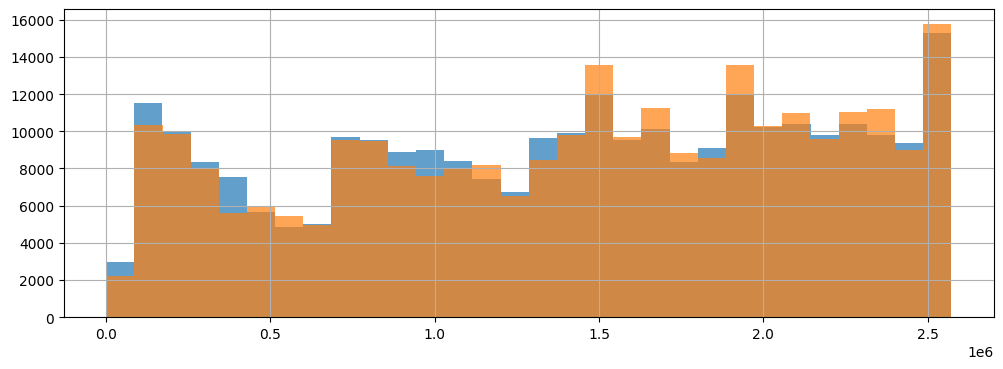

In [28]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].hist(alpha=.7, bins=30)
legend = ['real', 'syn']

In [29]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn[col].value_counts().rename('Syn'),
], axis=1)

,Real,Syn
LABEL,,
0,268474,268817
1,2867,2524


In [30]:
for col in ['USERID', 'TARGETID']:
    print(f'{col}: real - {df_train[col].nunique()}, {df_syn[col].nunique()}')

USERID: real - 4932, 4820
TARGETID: real - 97, 97


### TSTR

In [31]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def get_features(df):
    agg_dict = {
        'LABEL': ('LABEL', 'max'),
        'cnt': ('LABEL', 'count'),
        'min_ts': ('TIMESTAMP', 'min'),
        'max_ts': ('TIMESTAMP', 'max')
    }
    agg_dict.update({f'mean_{c}': (c, 'mean')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    agg_dict.update({f'max_{c}': (c, 'max')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    df_agg = df.groupby('USERID').agg(**agg_dict).reset_index()
    df_agg['dur'] = df_agg['max_ts'] - df_agg['min_ts']
    del df_agg['max_ts'], df_agg['min_ts']
    return df_agg

In [32]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_syn_feat = get_features(df_syn)
df_train_feat.shape, df_test_feat.shape, df_syn_feat.shape

((4932, 12), (2115, 12), (4820, 12))

In [33]:
df_syn_feat = df_syn_feat.astype(df_train_feat.dtypes)

In [34]:
def eval_model(df_train, df_test, mode):
    X_train = df_train.copy()
    y_train = X_train.pop('LABEL')
    X_test = df_test.copy()
    y_test = X_test.pop('LABEL')
    xgb = XGBClassifier(n_estimators=30, max_depth=5, learning_rate=.1, objective='binary:logistic', verbosity=1)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    metrics = {'mode': mode,
               'cnt_rows_train': y_train.shape[0],
               'cnt_ones_train': (y_train == 1).sum(),
               'F1_train': f1_score(y_train, y_pred_train),
               'F1_test': f1_score(y_test, y_pred_test)}
    return metrics

In [35]:
df_eval = pd.DataFrame([
    eval_model(df_syn_feat, df_test_feat, 'TSTR'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR,4820,1815,0.250000,0.047468
1,TRTR,4932,2867,0.866609,0.827356


In [39]:
# variant with 800 epochs of VAE and 1001 epochs of Diffusion model

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR,4386,1857,0.517655,0.310786
1,TRTR,4932,2867,0.866609,0.827356
